In [19]:
pip install hyperopt jupyter matplotlib pandas requests reservoirpy scikit-learn seaborn brevitas fxpmath

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


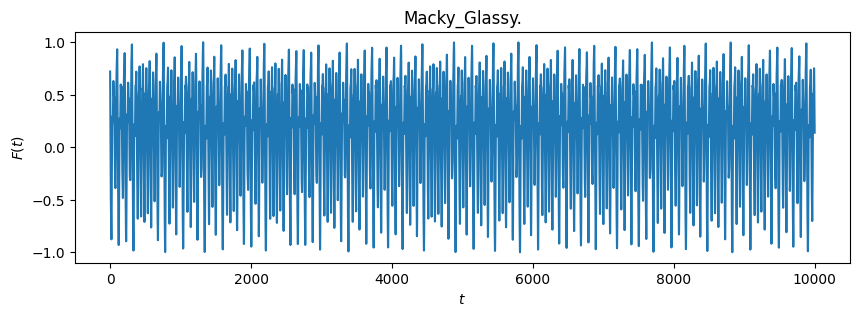

In [20]:
from reservoirpy.datasets import mackey_glass
from reservoirpy.nodes import Reservoir, Ridge
import matplotlib.pyplot as plt
X = mackey_glass(n_timesteps=10000)
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

plt.figure(figsize=(10, 3))
plt.title("Macky_Glassy.")
plt.ylabel("$F(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()


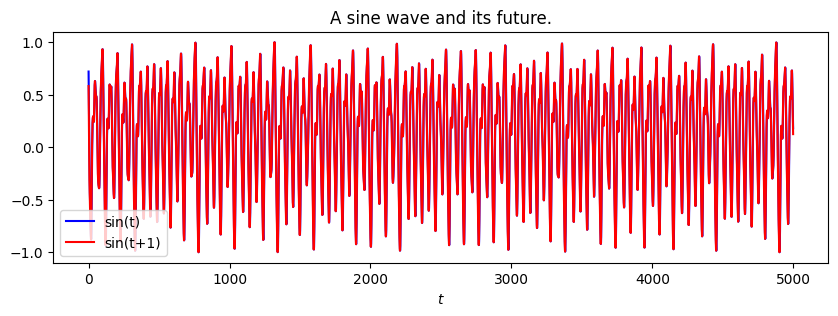

In [21]:
X_train = X[:5000]
y_train = X[1:5001]
X_test = X[5001:-1]
y_test = X[5002:]
dataset_float = ((X_train, y_train), (X_test, y_test))
plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(X_train, label="sin(t)", color="blue")
plt.plot(y_train, label="sin(t+1)", color="red")
plt.legend()
plt.show()

In [22]:
bit_width=4

In [23]:
import numpy as np
import torch

In [24]:
#integer, out , scale,  quantizer, layer , ...
# input

from brevitas.nn import QuantIdentity
import math
def extract_Qinput(input, num_bits=8):
  quant_identity = QuantIdentity(return_quant_tensor=True,bit_width=num_bits)
  float_input = torch.tensor(input,dtype=torch.float64)
  quant_input = quant_identity(float_input)
  out = quant_input.int().detach().numpy()

  scale = quant_input.scale.detach().numpy()
  zero_point = quant_input.zero_point.numpy()
  print(f"Input int quantized:\n {out} \n")
  print(f"Input scale: {scale}")
  print(f"Input zero_point: {zero_point}")
  return out, scale, zero_point

In [25]:
# output weight

from brevitas.nn import QuantLinear
from brevitas.quant import Int8ActPerTensorFloat,Int8WeightPerTensorFloat
import math
def quantize_output_layer(weights, num_bits=bit_width):
  quant_linear = QuantLinear(2, 4,weight_bit_width=num_bits, weight_quant=Int8WeightPerTensorFloat, requires_grad=False)
  quant_linear.weight.data = torch.tensor(weights,dtype=torch.float64)

  out = quant_linear.quant_weight().int().detach().numpy()
  scale = quant_linear.quant_weight().scale.detach().numpy()
  # out = quant_linear.quant_weight().value.data.numpy()


  #out = out * 0

  return out,scale
  # return out,scale,zero_point

In [26]:
def compute_integer_thresholds(scale):

    a = -1  # Lower bound of Hard Tanh
    b = 1   # Upper bound of Hard Tanh
    a_scaled = np.int32(a / scale)
    b_scaled = np.int32(b / scale)
    return a_scaled, b_scaled

In [27]:
def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled):

    # Apply saturation logic
    x = np.where(x < a_scaled, a_scaled, x)
    x = np.where(x > b_scaled, b_scaled, x)
    return (x / 2**bit_width).astype(np.int32)

In [28]:
int_x,x_scale,x_zero_point = extract_Qinput(X,num_bits=bit_width)

Input int quantized:
 [[6]
 [5]
 [3]
 ...
 [2]
 [2]
 [1]] 

Input scale: 0.125
Input zero_point: 0.0


In [29]:
int_x_train = int_x[:5000]
int_y_train = int_x[1:5001]
int_x_test = int_x[5001:-1]
int_y_test = int_x[5002:]
dataset_int = ((int_x_train, int_y_train), (int_x_test, int_y_test))

In [30]:
from reservoirpy import Node
def forward2(node: Node, x: np.ndarray,a_scaled, b_scaled,c_scaled, d_scaled) -> np.ndarray:
    state = node.state()  # get current node state  # Current reservoir state as integer
    state_int = state.astype(np.int32)
    W_res = node.Wr
    W_in = node.Win
    bias_res = node.Bias

    r = state_int @ W_res
    s = W_in.astype(np.int32) @ x
    s = s.reshape(1,node.output_dim)
    # Precompute thresholds and scale
    # a_scaled, b_scaled = compute_integer_thresholds(scale_Wr)

    # Apply integer PLA to reservoir and input contributions
    out_r = piecewise_linear_hard_tanh_integer(s,a_scaled, b_scaled)
    out_s = piecewise_linear_hard_tanh_integer(r,c_scaled, d_scaled)

    return out_r + out_s

In [31]:
def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
    """This function receives a data point x at runtime and uses it to
    infer input and output dimensions.
    """
    if x is not None:
        node.set_input_dim(x.shape[1])
        node.set_output_dim(y.shape[1])

In [32]:
class CustomNode(Node):
    def __init__(self, const2=-1,int_Wr=None,int_Win=None,bias=None,a_scaled=None, b_scaled=None,c_scaled=None, d_scaled=None):
        super().__init__(
            forward=lambda node, x: forward2(node, x,a_scaled, b_scaled,c_scaled, d_scaled),  # Pass thresholds here
            initializer=initialize,

            params={"const1": None, "Wr":int_Wr, "Win":int_Win, "Bias":bias},
            hypers={"const2": const2},
            # name=name,
        )

In [33]:
from reservoirpy.observables import rmse, rsquare

In [34]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other
# keys in the dict. See hyperopt documentation for more informations.
from reservoirpy.nodes import Reservoir, Ridge
def objective(dataset_float, config, *,N,sr,lr,iss,ridge,bit_width,seed):

    # This step may vary depending on what you put inside 'dataset'
    train_data_float, validation_data_float = dataset_float
    X_train_float, y_train_float = train_data_float
    X_val_float, y_val_float = validation_data_float

    # dataset integer quantized
    train_data_int, validation_data_int = dataset_int
    X_train_int, y_train_int = train_data_int
    X_val_int, y_val_int = validation_data_int

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses_float = []; r2s_float = [];
    losses_int = []; r2s_int = [];


    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N,
                              sr=sr,
                              lr=lr,
                              input_scaling=iss,
                              seed=variable_seed,
							  input_connectivity=0.4,
                              rc_connectivity=0.1)

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions_float = model.fit(X_train_float, y_train_float, warmup=400) \
                           .run(X_val_float)
                           ################# ADDED
        # reservoir.W.data = quantize_fixed_point(reservoir.W.data,2)
        # ############################################################ ADDED
        # predictions = model.fit(X_train, y_train) \
        #                    .run(X_test)
                           #########################
        loss_float = rmse(y_val_float, predictions_float)
        r2_float = rsquare(y_val_float, predictions_float)

        ############################Quantization############################


        int_Win,scale_Win,zero_point_Win = extract_Qinput((reservoir.Win.todense())/10,num_bits=bit_width)

        int_Wr,scale_Wr,zero_point_Wr = extract_Qinput(reservoir.W.todense(),num_bits=bit_width)

        input_scale = (scale_Win * x_scale)
        threshold_scale = 0.0625
        reservoir_scale = (scale_Wr * threshold_scale)

        a_scaled, b_scaled = compute_integer_thresholds(input_scale)
        c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)


        node = CustomNode(const2=-1,int_Wr=int_Wr,int_Win=int_Win,bias=reservoir.bias.todense(),a_scaled=a_scaled, b_scaled=b_scaled,c_scaled=c_scaled, d_scaled=d_scaled)
        node.set_output_dim(N)
        esn_model2 = node >> readout

        esn_model2 = esn_model2.fit(X_train_int.astype(np.float64), y_train_int.astype(np.float64), warmup=400)

        Wout_quantized, scale_out = quantize_output_layer(readout.Wout)
        readout.Wout = Wout_quantized

        a=threshold_scale * scale_out

        predictions_int = esn_model2.run(X_val_int)

        predictions_int = predictions_int *a

        min_x = np.min(y_val_float)
        max_x = np.max(y_val_float)
        min_pred = np.min(predictions_int)
        max_pred = np.max(predictions_int)

        predictions_int_normalized = (predictions_int - min_pred) / (max_pred - min_pred) * (max_x - min_x) + min_x

        loss_int = rmse(y_val_float, predictions_int_normalized)
        r2_int = rsquare(y_val_float, predictions_int_normalized)
        # Change the seed between instances
        variable_seed += 1

        losses_float.append(loss_float)
        r2s_float.append(r2_float)

        losses_int.append(loss_int)
        r2s_int.append(r2_int)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses_float),
            'r2': np.mean(r2s_float),
            'loss_int': np.mean(losses_int),
            'r2_int': np.mean(r2s_int)}

In [35]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 100,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice",50,100,150,200,250,300,350,400,450,500],             # the number of neurons is fixed to 300
        "sr": ["choice", 0.9,1,1.1,1.15,1.2,1.25],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["choice",1],    # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 1.0], # the input scaling is fixed
		"ridge": ["loguniform", 1e-8, 1e-4],
        "bit_width": ["choice",8],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [36]:
from reservoirpy.hyper import research

best = research(objective, dataset_float, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Running Model-64:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-64: 1395it [00:00, 13941.80it/s]         
Running Model-64: 2932it [00:00, 14780.21it/s]
Running Model-64: 4411it [00:00, 12618.58it/s]
Running Model-64: 5000it [00:00, 13247.26it/s]
Running Model-64: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-32...                               
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Running Model-64:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-64: 1652it [00:00, 16509.74it/s]         
Running Model-64: 3303it [00:00, 16417.07it/s]
Running Model-64: 4968it [00:00, 16519.08it/s]
Running Model-64: 4998it [00:00, 16460.84it/s]


Input int quantized:                                   
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]

Running Model-65:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-65: 808it [00:00, 8074.23it/s]           
Running Model-65: 1629it [00:00, 8152.37it/s]
Running Model-65: 2453it [00:00, 8191.54it/s]
Running Model-65: 3273it [00:00, 8050.35it/s]
Running Model-65: 4087it [00:00, 8080.59it/s]
Running Model-65: 4896it [00:00, 7972.19it/s]
Running Model-65: 5000it [00:00, 8035.53it/s]
Running Model-65: 100%|##########| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-32...                               
  0%|          | 0/100 [00:01<?, ?trial/s, best loss=?]

Running Model-65:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-65: 825it [00:00, 8242.03it/s]           
Running Model-65: 1662it [00:00, 8315.72it/s]
Running Model-65: 2494it [00:00, 7550.58it/s]
Running Model-65: 3357it [00:00, 7951.74it/s]
Running Model-65: 4221it [00:00, 8189.70it/s]
Running Model-65: 4998it [00:00, 8147.10it/s]
Running Model-66:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-66: 1549it [00:00, 15485.88it/s]         
Running Model-66: 3098it [00:00, 15439.94it/s]
Running Model-66: 4644it [00:00, 15448.81it/s]
Running Model-66: 5000it [00:00, 15407.37it/s]
Running Model-66: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-33...                               
  0%|          | 0/100 [00:02<?, ?trial/s, best loss=?]

Running Model-66:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-66: 1635it [00:00, 16340.00it/s]         
Running Model-66: 3270it [00:00, 14907.67it/s]
Running Model-66: 4800it [00:00, 15072.78it/s]
Running Model-66: 4998it [00:00, 15106.35it/s]


Input int quantized:                                   
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]

Running Model-67:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-67: 731it [00:00, 7306.28it/s]           
Running Model-67: 1462it [00:00, 7159.44it/s]
Running Model-67: 2179it [00:00, 7140.15it/s]
Running Model-67: 2894it [00:00, 6999.64it/s]
Running Model-67: 3595it [00:00, 6907.52it/s]
Running Model-67: 4287it [00:00, 6803.99it/s]
Running Model-67: 4968it [00:00, 6643.64it/s]
Running Model-67: 5000it [00:00, 6832.84it/s]
Running Model-67: 100%|##########| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-33...                               
  0%|          | 0/100 [00:03<?, ?trial/s, best loss=?]

Running Model-67:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-67: 746it [00:00, 7451.16it/s]           
Running Model-67: 1492it [00:00, 6935.88it/s]
Running Model-67: 2223it [00:00, 7099.54it/s]
Running Model-67: 3016it [00:00, 7418.24it/s]
Running Model-67: 3812it [00:00, 7609.38it/s]
Running Model-67: 4598it [00:00, 7692.34it/s]
Running Model-67: 4998it [00:00, 7528.10it/s]
Running Model-68:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-68: 1549it [00:00, 15482.23it/s]         
Running Model-68: 3098it [00:00, 15328.47it/s]
Running Model-68: 4659it [00:00, 15453.17it/s]
Running Model-68: 5000it [00:00, 15412.02it/s]
Running Model-68: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-34...                               
  0%|          | 0/100 [00:04<?, ?trial/s, best loss=?]

Running Model-68:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-68: 1557it [00:00, 15567.82it/s]         
Running Model-68: 3193it [00:00, 16028.47it/s]
Running Model-68: 4821it [00:00, 16139.26it/s]
Running Model-68: 4998it [00:00, 16012.19it/s]


Input int quantized:                                   
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]

Running Model-69:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-69: 752it [00:00, 7510.66it/s]           
Running Model-69: 1504it [00:00, 7452.38it/s]
Running Model-69: 2250it [00:00, 7442.36it/s]
Running Model-69: 2995it [00:00, 6969.47it/s]
Running Model-69: 3742it [00:00, 7139.14it/s]
Running Model-69: 4490it [00:00, 7249.02it/s]
Running Model-69: 5000it [00:00, 7247.53it/s]
Running Model-69: 100%|##########| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-34...                               
  0%|          | 0/100 [00:06<?, ?trial/s, best loss=?]

Running Model-69:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-69: 784it [00:00, 7832.89it/s]           
Running Model-69: 1568it [00:00, 7207.09it/s]
Running Model-69: 2319it [00:00, 7337.93it/s]
Running Model-69: 3120it [00:00, 7594.89it/s]
Running Model-69: 3882it [00:00, 7326.10it/s]
Running Model-69: 4623it [00:00, 7350.88it/s]
Running Model-69: 4998it [00:00, 7413.94it/s]


  1%|          | 1/100 [00:06<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-70:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-70: 1787it [00:00, 17865.03it/s]         
Running Model-70: 3589it [00:00, 17955.28it/s]
Running Model-70: 5000it [00:00, 17984.52it/s]
Running Model-70: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-35...                                                            
  1%|          | 1/100 [00:07<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-70:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-70: 1849it [00:00, 18482.09it/s]         
Running Model-70: 3774it [00:00, 18927.84it/s]
Running Model-70: 4998it [00:00, 18946.20it/s]


Input int quantized:                                                                
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [

Running Model-71:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-71: 1593it [00:00, 15922.61it/s]         
Running Model-71: 3306it [00:00, 16627.79it/s]
Running Model-71: 5000it [00:00, 16873.80it/s]
Running Model-71: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-35...                                                            
  1%|          | 1/100 [00:07<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-71:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-71: 1854it [00:00, 18536.13it/s]         
Running Model-71: 3708it [00:00, 18076.23it/s]
Running Model-71: 4998it [00:00, 18439.84it/s]
Running Model-72:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-72: 1821it [00:00, 18204.20it/s]         
Running Model-72: 3642it [00:00, 18105.58it/s]
Running Model-72: 5000it [00:00, 18070.69it/s]
Running Model-72: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-36...                                                            
  1%|          | 1/100 [00:08<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-72:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-72: 1649it [00:00, 16483.45it/s]         
Running Model-72: 3603it [00:00, 18277.47it/s]
Running Model-72: 4998it [00:00, 18368.86it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [

Running Model-73:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-73: 1671it [00:00, 16700.74it/s]         
Running Model-73: 3429it [00:00, 17213.76it/s]
Running Model-73: 5000it [00:00, 17174.79it/s]
Running Model-73: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-36...                                                            
  1%|          | 1/100 [00:09<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-73:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-73: 1828it [00:00, 18271.35it/s]         
Running Model-73: 3667it [00:00, 18338.72it/s]
Running Model-73: 4998it [00:00, 17970.32it/s]
Running Model-74:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-74: 1661it [00:00, 16606.89it/s]         
Running Model-74: 3363it [00:00, 16846.89it/s]
Running Model-74: 5000it [00:00, 16945.03it/s]
Running Model-74: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-37...                                                            
  1%|          | 1/100 [00:09<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-74:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-74: 1744it [00:00, 17438.19it/s]         
Running Model-74: 3598it [00:00, 18085.05it/s]
Running Model-74: 4998it [00:00, 16815.26it/s]


Input int quantized:                                                                
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [

Running Model-75:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-75: 1601it [00:00, 16004.22it/s]         
Running Model-75: 3353it [00:00, 16891.16it/s]
Running Model-75: 5000it [00:00, 16994.58it/s]
Running Model-75: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-37...                                                            
  1%|          | 1/100 [00:10<11:10,  6.77s/trial, best loss: 0.0059033692697946045]

Running Model-75:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-75: 1463it [00:00, 14625.59it/s]         
Running Model-75: 3384it [00:00, 17318.31it/s]
Running Model-75: 4998it [00:00, 17300.48it/s]


  2%|▏         | 2/100 [00:10<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-76:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-76: 1855it [00:00, 18539.94it/s]         
Running Model-76: 3746it [00:00, 18756.74it/s]
Running Model-76: 5000it [00:00, 18805.67it/s]
Running Model-76: 100%|##########| 1/1 [00:00<00:00,  3.71it/s]


Fitting node Ridge-38...                                                            
  2%|▏         | 2/100 [00:11<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-76:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-76: 1927it [00:00, 19267.86it/s]         
Running Model-76: 3947it [00:00, 19814.19it/s]
Running Model-76: 4998it [00:00, 19845.55it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0     

Running Model-77:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-77: 2074it [00:00, 20736.71it/s]         
Running Model-77: 4240it [00:00, 21277.47it/s]
Running Model-77: 5000it [00:00, 21327.48it/s]
Running Model-77: 100%|##########| 1/1 [00:00<00:00,  4.21it/s]


Fitting node Ridge-38...                                                            
  2%|▏         | 2/100 [00:11<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-77:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-77: 2494it [00:00, 24938.60it/s]         
Running Model-77: 4988it [00:00, 24936.57it/s]
Running Model-77: 4998it [00:00, 24822.72it/s]
Running Model-78:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-78: 1869it [00:00, 18682.40it/s]         
Running Model-78: 3753it [00:00, 18769.42it/s]
Running Model-78: 5000it [00:00, 18593.19it/s]
Running Model-78: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-39...                                                            
  2%|▏         | 2/100 [00:12<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-78:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-78: 1772it [00:00, 17703.09it/s]         
Running Model-78: 3543it [00:00, 14933.47it/s]
Running Model-78: 4998it [00:00, 16182.95it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0     

Running Model-79:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-79: 1898it [00:00, 18977.57it/s]         
Running Model-79: 4069it [00:00, 20580.60it/s]
Running Model-79: 5000it [00:00, 20583.18it/s]
Running Model-79: 100%|##########| 1/1 [00:00<00:00,  4.06it/s]


Fitting node Ridge-39...                                                            
  2%|▏         | 2/100 [00:12<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-79:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-79: 2439it [00:00, 24387.06it/s]         
Running Model-79: 4926it [00:00, 24667.99it/s]
Running Model-79: 4998it [00:00, 24527.89it/s]
Running Model-80:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-80: 1927it [00:00, 19262.85it/s]         
Running Model-80: 3857it [00:00, 19280.55it/s]
Running Model-80: 5000it [00:00, 19264.10it/s]
Running Model-80: 100%|##########| 1/1 [00:00<00:00,  3.80it/s]


Fitting node Ridge-40...                                                            
  2%|▏         | 2/100 [00:13<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-80:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-80: 2039it [00:00, 20386.18it/s]         
Running Model-80: 4084it [00:00, 20420.44it/s]
Running Model-80: 4998it [00:00, 20385.43it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0     

Running Model-81:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-81: 2166it [00:00, 21651.09it/s]         
Running Model-81: 4347it [00:00, 21741.58it/s]
Running Model-81: 5000it [00:00, 21718.03it/s]
Running Model-81: 100%|##########| 1/1 [00:00<00:00,  4.28it/s]


Fitting node Ridge-40...                                                            
  2%|▏         | 2/100 [00:14<08:22,  5.13s/trial, best loss: 0.0036669989703026645]

Running Model-81:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-81: 2275it [00:00, 22748.99it/s]         
Running Model-81: 4697it [00:00, 23613.89it/s]
Running Model-81: 4998it [00:00, 23433.39it/s]


  3%|▎         | 3/100 [00:14<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-82:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-82: 1757it [00:00, 17562.77it/s]         
Running Model-82: 3514it [00:00, 16613.73it/s]
Running Model-82: 5000it [00:00, 16917.11it/s]
Running Model-82: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-41...                                                            
  3%|▎         | 3/100 [00:14<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-82:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-82: 1739it [00:00, 17382.18it/s]         
Running Model-82: 3618it [00:00, 18204.53it/s]
Running Model-82: 4998it [00:00, 18244.29it/s]


Input int quantized:                                                                
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [

Running Model-83:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-83: 1302it [00:00, 13015.82it/s]         
Running Model-83: 2762it [00:00, 13946.85it/s]
Running Model-83: 4237it [00:00, 14312.22it/s]
Running Model-83: 5000it [00:00, 14045.07it/s]
Running Model-83: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-41...                                                            
  3%|▎         | 3/100 [00:15<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-83:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-83: 1394it [00:00, 13932.17it/s]         
Running Model-83: 2813it [00:00, 14079.94it/s]
Running Model-83: 4369it [00:00, 14755.01it/s]
Running Model-83: 4998it [00:00, 14661.33it/s]
Running Model-84:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-84: 1752it [00:00, 17518.55it/s]         
Running Model-84: 3522it [00:00, 17623.61it/s]
Running Model-84: 5000it [00:00, 17675.20it/s]
Running Model-84: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-42...                                                            
  3%|▎         | 3/100 [00:16<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-84:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-84: 1685it [00:00, 16843.75it/s]         
Running Model-84: 3572it [00:00, 18033.29it/s]
Running Model-84: 4998it [00:00, 17960.59it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [

Running Model-85:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-85: 1243it [00:00, 12384.92it/s]         
Running Model-85: 2482it [00:00, 12368.88it/s]
Running Model-85: 4053it [00:00, 13888.96it/s]
Running Model-85: 5000it [00:00, 13804.65it/s]
Running Model-85: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Fitting node Ridge-42...                                                            
  3%|▎         | 3/100 [00:16<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-85:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-85: 1652it [00:00, 16514.94it/s]         
Running Model-85: 3307it [00:00, 16533.48it/s]
Running Model-85: 4961it [00:00, 16496.73it/s]
Running Model-85: 4998it [00:00, 16457.28it/s]
Running Model-86:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-86: 1756it [00:00, 17559.51it/s]         
Running Model-86: 3512it [00:00, 17434.50it/s]
Running Model-86: 5000it [00:00, 17459.87it/s]
Running Model-86: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-43...                                                            
  3%|▎         | 3/100 [00:17<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-86:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-86: 1869it [00:00, 18685.03it/s]         
Running Model-86: 3756it [00:00, 18790.04it/s]
Running Model-86: 4998it [00:00, 18752.91it/s]


Input int quantized:                                                                
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [

Running Model-87:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-87: 1088it [00:00, 10878.92it/s]         
Running Model-87: 2602it [00:00, 13380.73it/s]
Running Model-87: 4003it [00:00, 13664.38it/s]
Running Model-87: 5000it [00:00, 13449.98it/s]
Running Model-87: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Fitting node Ridge-43...                                                            
  3%|▎         | 3/100 [00:18<07:08,  4.42s/trial, best loss: 0.0036669989703026645]

Running Model-87:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-87: 1594it [00:00, 15938.69it/s]         
Running Model-87: 3188it [00:00, 15548.79it/s]
Running Model-87: 4788it [00:00, 15750.55it/s]
Running Model-87: 4998it [00:00, 15703.54it/s]


  4%|▍         | 4/100 [00:18<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-88:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-88: 1598it [00:00, 15971.79it/s]         
Running Model-88: 3196it [00:00, 15580.66it/s]
Running Model-88: 4792it [00:00, 15749.34it/s]
Running Model-88: 5000it [00:00, 15700.87it/s]
Running Model-88: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-44...                                                            
  4%|▍         | 4/100 [00:19<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-88:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-88: 1730it [00:00, 17297.87it/s]         
Running Model-88: 3462it [00:00, 17307.65it/s]
Running Model-88: 4998it [00:00, 17419.31it/s]


Input int quantized:                                                                
 [[ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [

Running Model-89:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-89: 1186it [00:00, 11850.09it/s]         
Running Model-89: 2372it [00:00, 11251.80it/s]
Running Model-89: 3500it [00:00, 11170.31it/s]
Running Model-89: 4673it [00:00, 11383.95it/s]
Running Model-89: 5000it [00:00, 11390.87it/s]
Running Model-89: 100%|##########| 1/1 [00:00<00:00,  2.25it/s]


Fitting node Ridge-44...                                                            
  4%|▍         | 4/100 [00:19<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-89:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-89: 1304it [00:00, 13038.12it/s]         
Running Model-89: 2612it [00:00, 13061.90it/s]
Running Model-89: 3919it [00:00, 13002.49it/s]
Running Model-89: 4998it [00:00, 13038.44it/s]
Running Model-90:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-90: 1689it [00:00, 16884.30it/s]         
Running Model-90: 3389it [00:00, 16951.81it/s]
Running Model-90: 5000it [00:00, 16955.84it/s]
Running Model-90: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-45...                                                            
  4%|▍         | 4/100 [00:20<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-90:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-90: 1700it [00:00, 16997.30it/s]         
Running Model-90: 3503it [00:00, 17600.37it/s]
Running Model-90: 4998it [00:00, 17234.20it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [

Running Model-91:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-91: 1166it [00:00, 11656.20it/s]         
Running Model-91: 2368it [00:00, 11863.96it/s]
Running Model-91: 3584it [00:00, 11995.56it/s]
Running Model-91: 4784it [00:00, 11922.07it/s]
Running Model-91: 5000it [00:00, 11882.84it/s]
Running Model-91: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-45...                                                            
  4%|▍         | 4/100 [00:21<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-91:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-91: 1216it [00:00, 12151.44it/s]         
Running Model-91: 2432it [00:00, 11845.06it/s]
Running Model-91: 3715it [00:00, 12285.04it/s]
Running Model-91: 4967it [00:00, 12374.10it/s]
Running Model-91: 4998it [00:00, 12236.49it/s]
Running Model-92:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-92: 1703it [00:00, 17026.16it/s]         
Running Model-92: 3412it [00:00, 17062.45it/s]
Running Model-92: 5000it [00:00, 16889.24it/s]
Running Model-92: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-46...                                                            
  4%|▍         | 4/100 [00:22<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-92:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-92: 1708it [00:00, 17071.02it/s]         
Running Model-92: 3500it [00:00, 17569.21it/s]
Running Model-92: 4998it [00:00, 17695.05it/s]


Input int quantized:                                                                
 [[   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [

Running Model-93:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-93: 1216it [00:00, 12149.96it/s]         
Running Model-93: 2431it [00:00, 11863.77it/s]
Running Model-93: 3638it [00:00, 11953.77it/s]
Running Model-93: 4838it [00:00, 11971.12it/s]
Running Model-93: 5000it [00:00, 11929.72it/s]
Running Model-93: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-46...                                                            
  4%|▍         | 4/100 [00:23<07:05,  4.43s/trial, best loss: 0.0036669989703026645]

Running Model-93:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-93: 1264it [00:00, 12633.36it/s]         
Running Model-93: 2528it [00:00, 12467.16it/s]
Running Model-93: 3841it [00:00, 12766.70it/s]
Running Model-93: 4998it [00:00, 12799.15it/s]


  5%|▌         | 5/100 [00:23<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-94:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-94: 1546it [00:00, 15450.55it/s]         
Running Model-94: 3140it [00:00, 15732.26it/s]
Running Model-94: 4750it [00:00, 15895.91it/s]
Running Model-94: 5000it [00:00, 15796.29it/s]
Running Model-94: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-47...                                                            
  5%|▌         | 5/100 [00:23<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-94:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-94: 1603it [00:00, 16024.90it/s]         
Running Model-94: 3296it [00:00, 16546.41it/s]
Running Model-94: 4996it [00:00, 16752.52it/s]
Running Model-94: 4998it [00:00, 16602.66it/s]


Input int quantized:                                                                
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [

Running Model-95:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-95: 940it [00:00, 9399.61it/s]           
Running Model-95: 1905it [00:00, 9545.44it/s]
Running Model-95: 2870it [00:00, 9591.71it/s]
Running Model-95: 3847it [00:00, 9659.13it/s]
Running Model-95: 4820it [00:00, 9684.39it/s]
Running Model-95: 5000it [00:00, 9501.17it/s]
Running Model-95: 100%|##########| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-47...                                                            
  5%|▌         | 5/100 [00:24<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-95:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-95: 1002it [00:00, 10013.56it/s]         
Running Model-95: 2004it [00:00, 9934.32it/s] 
Running Model-95: 3010it [00:00, 9989.60it/s]
Running Model-95: 4017it [00:00, 10017.89it/s]
Running Model-95: 4998it [00:00, 10012.63it/s]
Running Model-96:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-96: 1575it [00:00, 15746.94it/s]         
Running Model-96: 3167it [00:00, 15843.58it/s]
Running Model-96: 4770it [00:00, 15926.08it/s]
Running Model-96: 5000it [00:00, 15867.06it/s]
Running Model-96: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-48...                                                            
  5%|▌         | 5/100 [00:25<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-96:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-96: 1537it [00:00, 15361.77it/s]         
Running Model-96: 3082it [00:00, 15409.97it/s]
Running Model-96: 4623it [00:00, 15271.77it/s]
Running Model-96: 4998it [00:00, 15236.01it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [

Running Model-97:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-97: 822it [00:00, 8218.19it/s]           
Running Model-97: 1667it [00:00, 8353.97it/s]
Running Model-97: 2515it [00:00, 8409.31it/s]
Running Model-97: 3363it [00:00, 8433.64it/s]
Running Model-97: 4210it [00:00, 8443.99it/s]
Running Model-97: 5000it [00:00, 8418.03it/s]
Running Model-97: 100%|##########| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-48...                                                            
  5%|▌         | 5/100 [00:26<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-97:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-97: 879it [00:00, 8783.96it/s]           
Running Model-97: 1893it [00:00, 9580.98it/s]
Running Model-97: 2914it [00:00, 9867.93it/s]
Running Model-97: 3923it [00:00, 9954.54it/s]
Running Model-97: 4931it [00:00, 9996.84it/s]
Running Model-97: 4998it [00:00, 9843.10it/s]
Running Model-98:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-98: 1593it [00:00, 15928.69it/s]         
Running Model-98: 3195it [00:00, 15977.77it/s]
Running Model-98: 4806it [00:00, 16034.71it/s]
Running Model-98: 5000it [00:00, 15965.66it/s]
Running Model-98: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-49...                                                            
  5%|▌         | 5/100 [00:27<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-98:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-98: 1628it [00:00, 16272.45it/s]         
Running Model-98: 3295it [00:00, 16501.02it/s]
Running Model-98: 4978it [00:00, 16649.93it/s]
Running Model-98: 4998it [00:00, 16534.29it/s]


Input int quantized:                                                                
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [

Running Model-99:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-99: 925it [00:00, 9246.35it/s]           
Running Model-99: 1870it [00:00, 9362.95it/s]
Running Model-99: 2821it [00:00, 9429.20it/s]
Running Model-99: 3771it [00:00, 9454.70it/s]
Running Model-99: 4731it [00:00, 9503.70it/s]
Running Model-99: 5000it [00:00, 9438.87it/s]
Running Model-99: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-49...                                                            
  5%|▌         | 5/100 [00:28<07:15,  4.58s/trial, best loss: 0.0036669989703026645]

Running Model-99:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-99: 975it [00:00, 9747.36it/s]           
Running Model-99: 1976it [00:00, 9898.59it/s]
Running Model-99: 3000it [00:00, 10049.95it/s]
Running Model-99: 4009it [00:00, 10062.64it/s]
Running Model-99: 4998it [00:00, 10001.38it/s]


  6%|▌         | 6/100 [00:29<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-100:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-100: 1467it [00:00, 14668.09it/s]         
Running Model-100: 2934it [00:00, 14013.43it/s]
Running Model-100: 4550it [00:00, 14966.33it/s]
Running Model-100: 5000it [00:00, 14880.08it/s]
Running Model-100: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-50...                                                            
  6%|▌         | 6/100 [00:29<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-100:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-100: 1587it [00:00, 15866.65it/s]         
Running Model-100: 3336it [00:00, 16815.69it/s]
Running Model-100: 4998it [00:00, 16919.57it/s]


Input int quantized:                                                                
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [

Running Model-101:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-101: 967it [00:00, 9664.62it/s]           
Running Model-101: 1934it [00:00, 9654.20it/s]
Running Model-101: 2950it [00:00, 9883.49it/s]
Running Model-101: 3939it [00:00, 9477.81it/s]
Running Model-101: 4890it [00:00, 9281.48it/s]
Running Model-101: 5000it [00:00, 9445.18it/s]
Running Model-101: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-50...                                                            
  6%|▌         | 6/100 [00:30<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-101:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-101: 1047it [00:00, 10469.36it/s]         
Running Model-101: 2135it [00:00, 10708.72it/s]
Running Model-101: 3232it [00:00, 10827.27it/s]
Running Model-101: 4333it [00:00, 10897.09it/s]
Running Model-101: 4998it [00:00, 10631.22it/s]
Running Model-102:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-102: 1415it [00:00, 14142.29it/s]         
Running Model-102: 3040it [00:00, 15380.06it/s]
Running Model-102: 4689it [00:00, 15886.00it/s]
Running Model-102: 5000it [00:00, 15639.29it/s]
Running Model-102: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-51...                                                            
  6%|▌         | 6/100 [00:31<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-102:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-102: 1593it [00:00, 15923.30it/s]         
Running Model-102: 3321it [00:00, 16716.00it/s]
Running Model-102: 4998it [00:00, 16844.96it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [

Running Model-103:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-103: 839it [00:00, 8385.89it/s]           
Running Model-103: 1759it [00:00, 8862.54it/s]
Running Model-103: 2783it [00:00, 9488.36it/s]
Running Model-103: 3812it [00:00, 9803.24it/s]
Running Model-103: 4840it [00:00, 9973.08it/s]
Running Model-103: 5000it [00:00, 9669.09it/s]
Running Model-103: 100%|##########| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-51...                                                            
  6%|▌         | 6/100 [00:32<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-103:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-103: 1080it [00:00, 10798.85it/s]         
Running Model-103: 2164it [00:00, 10815.54it/s]
Running Model-103: 3246it [00:00, 9207.91it/s] 
Running Model-103: 4332it [00:00, 9795.93it/s]
Running Model-103: 4998it [00:00, 9995.54it/s]
Running Model-104:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-104: 1652it [00:00, 16516.16it/s]         
Running Model-104: 3304it [00:00, 16459.13it/s]
Running Model-104: 4952it [00:00, 16463.84it/s]
Running Model-104: 5000it [00:00, 16431.10it/s]
Running Model-104: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-52...                                                            
  6%|▌         | 6/100 [00:33<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-104:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-104: 1643it [00:00, 16427.20it/s]         
Running Model-104: 3385it [00:00, 17010.09it/s]
Running Model-104: 4998it [00:00, 17088.03it/s]


Input int quantized:                                                                
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [

Running Model-105:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-105: 842it [00:00, 8414.13it/s]           
Running Model-105: 1872it [00:00, 9520.28it/s]
Running Model-105: 2909it [00:00, 9907.95it/s]
Running Model-105: 3953it [00:00, 10115.76it/s]
Running Model-105: 5000it [00:00, 9997.90it/s] 
Running Model-105: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-52...                                                            
  6%|▌         | 6/100 [00:34<07:50,  5.01s/trial, best loss: 0.0036669989703026645]

Running Model-105:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-105: 1074it [00:00, 10736.02it/s]         
Running Model-105: 2171it [00:00, 10871.02it/s]
Running Model-105: 3269it [00:00, 10918.43it/s]
Running Model-105: 4370it [00:00, 10953.90it/s]
Running Model-105: 4998it [00:00, 10916.15it/s]


  7%|▋         | 7/100 [00:34<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-106:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-106: 1896it [00:00, 18951.16it/s]         
Running Model-106: 3839it [00:00, 19230.66it/s]
Running Model-106: 5000it [00:00, 19204.53it/s]
Running Model-106: 100%|##########| 1/1 [00:00<00:00,  3.80it/s]


Fitting node Ridge-53...                                                            
  7%|▋         | 7/100 [00:35<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-106:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-106: 1953it [00:00, 19527.97it/s]         
Running Model-106: 3983it [00:00, 19978.45it/s]
Running Model-106: 4998it [00:00, 19774.71it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0                                                               
Input int quantized:                                                                
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.009327451917016713                                                   
Input zero_p

Running Model-107:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-107: 2356it [00:00, 23551.04it/s]         
Running Model-107: 4759it [00:00, 23829.48it/s]
Running Model-107: 5000it [00:00, 23704.32it/s]
Running Model-107: 100%|##########| 1/1 [00:00<00:00,  4.68it/s]


Fitting node Ridge-53...                                                            
  7%|▋         | 7/100 [00:35<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-107:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-107: 2744it [00:00, 27432.96it/s]         
Running Model-107: 4998it [00:00, 27258.02it/s]
Running Model-108:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-108: 1858it [00:00, 18573.77it/s]         
Running Model-108: 3790it [00:00, 19006.39it/s]
Running Model-108: 5000it [00:00, 18941.04it/s]
Running Model-108: 100%|##########| 1/1 [00:00<00:00,  3.75it/s]


Fitting node Ridge-54...                                                            
  7%|▋         | 7/100 [00:36<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-108:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-108: 2045it [00:00, 20447.29it/s]         
Running Model-108: 4109it [00:00, 20559.88it/s]
Running Model-108: 4998it [00:00, 20522.37it/s]


Input int quantized:                                                                
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0                                                               
Input int quantized:                                                                
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.0076061352369754314                                                  
Input zero_p

Running Model-109:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-109: 2321it [00:00, 23204.32it/s]         
Running Model-109: 4658it [00:00, 23301.26it/s]
Running Model-109: 5000it [00:00, 23179.89it/s]
Running Model-109: 100%|##########| 1/1 [00:00<00:00,  4.57it/s]


Fitting node Ridge-54...                                                            
  7%|▋         | 7/100 [00:36<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-109:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-109: 2721it [00:00, 27208.60it/s]         
Running Model-109: 4998it [00:00, 26964.76it/s]
Running Model-110:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-110: 1845it [00:00, 18445.88it/s]         
Running Model-110: 3758it [00:00, 18844.42it/s]
Running Model-110: 5000it [00:00, 18849.23it/s]
Running Model-110: 100%|##########| 1/1 [00:00<00:00,  3.73it/s]


Fitting node Ridge-55...                                                            
  7%|▋         | 7/100 [00:37<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-110:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-110: 2014it [00:00, 20139.25it/s]         
Running Model-110: 4028it [00:00, 19951.17it/s]
Running Model-110: 4998it [00:00, 17930.48it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                             
Input zero_point: 0.0                                                               
Input int quantized:                                                                
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.010751987351455782                            

Running Model-111:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-111: 2104it [00:00, 21035.21it/s]         
Running Model-111: 4208it [00:00, 18407.45it/s]
Running Model-111: 5000it [00:00, 19419.12it/s]
Running Model-111: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-55...                                                            
  7%|▋         | 7/100 [00:38<07:59,  5.16s/trial, best loss: 0.0031353020288260682]

Running Model-111:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-111: 2723it [00:00, 27227.36it/s]         
Running Model-111: 4998it [00:00, 27083.38it/s]


  8%|▊         | 8/100 [00:38<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-112:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-112: 1560it [00:00, 15590.65it/s]         
Running Model-112: 3122it [00:00, 15602.27it/s]
Running Model-112: 4690it [00:00, 15636.09it/s]
Running Model-112: 5000it [00:00, 15596.14it/s]
Running Model-112: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-56...                                                            
  8%|▊         | 8/100 [00:38<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-112:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-112: 1682it [00:00, 16810.84it/s]         
Running Model-112: 3364it [00:00, 13551.93it/s]
Running Model-112: 4998it [00:00, 14741.69it/s]


Input int quantized:                                                                
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [

Running Model-113:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-113: 941it [00:00, 9407.38it/s]           
Running Model-113: 1886it [00:00, 9427.19it/s]
Running Model-113: 2829it [00:00, 9401.60it/s]
Running Model-113: 3796it [00:00, 9505.24it/s]
Running Model-113: 4765it [00:00, 9569.63it/s]
Running Model-113: 5000it [00:00, 9502.59it/s]
Running Model-113: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-56...                                                            
  8%|▊         | 8/100 [00:39<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-113:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-113: 984it [00:00, 9832.11it/s]           
Running Model-113: 1985it [00:00, 9935.72it/s]
Running Model-113: 3005it [00:00, 10053.23it/s]
Running Model-113: 4025it [00:00, 10108.18it/s]
Running Model-113: 4998it [00:00, 10070.19it/s]
Running Model-114:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-114: 1607it [00:00, 16062.74it/s]         
Running Model-114: 3214it [00:00, 15889.14it/s]
Running Model-114: 4804it [00:00, 15801.31it/s]
Running Model-114: 5000it [00:00, 15797.11it/s]
Running Model-114: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-57...                                                            
  8%|▊         | 8/100 [00:40<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-114:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-114: 1619it [00:00, 16184.03it/s]         
Running Model-114: 3260it [00:00, 16312.05it/s]
Running Model-114: 4913it [00:00, 16400.02it/s]
Running Model-114: 4998it [00:00, 16325.59it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [

Running Model-115:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-115: 973it [00:00, 9725.05it/s]           
Running Model-115: 1946it [00:00, 9696.38it/s]
Running Model-115: 2916it [00:00, 9538.94it/s]
Running Model-115: 3871it [00:00, 9507.02it/s]
Running Model-115: 4829it [00:00, 9529.50it/s]
Running Model-115: 5000it [00:00, 9541.98it/s]
Running Model-115: 100%|##########| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-57...                                                            
  8%|▊         | 8/100 [00:41<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-115:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-115: 984it [00:00, 9830.68it/s]           
Running Model-115: 1983it [00:00, 9921.68it/s]
Running Model-115: 2985it [00:00, 9964.11it/s]
Running Model-115: 3982it [00:00, 8632.69it/s]
Running Model-115: 4977it [00:00, 9062.62it/s]
Running Model-115: 4998it [00:00, 9212.57it/s]
Running Model-116:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-116: 1563it [00:00, 15624.50it/s]         
Running Model-116: 3147it [00:00, 15750.48it/s]
Running Model-116: 4764it [00:00, 15939.62it/s]
Running Model-116: 5000it [00:00, 15844.14it/s]
Running Model-116: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-58...                                                            
  8%|▊         | 8/100 [00:42<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-116:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-116: 1625it [00:00, 16248.54it/s]         
Running Model-116: 3334it [00:00, 16741.58it/s]
Running Model-116: 4998it [00:00, 16813.09it/s]


Input int quantized:                                                                
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [

Running Model-117:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-117: 716it [00:00, 7154.99it/s]           
Running Model-117: 1545it [00:00, 7820.22it/s]
Running Model-117: 2506it [00:00, 8635.05it/s]
Running Model-117: 3453it [00:00, 8963.19it/s]
Running Model-117: 4398it [00:00, 9137.05it/s]
Running Model-117: 5000it [00:00, 8852.31it/s]
Running Model-117: 100%|##########| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-58...                                                            
  8%|▊         | 8/100 [00:43<07:03,  4.60s/trial, best loss: 0.0031353020288260682]

Running Model-117:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-117: 1000it [00:00, 9989.86it/s]          
Running Model-117: 1999it [00:00, 9953.31it/s]
Running Model-117: 2995it [00:00, 9600.22it/s]
Running Model-117: 3957it [00:00, 8429.68it/s]
Running Model-117: 4954it [00:00, 8929.98it/s]
Running Model-117: 4998it [00:00, 9081.34it/s]


  9%|▉         | 9/100 [00:44<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-118:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-118: 1801it [00:00, 18002.81it/s]         
Running Model-118: 3602it [00:00, 17769.44it/s]
Running Model-118: 5000it [00:00, 17756.10it/s]
Running Model-118: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-59...                                                            
  9%|▉         | 9/100 [00:44<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-118:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-118: 1507it [00:00, 15063.08it/s]         
Running Model-118: 3440it [00:00, 17571.58it/s]
Running Model-118: 4998it [00:00, 17843.44it/s]


Input int quantized:                                                                
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [

Running Model-119:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-119: 1668it [00:00, 16675.76it/s]         
Running Model-119: 3336it [00:00, 13902.83it/s]
Running Model-119: 5000it [00:00, 15207.08it/s]
Running Model-119: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-59...                                                            
  9%|▉         | 9/100 [00:45<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-119:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-119: 1806it [00:00, 18058.30it/s]         
Running Model-119: 3714it [00:00, 18657.64it/s]
Running Model-119: 4998it [00:00, 18674.43it/s]
Running Model-120:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-120: 1817it [00:00, 18160.41it/s]         
Running Model-120: 3636it [00:00, 18174.35it/s]
Running Model-120: 5000it [00:00, 18070.89it/s]
Running Model-120: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-60...                                                            
  9%|▉         | 9/100 [00:45<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-120:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-120: 1942it [00:00, 19418.95it/s]         
Running Model-120: 3884it [00:00, 15925.42it/s]
Running Model-120: 4998it [00:00, 16869.74it/s]


Input int quantized:                                                                
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [

Running Model-121:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-121: 1098it [00:00, 10976.01it/s]         
Running Model-121: 2774it [00:00, 14370.78it/s]
Running Model-121: 4487it [00:00, 15627.54it/s]
Running Model-121: 5000it [00:00, 15093.37it/s]
Running Model-121: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-60...                                                            
  9%|▉         | 9/100 [00:46<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-121:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-121: 1863it [00:00, 18628.11it/s]         
Running Model-121: 3726it [00:00, 18275.94it/s]
Running Model-121: 4998it [00:00, 18510.70it/s]
Running Model-122:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-122: 1806it [00:00, 18052.31it/s]         
Running Model-122: 3612it [00:00, 18001.36it/s]
Running Model-122: 5000it [00:00, 18028.68it/s]
Running Model-122: 100%|##########| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-61...                                                            
  9%|▉         | 9/100 [00:47<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-122:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-122: 1847it [00:00, 18463.90it/s]         
Running Model-122: 3783it [00:00, 18987.18it/s]
Running Model-122: 4998it [00:00, 18988.93it/s]


Input int quantized:                                                                
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [

Running Model-123:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-123: 1709it [00:00, 17085.90it/s]         
Running Model-123: 3418it [00:00, 17004.81it/s]
Running Model-123: 5000it [00:00, 17099.52it/s]
Running Model-123: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-61...                                                            
  9%|▉         | 9/100 [00:47<07:34,  4.99s/trial, best loss: 0.0031353020288260682]

Running Model-123:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-123: 1761it [00:00, 17603.93it/s]         
Running Model-123: 3606it [00:00, 18097.93it/s]
Running Model-123: 4998it [00:00, 18064.75it/s]


 10%|█         | 10/100 [00:48<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-124:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-124: 1609it [00:00, 16088.48it/s]         
Running Model-124: 3310it [00:00, 16627.39it/s]
Running Model-124: 4973it [00:00, 16463.93it/s]
Running Model-124: 5000it [00:00, 16405.26it/s]
Running Model-124: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-62...                                                             
 10%|█         | 10/100 [00:48<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-124:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-124: 1546it [00:00, 15458.32it/s]         
Running Model-124: 3325it [00:00, 16827.63it/s]
Running Model-124: 4998it [00:00, 17342.57it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.007631551568468219                                                    
Input z

Running Model-125:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-125: 2246it [00:00, 22459.00it/s]         
Running Model-125: 4500it [00:00, 22504.51it/s]
Running Model-125: 5000it [00:00, 22352.74it/s]
Running Model-125: 100%|##########| 1/1 [00:00<00:00,  4.42it/s]


Fitting node Ridge-62...                                                             
 10%|█         | 10/100 [00:49<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-125:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-125: 2789it [00:00, 27883.11it/s]         
Running Model-125: 4998it [00:00, 27705.56it/s]
Running Model-126:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-126: 1889it [00:00, 18880.07it/s]         
Running Model-126: 3811it [00:00, 19075.07it/s]
Running Model-126: 5000it [00:00, 19123.64it/s]
Running Model-126: 100%|##########| 1/1 [00:00<00:00,  3.77it/s]


Fitting node Ridge-63...                                                             
 10%|█         | 10/100 [00:49<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-126:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-126: 2047it [00:00, 20463.87it/s]         
Running Model-126: 4095it [00:00, 20471.22it/s]
Running Model-126: 4998it [00:00, 20286.06it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.006223201557525353                                                    
Input z

Running Model-127:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-127: 1722it [00:00, 17216.40it/s]         
Running Model-127: 4083it [00:00, 20974.30it/s]
Running Model-127: 5000it [00:00, 20477.02it/s]
Running Model-127: 100%|##########| 1/1 [00:00<00:00,  4.02it/s]


Fitting node Ridge-63...                                                             
 10%|█         | 10/100 [00:50<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-127:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-127: 2600it [00:00, 25996.00it/s]         
Running Model-127: 4998it [00:00, 26526.61it/s]
Running Model-128:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-128: 1950it [00:00, 19493.51it/s]         
Running Model-128: 3900it [00:00, 19456.17it/s]
Running Model-128: 5000it [00:00, 19388.02it/s]
Running Model-128: 100%|##########| 1/1 [00:00<00:00,  3.82it/s]


Fitting node Ridge-64...                                                             
 10%|█         | 10/100 [00:50<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-128:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-128: 1718it [00:00, 17175.47it/s]         
Running Model-128: 3734it [00:00, 18929.91it/s]
Running Model-128: 4998it [00:00, 19016.06it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.008797080560282004                        

Running Model-129:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-129: 1371it [00:00, 13707.10it/s]         
Running Model-129: 3731it [00:00, 19522.92it/s]
Running Model-129: 5000it [00:00, 19741.78it/s]
Running Model-129: 100%|##########| 1/1 [00:00<00:00,  3.89it/s]


Fitting node Ridge-64...                                                             
 10%|█         | 10/100 [00:51<07:02,  4.69s/trial, best loss: 0.0031353020288260682]

Running Model-129:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-129: 2658it [00:00, 26575.27it/s]         
Running Model-129: 4998it [00:00, 26769.38it/s]


 11%|█         | 11/100 [00:51<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-130:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-130: 1591it [00:00, 15909.03it/s]         
Running Model-130: 3183it [00:00, 15909.67it/s]
Running Model-130: 4777it [00:00, 15920.77it/s]
Running Model-130: 5000it [00:00, 15879.14it/s]
Running Model-130: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-65...                                                             
 11%|█         | 11/100 [00:51<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-130:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-130: 1460it [00:00, 14594.90it/s]         
Running Model-130: 2920it [00:00, 12421.64it/s]
Running Model-130: 4611it [00:00, 14289.14it/s]
Running Model-130: 4998it [00:00, 14108.45it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-131:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-131: 942it [00:00, 9416.04it/s]           
Running Model-131: 1891it [00:00, 9455.27it/s]
Running Model-131: 2837it [00:00, 9383.69it/s]
Running Model-131: 3782it [00:00, 9406.18it/s]
Running Model-131: 4736it [00:00, 9452.84it/s]
Running Model-131: 5000it [00:00, 9417.39it/s]
Running Model-131: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-65...                                                             
 11%|█         | 11/100 [00:52<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-131:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-131: 956it [00:00, 9559.64it/s]           
Running Model-131: 1912it [00:00, 7982.71it/s]
Running Model-131: 2926it [00:00, 8869.04it/s]
Running Model-131: 3938it [00:00, 9332.10it/s]
Running Model-131: 4952it [00:00, 9611.47it/s]
Running Model-131: 4998it [00:00, 9272.17it/s]
Running Model-132:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-132: 1571it [00:00, 15705.22it/s]         
Running Model-132: 3142it [00:00, 15622.41it/s]
Running Model-132: 4730it [00:00, 15737.94it/s]
Running Model-132: 5000it [00:00, 15667.05it/s]
Running Model-132: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-66...                                                             
 11%|█         | 11/100 [00:53<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-132:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-132: 1104it [00:00, 11037.98it/s]         
Running Model-132: 2208it [00:00, 10611.32it/s]
Running Model-132: 3893it [00:00, 13397.61it/s]
Running Model-132: 4998it [00:00, 13353.21it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-133:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-133: 939it [00:00, 9381.04it/s]           
Running Model-133: 1889it [00:00, 9449.66it/s]
Running Model-133: 2854it [00:00, 9540.80it/s]
Running Model-133: 3815it [00:00, 9565.86it/s]
Running Model-133: 4778it [00:00, 9587.82it/s]
Running Model-133: 5000it [00:00, 9543.19it/s]
Running Model-133: 100%|##########| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-66...                                                             
 11%|█         | 11/100 [00:54<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-133:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-133: 976it [00:00, 9750.32it/s]           
Running Model-133: 1974it [00:00, 9884.64it/s]
Running Model-133: 2996it [00:00, 10037.61it/s]
Running Model-133: 4000it [00:00, 9978.92it/s] 
Running Model-133: 4998it [00:00, 9985.58it/s]
Running Model-134:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-134: 1586it [00:00, 15854.42it/s]         
Running Model-134: 3172it [00:00, 15807.02it/s]
Running Model-134: 4757it [00:00, 15823.74it/s]
Running Model-134: 5000it [00:00, 15777.74it/s]
Running Model-134: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-67...                                                             
 11%|█         | 11/100 [00:55<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-134:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-134: 1603it [00:00, 16019.93it/s]         
Running Model-134: 3279it [00:00, 16449.10it/s]
Running Model-134: 4964it [00:00, 16629.01it/s]
Running Model-134: 4998it [00:00, 16489.98it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-135:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-135: 796it [00:00, 7957.07it/s]           
Running Model-135: 1755it [00:00, 8913.19it/s]
Running Model-135: 2723it [00:00, 9260.59it/s]
Running Model-135: 3693it [00:00, 9431.67it/s]
Running Model-135: 4655it [00:00, 9496.19it/s]
Running Model-135: 5000it [00:00, 9305.52it/s]
Running Model-135: 100%|##########| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-67...                                                             
 11%|█         | 11/100 [00:56<06:22,  4.30s/trial, best loss: 0.0031353020288260682]

Running Model-135:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-135: 971it [00:00, 9706.28it/s]           
Running Model-135: 1998it [00:00, 10036.53it/s]
Running Model-135: 3002it [00:00, 8495.06it/s] 
Running Model-135: 4015it [00:00, 9075.80it/s]
Running Model-135: 4998it [00:00, 9307.47it/s]


 12%|█▏        | 12/100 [00:57<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-136:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-136: 1844it [00:00, 18439.01it/s]         
Running Model-136: 3689it [00:00, 18439.20it/s]
Running Model-136: 5000it [00:00, 18429.68it/s]
Running Model-136: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-68...                                                             
 12%|█▏        | 12/100 [00:57<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-136:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-136: 1830it [00:00, 18297.14it/s]         
Running Model-136: 3766it [00:00, 18917.60it/s]
Running Model-136: 4998it [00:00, 18983.00it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-137:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-137: 1321it [00:00, 13206.80it/s]         
Running Model-137: 3063it [00:00, 15680.91it/s]
Running Model-137: 4896it [00:00, 16889.69it/s]
Running Model-137: 5000it [00:00, 16270.21it/s]
Running Model-137: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-68...                                                             
 12%|█▏        | 12/100 [00:58<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-137:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-137: 1898it [00:00, 18969.80it/s]         
Running Model-137: 3901it [00:00, 19588.51it/s]
Running Model-137: 4998it [00:00, 19453.43it/s]
Running Model-138:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-138: 1718it [00:00, 17176.49it/s]         
Running Model-138: 3453it [00:00, 17273.11it/s]
Running Model-138: 5000it [00:00, 17298.61it/s]
Running Model-138: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-69...                                                             
 12%|█▏        | 12/100 [00:59<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-138:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-138: 1762it [00:00, 17617.71it/s]         
Running Model-138: 3736it [00:00, 18860.90it/s]
Running Model-138: 4998it [00:00, 18904.74it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-139:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-139: 1918it [00:00, 19175.40it/s]         
Running Model-139: 3883it [00:00, 19452.54it/s]
Running Model-139: 5000it [00:00, 19424.28it/s]
Running Model-139: 100%|##########| 1/1 [00:00<00:00,  3.82it/s]


Fitting node Ridge-69...                                                             
 12%|█▏        | 12/100 [00:59<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-139:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-139: 2092it [00:00, 20918.42it/s]         
Running Model-139: 4184it [00:00, 20102.50it/s]
Running Model-139: 4998it [00:00, 20419.48it/s]
Running Model-140:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-140: 1832it [00:00, 18314.91it/s]         
Running Model-140: 3664it [00:00, 18313.93it/s]
Running Model-140: 5000it [00:00, 18343.74it/s]
Running Model-140: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-70...                                                             
 12%|█▏        | 12/100 [01:00<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-140:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-140: 1857it [00:00, 18566.03it/s]         
Running Model-140: 3827it [00:00, 19230.30it/s]
Running Model-140: 4998it [00:00, 19270.54it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-141:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-141: 1691it [00:00, 16902.96it/s]         
Running Model-141: 3654it [00:00, 18504.76it/s]
Running Model-141: 5000it [00:00, 18635.06it/s]
Running Model-141: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-70...                                                             
 12%|█▏        | 12/100 [01:00<07:00,  4.78s/trial, best loss: 0.0031353020288260682]

Running Model-141:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-141: 2147it [00:00, 21465.41it/s]         
Running Model-141: 4332it [00:00, 21686.71it/s]
Running Model-141: 4998it [00:00, 21606.06it/s]


 13%|█▎        | 13/100 [01:01<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-142:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-142: 1533it [00:00, 15328.52it/s]         
Running Model-142: 3446it [00:00, 17564.01it/s]
Running Model-142: 5000it [00:00, 17834.31it/s]
Running Model-142: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-71...                                                             
 13%|█▎        | 13/100 [01:01<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-142:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-142: 2066it [00:00, 20649.58it/s]         
Running Model-142: 4131it [00:00, 20590.16it/s]
Running Model-142: 4998it [00:00, 20571.37it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.010175402091290957                                                    
Input z

Running Model-143:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-143: 2272it [00:00, 22715.58it/s]         
Running Model-143: 4687it [00:00, 23554.25it/s]
Running Model-143: 5000it [00:00, 23346.62it/s]
Running Model-143: 100%|##########| 1/1 [00:00<00:00,  4.59it/s]


Fitting node Ridge-71...                                                             
 13%|█▎        | 13/100 [01:02<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-143:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-143: 2865it [00:00, 28642.79it/s]         
Running Model-143: 4998it [00:00, 23154.80it/s]
Running Model-144:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-144: 1882it [00:00, 18815.94it/s]         
Running Model-144: 3837it [00:00, 19242.42it/s]
Running Model-144: 5000it [00:00, 19162.92it/s]
Running Model-144: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-72...                                                             
 13%|█▎        | 13/100 [01:02<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-144:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-144: 1901it [00:00, 19003.27it/s]         
Running Model-144: 3934it [00:00, 19779.27it/s]
Running Model-144: 4998it [00:00, 19590.61it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.00829760207670047                                                     
Input z

Running Model-145:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-145: 2376it [00:00, 23755.44it/s]         
Running Model-145: 4752it [00:00, 23665.90it/s]
Running Model-145: 5000it [00:00, 23601.48it/s]
Running Model-145: 100%|##########| 1/1 [00:00<00:00,  4.66it/s]


Fitting node Ridge-72...                                                             
 13%|█▎        | 13/100 [01:03<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-145:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-145: 2686it [00:00, 26857.91it/s]         
Running Model-145: 4998it [00:00, 26472.58it/s]
Running Model-146:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-146: 1769it [00:00, 17683.31it/s]         
Running Model-146: 3640it [00:00, 18282.04it/s]
Running Model-146: 5000it [00:00, 18503.08it/s]
Running Model-146: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-73...                                                             
 13%|█▎        | 13/100 [01:03<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-146:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-146: 1958it [00:00, 19575.58it/s]         
Running Model-146: 3944it [00:00, 19740.48it/s]
Running Model-146: 4998it [00:00, 19854.83it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.01172944074704267                         

Running Model-147:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-147: 2381it [00:00, 23807.41it/s]         
Running Model-147: 4762it [00:00, 23710.99it/s]
Running Model-147: 5000it [00:00, 23621.44it/s]
Running Model-147: 100%|##########| 1/1 [00:00<00:00,  4.66it/s]


Fitting node Ridge-73...                                                             
 13%|█▎        | 13/100 [01:04<06:28,  4.47s/trial, best loss: 0.0031353020288260682]

Running Model-147:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-147: 2695it [00:00, 26939.75it/s]         
Running Model-147: 4998it [00:00, 26885.22it/s]


 14%|█▍        | 14/100 [01:04<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-148:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-148: 1837it [00:00, 18362.88it/s]         
Running Model-148: 3674it [00:00, 18310.64it/s]
Running Model-148: 5000it [00:00, 18349.71it/s]
Running Model-148: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-74...                                                             
 14%|█▍        | 14/100 [01:04<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-148:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-148: 1842it [00:00, 18418.17it/s]         
Running Model-148: 3811it [00:00, 19165.45it/s]
Running Model-148: 4998it [00:00, 19181.44it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-149:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-149: 1343it [00:00, 13425.50it/s]         
Running Model-149: 2766it [00:00, 13894.86it/s]
Running Model-149: 4725it [00:00, 16494.46it/s]
Running Model-149: 5000it [00:00, 15894.96it/s]
Running Model-149: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-74...                                                             
 14%|█▍        | 14/100 [01:05<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-149:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-149: 2070it [00:00, 20690.15it/s]         
Running Model-149: 4290it [00:00, 21576.87it/s]
Running Model-149: 4998it [00:00, 21460.30it/s]
Running Model-150:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-150: 1830it [00:00, 18295.26it/s]         
Running Model-150: 3671it [00:00, 18360.54it/s]
Running Model-150: 5000it [00:00, 18402.74it/s]
Running Model-150: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-75...                                                             
 14%|█▍        | 14/100 [01:06<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-150:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-150: 1827it [00:00, 18261.40it/s]         
Running Model-150: 3654it [00:00, 15224.46it/s]
Running Model-150: 4998it [00:00, 16385.28it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-151:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-151: 1959it [00:00, 19588.34it/s]         
Running Model-151: 3965it [00:00, 19865.09it/s]
Running Model-151: 5000it [00:00, 19807.96it/s]
Running Model-151: 100%|##########| 1/1 [00:00<00:00,  3.90it/s]


Fitting node Ridge-75...                                                             
 14%|█▍        | 14/100 [01:06<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-151:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-151: 2058it [00:00, 20571.73it/s]         
Running Model-151: 4188it [00:00, 20998.33it/s]
Running Model-151: 4998it [00:00, 20862.59it/s]
Running Model-152:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-152: 1611it [00:00, 16103.10it/s]         
Running Model-152: 3368it [00:00, 16962.16it/s]
Running Model-152: 5000it [00:00, 16964.53it/s]
Running Model-152: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-76...                                                             
 14%|█▍        | 14/100 [01:07<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-152:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-152: 1868it [00:00, 18673.16it/s]         
Running Model-152: 3811it [00:00, 19117.50it/s]
Running Model-152: 4998it [00:00, 19194.77it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-153:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-153: 1726it [00:00, 17255.53it/s]         
Running Model-153: 3701it [00:00, 18720.62it/s]
Running Model-153: 5000it [00:00, 18788.23it/s]
Running Model-153: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-76...                                                             
 14%|█▍        | 14/100 [01:08<05:55,  4.14s/trial, best loss: 0.0031353020288260682]

Running Model-153:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-153: 2050it [00:00, 20493.86it/s]         
Running Model-153: 4116it [00:00, 20585.38it/s]
Running Model-153: 4998it [00:00, 20548.06it/s]


 15%|█▌        | 15/100 [01:08<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-154:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-154: 1129it [00:00, 11287.32it/s]         
Running Model-154: 2572it [00:00, 13134.25it/s]
Running Model-154: 3950it [00:00, 13424.91it/s]
Running Model-154: 5000it [00:00, 13253.33it/s]
Running Model-154: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-77...                                                             
 15%|█▌        | 15/100 [01:08<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-154:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-154: 1440it [00:00, 14381.84it/s]         
Running Model-154: 2879it [00:00, 12797.73it/s]
Running Model-154: 4408it [00:00, 13862.18it/s]
Running Model-154: 4998it [00:00, 13904.50it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-155:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-155: 769it [00:00, 7686.76it/s]           
Running Model-155: 1552it [00:00, 7767.11it/s]
Running Model-155: 2350it [00:00, 7863.81it/s]
Running Model-155: 3185it [00:00, 8054.72it/s]
Running Model-155: 4017it [00:00, 8149.91it/s]
Running Model-155: 4841it [00:00, 8177.78it/s]
Running Model-155: 5000it [00:00, 8056.73it/s]
Running Model-155: 100%|##########| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-77...                                                             
 15%|█▌        | 15/100 [01:09<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-155:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-155: 808it [00:00, 8075.83it/s]           
Running Model-155: 1616it [00:00, 7892.75it/s]
Running Model-155: 2464it [00:00, 8157.40it/s]
Running Model-155: 3336it [00:00, 8376.20it/s]
Running Model-155: 4205it [00:00, 8485.36it/s]
Running Model-155: 4998it [00:00, 8395.38it/s]
Running Model-156:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-156: 1525it [00:00, 15246.20it/s]         
Running Model-156: 3062it [00:00, 15313.89it/s]
Running Model-156: 4616it [00:00, 15416.45it/s]
Running Model-156: 5000it [00:00, 15360.34it/s]
Running Model-156: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-78...                                                             
 15%|█▌        | 15/100 [01:10<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-156:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-156: 1643it [00:00, 16426.57it/s]         
Running Model-156: 3295it [00:00, 16478.71it/s]
Running Model-156: 4953it [00:00, 16523.42it/s]
Running Model-156: 4998it [00:00, 16451.63it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-157: 760it [00:00, 7594.23it/s]           
Running Model-157: 1608it [00:00, 8110.89it/s]
Running Model-157: 2449it [00:00, 8245.94it/s]
Running Model-157: 3291it [00:00, 8312.90it/s]
Running Model-157: 4133it [00:00, 8349.22it/s]
Running Model-157: 4975it [00:00, 8371.14it/s]
Running Model-157: 5000it [00:00, 8274.71it/s]
Running Model-157: 100%|##########| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-78...                                                             
 15%|█▌        | 15/100 [01:11<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-157: 833it [00:00, 8324.37it/s]           
Running Model-157: 1716it [00:00, 8616.70it/s]
Running Model-157: 2589it [00:00, 8664.55it/s]
Running Model-157: 3462it [00:00, 8689.26it/s]
Running Model-157: 4348it [00:00, 8748.02it/s]
Running Model-157: 4998it [00:00, 8706.10it/s]
Running Model-158:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-158: 1536it [00:00, 15359.50it/s]         
Running Model-158: 3072it [00:00, 15309.45it/s]
Running Model-158: 4615it [00:00, 15361.65it/s]
Running Model-158: 5000it [00:00, 15316.90it/s]
Running Model-158: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-79...                                                             
 15%|█▌        | 15/100 [01:12<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-158:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-158: 1544it [00:00, 15433.10it/s]         
Running Model-158: 3178it [00:00, 15962.43it/s]
Running Model-158: 4806it [00:00, 16105.41it/s]
Running Model-158: 4998it [00:00, 15975.22it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-159:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-159: 618it [00:00, 6130.65it/s]           
Running Model-159: 1277it [00:00, 6398.02it/s]
Running Model-159: 2102it [00:00, 7240.10it/s]
Running Model-159: 2925it [00:00, 7626.95it/s]
Running Model-159: 3721it [00:00, 7742.55it/s]
Running Model-159: 4541it [00:00, 7897.37it/s]
Running Model-159: 5000it [00:00, 7605.43it/s]
Running Model-159: 100%|##########| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-79...                                                             
 15%|█▌        | 15/100 [01:14<05:41,  4.02s/trial, best loss: 0.0031353020288260682]

Running Model-159:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-159: 863it [00:00, 8620.45it/s]           
Running Model-159: 1726it [00:00, 8079.32it/s]
Running Model-159: 2595it [00:00, 8345.72it/s]
Running Model-159: 3432it [00:00, 7359.37it/s]
Running Model-159: 4292it [00:00, 7764.07it/s]
Running Model-159: 4998it [00:00, 7948.13it/s]


 16%|█▌        | 16/100 [01:14<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-160:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-160: 1527it [00:00, 15264.52it/s]         
Running Model-160: 3086it [00:00, 15450.22it/s]
Running Model-160: 4637it [00:00, 15477.31it/s]
Running Model-160: 5000it [00:00, 15416.29it/s]
Running Model-160: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-80...                                                             
 16%|█▌        | 16/100 [01:15<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-160:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-160: 1585it [00:00, 15849.07it/s]         
Running Model-160: 3189it [00:00, 15956.04it/s]
Running Model-160: 4785it [00:00, 13647.22it/s]
Running Model-160: 4998it [00:00, 14237.21it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-161:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-161: 828it [00:00, 8278.49it/s]           
Running Model-161: 1657it [00:00, 8281.03it/s]
Running Model-161: 2493it [00:00, 8312.45it/s]
Running Model-161: 3327it [00:00, 8319.57it/s]
Running Model-161: 4160it [00:00, 8319.83it/s]
Running Model-161: 4992it [00:00, 8317.55it/s]
Running Model-161: 5000it [00:00, 8302.91it/s]
Running Model-161: 100%|##########| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-80...                                                             
 16%|█▌        | 16/100 [01:16<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-161:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-161: 843it [00:00, 8427.11it/s]           
Running Model-161: 1712it [00:00, 8580.47it/s]
Running Model-161: 2571it [00:00, 7370.30it/s]
Running Model-161: 3462it [00:00, 7922.61it/s]
Running Model-161: 4340it [00:00, 8212.65it/s]
Running Model-161: 4998it [00:00, 8185.66it/s]
Running Model-162:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-162: 1559it [00:00, 15586.60it/s]         
Running Model-162: 3118it [00:00, 15416.60it/s]
Running Model-162: 4679it [00:00, 15502.00it/s]
Running Model-162: 5000it [00:00, 15480.42it/s]
Running Model-162: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-81...                                                             
 16%|█▌        | 16/100 [01:17<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-162:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-162: 1442it [00:00, 14416.68it/s]         
Running Model-162: 2884it [00:00, 12522.40it/s]
Running Model-162: 4522it [00:00, 14146.12it/s]
Running Model-162: 4998it [00:00, 14030.22it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-163:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-163: 750it [00:00, 7491.47it/s]           
Running Model-163: 1555it [00:00, 7818.98it/s]
Running Model-163: 2370it [00:00, 7968.12it/s]
Running Model-163: 3184it [00:00, 8033.42it/s]
Running Model-163: 3996it [00:00, 8062.63it/s]
Running Model-163: 4811it [00:00, 8090.04it/s]
Running Model-163: 5000it [00:00, 8006.77it/s]
Running Model-163: 100%|##########| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-81...                                                             
 16%|█▌        | 16/100 [01:18<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-163:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-163: 824it [00:00, 8231.98it/s]           
Running Model-163: 1710it [00:00, 8599.01it/s]
Running Model-163: 2595it [00:00, 8713.10it/s]
Running Model-163: 3472it [00:00, 8733.39it/s]
Running Model-163: 4348it [00:00, 8742.80it/s]
Running Model-163: 4998it [00:00, 8629.10it/s]
Running Model-164:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-164: 1530it [00:00, 15296.55it/s]         
Running Model-164: 3060it [00:00, 15290.31it/s]
Running Model-164: 4613it [00:00, 15399.44it/s]
Running Model-164: 5000it [00:00, 15303.93it/s]
Running Model-164: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-82...                                                             
 16%|█▌        | 16/100 [01:19<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-164:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-164: 1508it [00:00, 15074.59it/s]         
Running Model-164: 3083it [00:00, 15466.81it/s]
Running Model-164: 4678it [00:00, 15685.46it/s]
Running Model-164: 4998it [00:00, 15427.61it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-165:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-165: 707it [00:00, 7069.30it/s]           
Running Model-165: 1550it [00:00, 7866.27it/s]
Running Model-165: 2401it [00:00, 8157.89it/s]
Running Model-165: 3235it [00:00, 8229.54it/s]
Running Model-165: 4087it [00:00, 8332.85it/s]
Running Model-165: 4921it [00:00, 8332.66it/s]
Running Model-165: 5000it [00:00, 8187.77it/s]
Running Model-165: 100%|##########| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-82...                                                             
 16%|█▌        | 16/100 [01:20<06:38,  4.75s/trial, best loss: 0.0031353020288260682]

Running Model-165:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-165: 840it [00:00, 8396.80it/s]           
Running Model-165: 1720it [00:00, 8631.11it/s]
Running Model-165: 2584it [00:00, 8570.51it/s]
Running Model-165: 3469it [00:00, 8679.13it/s]
Running Model-165: 4355it [00:00, 8741.55it/s]
Running Model-165: 4998it [00:00, 8696.54it/s]


 17%|█▋        | 17/100 [01:21<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-166:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-166: 1777it [00:00, 17762.14it/s]         
Running Model-166: 3554it [00:00, 17512.13it/s]
Running Model-166: 5000it [00:00, 17673.01it/s]
Running Model-166: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-83...                                                             
 17%|█▋        | 17/100 [01:21<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-166:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-166: 1078it [00:00, 10776.59it/s]         
Running Model-166: 3003it [00:00, 15759.34it/s]
Running Model-166: 4926it [00:00, 17342.69it/s]
Running Model-166: 4998it [00:00, 16372.36it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-167:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-167: 1469it [00:00, 14685.08it/s]         
Running Model-167: 3218it [00:00, 16331.13it/s]
Running Model-167: 4981it [00:00, 16919.78it/s]
Running Model-167: 5000it [00:00, 16552.60it/s]
Running Model-167: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-83...                                                             
 17%|█▋        | 17/100 [01:22<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-167:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-167: 1871it [00:00, 18705.42it/s]         
Running Model-167: 3818it [00:00, 19152.88it/s]
Running Model-167: 4998it [00:00, 19115.54it/s]
Running Model-168:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-168: 1738it [00:00, 17374.84it/s]         
Running Model-168: 3519it [00:00, 17630.20it/s]
Running Model-168: 5000it [00:00, 17769.48it/s]
Running Model-168: 100%|##########| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-84...                                                             
 17%|█▋        | 17/100 [01:22<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-168:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-168: 1837it [00:00, 18369.32it/s]         
Running Model-168: 3674it [00:00, 18358.22it/s]
Running Model-168: 4998it [00:00, 18540.70it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-169:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-169: 1734it [00:00, 17334.60it/s]         
Running Model-169: 3479it [00:00, 17397.53it/s]
Running Model-169: 5000it [00:00, 17328.86it/s]
Running Model-169: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-84...                                                             
 17%|█▋        | 17/100 [01:23<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-169:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-169: 1828it [00:00, 18273.92it/s]         
Running Model-169: 3752it [00:00, 18837.33it/s]
Running Model-169: 4998it [00:00, 18871.08it/s]
Running Model-170:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-170: 1826it [00:00, 18252.75it/s]         
Running Model-170: 3652it [00:00, 18198.84it/s]
Running Model-170: 5000it [00:00, 18072.52it/s]
Running Model-170: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-85...                                                             
 17%|█▋        | 17/100 [01:24<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-170:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-170: 1820it [00:00, 18198.76it/s]         
Running Model-170: 3748it [00:00, 18829.52it/s]
Running Model-170: 4998it [00:00, 18854.57it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-171:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-171: 1666it [00:00, 16658.94it/s]         
Running Model-171: 3390it [00:00, 16999.86it/s]
Running Model-171: 5000it [00:00, 16999.50it/s]
Running Model-171: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-85...                                                             
 17%|█▋        | 17/100 [01:24<07:17,  5.27s/trial, best loss: 0.0031353020288260682]

Running Model-171:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-171: 1849it [00:00, 18488.92it/s]         
Running Model-171: 3797it [00:00, 19071.58it/s]
Running Model-171: 4998it [00:00, 19092.97it/s]


 18%|█▊        | 18/100 [01:25<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-172:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-172: 1823it [00:00, 18229.24it/s]         
Running Model-172: 3672it [00:00, 18378.10it/s]
Running Model-172: 5000it [00:00, 18389.34it/s]
Running Model-172: 100%|##########| 1/1 [00:00<00:00,  3.63it/s]


Fitting node Ridge-86...                                                             
 18%|█▊        | 18/100 [01:25<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-172:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-172: 1868it [00:00, 18676.01it/s]         
Running Model-172: 3842it [00:00, 19300.95it/s]
Running Model-172: 4998it [00:00, 19331.50it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-173:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-173: 1946it [00:00, 19459.18it/s]         
Running Model-173: 3892it [00:00, 19321.64it/s]
Running Model-173: 5000it [00:00, 19266.07it/s]
Running Model-173: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-86...                                                             
 18%|█▊        | 18/100 [01:26<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-173:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-173: 2016it [00:00, 20156.75it/s]         
Running Model-173: 4183it [00:00, 21044.84it/s]
Running Model-173: 4998it [00:00, 21041.89it/s]
Running Model-174:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-174: 1838it [00:00, 18376.69it/s]         
Running Model-174: 3676it [00:00, 18351.80it/s]
Running Model-174: 5000it [00:00, 18349.49it/s]
Running Model-174: 100%|##########| 1/1 [00:00<00:00,  3.61it/s]


Fitting node Ridge-87...                                                             
 18%|█▊        | 18/100 [01:26<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-174:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-174: 1867it [00:00, 18660.27it/s]         
Running Model-174: 3734it [00:00, 18233.35it/s]
Running Model-174: 4998it [00:00, 18622.84it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-175: 1943it [00:00, 19420.20it/s]         
Running Model-175: 3910it [00:00, 19563.97it/s]
Running Model-175: 5000it [00:00, 19570.96it/s]
Running Model-175: 100%|##########| 1/1 [00:00<00:00,  3.85it/s]


Fitting node Ridge-87...                                                             
 18%|█▊        | 18/100 [01:27<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-175: 2101it [00:00, 21002.56it/s]         
Running Model-175: 4298it [00:00, 21571.12it/s]
Running Model-175: 4998it [00:00, 21511.61it/s]
Running Model-176:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-176: 1850it [00:00, 18495.56it/s]         
Running Model-176: 3700it [00:00, 18416.91it/s]
Running Model-176: 5000it [00:00, 18449.22it/s]
Running Model-176: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-88...                                                             
 18%|█▊        | 18/100 [01:27<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-176:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-176: 1855it [00:00, 18549.27it/s]         
Running Model-176: 3821it [00:00, 19197.87it/s]
Running Model-176: 4998it [00:00, 19178.86it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-177:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-177: 1946it [00:00, 19451.21it/s]         
Running Model-177: 3892it [00:00, 19230.32it/s]
Running Model-177: 5000it [00:00, 19429.70it/s]
Running Model-177: 100%|##########| 1/1 [00:00<00:00,  3.82it/s]


Fitting node Ridge-88...                                                             
 18%|█▊        | 18/100 [01:28<06:38,  4.86s/trial, best loss: 0.0031353020288260682]

Running Model-177:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-177: 2103it [00:00, 21020.90it/s]         
Running Model-177: 4291it [00:00, 21524.94it/s]
Running Model-177: 4998it [00:00, 21481.39it/s]


 19%|█▉        | 19/100 [01:28<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-178:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-178: 1626it [00:00, 16259.59it/s]         
Running Model-178: 3262it [00:00, 16315.89it/s]
Running Model-178: 4894it [00:00, 14838.10it/s]
Running Model-178: 5000it [00:00, 15211.05it/s]
Running Model-178: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-89...                                                             
 19%|█▉        | 19/100 [01:29<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-178:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-178: 1849it [00:00, 18485.08it/s]         
Running Model-178: 3728it [00:00, 18661.58it/s]
Running Model-178: 4998it [00:00, 18591.85it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-179:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-179: 1418it [00:00, 14178.15it/s]         
Running Model-179: 2956it [00:00, 14884.36it/s]
Running Model-179: 4525it [00:00, 15249.81it/s]
Running Model-179: 5000it [00:00, 15084.06it/s]
Running Model-179: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-89...                                                             
 19%|█▉        | 19/100 [01:29<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-179:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-179: 1627it [00:00, 16260.79it/s]         
Running Model-179: 3299it [00:00, 16528.08it/s]
Running Model-179: 4952it [00:00, 16492.47it/s]
Running Model-179: 4998it [00:00, 16402.74it/s]
Running Model-180:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-180: 1744it [00:00, 17435.19it/s]         
Running Model-180: 3504it [00:00, 17526.46it/s]
Running Model-180: 5000it [00:00, 17521.34it/s]
Running Model-180: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-90...                                                             
 19%|█▉        | 19/100 [01:30<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-180:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-180: 1735it [00:00, 17342.99it/s]         
Running Model-180: 3570it [00:00, 17928.35it/s]
Running Model-180: 4998it [00:00, 17472.92it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-181:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-181: 1402it [00:00, 14019.48it/s]         
Running Model-181: 2881it [00:00, 14468.87it/s]
Running Model-181: 4431it [00:00, 14934.47it/s]
Running Model-181: 5000it [00:00, 14805.90it/s]
Running Model-181: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-90...                                                             
 19%|█▉        | 19/100 [01:31<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-181:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-181: 1584it [00:00, 15832.28it/s]         
Running Model-181: 3253it [00:00, 16333.16it/s]
Running Model-181: 4912it [00:00, 16449.45it/s]
Running Model-181: 4998it [00:00, 16324.98it/s]
Running Model-182:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-182: 1781it [00:00, 17808.40it/s]         
Running Model-182: 3562it [00:00, 17724.00it/s]
Running Model-182: 5000it [00:00, 17700.94it/s]
Running Model-182: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-91...                                                             
 19%|█▉        | 19/100 [01:31<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-182:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-182: 1748it [00:00, 17477.43it/s]         
Running Model-182: 3547it [00:00, 17775.25it/s]
Running Model-182: 4998it [00:00, 18006.24it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-183:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-183: 1534it [00:00, 15338.19it/s]         
Running Model-183: 3069it [00:00, 15341.21it/s]
Running Model-183: 4607it [00:00, 15355.40it/s]
Running Model-183: 5000it [00:00, 15324.23it/s]
Running Model-183: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-91...                                                             
 19%|█▉        | 19/100 [01:32<06:03,  4.49s/trial, best loss: 0.0031353020288260682]

Running Model-183:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-183: 1613it [00:00, 16121.48it/s]         
Running Model-183: 3275it [00:00, 16411.75it/s]
Running Model-183: 4946it [00:00, 16544.21it/s]
Running Model-183: 4998it [00:00, 16413.81it/s]


 20%|██        | 20/100 [01:33<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-184:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-184: 1080it [00:00, 10794.58it/s]         
Running Model-184: 2575it [00:00, 13237.80it/s]
Running Model-184: 4095it [00:00, 14130.99it/s]
Running Model-184: 5000it [00:00, 13428.03it/s]
Running Model-184: 100%|##########| 1/1 [00:00<00:00,  2.46it/s]


Fitting node Ridge-92...                                                             
 20%|██        | 20/100 [01:33<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-184:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-184: 1593it [00:00, 15924.24it/s]         
Running Model-184: 3186it [00:00, 13693.26it/s]
Running Model-184: 4652it [00:00, 14096.05it/s]
Running Model-184: 4998it [00:00, 14236.45it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-185:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-185: 695it [00:00, 6944.20it/s]           
Running Model-185: 1396it [00:00, 6979.01it/s]
Running Model-185: 2094it [00:00, 6978.12it/s]
Running Model-185: 2798it [00:00, 6999.54it/s]
Running Model-185: 3512it [00:00, 7048.35it/s]
Running Model-185: 4217it [00:00, 6946.69it/s]
Running Model-185: 4925it [00:00, 6987.05it/s]
Running Model-185: 5000it [00:00, 6979.50it/s]
Running Model-185: 100%|##########| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-92...                                                             
 20%|██        | 20/100 [01:34<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-185:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-185: 734it [00:00, 7339.55it/s]           
Running Model-185: 1480it [00:00, 7403.67it/s]
Running Model-185: 2221it [00:00, 7384.20it/s]
Running Model-185: 2962it [00:00, 7390.24it/s]
Running Model-185: 3703it [00:00, 7394.25it/s]
Running Model-185: 4443it [00:00, 7393.88it/s]
Running Model-185: 4998it [00:00, 7388.30it/s]
Running Model-186:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-186: 1073it [00:00, 10723.21it/s]         
Running Model-186: 2546it [00:00, 13076.84it/s]
Running Model-186: 4010it [00:00, 13787.47it/s]
Running Model-186: 5000it [00:00, 13638.03it/s]
Running Model-186: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-93...                                                             
 20%|██        | 20/100 [01:36<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-186:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-186: 1519it [00:00, 15188.53it/s]         
Running Model-186: 3038it [00:00, 15187.27it/s]
Running Model-186: 4557it [00:00, 15106.91it/s]
Running Model-186: 4998it [00:00, 15093.14it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-187:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-187: 619it [00:00, 6183.14it/s]           
Running Model-187: 1256it [00:00, 6292.90it/s]
Running Model-187: 1895it [00:00, 6336.40it/s]
Running Model-187: 2533it [00:00, 6352.44it/s]
Running Model-187: 3193it [00:00, 6438.83it/s]
Running Model-187: 3837it [00:00, 6384.62it/s]
Running Model-187: 4494it [00:00, 6442.46it/s]
Running Model-187: 5000it [00:00, 6443.05it/s]
Running Model-187: 100%|##########| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-93...                                                             
 20%|██        | 20/100 [01:37<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-187:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-187: 709it [00:00, 7086.09it/s]           
Running Model-187: 1451it [00:00, 7280.59it/s]
Running Model-187: 2202it [00:00, 7381.56it/s]
Running Model-187: 2941it [00:00, 7307.77it/s]
Running Model-187: 3700it [00:00, 7406.76it/s]
Running Model-187: 4459it [00:00, 7466.13it/s]
Running Model-187: 4998it [00:00, 7412.90it/s]
Running Model-188:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-188: 1077it [00:00, 10763.93it/s]         
Running Model-188: 2574it [00:00, 13232.07it/s]
Running Model-188: 4063it [00:00, 13987.39it/s]
Running Model-188: 5000it [00:00, 13777.65it/s]
Running Model-188: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Fitting node Ridge-94...                                                             
 20%|██        | 20/100 [01:38<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-188:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-188: 1496it [00:00, 14955.98it/s]         
Running Model-188: 2992it [00:00, 13792.43it/s]
Running Model-188: 4626it [00:00, 14902.50it/s]
Running Model-188: 4998it [00:00, 14755.85it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-189:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-189: 682it [00:00, 6819.70it/s]           
Running Model-189: 1364it [00:00, 5579.66it/s]
Running Model-189: 2065it [00:00, 6159.87it/s]
Running Model-189: 2772it [00:00, 6491.78it/s]
Running Model-189: 3462it [00:00, 6629.04it/s]
Running Model-189: 4165it [00:00, 6758.05it/s]
Running Model-189: 4867it [00:00, 6840.82it/s]
Running Model-189: 5000it [00:00, 6597.55it/s]
Running Model-189: 100%|##########| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-94...                                                             
 20%|██        | 20/100 [01:39<05:53,  4.42s/trial, best loss: 0.0031353020288260682]

Running Model-189:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-189: 730it [00:00, 7299.43it/s]           
Running Model-189: 1474it [00:00, 7376.76it/s]
Running Model-189: 2212it [00:00, 7232.47it/s]
Running Model-189: 2949it [00:00, 7283.80it/s]
Running Model-189: 3690it [00:00, 7326.11it/s]
Running Model-189: 4424it [00:00, 7329.23it/s]
Running Model-189: 4998it [00:00, 7317.03it/s]


 21%|██        | 21/100 [01:40<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-190:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-190: 1584it [00:00, 15839.03it/s]         
Running Model-190: 3204it [00:00, 16047.34it/s]
Running Model-190: 4809it [00:00, 16036.45it/s]
Running Model-190: 5000it [00:00, 15984.50it/s]
Running Model-190: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-95...                                                             
 21%|██        | 21/100 [01:40<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-190:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-190: 1435it [00:00, 14286.05it/s]         
Running Model-190: 2864it [00:00, 14060.99it/s]
Running Model-190: 4597it [00:00, 15536.34it/s]
Running Model-190: 4998it [00:00, 15269.06it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-191:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-191: 966it [00:00, 9659.76it/s]           
Running Model-191: 1932it [00:00, 9472.97it/s]
Running Model-191: 2970it [00:00, 9882.55it/s]
Running Model-191: 4015it [00:00, 10103.17it/s]
Running Model-191: 5000it [00:00, 9954.86it/s] 
Running Model-191: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-95...                                                             
 21%|██        | 21/100 [01:41<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-191:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-191: 1089it [00:00, 10888.74it/s]         
Running Model-191: 2178it [00:00, 9952.82it/s] 
Running Model-191: 3229it [00:00, 10193.26it/s]
Running Model-191: 4297it [00:00, 10378.86it/s]
Running Model-191: 4998it [00:00, 10342.78it/s]
Running Model-192:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-192: 1653it [00:00, 16519.89it/s]         
Running Model-192: 3315it [00:00, 16573.29it/s]
Running Model-192: 4978it [00:00, 16597.59it/s]
Running Model-192: 5000it [00:00, 16546.23it/s]
Running Model-192: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-96...                                                             
 21%|██        | 21/100 [01:42<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-192:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-192: 1639it [00:00, 16387.83it/s]         
Running Model-192: 3395it [00:00, 17076.28it/s]
Running Model-192: 4998it [00:00, 17154.91it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-193:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-193: 1019it [00:00, 10188.24it/s]         
Running Model-193: 2062it [00:00, 10329.42it/s]
Running Model-193: 3109it [00:00, 10392.57it/s]
Running Model-193: 4149it [00:00, 10340.97it/s]
Running Model-193: 5000it [00:00, 10328.76it/s]
Running Model-193: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-96...                                                             
 21%|██        | 21/100 [01:43<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-193:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-193: 1078it [00:00, 10773.46it/s]         
Running Model-193: 2166it [00:00, 10831.84it/s]
Running Model-193: 3253it [00:00, 10849.11it/s]
Running Model-193: 4338it [00:00, 9406.20it/s] 
Running Model-193: 4998it [00:00, 9999.58it/s]
Running Model-194:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-194: 1642it [00:00, 16414.26it/s]         
Running Model-194: 3284it [00:00, 16407.50it/s]
Running Model-194: 4931it [00:00, 16431.56it/s]
Running Model-194: 5000it [00:00, 16391.08it/s]
Running Model-194: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-97...                                                             
 21%|██        | 21/100 [01:44<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-194:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-194: 1740it [00:00, 17396.95it/s]         
Running Model-194: 3490it [00:00, 17451.99it/s]
Running Model-194: 4998it [00:00, 17438.96it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-195:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-195: 1031it [00:00, 10303.84it/s]         
Running Model-195: 2062it [00:00, 9598.35it/s] 
Running Model-195: 3091it [00:00, 9899.83it/s]
Running Model-195: 4131it [00:00, 10090.53it/s]
Running Model-195: 5000it [00:00, 10058.43it/s]
Running Model-195: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-97...                                                             
 21%|██        | 21/100 [01:45<07:00,  5.32s/trial, best loss: 0.0031353020288260682]

Running Model-195:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-195: 1039it [00:00, 10385.90it/s]         
Running Model-195: 2126it [00:00, 10668.28it/s]
Running Model-195: 3217it [00:00, 10774.10it/s]
Running Model-195: 4311it [00:00, 10837.75it/s]
Running Model-195: 4998it [00:00, 10788.68it/s]


 22%|██▏       | 22/100 [01:45<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-196:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-196: 1740it [00:00, 17391.68it/s]         
Running Model-196: 3493it [00:00, 17471.74it/s]
Running Model-196: 5000it [00:00, 17476.89it/s]
Running Model-196: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-98...                                                             
 22%|██▏       | 22/100 [01:46<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-196:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-196: 1870it [00:00, 18696.41it/s]         
Running Model-196: 3740it [00:00, 18578.97it/s]
Running Model-196: 4998it [00:00, 18602.48it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-197:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-197: 813it [00:00, 8122.24it/s]           
Running Model-197: 2132it [00:00, 11100.01it/s]
Running Model-197: 3661it [00:00, 13012.03it/s]
Running Model-197: 5000it [00:00, 12921.54it/s]
Running Model-197: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Fitting node Ridge-98...                                                             
 22%|██▏       | 22/100 [01:47<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-197:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-197: 1614it [00:00, 16135.51it/s]         
Running Model-197: 3282it [00:00, 16451.85it/s]
Running Model-197: 4967it [00:00, 16630.89it/s]
Running Model-197: 4998it [00:00, 16493.05it/s]
Running Model-198:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-198: 1759it [00:00, 17584.23it/s]         
Running Model-198: 3535it [00:00, 17685.17it/s]
Running Model-198: 5000it [00:00, 17736.12it/s]
Running Model-198: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-99...                                                             
 22%|██▏       | 22/100 [01:47<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-198:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-198: 1847it [00:00, 18460.47it/s]         
Running Model-198: 3730it [00:00, 18673.01it/s]
Running Model-198: 4998it [00:00, 16386.50it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-199:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-199: 1354it [00:00, 13537.66it/s]         
Running Model-199: 2875it [00:00, 14520.61it/s]
Running Model-199: 4412it [00:00, 14905.41it/s]
Running Model-199: 5000it [00:00, 14756.33it/s]
Running Model-199: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-99...                                                             
 22%|██▏       | 22/100 [01:48<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-199:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-199: 1646it [00:00, 16456.17it/s]         
Running Model-199: 3325it [00:00, 16649.68it/s]
Running Model-199: 4998it [00:00, 16661.63it/s]
Running Model-200:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-200: 1751it [00:00, 17505.47it/s]         
Running Model-200: 3513it [00:00, 17569.74it/s]
Running Model-200: 5000it [00:00, 17543.84it/s]
Running Model-200: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-100...                                                            
 22%|██▏       | 22/100 [01:49<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-200:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-200: 1841it [00:00, 18406.73it/s]         
Running Model-200: 3695it [00:00, 18483.13it/s]
Running Model-200: 4998it [00:00, 18570.84it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-201:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-201: 1528it [00:00, 15274.37it/s]         
Running Model-201: 3056it [00:00, 15231.81it/s]
Running Model-201: 4603it [00:00, 15339.98it/s]
Running Model-201: 5000it [00:00, 15268.55it/s]
Running Model-201: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-100...                                                            
 22%|██▏       | 22/100 [01:49<06:59,  5.38s/trial, best loss: 0.0031353020288260682]

Running Model-201:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-201: 1617it [00:00, 16167.47it/s]         
Running Model-201: 3234it [00:00, 15134.52it/s]
Running Model-201: 4930it [00:00, 15934.02it/s]
Running Model-201: 4998it [00:00, 15790.58it/s]


 23%|██▎       | 23/100 [01:50<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-202:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-202: 1601it [00:00, 16006.89it/s]         
Running Model-202: 3202it [00:00, 15984.74it/s]
Running Model-202: 4801it [00:00, 15806.48it/s]
Running Model-202: 5000it [00:00, 15808.40it/s]
Running Model-202: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-101...                                                            
 23%|██▎       | 23/100 [01:50<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-202:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-202: 1641it [00:00, 16406.53it/s]         
Running Model-202: 3330it [00:00, 16688.80it/s]
Running Model-202: 4998it [00:00, 16803.83it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-203:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-203: 943it [00:00, 9424.75it/s]           
Running Model-203: 1886it [00:00, 9367.12it/s]
Running Model-203: 2874it [00:00, 9598.86it/s]
Running Model-203: 3835it [00:00, 9602.88it/s]
Running Model-203: 4825it [00:00, 9709.69it/s]
Running Model-203: 5000it [00:00, 9623.04it/s]
Running Model-203: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-101...                                                            
 23%|██▎       | 23/100 [01:51<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-203:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-203: 1029it [00:00, 10287.36it/s]         
Running Model-203: 2066it [00:00, 10331.51it/s]
Running Model-203: 3102it [00:00, 10340.32it/s]
Running Model-203: 4137it [00:00, 10312.52it/s]
Running Model-203: 4998it [00:00, 10329.07it/s]
Running Model-204:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-204: 1605it [00:00, 16044.09it/s]         
Running Model-204: 3210it [00:00, 16043.16it/s]
Running Model-204: 4817it [00:00, 16054.58it/s]
Running Model-204: 5000it [00:00, 16013.29it/s]
Running Model-204: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-102...                                                            
 23%|██▎       | 23/100 [01:52<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-204:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-204: 1632it [00:00, 16317.25it/s]         
Running Model-204: 3264it [00:00, 15386.84it/s]
Running Model-204: 4932it [00:00, 15957.87it/s]
Running Model-204: 4998it [00:00, 15860.35it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-205:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-205: 844it [00:00, 8434.62it/s]           
Running Model-205: 1733it [00:00, 8701.03it/s]
Running Model-205: 2604it [00:00, 8670.21it/s]
Running Model-205: 3488it [00:00, 8732.98it/s]
Running Model-205: 4443it [00:00, 9025.19it/s]
Running Model-205: 5000it [00:00, 8832.38it/s]
Running Model-205: 100%|##########| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-102...                                                            
 23%|██▎       | 23/100 [01:53<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-205:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-205: 985it [00:00, 9845.43it/s]           
Running Model-205: 2001it [00:00, 10025.02it/s]
Running Model-205: 3013it [00:00, 10067.41it/s]
Running Model-205: 4022it [00:00, 10074.78it/s]
Running Model-205: 4998it [00:00, 10061.29it/s]
Running Model-206:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-206: 1492it [00:00, 14854.28it/s]         
Running Model-206: 2978it [00:00, 12797.67it/s]
Running Model-206: 4582it [00:00, 14154.03it/s]
Running Model-206: 5000it [00:00, 14087.64it/s]
Running Model-206: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-103...                                                            
 23%|██▎       | 23/100 [01:54<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-206:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-206: 1602it [00:00, 16014.56it/s]         
Running Model-206: 3284it [00:00, 16486.49it/s]
Running Model-206: 4984it [00:00, 16718.27it/s]
Running Model-206: 4998it [00:00, 16562.52it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-207:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-207: 912it [00:00, 9113.64it/s]           
Running Model-207: 1843it [00:00, 9224.05it/s]
Running Model-207: 2819it [00:00, 9465.12it/s]
Running Model-207: 3766it [00:00, 8250.64it/s]
Running Model-207: 4716it [00:00, 8662.03it/s]
Running Model-207: 5000it [00:00, 8814.59it/s]
Running Model-207: 100%|##########| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-103...                                                            
 23%|██▎       | 23/100 [01:55<06:29,  5.06s/trial, best loss: 0.0031353020288260682]

Running Model-207:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-207: 969it [00:00, 9685.88it/s]           
Running Model-207: 1994it [00:00, 10014.91it/s]
Running Model-207: 3027it [00:00, 10155.64it/s]
Running Model-207: 4052it [00:00, 10189.83it/s]
Running Model-207: 4998it [00:00, 10145.92it/s]


 24%|██▍       | 24/100 [01:56<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-208:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-208: 1557it [00:00, 15565.04it/s]         
Running Model-208: 3137it [00:00, 15700.71it/s]
Running Model-208: 4708it [00:00, 13351.81it/s]
Running Model-208: 5000it [00:00, 13966.70it/s]
Running Model-208: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Fitting node Ridge-104...                                                            
 24%|██▍       | 24/100 [01:56<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-208:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-208: 1637it [00:00, 16365.68it/s]         
Running Model-208: 3332it [00:00, 16707.01it/s]
Running Model-208: 4998it [00:00, 16729.27it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-209:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-209: 946it [00:00, 9456.09it/s]           
Running Model-209: 1892it [00:00, 9434.24it/s]
Running Model-209: 2836it [00:00, 9413.18it/s]
Running Model-209: 3778it [00:00, 9337.93it/s]
Running Model-209: 4728it [00:00, 9392.49it/s]
Running Model-209: 5000it [00:00, 9392.84it/s]
Running Model-209: 100%|##########| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-104...                                                            
 24%|██▍       | 24/100 [01:57<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-209:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-209: 987it [00:00, 9863.71it/s]           
Running Model-209: 2000it [00:00, 10020.10it/s]
Running Model-209: 3006it [00:00, 10035.09it/s]
Running Model-209: 4010it [00:00, 10018.37it/s]
Running Model-209: 4998it [00:00, 10004.27it/s]
Running Model-210:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-210: 1586it [00:00, 15854.27it/s]         
Running Model-210: 3190it [00:00, 15962.04it/s]
Running Model-210: 4787it [00:00, 15918.34it/s]
Running Model-210: 5000it [00:00, 15888.78it/s]
Running Model-210: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-105...                                                            
 24%|██▍       | 24/100 [01:58<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-210:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-210: 1233it [00:00, 12326.28it/s]         
Running Model-210: 2930it [00:00, 15052.59it/s]
Running Model-210: 4624it [00:00, 15911.06it/s]
Running Model-210: 4998it [00:00, 15475.73it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-211:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-211: 912it [00:00, 9116.42it/s]           
Running Model-211: 1889it [00:00, 9498.63it/s]
Running Model-211: 2869it [00:00, 9632.16it/s]
Running Model-211: 3848it [00:00, 9691.39it/s]
Running Model-211: 4842it [00:00, 9780.14it/s]
Running Model-211: 5000it [00:00, 9669.50it/s]
Running Model-211: 100%|##########| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-105...                                                            
 24%|██▍       | 24/100 [01:59<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-211:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-211: 790it [00:00, 7894.17it/s]           
Running Model-211: 1826it [00:00, 9342.22it/s]
Running Model-211: 2861it [00:00, 9798.89it/s]
Running Model-211: 3884it [00:00, 9966.62it/s]
Running Model-211: 4881it [00:00, 9467.24it/s]
Running Model-211: 4998it [00:00, 9480.10it/s]
Running Model-212:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-212: 1605it [00:00, 16045.77it/s]         
Running Model-212: 3210it [00:00, 15992.42it/s]
Running Model-212: 4810it [00:00, 15881.94it/s]
Running Model-212: 5000it [00:00, 15776.79it/s]
Running Model-212: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-106...                                                            
 24%|██▍       | 24/100 [02:00<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-212:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-212: 1546it [00:00, 15457.80it/s]         
Running Model-212: 3243it [00:00, 16341.95it/s]
Running Model-212: 4953it [00:00, 16686.41it/s]
Running Model-212: 4998it [00:00, 16468.69it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-213:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-213: 958it [00:00, 9577.59it/s]           
Running Model-213: 1943it [00:00, 9735.24it/s]
Running Model-213: 2929it [00:00, 9789.44it/s]
Running Model-213: 3908it [00:00, 9750.78it/s]
Running Model-213: 4884it [00:00, 9700.06it/s]
Running Model-213: 5000it [00:00, 9702.93it/s]
Running Model-213: 100%|##########| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-106...                                                            
 24%|██▍       | 24/100 [02:01<06:39,  5.26s/trial, best loss: 0.0031353020288260682]

Running Model-213:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-213: 1033it [00:00, 10325.38it/s]         
Running Model-213: 2066it [00:00, 10296.27it/s]
Running Model-213: 3096it [00:00, 10296.13it/s]
Running Model-213: 4126it [00:00, 10241.09it/s]
Running Model-213: 4998it [00:00, 10254.54it/s]


 25%|██▌       | 25/100 [02:01<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-214:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-214: 1584it [00:00, 15830.84it/s]         
Running Model-214: 3168it [00:00, 15798.12it/s]
Running Model-214: 4755it [00:00, 15828.92it/s]
Running Model-214: 5000it [00:00, 15790.88it/s]
Running Model-214: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-107...                                                            
 25%|██▌       | 25/100 [02:02<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-214:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-214: 1342it [00:00, 13413.36it/s]         
Running Model-214: 2891it [00:00, 14631.96it/s]
Running Model-214: 4583it [00:00, 15674.21it/s]
Running Model-214: 4998it [00:00, 15364.84it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-215:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-215: 913it [00:00, 9125.98it/s]           
Running Model-215: 1884it [00:00, 9467.13it/s]
Running Model-215: 2865it [00:00, 9622.28it/s]
Running Model-215: 3859it [00:00, 9747.21it/s]
Running Model-215: 4849it [00:00, 9800.67it/s]
Running Model-215: 5000it [00:00, 9682.30it/s]
Running Model-215: 100%|##########| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-107...                                                            
 25%|██▌       | 25/100 [02:03<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-215:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-215: 980it [00:00, 9791.44it/s]           
Running Model-215: 2000it [00:00, 10027.18it/s]
Running Model-215: 3003it [00:00, 10026.40it/s]
Running Model-215: 4037it [00:00, 10148.05it/s]
Running Model-215: 4998it [00:00, 10134.61it/s]
Running Model-216:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-216: 1607it [00:00, 16069.17it/s]         
Running Model-216: 3214it [00:00, 15971.45it/s]
Running Model-216: 4818it [00:00, 15998.07it/s]
Running Model-216: 5000it [00:00, 15961.94it/s]
Running Model-216: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-108...                                                            
 25%|██▌       | 25/100 [02:04<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-216:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-216: 1267it [00:00, 12663.97it/s]         
Running Model-216: 2811it [00:00, 14295.26it/s]
Running Model-216: 4484it [00:00, 15406.66it/s]
Running Model-216: 4998it [00:00, 15067.60it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-217:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-217: 916it [00:00, 9158.22it/s]           
Running Model-217: 1905it [00:00, 9587.95it/s]
Running Model-217: 2888it [00:00, 9698.08it/s]
Running Model-217: 3866it [00:00, 9728.76it/s]
Running Model-217: 4845it [00:00, 9750.67it/s]
Running Model-217: 5000it [00:00, 9662.84it/s]
Running Model-217: 100%|##########| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-108...                                                            
 25%|██▌       | 25/100 [02:05<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-217:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-217: 999it [00:00, 9982.16it/s]           
Running Model-217: 2007it [00:00, 10004.03it/s]
Running Model-217: 3008it [00:00, 9343.75it/s] 
Running Model-217: 4022it [00:00, 9642.06it/s]
Running Model-217: 4998it [00:00, 9762.16it/s]
Running Model-218:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-218: 1607it [00:00, 16059.87it/s]         
Running Model-218: 3213it [00:00, 16014.89it/s]
Running Model-218: 4815it [00:00, 15958.17it/s]
Running Model-218: 5000it [00:00, 15924.13it/s]
Running Model-218: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-109...                                                            
 25%|██▌       | 25/100 [02:06<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-218:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-218: 1582it [00:00, 15815.38it/s]         
Running Model-218: 3282it [00:00, 16510.70it/s]
Running Model-218: 4991it [00:00, 16773.17it/s]
Running Model-218: 4998it [00:00, 16438.71it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-219:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-219: 939it [00:00, 9382.65it/s]           
Running Model-219: 1903it [00:00, 9529.46it/s]
Running Model-219: 2867it [00:00, 9576.67it/s]
Running Model-219: 3834it [00:00, 9609.72it/s]
Running Model-219: 4805it [00:00, 9643.45it/s]
Running Model-219: 5000it [00:00, 9590.12it/s]
Running Model-219: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-109...                                                            
 25%|██▌       | 25/100 [02:06<06:47,  5.43s/trial, best loss: 0.0031353020288260682]

Running Model-219:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-219: 998it [00:00, 9973.97it/s]           
Running Model-219: 2008it [00:00, 10045.42it/s]
Running Model-219: 3020it [00:00, 10076.92it/s]
Running Model-219: 4029it [00:00, 10081.87it/s]
Running Model-219: 4998it [00:00, 10078.11it/s]


 26%|██▌       | 26/100 [02:07<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-220:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-220: 1756it [00:00, 17551.98it/s]         
Running Model-220: 3531it [00:00, 17665.50it/s]
Running Model-220: 5000it [00:00, 17615.90it/s]
Running Model-220: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-110...                                                            
 26%|██▌       | 26/100 [02:07<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-220:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-220: 1836it [00:00, 18358.44it/s]         
Running Model-220: 3672it [00:00, 18150.84it/s]
Running Model-220: 4998it [00:00, 18203.97it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-221:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-221: 1486it [00:00, 14858.60it/s]         
Running Model-221: 3035it [00:00, 15226.20it/s]
Running Model-221: 4589it [00:00, 15366.35it/s]
Running Model-221: 5000it [00:00, 15274.37it/s]
Running Model-221: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-110...                                                            
 26%|██▌       | 26/100 [02:08<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-221:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-221: 1605it [00:00, 16047.30it/s]         
Running Model-221: 3274it [00:00, 16419.61it/s]
Running Model-221: 4952it [00:00, 16580.96it/s]
Running Model-221: 4998it [00:00, 16447.49it/s]
Running Model-222:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-222: 1741it [00:00, 17404.21it/s]         
Running Model-222: 3482it [00:00, 17373.22it/s]
Running Model-222: 5000it [00:00, 17367.45it/s]
Running Model-222: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-111...                                                            
 26%|██▌       | 26/100 [02:09<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-222:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-222: 1721it [00:00, 17206.98it/s]         
Running Model-222: 3573it [00:00, 17978.22it/s]
Running Model-222: 4998it [00:00, 18049.76it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-223:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-223: 1508it [00:00, 15074.95it/s]         
Running Model-223: 3056it [00:00, 15308.06it/s]
Running Model-223: 4612it [00:00, 15422.07it/s]
Running Model-223: 5000it [00:00, 15343.83it/s]
Running Model-223: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-111...                                                            
 26%|██▌       | 26/100 [02:10<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-223:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-223: 1627it [00:00, 16264.66it/s]         
Running Model-223: 3312it [00:00, 16608.76it/s]
Running Model-223: 4992it [00:00, 16695.76it/s]
Running Model-223: 4998it [00:00, 16588.68it/s]
Running Model-224:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-224: 1038it [00:00, 10374.67it/s]         
Running Model-224: 2775it [00:00, 14485.27it/s]
Running Model-224: 4530it [00:00, 15882.02it/s]
Running Model-224: 5000it [00:00, 15262.03it/s]
Running Model-224: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-112...                                                            
 26%|██▌       | 26/100 [02:10<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-224:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-224: 1865it [00:00, 18644.19it/s]         
Running Model-224: 3739it [00:00, 18698.48it/s]
Running Model-224: 4998it [00:00, 18577.72it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-225:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-225: 1416it [00:00, 14156.98it/s]         
Running Model-225: 2964it [00:00, 14934.16it/s]
Running Model-225: 4458it [00:00, 12815.79it/s]
Running Model-225: 5000it [00:00, 13437.79it/s]
Running Model-225: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-112...                                                            
 26%|██▌       | 26/100 [02:11<06:47,  5.51s/trial, best loss: 0.0031353020288260682]

Running Model-225:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-225: 1596it [00:00, 15953.82it/s]         
Running Model-225: 3268it [00:00, 16401.21it/s]
Running Model-225: 4953it [00:00, 16603.92it/s]
Running Model-225: 4998it [00:00, 16459.12it/s]


 27%|██▋       | 27/100 [02:11<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-226:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-226: 1913it [00:00, 19120.54it/s]         
Running Model-226: 3826it [00:00, 18980.45it/s]
Running Model-226: 5000it [00:00, 18993.15it/s]
Running Model-226: 100%|##########| 1/1 [00:00<00:00,  3.76it/s]


Fitting node Ridge-113...                                                            
 27%|██▋       | 27/100 [02:12<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-226:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-226: 1867it [00:00, 18667.70it/s]         
Running Model-226: 3734it [00:00, 15855.67it/s]
Running Model-226: 4998it [00:00, 17047.78it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-227:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-227: 1981it [00:00, 19807.70it/s]         
Running Model-227: 4220it [00:00, 21324.37it/s]
Running Model-227: 5000it [00:00, 21262.22it/s]
Running Model-227: 100%|##########| 1/1 [00:00<00:00,  4.20it/s]


Fitting node Ridge-113...                                                            
 27%|██▋       | 27/100 [02:12<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-227:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-227: 2084it [00:00, 20833.51it/s]         
Running Model-227: 4576it [00:00, 23232.93it/s]
Running Model-227: 4998it [00:00, 22895.81it/s]
Running Model-228:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-228: 1900it [00:00, 18991.64it/s]         
Running Model-228: 3812it [00:00, 19062.79it/s]
Running Model-228: 5000it [00:00, 19038.62it/s]
Running Model-228: 100%|##########| 1/1 [00:00<00:00,  3.77it/s]


Fitting node Ridge-114...                                                            
 27%|██▋       | 27/100 [02:13<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-228:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-228: 2016it [00:00, 20152.28it/s]         
Running Model-228: 4059it [00:00, 20304.02it/s]
Running Model-228: 4998it [00:00, 20184.92it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-229:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-229: 2041it [00:00, 20403.40it/s]         
Running Model-229: 4233it [00:00, 21292.58it/s]
Running Model-229: 5000it [00:00, 21287.01it/s]
Running Model-229: 100%|##########| 1/1 [00:00<00:00,  4.20it/s]


Fitting node Ridge-114...                                                            
 27%|██▋       | 27/100 [02:14<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-229:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-229: 2282it [00:00, 22814.96it/s]         
Running Model-229: 4682it [00:00, 23507.97it/s]
Running Model-229: 4998it [00:00, 22918.92it/s]
Running Model-230:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-230: 1902it [00:00, 19012.31it/s]         
Running Model-230: 3805it [00:00, 19019.42it/s]
Running Model-230: 5000it [00:00, 19021.80it/s]
Running Model-230: 100%|##########| 1/1 [00:00<00:00,  3.76it/s]


Fitting node Ridge-115...                                                            
 27%|██▋       | 27/100 [02:14<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-230:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-230: 1901it [00:00, 19007.34it/s]         
Running Model-230: 3934it [00:00, 19784.23it/s]
Running Model-230: 4998it [00:00, 19717.91it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-231:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-231: 2098it [00:00, 20976.42it/s]         
Running Model-231: 4257it [00:00, 21335.24it/s]
Running Model-231: 5000it [00:00, 21054.52it/s]
Running Model-231: 100%|##########| 1/1 [00:00<00:00,  4.15it/s]


Fitting node Ridge-115...                                                            
 27%|██▋       | 27/100 [02:15<06:17,  5.17s/trial, best loss: 0.0031353020288260682]

Running Model-231:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-231: 2310it [00:00, 23090.28it/s]         
Running Model-231: 4764it [00:00, 23937.92it/s]
Running Model-231: 4998it [00:00, 23759.24it/s]


 28%|██▊       | 28/100 [02:15<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-232:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-232: 1007it [00:00, 10068.57it/s]         
Running Model-232: 2549it [00:00, 13214.37it/s]
Running Model-232: 4103it [00:00, 14274.00it/s]
Running Model-232: 5000it [00:00, 13974.46it/s]
Running Model-232: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-116...                                                            
 28%|██▊       | 28/100 [02:15<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-232:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-232: 1536it [00:00, 15358.95it/s]         
Running Model-232: 3186it [00:00, 16028.93it/s]
Running Model-232: 4837it [00:00, 16247.36it/s]
Running Model-232: 4998it [00:00, 16098.47it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-233:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-233: 798it [00:00, 7974.21it/s]           
Running Model-233: 1614it [00:00, 8077.66it/s]
Running Model-233: 2422it [00:00, 6859.06it/s]
Running Model-233: 3229it [00:00, 7290.07it/s]
Running Model-233: 4045it [00:00, 7582.53it/s]
Running Model-233: 4860it [00:00, 7764.79it/s]
Running Model-233: 5000it [00:00, 7605.54it/s]
Running Model-233: 100%|##########| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-116...                                                            
 28%|██▊       | 28/100 [02:16<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-233:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-233: 845it [00:00, 8447.21it/s]           
Running Model-233: 1690it [00:00, 8224.27it/s]
Running Model-233: 2513it [00:00, 8131.82it/s]
Running Model-233: 3327it [00:00, 6790.12it/s]
Running Model-233: 4139it [00:00, 7209.24it/s]
Running Model-233: 4952it [00:00, 7494.28it/s]
Running Model-233: 4998it [00:00, 7518.62it/s]
Running Model-234:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-234: 1482it [00:00, 14810.20it/s]         
Running Model-234: 2964it [00:00, 14760.36it/s]
Running Model-234: 4444it [00:00, 14775.30it/s]
Running Model-234: 5000it [00:00, 14741.93it/s]
Running Model-234: 100%|##########| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-117...                                                            
 28%|██▊       | 28/100 [02:18<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-234:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-234: 1574it [00:00, 15735.66it/s]         
Running Model-234: 3148it [00:00, 15716.67it/s]
Running Model-234: 4720it [00:00, 13601.04it/s]
Running Model-234: 4998it [00:00, 14152.08it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-235:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-235: 774it [00:00, 7734.38it/s]           
Running Model-235: 1586it [00:00, 7955.74it/s]
Running Model-235: 2398it [00:00, 8026.76it/s]
Running Model-235: 3212it [00:00, 8068.37it/s]
Running Model-235: 4019it [00:00, 8067.55it/s]
Running Model-235: 4831it [00:00, 8084.21it/s]
Running Model-235: 5000it [00:00, 8037.74it/s]
Running Model-235: 100%|##########| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-117...                                                            
 28%|██▊       | 28/100 [02:19<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-235:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-235: 816it [00:00, 8156.66it/s]           
Running Model-235: 1665it [00:00, 8350.30it/s]
Running Model-235: 2524it [00:00, 8459.58it/s]
Running Model-235: 3380it [00:00, 8497.37it/s]
Running Model-235: 4230it [00:00, 8432.08it/s]
Running Model-235: 4998it [00:00, 8456.02it/s]
Running Model-236:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-236: 1553it [00:00, 15524.28it/s]         
Running Model-236: 3109it [00:00, 15543.44it/s]
Running Model-236: 4667it [00:00, 15558.73it/s]
Running Model-236: 5000it [00:00, 15490.92it/s]
Running Model-236: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-118...                                                            
 28%|██▊       | 28/100 [02:20<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-236:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-236: 1559it [00:00, 15588.90it/s]         
Running Model-236: 3118it [00:00, 13029.94it/s]
Running Model-236: 4771it [00:00, 14472.47it/s]
Running Model-236: 4998it [00:00, 14372.28it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-237:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-237: 758it [00:00, 7575.85it/s]           
Running Model-237: 1540it [00:00, 7715.28it/s]
Running Model-237: 2342it [00:00, 7852.50it/s]
Running Model-237: 3150it [00:00, 7939.61it/s]
Running Model-237: 3959it [00:00, 7992.02it/s]
Running Model-237: 4769it [00:00, 8026.96it/s]
Running Model-237: 5000it [00:00, 7936.65it/s]
Running Model-237: 100%|##########| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-118...                                                            
 28%|██▊       | 28/100 [02:21<05:36,  4.68s/trial, best loss: 0.0031353020288260682]

Running Model-237:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-237: 509it [00:00, 5086.84it/s]           
Running Model-237: 1355it [00:00, 7066.44it/s]
Running Model-237: 2200it [00:00, 7694.22it/s]
Running Model-237: 3047it [00:00, 7998.67it/s]
Running Model-237: 3893it [00:00, 8163.26it/s]
Running Model-237: 4740it [00:00, 8266.59it/s]
Running Model-237: 4998it [00:00, 7912.85it/s]


 29%|██▉       | 29/100 [02:22<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-238:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-238: 1898it [00:00, 18978.52it/s]         
Running Model-238: 3796it [00:00, 18948.76it/s]
Running Model-238: 5000it [00:00, 18974.58it/s]
Running Model-238: 100%|##########| 1/1 [00:00<00:00,  3.75it/s]


Fitting node Ridge-119...                                                            
 29%|██▉       | 29/100 [02:22<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-238:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-238: 1506it [00:00, 15052.69it/s]         
Running Model-238: 3460it [00:00, 17687.38it/s]
Running Model-238: 4998it [00:00, 18134.89it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-239:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-239: 2162it [00:00, 21618.99it/s]         
Running Model-239: 4341it [00:00, 21715.85it/s]
Running Model-239: 5000it [00:00, 21766.29it/s]
Running Model-239: 100%|##########| 1/1 [00:00<00:00,  4.30it/s]


Fitting node Ridge-119...                                                            
 29%|██▉       | 29/100 [02:23<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-239:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-239: 2345it [00:00, 23448.01it/s]         
Running Model-239: 4733it [00:00, 23697.44it/s]
Running Model-239: 4998it [00:00, 23470.01it/s]
Running Model-240:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-240: 1761it [00:00, 17606.28it/s]         
Running Model-240: 3522it [00:00, 16907.72it/s]
Running Model-240: 5000it [00:00, 17156.89it/s]
Running Model-240: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-120...                                                            
 29%|██▉       | 29/100 [02:23<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-240:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-240: 1807it [00:00, 18062.83it/s]         
Running Model-240: 3735it [00:00, 18777.76it/s]
Running Model-240: 4998it [00:00, 18478.22it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-241:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-241: 1993it [00:00, 19928.88it/s]         
Running Model-241: 3986it [00:00, 19672.36it/s]
Running Model-241: 5000it [00:00, 19596.62it/s]
Running Model-241: 100%|##########| 1/1 [00:00<00:00,  3.86it/s]


Fitting node Ridge-120...                                                            
 29%|██▉       | 29/100 [02:24<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-241:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-241: 2311it [00:00, 23101.93it/s]         
Running Model-241: 4693it [00:00, 23519.66it/s]
Running Model-241: 4998it [00:00, 23397.32it/s]
Running Model-242:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-242: 1903it [00:00, 19020.90it/s]         
Running Model-242: 3812it [00:00, 19059.44it/s]
Running Model-242: 5000it [00:00, 19118.90it/s]
Running Model-242: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-121...                                                            
 29%|██▉       | 29/100 [02:24<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-242:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-242: 1918it [00:00, 19178.37it/s]         
Running Model-242: 3982it [00:00, 20036.87it/s]
Running Model-242: 4998it [00:00, 20026.17it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-243:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-243: 2212it [00:00, 22115.75it/s]         
Running Model-243: 4452it [00:00, 22280.83it/s]
Running Model-243: 5000it [00:00, 22262.57it/s]
Running Model-243: 100%|##########| 1/1 [00:00<00:00,  4.39it/s]


Fitting node Ridge-121...                                                            
 29%|██▉       | 29/100 [02:25<06:15,  5.29s/trial, best loss: 0.0031353020288260682]

Running Model-243:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-243: 2319it [00:00, 23182.51it/s]         
Running Model-243: 4810it [00:00, 24193.47it/s]
Running Model-243: 4998it [00:00, 23980.39it/s]


 30%|███       | 30/100 [02:25<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-244:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-244: 1074it [00:00, 10733.51it/s]         
Running Model-244: 2532it [00:00, 12991.44it/s]
Running Model-244: 4010it [00:00, 13807.44it/s]
Running Model-244: 5000it [00:00, 13115.55it/s]
Running Model-244: 100%|##########| 1/1 [00:00<00:00,  2.39it/s]


Fitting node Ridge-122...                                                            
 30%|███       | 30/100 [02:26<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-244:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-244: 1513it [00:00, 15125.07it/s]         
Running Model-244: 3091it [00:00, 15506.13it/s]
Running Model-244: 4669it [00:00, 15630.11it/s]
Running Model-244: 4998it [00:00, 15481.02it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-245:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-245: 647it [00:00, 6466.80it/s]           
Running Model-245: 1344it [00:00, 6761.42it/s]
Running Model-245: 2054it [00:00, 6914.81it/s]
Running Model-245: 2766it [00:00, 6994.19it/s]
Running Model-245: 3478it [00:00, 7038.89it/s]
Running Model-245: 4182it [00:00, 6955.07it/s]
Running Model-245: 4883it [00:00, 6970.45it/s]
Running Model-245: 5000it [00:00, 6928.93it/s]
Running Model-245: 100%|##########| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-122...                                                            
 30%|███       | 30/100 [02:27<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-245:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-245: 696it [00:00, 6956.72it/s]           
Running Model-245: 1432it [00:00, 7192.42it/s]
Running Model-245: 2167it [00:00, 7262.47it/s]
Running Model-245: 2894it [00:00, 7135.30it/s]
Running Model-245: 3621it [00:00, 7182.84it/s]
Running Model-245: 4346it [00:00, 7204.29it/s]
Running Model-245: 4998it [00:00, 7194.96it/s]
Running Model-246:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-246: 1046it [00:00, 10453.88it/s]         
Running Model-246: 2486it [00:00, 12769.42it/s]
Running Model-246: 3923it [00:00, 13498.24it/s]
Running Model-246: 5000it [00:00, 13314.30it/s]
Running Model-246: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-123...                                                            
 30%|███       | 30/100 [02:28<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-246:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-246: 1117it [00:00, 11167.75it/s]         
Running Model-246: 2262it [00:00, 11332.31it/s]
Running Model-246: 3826it [00:00, 13296.97it/s]
Running Model-246: 4998it [00:00, 13311.20it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-247:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-247: 683it [00:00, 6824.98it/s]           
Running Model-247: 1369it [00:00, 6840.48it/s]
Running Model-247: 2067it [00:00, 6901.78it/s]
Running Model-247: 2762it [00:00, 6919.60it/s]
Running Model-247: 3458it [00:00, 6931.84it/s]
Running Model-247: 4156it [00:00, 6946.15it/s]
Running Model-247: 4851it [00:00, 6940.97it/s]
Running Model-247: 5000it [00:00, 6858.89it/s]
Running Model-247: 100%|##########| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-123...                                                            
 30%|███       | 30/100 [02:29<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-247:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-247: 697it [00:00, 6967.68it/s]           
Running Model-247: 1421it [00:00, 7123.94it/s]
Running Model-247: 2152it [00:00, 7206.83it/s]
Running Model-247: 2882it [00:00, 7242.42it/s]
Running Model-247: 3607it [00:00, 7224.67it/s]
Running Model-247: 4330it [00:00, 6977.62it/s]
Running Model-247: 4998it [00:00, 7096.65it/s]
Running Model-248:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-248: 1074it [00:00, 10734.64it/s]         
Running Model-248: 2148it [00:00, 9688.73it/s] 
Running Model-248: 3598it [00:00, 11762.50it/s]
Running Model-248: 5000it [00:00, 12057.77it/s]
Running Model-248: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-124...                                                            
 30%|███       | 30/100 [02:30<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-248:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-248: 1443it [00:00, 14425.65it/s]         
Running Model-248: 3014it [00:00, 15178.17it/s]
Running Model-248: 4602it [00:00, 15497.76it/s]
Running Model-248: 4998it [00:00, 15332.46it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-249:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-249: 667it [00:00, 6666.80it/s]           
Running Model-249: 1355it [00:00, 6786.56it/s]
Running Model-249: 2039it [00:00, 6810.35it/s]
Running Model-249: 2721it [00:00, 6678.88it/s]
Running Model-249: 3394it [00:00, 6697.02it/s]
Running Model-249: 4067it [00:00, 6707.48it/s]
Running Model-249: 4738it [00:00, 6693.31it/s]
Running Model-249: 5000it [00:00, 6704.13it/s]
Running Model-249: 100%|##########| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-124...                                                            
 30%|███       | 30/100 [02:32<05:31,  4.74s/trial, best loss: 0.0031353020288260682]

Running Model-249:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-249: 682it [00:00, 6814.60it/s]           
Running Model-249: 1388it [00:00, 6957.60it/s]
Running Model-249: 2100it [00:00, 7030.82it/s]
Running Model-249: 2823it [00:00, 7109.08it/s]
Running Model-249: 3540it [00:00, 7128.49it/s]
Running Model-249: 4274it [00:00, 7198.88it/s]
Running Model-249: 4998it [00:00, 7143.06it/s]


 31%|███       | 31/100 [02:32<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-250:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-250: 1468it [00:00, 14674.56it/s]         
Running Model-250: 2974it [00:00, 14895.20it/s]
Running Model-250: 4492it [00:00, 15025.02it/s]
Running Model-250: 5000it [00:00, 14911.53it/s]
Running Model-250: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-125...                                                            
 31%|███       | 31/100 [02:33<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-250:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-250: 1547it [00:00, 15465.59it/s]         
Running Model-250: 3184it [00:00, 15995.66it/s]
Running Model-250: 4797it [00:00, 16056.74it/s]
Running Model-250: 4998it [00:00, 15929.65it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-251:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-251: 512it [00:00, 5119.86it/s]           
Running Model-251: 1193it [00:00, 6112.15it/s]
Running Model-251: 1997it [00:00, 6992.09it/s]
Running Model-251: 2803it [00:00, 7410.74it/s]
Running Model-251: 3608it [00:00, 7638.49it/s]
Running Model-251: 4414it [00:00, 7778.81it/s]
Running Model-251: 5000it [00:00, 7429.78it/s]
Running Model-251: 100%|##########| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-125...                                                            
 31%|███       | 31/100 [02:34<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-251:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-251: 816it [00:00, 8158.18it/s]           
Running Model-251: 1657it [00:00, 8306.14it/s]
Running Model-251: 2488it [00:00, 8162.89it/s]
Running Model-251: 3305it [00:00, 7198.85it/s]
Running Model-251: 4150it [00:00, 7610.89it/s]
Running Model-251: 4997it [00:00, 7883.94it/s]
Running Model-251: 4998it [00:00, 7817.51it/s]
Running Model-252:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-252: 1522it [00:00, 15217.11it/s]         
Running Model-252: 3066it [00:00, 15344.63it/s]
Running Model-252: 4601it [00:00, 15336.35it/s]
Running Model-252: 5000it [00:00, 15287.90it/s]
Running Model-252: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-126...                                                            
 31%|███       | 31/100 [02:35<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-252:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-252: 1562it [00:00, 15616.33it/s]         
Running Model-252: 3180it [00:00, 15943.81it/s]
Running Model-252: 4775it [00:00, 13069.97it/s]
Running Model-252: 4998it [00:00, 13772.31it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-253:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-253: 791it [00:00, 7901.62it/s]           
Running Model-253: 1582it [00:00, 7883.84it/s]
Running Model-253: 2371it [00:00, 7732.59it/s]
Running Model-253: 3162it [00:00, 7799.12it/s]
Running Model-253: 3953it [00:00, 7835.33it/s]
Running Model-253: 4737it [00:00, 7818.49it/s]
Running Model-253: 5000it [00:00, 7812.62it/s]
Running Model-253: 100%|##########| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-126...                                                            
 31%|███       | 31/100 [02:36<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-253:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-253: 801it [00:00, 8007.33it/s]           
Running Model-253: 1602it [00:00, 6526.96it/s]
Running Model-253: 2439it [00:00, 7274.60it/s]
Running Model-253: 3295it [00:00, 7745.87it/s]
Running Model-253: 4145it [00:00, 8003.87it/s]
Running Model-253: 4984it [00:00, 8129.87it/s]
Running Model-253: 4998it [00:00, 7794.21it/s]
Running Model-254:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-254: 1543it [00:00, 15429.76it/s]         
Running Model-254: 3094it [00:00, 15473.71it/s]
Running Model-254: 4642it [00:00, 15464.91it/s]
Running Model-254: 5000it [00:00, 15420.64it/s]
Running Model-254: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-127...                                                            
 31%|███       | 31/100 [02:37<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-254:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-254: 1580it [00:00, 15799.19it/s]         
Running Model-254: 3192it [00:00, 15983.00it/s]
Running Model-254: 4817it [00:00, 16102.32it/s]
Running Model-254: 4998it [00:00, 15994.64it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-255:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-255: 804it [00:00, 8035.14it/s]           
Running Model-255: 1609it [00:00, 8039.57it/s]
Running Model-255: 2413it [00:00, 8032.83it/s]
Running Model-255: 3220it [00:00, 8045.53it/s]
Running Model-255: 4029it [00:00, 8058.80it/s]
Running Model-255: 4835it [00:00, 8050.36it/s]
Running Model-255: 5000it [00:00, 8037.40it/s]
Running Model-255: 100%|##########| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-127...                                                            
 31%|███       | 31/100 [02:38<06:19,  5.50s/trial, best loss: 0.0031353020288260682]

Running Model-255:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-255: 843it [00:00, 8422.24it/s]           
Running Model-255: 1686it [00:00, 8390.03it/s]
Running Model-255: 2527it [00:00, 8393.09it/s]
Running Model-255: 3367it [00:00, 8317.71it/s]
Running Model-255: 4200it [00:00, 8318.70it/s]
Running Model-255: 4998it [00:00, 8351.95it/s]


 32%|███▏      | 32/100 [02:39<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-256:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-256: 1500it [00:00, 14996.58it/s]         
Running Model-256: 3000it [00:00, 14967.89it/s]
Running Model-256: 4497it [00:00, 14944.37it/s]
Running Model-256: 5000it [00:00, 14921.09it/s]
Running Model-256: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-128...                                                            
 32%|███▏      | 32/100 [02:39<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-256:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-256: 1612it [00:00, 16116.60it/s]         
Running Model-256: 3232it [00:00, 16144.88it/s]
Running Model-256: 4854it [00:00, 16175.36it/s]
Running Model-256: 4998it [00:00, 16125.31it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-257:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-257: 784it [00:00, 7835.24it/s]           
Running Model-257: 1583it [00:00, 7922.12it/s]
Running Model-257: 2385it [00:00, 7964.69it/s]
Running Model-257: 3196it [00:00, 8021.72it/s]
Running Model-257: 4001it [00:00, 8029.90it/s]
Running Model-257: 4804it [00:00, 8023.94it/s]
Running Model-257: 5000it [00:00, 7986.45it/s]
Running Model-257: 100%|##########| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-128...                                                            
 32%|███▏      | 32/100 [02:40<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-257:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-257: 786it [00:00, 7854.52it/s]           
Running Model-257: 1629it [00:00, 8192.11it/s]
Running Model-257: 2476it [00:00, 8315.79it/s]
Running Model-257: 3326it [00:00, 8387.86it/s]
Running Model-257: 4165it [00:00, 8294.99it/s]
Running Model-257: 4995it [00:00, 8251.83it/s]
Running Model-257: 4998it [00:00, 8247.50it/s]
Running Model-258:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-258: 1479it [00:00, 14783.95it/s]         
Running Model-258: 3013it [00:00, 15109.23it/s]
Running Model-258: 4560it [00:00, 15272.12it/s]
Running Model-258: 5000it [00:00, 15191.70it/s]
Running Model-258: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-129...                                                            
 32%|███▏      | 32/100 [02:42<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-258:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-258: 1510it [00:00, 15095.88it/s]         
Running Model-258: 3122it [00:00, 15697.76it/s]
Running Model-258: 4751it [00:00, 15963.85it/s]
Running Model-258: 4998it [00:00, 15824.71it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-259:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-259: 707it [00:00, 7063.05it/s]           
Running Model-259: 1508it [00:00, 7614.78it/s]
Running Model-259: 2313it [00:00, 7813.12it/s]
Running Model-259: 3116it [00:00, 7895.06it/s]
Running Model-259: 3921it [00:00, 7949.55it/s]
Running Model-259: 4716it [00:00, 6834.13it/s]
Running Model-259: 5000it [00:00, 7306.26it/s]
Running Model-259: 100%|##########| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-129...                                                            
 32%|███▏      | 32/100 [02:43<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-259:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-259: 815it [00:00, 8149.29it/s]           
Running Model-259: 1658it [00:00, 8313.49it/s]
Running Model-259: 2490it [00:00, 8260.63it/s]
Running Model-259: 3321it [00:00, 8279.93it/s]
Running Model-259: 4150it [00:00, 8279.73it/s]
Running Model-259: 4979it [00:00, 8281.14it/s]
Running Model-259: 4998it [00:00, 8257.95it/s]
Running Model-260:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-260: 1540it [00:00, 15393.12it/s]         
Running Model-260: 3080it [00:00, 11923.69it/s]
Running Model-260: 4590it [00:00, 13174.84it/s]
Running Model-260: 5000it [00:00, 13250.17it/s]
Running Model-260: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-130...                                                            
 32%|███▏      | 32/100 [02:44<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-260:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-260: 1537it [00:00, 15369.36it/s]         
Running Model-260: 3151it [00:00, 15818.13it/s]
Running Model-260: 4782it [00:00, 16041.25it/s]
Running Model-260: 4998it [00:00, 15905.74it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-261:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-261: 779it [00:00, 7786.16it/s]           
Running Model-261: 1578it [00:00, 7905.91it/s]
Running Model-261: 2369it [00:00, 7893.35it/s]
Running Model-261: 3159it [00:00, 7738.19it/s]
Running Model-261: 3955it [00:00, 7815.31it/s]
Running Model-261: 4749it [00:00, 7854.74it/s]
Running Model-261: 5000it [00:00, 7826.61it/s]
Running Model-261: 100%|##########| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-130...                                                            
 32%|███▏      | 32/100 [02:45<06:36,  5.82s/trial, best loss: 0.0030152216979089526]

Running Model-261:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-261: 803it [00:00, 8027.29it/s]           
Running Model-261: 1636it [00:00, 8200.82it/s]
Running Model-261: 2471it [00:00, 8265.88it/s]
Running Model-261: 3326it [00:00, 8377.61it/s]
Running Model-261: 4164it [00:00, 8363.71it/s]
Running Model-261: 4998it [00:00, 8138.83it/s]


 33%|███▎      | 33/100 [02:45<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-262:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-262: 1726it [00:00, 17257.96it/s]         
Running Model-262: 3561it [00:00, 17897.15it/s]
Running Model-262: 5000it [00:00, 18132.89it/s]
Running Model-262: 100%|##########| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-131...                                                            
 33%|███▎      | 33/100 [02:46<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-262:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-262: 1791it [00:00, 17903.10it/s]         
Running Model-262: 3850it [00:00, 19482.43it/s]
Running Model-262: 4998it [00:00, 19518.76it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.01059937717842808                                                     
Input z

Running Model-263:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-263: 2138it [00:00, 21379.10it/s]         
Running Model-263: 4276it [00:00, 19828.24it/s]
Running Model-263: 5000it [00:00, 20461.46it/s]
Running Model-263: 100%|##########| 1/1 [00:00<00:00,  4.04it/s]


Fitting node Ridge-131...                                                            
 33%|███▎      | 33/100 [02:46<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-263:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-263: 2362it [00:00, 23615.29it/s]         
Running Model-263: 4998it [00:00, 25405.73it/s]
Running Model-264:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-264: 1924it [00:00, 19229.61it/s]         
Running Model-264: 3847it [00:00, 19121.93it/s]
Running Model-264: 5000it [00:00, 18914.46it/s]
Running Model-264: 100%|##########| 1/1 [00:00<00:00,  3.73it/s]


Fitting node Ridge-132...                                                            
 33%|███▎      | 33/100 [02:47<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-264:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-264: 1906it [00:00, 19056.07it/s]         
Running Model-264: 3812it [00:00, 18884.14it/s]
Running Model-264: 4998it [00:00, 18884.77it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.008643335496562989                                                    
Input z

Running Model-265:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-265: 2351it [00:00, 23508.40it/s]         
Running Model-265: 4759it [00:00, 23839.05it/s]
Running Model-265: 5000it [00:00, 23703.38it/s]
Running Model-265: 100%|##########| 1/1 [00:00<00:00,  4.68it/s]


Fitting node Ridge-132...                                                            
 33%|███▎      | 33/100 [02:47<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-265:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-265: 2699it [00:00, 26983.08it/s]         
Running Model-265: 4998it [00:00, 27138.57it/s]
Running Model-266:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-266: 1811it [00:00, 18107.25it/s]         
Running Model-266: 3622it [00:00, 17997.02it/s]
Running Model-266: 5000it [00:00, 18134.03it/s]
Running Model-266: 100%|##########| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-133...                                                            
 33%|███▎      | 33/100 [02:48<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-266:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-266: 1922it [00:00, 19218.96it/s]         
Running Model-266: 3973it [00:00, 19973.66it/s]
Running Model-266: 4998it [00:00, 19669.73it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.012218167444836114                        

Running Model-267:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-267: 2093it [00:00, 20922.54it/s]         
Running Model-267: 4498it [00:00, 22758.01it/s]
Running Model-267: 5000it [00:00, 20333.75it/s]
Running Model-267: 100%|##########| 1/1 [00:00<00:00,  4.00it/s]


Fitting node Ridge-133...                                                            
 33%|███▎      | 33/100 [02:49<06:43,  6.02s/trial, best loss: 0.0028291214000149404]

Running Model-267:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-267: 2781it [00:00, 27802.01it/s]         
Running Model-267: 4998it [00:00, 27601.99it/s]


 34%|███▍      | 34/100 [02:49<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-268:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-268: 1546it [00:00, 15450.95it/s]         
Running Model-268: 3092it [00:00, 15384.73it/s]
Running Model-268: 4631it [00:00, 15386.10it/s]
Running Model-268: 5000it [00:00, 15308.77it/s]
Running Model-268: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-134...                                                            
 34%|███▍      | 34/100 [02:49<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-268:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-268: 1548it [00:00, 15473.56it/s]         
Running Model-268: 3179it [00:00, 15963.49it/s]
Running Model-268: 4776it [00:00, 13132.99it/s]
Running Model-268: 4998it [00:00, 13808.13it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-269:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-269: 663it [00:00, 6625.69it/s]           
Running Model-269: 1455it [00:00, 7383.62it/s]
Running Model-269: 2236it [00:00, 7576.52it/s]
Running Model-269: 3032it [00:00, 7727.02it/s]
Running Model-269: 3834it [00:00, 7829.48it/s]
Running Model-269: 4638it [00:00, 7899.93it/s]
Running Model-269: 5000it [00:00, 7737.06it/s]
Running Model-269: 100%|##########| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-134...                                                            
 34%|███▍      | 34/100 [02:50<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-269:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-269: 817it [00:00, 8161.14it/s]           
Running Model-269: 1654it [00:00, 8283.34it/s]
Running Model-269: 2499it [00:00, 8355.06it/s]
Running Model-269: 3335it [00:00, 8338.51it/s]
Running Model-269: 4169it [00:00, 8316.94it/s]
Running Model-269: 4998it [00:00, 8299.62it/s]
Running Model-270:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-270: 1530it [00:00, 15297.68it/s]         
Running Model-270: 3079it [00:00, 15405.39it/s]
Running Model-270: 4631it [00:00, 15453.45it/s]
Running Model-270: 5000it [00:00, 15386.71it/s]
Running Model-270: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-135...                                                            
 34%|███▍      | 34/100 [02:51<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-270:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-270: 1208it [00:00, 12021.06it/s]         
Running Model-270: 2801it [00:00, 14312.20it/s]
Running Model-270: 4430it [00:00, 15210.84it/s]
Running Model-270: 4998it [00:00, 14840.64it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-271:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-271: 779it [00:00, 7786.42it/s]           
Running Model-271: 1566it [00:00, 7834.53it/s]
Running Model-271: 2350it [00:00, 7804.26it/s]
Running Model-271: 3149it [00:00, 7873.70it/s]
Running Model-271: 3948it [00:00, 7912.93it/s]
Running Model-271: 4756it [00:00, 7966.77it/s]
Running Model-271: 5000it [00:00, 7906.89it/s]
Running Model-271: 100%|##########| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-135...                                                            
 34%|███▍      | 34/100 [02:52<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-271:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-271: 858it [00:00, 8577.21it/s]           
Running Model-271: 1716it [00:00, 8363.92it/s]
Running Model-271: 2553it [00:00, 8360.16it/s]
Running Model-271: 3395it [00:00, 8380.04it/s]
Running Model-271: 4241it [00:00, 8407.64it/s]
Running Model-271: 4998it [00:00, 8403.81it/s]
Running Model-272:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-272: 1527it [00:00, 15262.15it/s]         
Running Model-272: 3071it [00:00, 15361.07it/s]
Running Model-272: 4608it [00:00, 15243.48it/s]
Running Model-272: 5000it [00:00, 15225.79it/s]
Running Model-272: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-136...                                                            
 34%|███▍      | 34/100 [02:54<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-272:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-272: 1549it [00:00, 15489.09it/s]         
Running Model-272: 3175it [00:00, 15940.17it/s]
Running Model-272: 4805it [00:00, 16102.59it/s]
Running Model-272: 4998it [00:00, 15955.05it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-273:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-273: 778it [00:00, 7778.78it/s]           
Running Model-273: 1556it [00:00, 7485.68it/s]
Running Model-273: 2320it [00:00, 7551.33it/s]
Running Model-273: 3125it [00:00, 7742.27it/s]
Running Model-273: 3937it [00:00, 7876.29it/s]
Running Model-273: 4726it [00:00, 6957.65it/s]
Running Model-273: 5000it [00:00, 7338.76it/s]
Running Model-273: 100%|##########| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-136...                                                            
 34%|███▍      | 34/100 [02:55<05:45,  5.24s/trial, best loss: 0.0028291214000149404]

Running Model-273:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-273: 863it [00:00, 8620.68it/s]           
Running Model-273: 1726it [00:00, 8500.85it/s]
Running Model-273: 2577it [00:00, 8194.41it/s]
Running Model-273: 3422it [00:00, 8291.59it/s]
Running Model-273: 4279it [00:00, 8387.91it/s]
Running Model-273: 4998it [00:00, 8420.27it/s]


 35%|███▌      | 35/100 [02:55<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-274:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-274: 1629it [00:00, 16284.04it/s]         
Running Model-274: 3258it [00:00, 12770.37it/s]
Running Model-274: 4869it [00:00, 14095.54it/s]
Running Model-274: 5000it [00:00, 14055.50it/s]
Running Model-274: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-137...                                                            
 35%|███▌      | 35/100 [02:56<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-274:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-274: 1655it [00:00, 16545.20it/s]         
Running Model-274: 3365it [00:00, 16868.64it/s]
Running Model-274: 4998it [00:00, 16920.50it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-275:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-275: 999it [00:00, 9979.66it/s]           
Running Model-275: 2016it [00:00, 10086.27it/s]
Running Model-275: 3038it [00:00, 10143.22it/s]
Running Model-275: 4053it [00:00, 10143.89it/s]
Running Model-275: 5000it [00:00, 10034.62it/s]
Running Model-275: 100%|##########| 1/1 [00:00<00:00,  1.94it/s]


Fitting node Ridge-137...                                                            
 35%|███▌      | 35/100 [02:57<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-275:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-275: 1039it [00:00, 10387.41it/s]         
Running Model-275: 2082it [00:00, 10409.63it/s]
Running Model-275: 3123it [00:00, 10359.04it/s]
Running Model-275: 4190it [00:00, 10477.33it/s]
Running Model-275: 4998it [00:00, 10470.21it/s]
Running Model-276:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-276: 1577it [00:00, 15765.96it/s]         
Running Model-276: 3154it [00:00, 14867.03it/s]
Running Model-276: 4777it [00:00, 15468.23it/s]
Running Model-276: 5000it [00:00, 15387.41it/s]
Running Model-276: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-138...                                                            
 35%|███▌      | 35/100 [02:58<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-276:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-276: 1722it [00:00, 17216.73it/s]         
Running Model-276: 3444it [00:00, 17010.96it/s]
Running Model-276: 4998it [00:00, 17106.87it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-277:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-277: 1028it [00:00, 10279.03it/s]         
Running Model-277: 2056it [00:00, 10279.13it/s]
Running Model-277: 3084it [00:00, 10262.66it/s]
Running Model-277: 4111it [00:00, 10252.15it/s]
Running Model-277: 5000it [00:00, 10263.79it/s]
Running Model-277: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-138...                                                            
 35%|███▌      | 35/100 [02:59<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-277:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-277: 794it [00:00, 7935.49it/s]           
Running Model-277: 1652it [00:00, 8313.12it/s]
Running Model-277: 2744it [00:00, 9500.19it/s]
Running Model-277: 3831it [00:00, 10040.42it/s]
Running Model-277: 4923it [00:00, 10354.87it/s]
Running Model-277: 4998it [00:00, 9834.28it/s] 
Running Model-278:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-278: 1631it [00:00, 16306.09it/s]         
Running Model-278: 3262it [00:00, 16184.10it/s]
Running Model-278: 4908it [00:00, 16305.90it/s]
Running Model-278: 5000it [00:00, 16226.90it/s]
Running Model-278: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-139...                                                            
 35%|███▌      | 35/100 [02:59<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-278:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-278: 1738it [00:00, 17379.56it/s]         
Running Model-278: 3476it [00:00, 13560.58it/s]
Running Model-278: 4998it [00:00, 14831.70it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-279:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-279: 899it [00:00, 8989.22it/s]           
Running Model-279: 1814it [00:00, 9079.59it/s]
Running Model-279: 2722it [00:00, 9029.84it/s]
Running Model-279: 3626it [00:00, 9025.81it/s]
Running Model-279: 4529it [00:00, 9023.35it/s]
Running Model-279: 5000it [00:00, 8999.51it/s]
Running Model-279: 100%|##########| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-139...                                                            
 35%|███▌      | 35/100 [03:00<06:05,  5.62s/trial, best loss: 0.0028291214000149404]

Running Model-279:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-279: 1081it [00:00, 10804.86it/s]         
Running Model-279: 2162it [00:00, 8518.91it/s] 
Running Model-279: 3227it [00:00, 9365.63it/s]
Running Model-279: 4306it [00:00, 9878.95it/s]
Running Model-279: 4998it [00:00, 9797.61it/s]


 36%|███▌      | 36/100 [03:01<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-280:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-280: 1830it [00:00, 18293.17it/s]         
Running Model-280: 3660it [00:00, 18131.83it/s]
Running Model-280: 5000it [00:00, 18220.83it/s]
Running Model-280: 100%|##########| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-140...                                                            
 36%|███▌      | 36/100 [03:01<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-280:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-280: 1874it [00:00, 18736.67it/s]         
Running Model-280: 3791it [00:00, 18985.41it/s]
Running Model-280: 4998it [00:00, 18968.43it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-281:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-281: 1193it [00:00, 11928.11it/s]         
Running Model-281: 3156it [00:00, 16458.02it/s]
Running Model-281: 5000it [00:00, 17031.06it/s]
Running Model-281: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-140...                                                            
 36%|███▌      | 36/100 [03:02<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-281:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-281: 2079it [00:00, 20787.00it/s]         
Running Model-281: 4275it [00:00, 21476.58it/s]
Running Model-281: 4998it [00:00, 21328.62it/s]
Running Model-282:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-282: 1792it [00:00, 17916.00it/s]         
Running Model-282: 3613it [00:00, 18086.07it/s]
Running Model-282: 5000it [00:00, 18146.38it/s]
Running Model-282: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-141...                                                            
 36%|███▌      | 36/100 [03:03<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-282:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-282: 1863it [00:00, 18622.60it/s]         
Running Model-282: 3803it [00:00, 19077.37it/s]
Running Model-282: 4998it [00:00, 19135.36it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-283:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-283: 1886it [00:00, 18854.85it/s]         
Running Model-283: 3795it [00:00, 18991.76it/s]
Running Model-283: 5000it [00:00, 19087.12it/s]
Running Model-283: 100%|##########| 1/1 [00:00<00:00,  3.74it/s]


Fitting node Ridge-141...                                                            
 36%|███▌      | 36/100 [03:03<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-283:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-283: 2106it [00:00, 21050.48it/s]         
Running Model-283: 4321it [00:00, 21691.74it/s]
Running Model-283: 4998it [00:00, 21611.61it/s]
Running Model-284:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-284: 1844it [00:00, 18438.52it/s]         
Running Model-284: 3701it [00:00, 18512.47it/s]
Running Model-284: 5000it [00:00, 18509.60it/s]
Running Model-284: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-142...                                                            
 36%|███▌      | 36/100 [03:04<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-284:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-284: 1499it [00:00, 14988.73it/s]         
Running Model-284: 3349it [00:00, 17049.89it/s]
Running Model-284: 4998it [00:00, 17418.01it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-285:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-285: 1715it [00:00, 17140.90it/s]         
Running Model-285: 3668it [00:00, 18545.57it/s]
Running Model-285: 5000it [00:00, 18679.06it/s]
Running Model-285: 100%|##########| 1/1 [00:00<00:00,  3.68it/s]


Fitting node Ridge-142...                                                            
 36%|███▌      | 36/100 [03:04<06:00,  5.64s/trial, best loss: 0.0028291214000149404]

Running Model-285:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-285: 2088it [00:00, 20877.18it/s]         
Running Model-285: 4245it [00:00, 21284.08it/s]
Running Model-285: 4998it [00:00, 19123.94it/s]


 37%|███▋      | 37/100 [03:05<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-286:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-286: 1765it [00:00, 17639.92it/s]         
Running Model-286: 3529it [00:00, 17514.20it/s]
Running Model-286: 5000it [00:00, 17591.86it/s]
Running Model-286: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-143...                                                            
 37%|███▋      | 37/100 [03:05<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-286:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-286: 1776it [00:00, 17752.48it/s]         
Running Model-286: 3681it [00:00, 18510.49it/s]
Running Model-286: 4998it [00:00, 18542.30it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-287:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-287: 1764it [00:00, 17633.29it/s]         
Running Model-287: 3528it [00:00, 17533.17it/s]
Running Model-287: 5000it [00:00, 17564.97it/s]
Running Model-287: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-143...                                                            
 37%|███▋      | 37/100 [03:06<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-287:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-287: 1912it [00:00, 19113.82it/s]         
Running Model-287: 3825it [00:00, 19120.26it/s]
Running Model-287: 4998it [00:00, 19060.39it/s]
Running Model-288:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-288: 1797it [00:00, 17960.38it/s]         
Running Model-288: 3615it [00:00, 18083.85it/s]
Running Model-288: 5000it [00:00, 18001.41it/s]
Running Model-288: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-144...                                                            
 37%|███▋      | 37/100 [03:06<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-288:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-288: 1795it [00:00, 17941.80it/s]         
Running Model-288: 3655it [00:00, 18325.91it/s]
Running Model-288: 4998it [00:00, 18480.64it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-289:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-289: 891it [00:00, 8899.76it/s]           
Running Model-289: 2519it [00:00, 13237.69it/s]
Running Model-289: 4292it [00:00, 15288.08it/s]
Running Model-289: 5000it [00:00, 14623.89it/s]
Running Model-289: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-144...                                                            
 37%|███▋      | 37/100 [03:07<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-289:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-289: 1879it [00:00, 18785.90it/s]         
Running Model-289: 3758it [00:00, 18435.84it/s]
Running Model-289: 4998it [00:00, 18583.78it/s]
Running Model-290:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-290: 1711it [00:00, 17103.29it/s]         
Running Model-290: 3494it [00:00, 17526.06it/s]
Running Model-290: 5000it [00:00, 17524.06it/s]
Running Model-290: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-145...                                                            
 37%|███▋      | 37/100 [03:08<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-290:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-290: 1809it [00:00, 18084.20it/s]         
Running Model-290: 3686it [00:00, 18482.10it/s]
Running Model-290: 4998it [00:00, 18511.37it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-291:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-291: 1527it [00:00, 15268.56it/s]         
Running Model-291: 3296it [00:00, 16691.16it/s]
Running Model-291: 5000it [00:00, 16859.12it/s]
Running Model-291: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-145...                                                            
 37%|███▋      | 37/100 [03:08<05:18,  5.06s/trial, best loss: 0.0028291214000149404]

Running Model-291:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-291: 1815it [00:00, 18145.00it/s]         
Running Model-291: 3743it [00:00, 18810.26it/s]
Running Model-291: 4998it [00:00, 18871.29it/s]


 38%|███▊      | 38/100 [03:09<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-292:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-292: 1743it [00:00, 17428.35it/s]         
Running Model-292: 3486it [00:00, 16762.19it/s]
Running Model-292: 5000it [00:00, 16898.44it/s]
Running Model-292: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-146...                                                            
 38%|███▊      | 38/100 [03:09<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-292:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-292: 1826it [00:00, 18257.23it/s]         
Running Model-292: 3652it [00:00, 18153.75it/s]
Running Model-292: 4998it [00:00, 18114.03it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-293:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-293: 1474it [00:00, 14730.57it/s]         
Running Model-293: 2988it [00:00, 14967.28it/s]
Running Model-293: 4506it [00:00, 15063.67it/s]
Running Model-293: 5000it [00:00, 14981.66it/s]
Running Model-293: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-146...                                                            
 38%|███▊      | 38/100 [03:10<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-293:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-293: 1607it [00:00, 16065.15it/s]         
Running Model-293: 3224it [00:00, 16124.21it/s]
Running Model-293: 4857it [00:00, 16214.34it/s]
Running Model-293: 4998it [00:00, 16128.64it/s]
Running Model-294:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-294: 1748it [00:00, 17471.52it/s]         
Running Model-294: 3496it [00:00, 17309.03it/s]
Running Model-294: 5000it [00:00, 17367.59it/s]
Running Model-294: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-147...                                                            
 38%|███▊      | 38/100 [03:10<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-294:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-294: 1867it [00:00, 18664.46it/s]         
Running Model-294: 3739it [00:00, 18693.07it/s]
Running Model-294: 4998it [00:00, 18569.24it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-295:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-295: 1524it [00:00, 15235.62it/s]         
Running Model-295: 3048it [00:00, 15196.12it/s]
Running Model-295: 4588it [00:00, 15288.36it/s]
Running Model-295: 5000it [00:00, 15243.50it/s]
Running Model-295: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-147...                                                            
 38%|███▊      | 38/100 [03:11<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-295:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-295: 1435it [00:00, 14339.28it/s]         
Running Model-295: 3065it [00:00, 15488.00it/s]
Running Model-295: 4667it [00:00, 15728.33it/s]
Running Model-295: 4998it [00:00, 15569.74it/s]
Running Model-296:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-296: 1699it [00:00, 16986.94it/s]         
Running Model-296: 3430it [00:00, 17174.63it/s]
Running Model-296: 5000it [00:00, 17134.43it/s]
Running Model-296: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-148...                                                            
 38%|███▊      | 38/100 [03:12<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-296:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-296: 1796it [00:00, 17958.13it/s]         
Running Model-296: 3644it [00:00, 18261.83it/s]
Running Model-296: 4998it [00:00, 18285.70it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-297:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-297: 1529it [00:00, 15288.19it/s]         
Running Model-297: 3084it [00:00, 15439.79it/s]
Running Model-297: 4655it [00:00, 15562.36it/s]
Running Model-297: 5000it [00:00, 15080.26it/s]
Running Model-297: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-148...                                                            
 38%|███▊      | 38/100 [03:13<04:52,  4.73s/trial, best loss: 0.0028291214000149404]

Running Model-297:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-297: 1532it [00:00, 15315.16it/s]         
Running Model-297: 3174it [00:00, 15964.12it/s]
Running Model-297: 4861it [00:00, 16373.59it/s]
Running Model-297: 4998it [00:00, 16172.57it/s]


 39%|███▉      | 39/100 [03:13<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-298:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-298: 1609it [00:00, 16082.27it/s]         
Running Model-298: 3218it [00:00, 16084.43it/s]
Running Model-298: 4864it [00:00, 16253.81it/s]
Running Model-298: 5000it [00:00, 16161.93it/s]
Running Model-298: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-149...                                                            
 39%|███▉      | 39/100 [03:13<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-298:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-298: 1678it [00:00, 16774.30it/s]         
Running Model-298: 3425it [00:00, 17182.06it/s]
Running Model-298: 4998it [00:00, 17237.89it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-299:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-299: 1018it [00:00, 10178.87it/s]         
Running Model-299: 2036it [00:00, 8037.71it/s] 
Running Model-299: 3059it [00:00, 8911.60it/s]
Running Model-299: 4089it [00:00, 9414.58it/s]
Running Model-299: 5000it [00:00, 9355.44it/s]
Running Model-299: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-149...                                                            
 39%|███▉      | 39/100 [03:14<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-299:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-299: 978it [00:00, 9775.84it/s]           
Running Model-299: 2024it [00:00, 10173.88it/s]
Running Model-299: 3096it [00:00, 10419.16it/s]
Running Model-299: 4187it [00:00, 10610.41it/s]
Running Model-299: 4998it [00:00, 10485.37it/s]
Running Model-300:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-300: 918it [00:00, 9176.53it/s]           
Running Model-300: 2532it [00:00, 13270.20it/s]
Running Model-300: 4178it [00:00, 14726.29it/s]
Running Model-300: 5000it [00:00, 14238.57it/s]
Running Model-300: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-150...                                                            
 39%|███▉      | 39/100 [03:15<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-300:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-300: 1652it [00:00, 16518.01it/s]         
Running Model-300: 3369it [00:00, 16898.73it/s]
Running Model-300: 4998it [00:00, 17078.21it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-301:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-301: 997it [00:00, 9959.89it/s]           
Running Model-301: 1993it [00:00, 9439.23it/s]
Running Model-301: 2971it [00:00, 9588.37it/s]
Running Model-301: 3993it [00:00, 9830.01it/s]
Running Model-301: 5000it [00:00, 9861.06it/s]
Running Model-301: 100%|##########| 1/1 [00:00<00:00,  1.94it/s]


Fitting node Ridge-150...                                                            
 39%|███▉      | 39/100 [03:16<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-301:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-301: 1059it [00:00, 10589.61it/s]         
Running Model-301: 2118it [00:00, 9763.70it/s] 
Running Model-301: 3099it [00:00, 9517.35it/s]
Running Model-301: 4062it [00:00, 9557.57it/s]
Running Model-301: 4998it [00:00, 9769.48it/s]
Running Model-302:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-302: 1594it [00:00, 15937.93it/s]         
Running Model-302: 3199it [00:00, 16003.00it/s]
Running Model-302: 4800it [00:00, 15842.96it/s]
Running Model-302: 5000it [00:00, 15844.14it/s]
Running Model-302: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-151...                                                            
 39%|███▉      | 39/100 [03:17<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-302:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-302: 1720it [00:00, 17198.05it/s]         
Running Model-302: 3440it [00:00, 16753.48it/s]
Running Model-302: 4998it [00:00, 16787.44it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-303:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-303: 1023it [00:00, 10227.43it/s]         
Running Model-303: 2046it [00:00, 10057.78it/s]
Running Model-303: 3052it [00:00, 9519.73it/s] 
Running Model-303: 4045it [00:00, 9674.46it/s]
Running Model-303: 5000it [00:00, 9800.56it/s]
Running Model-303: 100%|##########| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-151...                                                            
 39%|███▉      | 39/100 [03:18<04:40,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-303:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-303: 1063it [00:00, 10624.74it/s]         
Running Model-303: 2142it [00:00, 10715.18it/s]
Running Model-303: 3214it [00:00, 10676.43it/s]
Running Model-303: 4282it [00:00, 10672.45it/s]
Running Model-303: 4998it [00:00, 10710.11it/s]


 40%|████      | 40/100 [03:19<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-304:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-304: 1582it [00:00, 15812.06it/s]         
Running Model-304: 3164it [00:00, 15268.08it/s]
Running Model-304: 4730it [00:00, 15443.19it/s]
Running Model-304: 5000it [00:00, 15414.40it/s]
Running Model-304: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-152...                                                            
 40%|████      | 40/100 [03:19<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-304:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-304: 1560it [00:00, 15598.53it/s]         
Running Model-304: 3213it [00:00, 16145.13it/s]
Running Model-304: 4881it [00:00, 16385.66it/s]
Running Model-304: 4998it [00:00, 16242.65it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-305:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-305: 929it [00:00, 9289.72it/s]           
Running Model-305: 1860it [00:00, 9298.94it/s]
Running Model-305: 2803it [00:00, 9356.33it/s]
Running Model-305: 3739it [00:00, 9313.63it/s]
Running Model-305: 4677it [00:00, 9337.01it/s]
Running Model-305: 5000it [00:00, 9322.37it/s]
Running Model-305: 100%|##########| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-152...                                                            
 40%|████      | 40/100 [03:20<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-305:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-305: 1004it [00:00, 10033.41it/s]         
Running Model-305: 2008it [00:00, 10028.25it/s]
Running Model-305: 3011it [00:00, 9996.41it/s] 
Running Model-305: 4011it [00:00, 9875.41it/s]
Running Model-305: 4998it [00:00, 9668.17it/s]
Running Model-306:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-306: 1587it [00:00, 15863.32it/s]         
Running Model-306: 3174it [00:00, 15846.08it/s]
Running Model-306: 4763it [00:00, 15863.94it/s]
Running Model-306: 5000it [00:00, 15822.70it/s]
Running Model-306: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-153...                                                            
 40%|████      | 40/100 [03:21<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-306:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-306: 1611it [00:00, 16104.83it/s]         
Running Model-306: 3297it [00:00, 16547.49it/s]
Running Model-306: 4952it [00:00, 16394.30it/s]
Running Model-306: 4998it [00:00, 16354.60it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-307:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-307: 952it [00:00, 9517.79it/s]           
Running Model-307: 1904it [00:00, 9376.80it/s]
Running Model-307: 2842it [00:00, 9363.98it/s]
Running Model-307: 3793it [00:00, 9419.20it/s]
Running Model-307: 4755it [00:00, 9488.69it/s]
Running Model-307: 5000it [00:00, 9440.91it/s]
Running Model-307: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-153...                                                            
 40%|████      | 40/100 [03:22<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-307:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-307: 964it [00:00, 9631.44it/s]           
Running Model-307: 1959it [00:00, 9814.27it/s]
Running Model-307: 2988it [00:00, 10030.01it/s]
Running Model-307: 4013it [00:00, 10115.98it/s]
Running Model-307: 4998it [00:00, 10036.67it/s]
Running Model-308:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-308: 1534it [00:00, 15334.97it/s]         
Running Model-308: 3120it [00:00, 15642.88it/s]
Running Model-308: 4714it [00:00, 15776.81it/s]
Running Model-308: 5000it [00:00, 15686.07it/s]
Running Model-308: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-154...                                                            
 40%|████      | 40/100 [03:23<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-308:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-308: 1660it [00:00, 16599.38it/s]         
Running Model-308: 3352it [00:00, 16785.87it/s]
Running Model-308: 4998it [00:00, 16829.58it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-309:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-309: 947it [00:00, 9465.88it/s]           
Running Model-309: 1894it [00:00, 9350.22it/s]
Running Model-309: 2844it [00:00, 9414.71it/s]
Running Model-309: 3796it [00:00, 9455.66it/s]
Running Model-309: 4743it [00:00, 9458.34it/s]
Running Model-309: 5000it [00:00, 9418.53it/s]
Running Model-309: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-154...                                                            
 40%|████      | 40/100 [03:24<04:52,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-309:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-309: 1007it [00:00, 10061.59it/s]         
Running Model-309: 2018it [00:00, 10088.72it/s]
Running Model-309: 3032it [00:00, 10109.43it/s]
Running Model-309: 4043it [00:00, 10092.60it/s]
Running Model-309: 4998it [00:00, 10087.91it/s]


 41%|████      | 41/100 [03:24<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-310:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-310: 1605it [00:00, 16048.98it/s]         
Running Model-310: 3210it [00:00, 16017.62it/s]
Running Model-310: 4815it [00:00, 16029.66it/s]
Running Model-310: 5000it [00:00, 15979.12it/s]
Running Model-310: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-155...                                                            
 41%|████      | 41/100 [03:25<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-310:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-310: 1693it [00:00, 16919.69it/s]         
Running Model-310: 3385it [00:00, 16596.18it/s]
Running Model-310: 4998it [00:00, 16666.40it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-311:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-311: 721it [00:00, 7205.76it/s]           
Running Model-311: 1639it [00:00, 8365.31it/s]
Running Model-311: 2476it [00:00, 7861.29it/s]
Running Model-311: 3424it [00:00, 8475.30it/s]
Running Model-311: 4376it [00:00, 8839.67it/s]
Running Model-311: 5000it [00:00, 8603.09it/s]
Running Model-311: 100%|##########| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-155...                                                            
 41%|████      | 41/100 [03:26<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-311:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-311: 941it [00:00, 9407.45it/s]           
Running Model-311: 1906it [00:00, 9549.50it/s]
Running Model-311: 2861it [00:00, 8558.49it/s]
Running Model-311: 3813it [00:00, 8910.66it/s]
Running Model-311: 4769it [00:00, 9134.13it/s]
Running Model-311: 4998it [00:00, 9086.89it/s]
Running Model-312:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-312: 1580it [00:00, 15792.15it/s]         
Running Model-312: 3160it [00:00, 15527.45it/s]
Running Model-312: 4714it [00:00, 14269.81it/s]
Running Model-312: 5000it [00:00, 14640.99it/s]
Running Model-312: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-156...                                                            
 41%|████      | 41/100 [03:27<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-312:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-312: 1657it [00:00, 16562.67it/s]         
Running Model-312: 3314it [00:00, 15538.62it/s]
Running Model-312: 4994it [00:00, 16092.84it/s]
Running Model-312: 4998it [00:00, 15994.64it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-313:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-313: 887it [00:00, 8863.20it/s]           
Running Model-313: 1820it [00:00, 9132.78it/s]
Running Model-313: 2765it [00:00, 9273.91it/s]
Running Model-313: 3714it [00:00, 9356.16it/s]
Running Model-313: 4661it [00:00, 9395.47it/s]
Running Model-313: 5000it [00:00, 9312.30it/s]
Running Model-313: 100%|##########| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-156...                                                            
 41%|████      | 41/100 [03:28<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-313:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-313: 993it [00:00, 9921.71it/s]           
Running Model-313: 1994it [00:00, 9972.50it/s]
Running Model-313: 2992it [00:00, 9577.35it/s]
Running Model-313: 3969it [00:00, 9649.80it/s]
Running Model-313: 4936it [00:00, 9651.97it/s]
Running Model-313: 4998it [00:00, 9657.68it/s]
Running Model-314:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-314: 1574it [00:00, 15735.14it/s]         
Running Model-314: 3148it [00:00, 15737.32it/s]
Running Model-314: 4741it [00:00, 15820.84it/s]
Running Model-314: 5000it [00:00, 15761.99it/s]
Running Model-314: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-157...                                                            
 41%|████      | 41/100 [03:29<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-314:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-314: 1559it [00:00, 15587.34it/s]         
Running Model-314: 3197it [00:00, 16052.01it/s]
Running Model-314: 4833it [00:00, 16190.51it/s]
Running Model-314: 4998it [00:00, 16072.15it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-315:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-315: 956it [00:00, 9557.78it/s]           
Running Model-315: 1917it [00:00, 9583.54it/s]
Running Model-315: 2880it [00:00, 9601.39it/s]
Running Model-315: 3841it [00:00, 9449.77it/s]
Running Model-315: 4787it [00:00, 9354.15it/s]
Running Model-315: 5000it [00:00, 9432.41it/s]
Running Model-315: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-157...                                                            
 41%|████      | 41/100 [03:30<05:02,  5.13s/trial, best loss: 0.0028291214000149404]

Running Model-315:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-315: 953it [00:00, 9528.51it/s]           
Running Model-315: 1935it [00:00, 9699.29it/s]
Running Model-315: 2913it [00:00, 9731.92it/s]
Running Model-315: 3887it [00:00, 9639.25it/s]
Running Model-315: 4858it [00:00, 9663.64it/s]
Running Model-315: 4998it [00:00, 9406.73it/s]


 42%|████▏     | 42/100 [03:30<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-316:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-316: 1583it [00:00, 15823.04it/s]         
Running Model-316: 3478it [00:00, 17660.30it/s]
Running Model-316: 5000it [00:00, 17806.59it/s]
Running Model-316: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-158...                                                            
 42%|████▏     | 42/100 [03:30<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-316:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-316: 1989it [00:00, 19880.16it/s]         
Running Model-316: 4024it [00:00, 20154.03it/s]
Running Model-316: 4998it [00:00, 19939.54it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-317:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-317: 2056it [00:00, 20553.94it/s]         
Running Model-317: 4301it [00:00, 21664.77it/s]
Running Model-317: 5000it [00:00, 21563.75it/s]
Running Model-317: 100%|##########| 1/1 [00:00<00:00,  4.25it/s]


Fitting node Ridge-158...                                                            
 42%|████▏     | 42/100 [03:31<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-317:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-317: 2468it [00:00, 24672.08it/s]         
Running Model-317: 4936it [00:00, 24641.47it/s]
Running Model-317: 4998it [00:00, 24551.25it/s]
Running Model-318:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-318: 1859it [00:00, 18580.98it/s]         
Running Model-318: 3729it [00:00, 18645.92it/s]
Running Model-318: 5000it [00:00, 18708.03it/s]
Running Model-318: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-159...                                                            
 42%|████▏     | 42/100 [03:32<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-318:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-318: 2028it [00:00, 20269.77it/s]         
Running Model-318: 4096it [00:00, 20507.77it/s]
Running Model-318: 4998it [00:00, 20470.91it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-319:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-319: 2181it [00:00, 21808.88it/s]         
Running Model-319: 4362it [00:00, 21166.81it/s]
Running Model-319: 5000it [00:00, 21250.00it/s]
Running Model-319: 100%|##########| 1/1 [00:00<00:00,  4.19it/s]


Fitting node Ridge-159...                                                            
 42%|████▏     | 42/100 [03:32<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-319:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-319: 2336it [00:00, 23355.23it/s]         
Running Model-319: 4727it [00:00, 23679.29it/s]
Running Model-319: 4998it [00:00, 23501.87it/s]
Running Model-320:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-320: 1828it [00:00, 18270.30it/s]         
Running Model-320: 3691it [00:00, 18479.08it/s]
Running Model-320: 5000it [00:00, 18541.08it/s]
Running Model-320: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-160...                                                            
 42%|████▏     | 42/100 [03:33<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-320:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-320: 1898it [00:00, 18977.39it/s]         
Running Model-320: 3796it [00:00, 15486.58it/s]
Running Model-320: 4998it [00:00, 16772.49it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-321:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-321: 2172it [00:00, 21712.46it/s]         
Running Model-321: 4346it [00:00, 21724.59it/s]
Running Model-321: 5000it [00:00, 21629.31it/s]
Running Model-321: 100%|##########| 1/1 [00:00<00:00,  4.26it/s]


Fitting node Ridge-160...                                                            
 42%|████▏     | 42/100 [03:33<05:10,  5.36s/trial, best loss: 0.0028291214000149404]

Running Model-321:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-321: 2363it [00:00, 23623.15it/s]         
Running Model-321: 4796it [00:00, 24037.96it/s]
Running Model-321: 4998it [00:00, 23866.08it/s]


 43%|████▎     | 43/100 [03:34<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-322:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-322: 1274it [00:00, 12726.33it/s]         
Running Model-322: 3048it [00:00, 15673.15it/s]
Running Model-322: 4907it [00:00, 17000.56it/s]
Running Model-322: 5000it [00:00, 16327.15it/s]
Running Model-322: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-161...                                                            
 43%|████▎     | 43/100 [03:34<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-322:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-322: 1752it [00:00, 17519.01it/s]         
Running Model-322: 3705it [00:00, 18701.64it/s]
Running Model-322: 4998it [00:00, 18786.66it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-323:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-323: 1973it [00:00, 19724.94it/s]         
Running Model-323: 3959it [00:00, 19800.20it/s]
Running Model-323: 5000it [00:00, 19730.10it/s]
Running Model-323: 100%|##########| 1/1 [00:00<00:00,  3.89it/s]


Fitting node Ridge-161...                                                            
 43%|████▎     | 43/100 [03:35<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-323:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-323: 2066it [00:00, 20652.49it/s]         
Running Model-323: 4157it [00:00, 20803.14it/s]
Running Model-323: 4998it [00:00, 20914.65it/s]
Running Model-324:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-324: 1822it [00:00, 18219.32it/s]         
Running Model-324: 3644it [00:00, 16164.39it/s]
Running Model-324: 5000it [00:00, 16919.65it/s]
Running Model-324: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-162...                                                            
 43%|████▎     | 43/100 [03:35<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-324:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-324: 1833it [00:00, 18326.17it/s]         
Running Model-324: 3793it [00:00, 19072.89it/s]
Running Model-324: 4998it [00:00, 19114.74it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-325:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-325: 1924it [00:00, 19233.83it/s]         
Running Model-325: 3848it [00:00, 19161.67it/s]
Running Model-325: 5000it [00:00, 19310.10it/s]
Running Model-325: 100%|##########| 1/1 [00:00<00:00,  3.81it/s]


Fitting node Ridge-162...                                                            
 43%|████▎     | 43/100 [03:36<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-325:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-325: 2041it [00:00, 20408.37it/s]         
Running Model-325: 4082it [00:00, 16477.99it/s]
Running Model-325: 4998it [00:00, 17649.61it/s]
Running Model-326:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-326: 1839it [00:00, 18380.33it/s]         
Running Model-326: 3678it [00:00, 18348.65it/s]
Running Model-326: 5000it [00:00, 18368.12it/s]
Running Model-326: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-163...                                                            
 43%|████▎     | 43/100 [03:37<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-326:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-326: 1868it [00:00, 18671.25it/s]         
Running Model-326: 3837it [00:00, 19269.71it/s]
Running Model-326: 4998it [00:00, 19158.43it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-327:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-327: 1937it [00:00, 19364.80it/s]         
Running Model-327: 3880it [00:00, 19398.24it/s]
Running Model-327: 5000it [00:00, 19455.76it/s]
Running Model-327: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-163...                                                            
 43%|████▎     | 43/100 [03:37<04:35,  4.83s/trial, best loss: 0.0028291214000149404]

Running Model-327:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-327: 2134it [00:00, 21339.21it/s]         
Running Model-327: 4275it [00:00, 21379.78it/s]
Running Model-327: 4998it [00:00, 21335.46it/s]


 44%|████▍     | 44/100 [03:38<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-328:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-328: 1700it [00:00, 16996.45it/s]         
Running Model-328: 3551it [00:00, 17881.24it/s]
Running Model-328: 5000it [00:00, 17911.72it/s]
Running Model-328: 100%|##########| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-164...                                                            
 44%|████▍     | 44/100 [03:38<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-328:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-328: 1914it [00:00, 19130.76it/s]         
Running Model-328: 3932it [00:00, 19745.38it/s]
Running Model-328: 4998it [00:00, 19743.22it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-329:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-329: 1492it [00:00, 14914.32it/s]         
Running Model-329: 3667it [00:00, 18933.07it/s]
Running Model-329: 5000it [00:00, 19248.42it/s]
Running Model-329: 100%|##########| 1/1 [00:00<00:00,  3.80it/s]


Fitting node Ridge-164...                                                            
 44%|████▍     | 44/100 [03:38<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-329:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-329: 2332it [00:00, 23315.80it/s]         
Running Model-329: 4794it [00:00, 24080.23it/s]
Running Model-329: 4998it [00:00, 23888.11it/s]
Running Model-330:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-330: 1901it [00:00, 19005.12it/s]         
Running Model-330: 3802it [00:00, 18393.67it/s]
Running Model-330: 5000it [00:00, 18636.63it/s]
Running Model-330: 100%|##########| 1/1 [00:00<00:00,  3.69it/s]


Fitting node Ridge-165...                                                            
 44%|████▍     | 44/100 [03:39<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-330:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-330: 1916it [00:00, 19154.68it/s]         
Running Model-330: 3956it [00:00, 19885.17it/s]
Running Model-330: 4998it [00:00, 19750.47it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-331:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-331: 2103it [00:00, 21025.91it/s]         
Running Model-331: 4292it [00:00, 21532.27it/s]
Running Model-331: 5000it [00:00, 21528.57it/s]
Running Model-331: 100%|##########| 1/1 [00:00<00:00,  4.25it/s]


Fitting node Ridge-165...                                                            
 44%|████▍     | 44/100 [03:40<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-331:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-331: 2373it [00:00, 23723.80it/s]         
Running Model-331: 4829it [00:00, 24210.96it/s]
Running Model-331: 4998it [00:00, 24049.28it/s]
Running Model-332:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-332: 1916it [00:00, 19150.20it/s]         
Running Model-332: 3832it [00:00, 19110.34it/s]
Running Model-332: 5000it [00:00, 19087.84it/s]
Running Model-332: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-166...                                                            
 44%|████▍     | 44/100 [03:40<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-332:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-332: 1282it [00:00, 12815.28it/s]         
Running Model-332: 3281it [00:00, 17032.75it/s]
Running Model-332: 4998it [00:00, 17583.23it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-333:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-333: 1982it [00:00, 19814.87it/s]         
Running Model-333: 4210it [00:00, 21259.35it/s]
Running Model-333: 5000it [00:00, 21144.57it/s]
Running Model-333: 100%|##########| 1/1 [00:00<00:00,  4.18it/s]


Fitting node Ridge-166...                                                            
 44%|████▍     | 44/100 [03:41<04:12,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-333:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-333: 2441it [00:00, 24405.95it/s]         
Running Model-333: 4937it [00:00, 24720.59it/s]
Running Model-333: 4998it [00:00, 24583.46it/s]


 45%|████▌     | 45/100 [03:41<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-334:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-334: 1625it [00:00, 16241.61it/s]         
Running Model-334: 3250it [00:00, 12722.00it/s]
Running Model-334: 4889it [00:00, 14174.43it/s]
Running Model-334: 5000it [00:00, 14092.85it/s]
Running Model-334: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-167...                                                            
 45%|████▌     | 45/100 [03:41<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-334:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-334: 1657it [00:00, 16561.25it/s]         
Running Model-334: 3363it [00:00, 16849.31it/s]
Running Model-334: 4998it [00:00, 16919.25it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-335:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-335: 913it [00:00, 9122.14it/s]           
Running Model-335: 1826it [00:00, 8988.54it/s]
Running Model-335: 2845it [00:00, 9529.10it/s]
Running Model-335: 3876it [00:00, 9833.49it/s]
Running Model-335: 4860it [00:00, 8594.20it/s]
Running Model-335: 5000it [00:00, 8951.95it/s]
Running Model-335: 100%|##########| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-167...                                                            
 45%|████▌     | 45/100 [03:42<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-335:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-335: 962it [00:00, 9614.69it/s]           
Running Model-335: 2010it [00:00, 10121.37it/s]
Running Model-335: 3086it [00:00, 10409.63it/s]
Running Model-335: 4185it [00:00, 10635.15it/s]
Running Model-335: 4998it [00:00, 10468.47it/s]
Running Model-336:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-336: 1645it [00:00, 16445.00it/s]         
Running Model-336: 3290it [00:00, 16097.03it/s]
Running Model-336: 4901it [00:00, 13497.58it/s]
Running Model-336: 5000it [00:00, 14149.82it/s]
Running Model-336: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-168...                                                            
 45%|████▌     | 45/100 [03:43<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-336:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-336: 1549it [00:00, 15485.58it/s]         
Running Model-336: 3301it [00:00, 16676.95it/s]
Running Model-336: 4998it [00:00, 16816.43it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-337:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-337: 898it [00:00, 8977.08it/s]           
Running Model-337: 1833it [00:00, 9191.51it/s]
Running Model-337: 2811it [00:00, 9457.31it/s]
Running Model-337: 3757it [00:00, 9256.09it/s]
Running Model-337: 4783it [00:00, 9610.89it/s]
Running Model-337: 5000it [00:00, 9471.87it/s]
Running Model-337: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-168...                                                            
 45%|████▌     | 45/100 [03:44<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-337:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-337: 862it [00:00, 8619.39it/s]           
Running Model-337: 1930it [00:00, 9826.29it/s]
Running Model-337: 3017it [00:00, 10301.68it/s]
Running Model-337: 4107it [00:00, 10537.05it/s]
Running Model-337: 4998it [00:00, 10364.31it/s]
Running Model-338:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-338: 1594it [00:00, 15934.35it/s]         
Running Model-338: 3227it [00:00, 16164.93it/s]
Running Model-338: 4855it [00:00, 16214.12it/s]
Running Model-338: 5000it [00:00, 16115.03it/s]
Running Model-338: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-169...                                                            
 45%|████▌     | 45/100 [03:45<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-338:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-338: 1634it [00:00, 16335.93it/s]         
Running Model-338: 3361it [00:00, 16880.41it/s]
Running Model-338: 4998it [00:00, 16791.89it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-339:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-339: 1024it [00:00, 10233.50it/s]         
Running Model-339: 2048it [00:00, 10164.68it/s]
Running Model-339: 3065it [00:00, 10132.80it/s]
Running Model-339: 4079it [00:00, 10128.72it/s]
Running Model-339: 5000it [00:00, 9880.19it/s] 
Running Model-339: 100%|##########| 1/1 [00:00<00:00,  1.95it/s]


Fitting node Ridge-169...                                                            
 45%|████▌     | 45/100 [03:46<03:52,  4.22s/trial, best loss: 0.0028291214000149404]

Running Model-339:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-339: 1067it [00:00, 10663.20it/s]         
Running Model-339: 2134it [00:00, 8410.96it/s] 
Running Model-339: 3179it [00:00, 9221.19it/s]
Running Model-339: 4262it [00:00, 9801.74it/s]
Running Model-339: 4998it [00:00, 9705.78it/s]


 46%|████▌     | 46/100 [03:47<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-340:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-340: 1555it [00:00, 15543.79it/s]         
Running Model-340: 3110it [00:00, 15081.71it/s]
Running Model-340: 4633it [00:00, 15147.30it/s]
Running Model-340: 5000it [00:00, 15096.82it/s]
Running Model-340: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-170...                                                            
 46%|████▌     | 46/100 [03:47<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-340:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-340: 1612it [00:00, 16111.64it/s]         
Running Model-340: 3224it [00:00, 13051.88it/s]
Running Model-340: 4827it [00:00, 14256.98it/s]
Running Model-340: 4998it [00:00, 14220.67it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-341:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-341: 801it [00:00, 8008.17it/s]           
Running Model-341: 1607it [00:00, 8033.94it/s]
Running Model-341: 2422it [00:00, 8084.32it/s]
Running Model-341: 3242it [00:00, 8127.36it/s]
Running Model-341: 4055it [00:00, 8048.06it/s]
Running Model-341: 4865it [00:00, 8064.60it/s]
Running Model-341: 5000it [00:00, 8050.94it/s]
Running Model-341: 100%|##########| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-170...                                                            
 46%|████▌     | 46/100 [03:48<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-341:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-341: 811it [00:00, 8102.38it/s]           
Running Model-341: 1622it [00:00, 7201.83it/s]
Running Model-341: 2483it [00:00, 7801.93it/s]
Running Model-341: 3334it [00:00, 8068.14it/s]
Running Model-341: 4185it [00:00, 8220.78it/s]
Running Model-341: 4998it [00:00, 8094.45it/s]
Running Model-342:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-342: 1549it [00:00, 15480.75it/s]         
Running Model-342: 3102it [00:00, 15508.77it/s]
Running Model-342: 4653it [00:00, 15489.88it/s]
Running Model-342: 5000it [00:00, 15368.41it/s]
Running Model-342: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-171...                                                            
 46%|████▌     | 46/100 [03:49<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-342:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-342: 1592it [00:00, 15916.75it/s]         
Running Model-342: 3184it [00:00, 15643.06it/s]
Running Model-342: 4761it [00:00, 15698.19it/s]
Running Model-342: 4998it [00:00, 15688.04it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-343:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-343: 771it [00:00, 7709.31it/s]           
Running Model-343: 1584it [00:00, 7954.29it/s]
Running Model-343: 2392it [00:00, 8011.17it/s]
Running Model-343: 3200it [00:00, 8035.77it/s]
Running Model-343: 4010it [00:00, 8058.31it/s]
Running Model-343: 4823it [00:00, 8080.18it/s]
Running Model-343: 5000it [00:00, 8010.26it/s]
Running Model-343: 100%|##########| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-171...                                                            
 46%|████▌     | 46/100 [03:50<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-343:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-343: 839it [00:00, 8388.35it/s]           
Running Model-343: 1679it [00:00, 8393.16it/s]
Running Model-343: 2527it [00:00, 8432.06it/s]
Running Model-343: 3371it [00:00, 8358.73it/s]
Running Model-343: 4207it [00:00, 8305.14it/s]
Running Model-343: 4998it [00:00, 8351.51it/s]
Running Model-344:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-344: 1554it [00:00, 15535.57it/s]         
Running Model-344: 3108it [00:00, 15536.16it/s]
Running Model-344: 4662it [00:00, 15478.31it/s]
Running Model-344: 5000it [00:00, 15447.15it/s]
Running Model-344: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-172...                                                            
 46%|████▌     | 46/100 [03:51<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-344:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-344: 1578it [00:00, 15774.75it/s]         
Running Model-344: 3207it [00:00, 16072.24it/s]
Running Model-344: 4847it [00:00, 16217.84it/s]
Running Model-344: 4998it [00:00, 16104.57it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-345:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-345: 741it [00:00, 7409.12it/s]           
Running Model-345: 1542it [00:00, 7757.82it/s]
Running Model-345: 2347it [00:00, 7889.69it/s]
Running Model-345: 3146it [00:00, 7928.92it/s]
Running Model-345: 3939it [00:00, 7924.41it/s]
Running Model-345: 4745it [00:00, 7968.96it/s]
Running Model-345: 5000it [00:00, 7892.87it/s]
Running Model-345: 100%|##########| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-172...                                                            
 46%|████▌     | 46/100 [03:53<04:10,  4.63s/trial, best loss: 0.0028291214000149404]

Running Model-345:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-345: 848it [00:00, 8476.09it/s]           
Running Model-345: 1696it [00:00, 8399.75it/s]
Running Model-345: 2542it [00:00, 8424.67it/s]
Running Model-345: 3396it [00:00, 8466.86it/s]
Running Model-345: 4243it [00:00, 8465.15it/s]
Running Model-345: 4998it [00:00, 8455.65it/s]


 47%|████▋     | 47/100 [03:53<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-346:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-346: 1911it [00:00, 19109.29it/s]         
Running Model-346: 3824it [00:00, 19121.19it/s]
Running Model-346: 5000it [00:00, 19149.99it/s]
Running Model-346: 100%|##########| 1/1 [00:00<00:00,  3.76it/s]


Fitting node Ridge-173...                                                            
 47%|████▋     | 47/100 [03:53<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-346:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-346: 1882it [00:00, 18812.98it/s]         
Running Model-346: 3918it [00:00, 19721.01it/s]
Running Model-346: 4998it [00:00, 19706.19it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-347:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-347: 2162it [00:00, 21617.08it/s]         
Running Model-347: 4324it [00:00, 21400.00it/s]
Running Model-347: 5000it [00:00, 21389.73it/s]
Running Model-347: 100%|##########| 1/1 [00:00<00:00,  4.20it/s]


Fitting node Ridge-173...                                                            
 47%|████▋     | 47/100 [03:54<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-347:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-347: 2311it [00:00, 23104.02it/s]         
Running Model-347: 4734it [00:00, 23762.64it/s]
Running Model-347: 4998it [00:00, 23581.85it/s]
Running Model-348:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-348: 1849it [00:00, 18488.43it/s]         
Running Model-348: 3722it [00:00, 18628.24it/s]
Running Model-348: 5000it [00:00, 18471.59it/s]
Running Model-348: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-174...                                                            
 47%|████▋     | 47/100 [03:55<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-348:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-348: 1907it [00:00, 19067.84it/s]         
Running Model-348: 3941it [00:00, 19811.25it/s]
Running Model-348: 4998it [00:00, 19684.41it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-349:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-349: 2097it [00:00, 20961.62it/s]         
Running Model-349: 4278it [00:00, 21457.89it/s]
Running Model-349: 5000it [00:00, 21402.72it/s]
Running Model-349: 100%|##########| 1/1 [00:00<00:00,  4.22it/s]


Fitting node Ridge-174...                                                            
 47%|████▋     | 47/100 [03:55<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-349:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-349: 2262it [00:00, 22613.66it/s]         
Running Model-349: 4524it [00:00, 21893.70it/s]
Running Model-349: 4998it [00:00, 19166.40it/s]
Running Model-350:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-350: 1884it [00:00, 18832.79it/s]         
Running Model-350: 3768it [00:00, 18661.64it/s]
Running Model-350: 5000it [00:00, 18703.85it/s]
Running Model-350: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-175...                                                            
 47%|████▋     | 47/100 [03:56<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-350:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-350: 1839it [00:00, 18381.30it/s]         
Running Model-350: 3858it [00:00, 19442.45it/s]
Running Model-350: 4998it [00:00, 19485.34it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-351:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-351: 2133it [00:00, 21320.31it/s]         
Running Model-351: 4267it [00:00, 21326.49it/s]
Running Model-351: 5000it [00:00, 21347.93it/s]
Running Model-351: 100%|##########| 1/1 [00:00<00:00,  4.22it/s]


Fitting node Ridge-175...                                                            
 47%|████▋     | 47/100 [03:56<04:35,  5.20s/trial, best loss: 0.0028291214000149404]

Running Model-351:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-351: 2341it [00:00, 23404.39it/s]         
Running Model-351: 4827it [00:00, 24256.82it/s]
Running Model-351: 4998it [00:00, 24072.53it/s]


 48%|████▊     | 48/100 [03:57<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-352:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-352: 1740it [00:00, 17394.04it/s]         
Running Model-352: 3480it [00:00, 17038.01it/s]
Running Model-352: 5000it [00:00, 17190.66it/s]
Running Model-352: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-176...                                                            
 48%|████▊     | 48/100 [03:57<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-352:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-352: 1746it [00:00, 17455.36it/s]         
Running Model-352: 3600it [00:00, 18088.53it/s]
Running Model-352: 4998it [00:00, 18129.23it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-353:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-353: 1400it [00:00, 13989.67it/s]         
Running Model-353: 2799it [00:00, 12961.58it/s]
Running Model-353: 4101it [00:00, 12038.98it/s]
Running Model-353: 5000it [00:00, 12754.34it/s]
Running Model-353: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-176...                                                            
 48%|████▊     | 48/100 [03:58<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-353:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-353: 1671it [00:00, 16701.57it/s]         
Running Model-353: 3350it [00:00, 16749.01it/s]
Running Model-353: 4998it [00:00, 16731.09it/s]
Running Model-354:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-354: 1764it [00:00, 17635.69it/s]         
Running Model-354: 3528it [00:00, 17564.95it/s]
Running Model-354: 5000it [00:00, 17540.32it/s]
Running Model-354: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-177...                                                            
 48%|████▊     | 48/100 [03:58<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-354:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-354: 1802it [00:00, 18019.46it/s]         
Running Model-354: 3604it [00:00, 17880.36it/s]
Running Model-354: 4998it [00:00, 18093.85it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-355:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-355: 1520it [00:00, 15193.71it/s]         
Running Model-355: 3040it [00:00, 15090.31it/s]
Running Model-355: 4565it [00:00, 15160.86it/s]
Running Model-355: 5000it [00:00, 15118.35it/s]
Running Model-355: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-177...                                                            
 48%|████▊     | 48/100 [03:59<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-355:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-355: 1610it [00:00, 16098.63it/s]         
Running Model-355: 3249it [00:00, 16265.26it/s]
Running Model-355: 4915it [00:00, 16441.51it/s]
Running Model-355: 4998it [00:00, 16333.37it/s]
Running Model-356:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-356: 954it [00:00, 9538.35it/s]           
Running Model-356: 2705it [00:00, 14221.35it/s]
Running Model-356: 4465it [00:00, 15763.15it/s]
Running Model-356: 5000it [00:00, 15067.38it/s]
Running Model-356: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-178...                                                            
 48%|████▊     | 48/100 [04:00<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-356:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-356: 1845it [00:00, 18444.48it/s]         
Running Model-356: 3690it [00:00, 18426.44it/s]
Running Model-356: 4998it [00:00, 18395.20it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-357:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-357: 1463it [00:00, 14625.38it/s]         
Running Model-357: 2962it [00:00, 14837.34it/s]
Running Model-357: 4446it [00:00, 12342.84it/s]
Running Model-357: 5000it [00:00, 13082.88it/s]
Running Model-357: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-178...                                                            
 48%|████▊     | 48/100 [04:01<04:03,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-357:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-357: 1638it [00:00, 16378.81it/s]         
Running Model-357: 3285it [00:00, 16428.56it/s]
Running Model-357: 4940it [00:00, 16482.76it/s]
Running Model-357: 4998it [00:00, 16395.71it/s]


 49%|████▉     | 49/100 [04:01<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-358:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-358: 1661it [00:00, 16605.07it/s]         
Running Model-358: 3405it [00:00, 17092.13it/s]
Running Model-358: 5000it [00:00, 17216.34it/s]
Running Model-358: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-179...                                                            
 49%|████▉     | 49/100 [04:01<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-358:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-358: 1739it [00:00, 17383.76it/s]         
Running Model-358: 3592it [00:00, 18054.74it/s]
Running Model-358: 4998it [00:00, 17953.62it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-359:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-359: 1104it [00:00, 11037.98it/s]         
Running Model-359: 2645it [00:00, 13605.95it/s]
Running Model-359: 4169it [00:00, 14350.40it/s]
Running Model-359: 5000it [00:00, 14069.39it/s]
Running Model-359: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-179...                                                            
 49%|████▉     | 49/100 [04:02<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-359:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-359: 1567it [00:00, 15668.74it/s]         
Running Model-359: 3225it [00:00, 16202.93it/s]
Running Model-359: 4907it [00:00, 16481.59it/s]
Running Model-359: 4998it [00:00, 16310.15it/s]
Running Model-360:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-360: 1734it [00:00, 17336.83it/s]         
Running Model-360: 3468it [00:00, 14094.77it/s]
Running Model-360: 5000it [00:00, 15321.92it/s]
Running Model-360: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-180...                                                            
 49%|████▉     | 49/100 [04:03<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-360:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-360: 1841it [00:00, 18406.29it/s]         
Running Model-360: 3689it [00:00, 18446.58it/s]
Running Model-360: 4998it [00:00, 18502.14it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-361:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-361: 1514it [00:00, 15131.93it/s]         
Running Model-361: 3029it [00:00, 15138.09it/s]
Running Model-361: 4553it [00:00, 15180.37it/s]
Running Model-361: 5000it [00:00, 15128.83it/s]
Running Model-361: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-180...                                                            
 49%|████▉     | 49/100 [04:04<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-361:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-361: 1619it [00:00, 16189.09it/s]         
Running Model-361: 3283it [00:00, 16448.52it/s]
Running Model-361: 4958it [00:00, 16582.30it/s]
Running Model-361: 4998it [00:00, 16456.75it/s]
Running Model-362:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-362: 1766it [00:00, 17655.26it/s]         
Running Model-362: 3537it [00:00, 17683.00it/s]
Running Model-362: 5000it [00:00, 17672.95it/s]
Running Model-362: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-181...                                                            
 49%|████▉     | 49/100 [04:04<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-362:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-362: 1789it [00:00, 17888.87it/s]         
Running Model-362: 3629it [00:00, 18177.60it/s]
Running Model-362: 4998it [00:00, 18277.76it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-363:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-363: 1507it [00:00, 15066.31it/s]         
Running Model-363: 3050it [00:00, 15275.39it/s]
Running Model-363: 4607it [00:00, 15405.95it/s]
Running Model-363: 5000it [00:00, 15307.98it/s]
Running Model-363: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-181...                                                            
 49%|████▉     | 49/100 [04:05<03:54,  4.60s/trial, best loss: 0.0028291214000149404]

Running Model-363:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-363: 1666it [00:00, 16651.00it/s]         
Running Model-363: 3337it [00:00, 16684.05it/s]
Running Model-363: 4998it [00:00, 16652.23it/s]


 50%|█████     | 50/100 [04:05<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-364:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-364: 1798it [00:00, 17975.17it/s]         
Running Model-364: 3601it [00:00, 18005.69it/s]
Running Model-364: 5000it [00:00, 18010.66it/s]
Running Model-364: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-182...                                                            
 50%|█████     | 50/100 [04:06<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-364:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-364: 1821it [00:00, 18208.06it/s]         
Running Model-364: 3696it [00:00, 18525.55it/s]
Running Model-364: 4998it [00:00, 18703.15it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-365:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-365: 1222it [00:00, 12213.58it/s]         
Running Model-365: 2938it [00:00, 15121.30it/s]
Running Model-365: 4703it [00:00, 16273.08it/s]
Running Model-365: 5000it [00:00, 15708.26it/s]
Running Model-365: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-182...                                                            
 50%|█████     | 50/100 [04:06<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-365:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-365: 1827it [00:00, 18266.36it/s]         
Running Model-365: 3731it [00:00, 18720.42it/s]
Running Model-365: 4998it [00:00, 18804.22it/s]
Running Model-366:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-366: 1831it [00:00, 18307.49it/s]         
Running Model-366: 3662it [00:00, 18141.32it/s]
Running Model-366: 5000it [00:00, 18169.97it/s]
Running Model-366: 100%|##########| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-183...                                                            
 50%|█████     | 50/100 [04:07<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-366:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-366: 1790it [00:00, 17897.29it/s]         
Running Model-366: 3730it [00:00, 18778.77it/s]
Running Model-366: 4998it [00:00, 18808.84it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-367:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-367: 1571it [00:00, 15704.85it/s]         
Running Model-367: 3303it [00:00, 16650.01it/s]
Running Model-367: 5000it [00:00, 16890.98it/s]
Running Model-367: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-183...                                                            
 50%|█████     | 50/100 [04:08<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-367:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-367: 1778it [00:00, 17771.20it/s]         
Running Model-367: 3690it [00:00, 18558.76it/s]
Running Model-367: 4998it [00:00, 18649.97it/s]
Running Model-368:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-368: 1802it [00:00, 18014.39it/s]         
Running Model-368: 3616it [00:00, 18085.31it/s]
Running Model-368: 5000it [00:00, 18061.82it/s]
Running Model-368: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-184...                                                            
 50%|█████     | 50/100 [04:08<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-368:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-368: 1827it [00:00, 18263.18it/s]         
Running Model-368: 3744it [00:00, 18793.34it/s]
Running Model-368: 4998it [00:00, 18772.96it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-369:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-369: 1734it [00:00, 17332.78it/s]         
Running Model-369: 3468it [00:00, 17312.93it/s]
Running Model-369: 5000it [00:00, 17171.30it/s]
Running Model-369: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-184...                                                            
 50%|█████     | 50/100 [04:09<03:45,  4.51s/trial, best loss: 0.0028291214000149404]

Running Model-369:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-369: 1817it [00:00, 18165.90it/s]         
Running Model-369: 3705it [00:00, 18584.78it/s]
Running Model-369: 4998it [00:00, 18544.17it/s]


 51%|█████     | 51/100 [04:09<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-370:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-370: 1492it [00:00, 14911.41it/s]         
Running Model-370: 3120it [00:00, 15714.41it/s]
Running Model-370: 4732it [00:00, 15895.98it/s]
Running Model-370: 5000it [00:00, 15742.60it/s]
Running Model-370: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-185...                                                            
 51%|█████     | 51/100 [04:10<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-370:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-370: 1568it [00:00, 15672.43it/s]         
Running Model-370: 3252it [00:00, 16354.20it/s]
Running Model-370: 4945it [00:00, 16613.66it/s]
Running Model-370: 4998it [00:00, 16431.13it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-371:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-371: 924it [00:00, 9236.35it/s]           
Running Model-371: 1848it [00:00, 9033.52it/s]
Running Model-371: 2752it [00:00, 8967.41it/s]
Running Model-371: 3749it [00:00, 9357.78it/s]
Running Model-371: 4754it [00:00, 9603.64it/s]
Running Model-371: 5000it [00:00, 9394.01it/s]
Running Model-371: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-185...                                                            
 51%|█████     | 51/100 [04:11<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-371:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-371: 1069it [00:00, 10689.09it/s]         
Running Model-371: 2151it [00:00, 10760.92it/s]
Running Model-371: 3228it [00:00, 10674.68it/s]
Running Model-371: 4296it [00:00, 10676.13it/s]
Running Model-371: 4998it [00:00, 10478.42it/s]
Running Model-372:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-372: 1642it [00:00, 16418.68it/s]         
Running Model-372: 3289it [00:00, 16444.84it/s]
Running Model-372: 4941it [00:00, 16476.45it/s]
Running Model-372: 5000it [00:00, 16425.60it/s]
Running Model-372: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-186...                                                            
 51%|█████     | 51/100 [04:11<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-372:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-372: 1528it [00:00, 15275.79it/s]         
Running Model-372: 3056it [00:00, 11756.65it/s]
Running Model-372: 4748it [00:00, 13783.39it/s]
Running Model-372: 4998it [00:00, 13627.37it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-373:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-373: 1018it [00:00, 10179.23it/s]         
Running Model-373: 2047it [00:00, 10240.54it/s]
Running Model-373: 3082it [00:00, 10289.33it/s]
Running Model-373: 4111it [00:00, 10175.79it/s]
Running Model-373: 5000it [00:00, 10179.61it/s]
Running Model-373: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-186...                                                            
 51%|█████     | 51/100 [04:12<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-373:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-373: 1071it [00:00, 10700.42it/s]         
Running Model-373: 2150it [00:00, 10749.83it/s]
Running Model-373: 3225it [00:00, 8845.03it/s] 
Running Model-373: 4307it [00:00, 9531.72it/s]
Running Model-373: 4998it [00:00, 9704.35it/s]
Running Model-374:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-374: 1638it [00:00, 16369.79it/s]         
Running Model-374: 3275it [00:00, 16353.44it/s]
Running Model-374: 4920it [00:00, 16394.90it/s]
Running Model-374: 5000it [00:00, 16340.40it/s]
Running Model-374: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-187...                                                            
 51%|█████     | 51/100 [04:13<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-374:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-374: 1580it [00:00, 15797.72it/s]         
Running Model-374: 3314it [00:00, 16703.47it/s]
Running Model-374: 4998it [00:00, 16744.70it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-375:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-375: 1006it [00:00, 10055.43it/s]         
Running Model-375: 2024it [00:00, 10127.29it/s]
Running Model-375: 3069it [00:00, 10272.71it/s]
Running Model-375: 4112it [00:00, 10334.05it/s]
Running Model-375: 5000it [00:00, 10296.65it/s]
Running Model-375: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-187...                                                            
 51%|█████     | 51/100 [04:14<03:31,  4.32s/trial, best loss: 0.0028291214000149404]

Running Model-375:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-375: 1094it [00:00, 10938.78it/s]         
Running Model-375: 2188it [00:00, 10908.60it/s]
Running Model-375: 3279it [00:00, 10897.99it/s]
Running Model-375: 4369it [00:00, 10881.55it/s]
Running Model-375: 4998it [00:00, 10892.68it/s]


 52%|█████▏    | 52/100 [04:15<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-376:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-376: 1772it [00:00, 17715.92it/s]         
Running Model-376: 3544it [00:00, 17609.72it/s]
Running Model-376: 5000it [00:00, 17533.56it/s]
Running Model-376: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-188...                                                            
 52%|█████▏    | 52/100 [04:15<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-376:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-376: 1862it [00:00, 18617.93it/s]         
Running Model-376: 3724it [00:00, 18404.77it/s]
Running Model-376: 4998it [00:00, 18443.95it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-377:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-377: 1503it [00:00, 15024.64it/s]         
Running Model-377: 3006it [00:00, 14640.23it/s]
Running Model-377: 4471it [00:00, 12506.09it/s]
Running Model-377: 5000it [00:00, 13194.97it/s]
Running Model-377: 100%|##########| 1/1 [00:00<00:00,  2.60it/s]


Fitting node Ridge-188...                                                            
 52%|█████▏    | 52/100 [04:16<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-377:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-377: 1642it [00:00, 16416.88it/s]         
Running Model-377: 3284it [00:00, 16206.63it/s]
Running Model-377: 4957it [00:00, 16439.68it/s]
Running Model-377: 4998it [00:00, 16357.87it/s]
Running Model-378:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-378: 1740it [00:00, 17390.27it/s]         
Running Model-378: 3482it [00:00, 17401.98it/s]
Running Model-378: 5000it [00:00, 17505.08it/s]
Running Model-378: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-189...                                                            
 52%|█████▏    | 52/100 [04:17<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-378:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-378: 1801it [00:00, 17990.50it/s]         
Running Model-378: 3601it [00:00, 14305.55it/s]
Running Model-378: 4998it [00:00, 15492.06it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-379:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-379: 1444it [00:00, 14430.66it/s]         
Running Model-379: 2931it [00:00, 14686.93it/s]
Running Model-379: 4463it [00:00, 14974.46it/s]
Running Model-379: 5000it [00:00, 14832.17it/s]
Running Model-379: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-189...                                                            
 52%|█████▏    | 52/100 [04:17<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-379:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-379: 1645it [00:00, 16442.72it/s]         
Running Model-379: 3290it [00:00, 16331.98it/s]
Running Model-379: 4924it [00:00, 16266.10it/s]
Running Model-379: 4998it [00:00, 16245.46it/s]
Running Model-380:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-380: 1770it [00:00, 17692.00it/s]         
Running Model-380: 3540it [00:00, 17551.83it/s]
Running Model-380: 5000it [00:00, 17394.58it/s]
Running Model-380: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-190...                                                            
 52%|█████▏    | 52/100 [04:18<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-380:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-380: 1740it [00:00, 17392.47it/s]         
Running Model-380: 3617it [00:00, 18199.25it/s]
Running Model-380: 4998it [00:00, 18041.12it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-381:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-381: 1482it [00:00, 14818.67it/s]         
Running Model-381: 3005it [00:00, 15056.68it/s]
Running Model-381: 4511it [00:00, 14963.64it/s]
Running Model-381: 5000it [00:00, 14814.73it/s]
Running Model-381: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-190...                                                            
 52%|█████▏    | 52/100 [04:19<03:44,  4.68s/trial, best loss: 0.0028291214000149404]

Running Model-381:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-381: 1550it [00:00, 15497.47it/s]         
Running Model-381: 3212it [00:00, 16153.12it/s]
Running Model-381: 4879it [00:00, 16386.37it/s]
Running Model-381: 4998it [00:00, 16226.04it/s]


 53%|█████▎    | 53/100 [04:19<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-382:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-382: 1943it [00:00, 19426.17it/s]         
Running Model-382: 3886it [00:00, 18721.31it/s]
Running Model-382: 5000it [00:00, 18696.68it/s]
Running Model-382: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-191...                                                            
 53%|█████▎    | 53/100 [04:19<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-382:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-382: 2107it [00:00, 21066.15it/s]         
Running Model-382: 4214it [00:00, 20314.30it/s]
Running Model-382: 4998it [00:00, 20398.98it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.009327451917016713                                                    
Input z

Running Model-383:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-383: 2324it [00:00, 23238.03it/s]         
Running Model-383: 4648it [00:00, 23236.17it/s]
Running Model-383: 5000it [00:00, 23239.74it/s]
Running Model-383: 100%|##########| 1/1 [00:00<00:00,  4.59it/s]


Fitting node Ridge-191...                                                            
 53%|█████▎    | 53/100 [04:20<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-383:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-383: 2770it [00:00, 27696.39it/s]         
Running Model-383: 4998it [00:00, 27535.42it/s]
Running Model-384:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-384: 1829it [00:00, 18285.09it/s]         
Running Model-384: 3672it [00:00, 18368.43it/s]
Running Model-384: 5000it [00:00, 18444.30it/s]
Running Model-384: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-192...                                                            
 53%|█████▎    | 53/100 [04:20<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-384:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-384: 2035it [00:00, 20344.64it/s]         
Running Model-384: 4070it [00:00, 20331.18it/s]
Running Model-384: 4998it [00:00, 20032.73it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.0076061352369754314                                                   
Input z

Running Model-385:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-385: 2362it [00:00, 23614.28it/s]         
Running Model-385: 4781it [00:00, 23949.09it/s]
Running Model-385: 5000it [00:00, 23828.54it/s]
Running Model-385: 100%|##########| 1/1 [00:00<00:00,  4.71it/s]


Fitting node Ridge-192...                                                            
 53%|█████▎    | 53/100 [04:21<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-385:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-385: 2698it [00:00, 26975.78it/s]         
Running Model-385: 4998it [00:00, 26827.93it/s]
Running Model-386:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-386: 1823it [00:00, 18220.07it/s]         
Running Model-386: 3701it [00:00, 18548.93it/s]
Running Model-386: 5000it [00:00, 18351.70it/s]
Running Model-386: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-193...                                                            
 53%|█████▎    | 53/100 [04:22<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-386:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-386: 1992it [00:00, 19914.75it/s]         
Running Model-386: 3984it [00:00, 15734.52it/s]
Running Model-386: 4998it [00:00, 16797.68it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.010751987351455782                        

Running Model-387:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-387: 2337it [00:00, 23367.07it/s]         
Running Model-387: 4701it [00:00, 23525.38it/s]
Running Model-387: 5000it [00:00, 23436.11it/s]
Running Model-387: 100%|##########| 1/1 [00:00<00:00,  4.63it/s]


Fitting node Ridge-193...                                                            
 53%|█████▎    | 53/100 [04:22<03:35,  4.59s/trial, best loss: 0.0028291214000149404]

Running Model-387:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-387: 2713it [00:00, 27124.98it/s]         
Running Model-387: 4998it [00:00, 26968.23it/s]


 54%|█████▍    | 54/100 [04:22<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-388:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-388: 1851it [00:00, 18506.53it/s]         
Running Model-388: 3702it [00:00, 18379.86it/s]
Running Model-388: 5000it [00:00, 18533.99it/s]
Running Model-388: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-194...                                                            
 54%|█████▍    | 54/100 [04:23<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-388:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-388: 1381it [00:00, 13808.24it/s]         
Running Model-388: 3431it [00:00, 17739.10it/s]
Running Model-388: 4998it [00:00, 18111.89it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.01059937717842808                                                     
Input z

Running Model-389:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-389: 2341it [00:00, 23403.61it/s]         
Running Model-389: 4712it [00:00, 23574.41it/s]
Running Model-389: 5000it [00:00, 23461.62it/s]
Running Model-389: 100%|##########| 1/1 [00:00<00:00,  4.64it/s]


Fitting node Ridge-194...                                                            
 54%|█████▍    | 54/100 [04:23<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-389:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-389: 2739it [00:00, 27379.78it/s]         
Running Model-389: 4998it [00:00, 27271.95it/s]
Running Model-390:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-390: 1828it [00:00, 18277.88it/s]         
Running Model-390: 3669it [00:00, 18353.24it/s]
Running Model-390: 5000it [00:00, 18317.77it/s]
Running Model-390: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-195...                                                            
 54%|█████▍    | 54/100 [04:24<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-390:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-390: 1631it [00:00, 16303.60it/s]         
Running Model-390: 3648it [00:00, 18576.82it/s]
Running Model-390: 4998it [00:00, 18705.41it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.008643335496562989                                                    
Input z

Running Model-391:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-391: 2369it [00:00, 23688.38it/s]         
Running Model-391: 4738it [00:00, 23235.01it/s]
Running Model-391: 5000it [00:00, 23138.89it/s]
Running Model-391: 100%|##########| 1/1 [00:00<00:00,  4.57it/s]


Fitting node Ridge-195...                                                            
 54%|█████▍    | 54/100 [04:24<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-391:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-391: 2014it [00:00, 20137.62it/s]         
Running Model-391: 4659it [00:00, 23846.24it/s]
Running Model-391: 4998it [00:00, 23390.97it/s]
Running Model-392:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-392: 1799it [00:00, 17980.71it/s]         
Running Model-392: 3613it [00:00, 18068.42it/s]
Running Model-392: 5000it [00:00, 18069.25it/s]
Running Model-392: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-196...                                                            
 54%|█████▍    | 54/100 [04:25<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-392:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-392: 1950it [00:00, 19493.65it/s]         
Running Model-392: 4021it [00:00, 20205.18it/s]
Running Model-392: 4998it [00:00, 20072.01it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.012218167444836114                        

Running Model-393:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-393: 1508it [00:00, 15073.73it/s]         
Running Model-393: 3840it [00:00, 19919.58it/s]
Running Model-393: 5000it [00:00, 20048.97it/s]
Running Model-393: 100%|##########| 1/1 [00:00<00:00,  3.96it/s]


Fitting node Ridge-196...                                                            
 54%|█████▍    | 54/100 [04:26<03:12,  4.19s/trial, best loss: 0.0028291214000149404]

Running Model-393:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-393: 2588it [00:00, 25872.87it/s]         
Running Model-393: 4998it [00:00, 26356.68it/s]


 55%|█████▌    | 55/100 [04:26<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-394:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-394: 864it [00:00, 8639.20it/s]           
Running Model-394: 2440it [00:00, 12823.89it/s]
Running Model-394: 4017it [00:00, 14166.91it/s]
Running Model-394: 5000it [00:00, 13784.22it/s]
Running Model-394: 100%|##########| 1/1 [00:00<00:00,  2.70it/s]


Fitting node Ridge-197...                                                            
 55%|█████▌    | 55/100 [04:26<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-394:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-394: 1592it [00:00, 15919.56it/s]         
Running Model-394: 3254it [00:00, 16328.77it/s]
Running Model-394: 4950it [00:00, 16614.90it/s]
Running Model-394: 4998it [00:00, 16465.01it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-395:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-395: 876it [00:00, 8759.30it/s]           
Running Model-395: 1826it [00:00, 9190.16it/s]
Running Model-395: 2773it [00:00, 9315.39it/s]
Running Model-395: 3727it [00:00, 9401.82it/s]
Running Model-395: 4668it [00:00, 9374.86it/s]
Running Model-395: 5000it [00:00, 9287.76it/s]
Running Model-395: 100%|##########| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-197...                                                            
 55%|█████▌    | 55/100 [04:27<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-395:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-395: 1010it [00:00, 10093.85it/s]         
Running Model-395: 2020it [00:00, 9874.97it/s] 
Running Model-395: 3008it [00:00, 9792.34it/s]
Running Model-395: 3988it [00:00, 9516.77it/s]
Running Model-395: 4960it [00:00, 9584.84it/s]
Running Model-395: 4998it [00:00, 9643.16it/s]
Running Model-396:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-396: 1559it [00:00, 15580.84it/s]         
Running Model-396: 3118it [00:00, 12282.25it/s]
Running Model-396: 4705it [00:00, 13709.23it/s]
Running Model-396: 5000it [00:00, 13694.31it/s]
Running Model-396: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-198...                                                            
 55%|█████▌    | 55/100 [04:28<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-396:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-396: 1652it [00:00, 16516.98it/s]         
Running Model-396: 3348it [00:00, 16774.16it/s]
Running Model-396: 4998it [00:00, 16858.70it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-397:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-397: 947it [00:00, 9460.54it/s]           
Running Model-397: 1894it [00:00, 9448.25it/s]
Running Model-397: 2842it [00:00, 9462.20it/s]
Running Model-397: 3789it [00:00, 7883.76it/s]
Running Model-397: 4716it [00:00, 8324.57it/s]
Running Model-397: 5000it [00:00, 8598.46it/s]
Running Model-397: 100%|##########| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-198...                                                            
 55%|█████▌    | 55/100 [04:29<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-397:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-397: 980it [00:00, 9798.51it/s]           
Running Model-397: 1967it [00:00, 9832.83it/s]
Running Model-397: 2951it [00:00, 9765.51it/s]
Running Model-397: 3951it [00:00, 9855.59it/s]
Running Model-397: 4949it [00:00, 9897.36it/s]
Running Model-397: 4998it [00:00, 9834.45it/s]
Running Model-398:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-398: 1598it [00:00, 15971.79it/s]         
Running Model-398: 3196it [00:00, 12253.80it/s]
Running Model-398: 4793it [00:00, 13706.87it/s]
Running Model-398: 5000it [00:00, 13676.92it/s]
Running Model-398: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-199...                                                            
 55%|█████▌    | 55/100 [04:30<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-398:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-398: 1571it [00:00, 15700.47it/s]         
Running Model-398: 3280it [00:00, 16516.97it/s]
Running Model-398: 4979it [00:00, 16728.39it/s]
Running Model-398: 4998it [00:00, 16538.12it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-399:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-399: 950it [00:00, 9495.59it/s]           
Running Model-399: 1900it [00:00, 9460.35it/s]
Running Model-399: 2858it [00:00, 9511.82it/s]
Running Model-399: 3810it [00:00, 8764.15it/s]
Running Model-399: 4695it [00:00, 8415.88it/s]
Running Model-399: 5000it [00:00, 8793.39it/s]
Running Model-399: 100%|##########| 1/1 [00:00<00:00,  1.73it/s]


Fitting node Ridge-199...                                                            
 55%|█████▌    | 55/100 [04:31<02:58,  3.96s/trial, best loss: 0.0028291214000149404]

Running Model-399:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-399: 958it [00:00, 9575.58it/s]           
Running Model-399: 1960it [00:00, 9831.94it/s]
Running Model-399: 2971it [00:00, 9958.28it/s]
Running Model-399: 3974it [00:00, 9983.85it/s]
Running Model-399: 4982it [00:00, 10017.32it/s]
Running Model-399: 4998it [00:00, 9939.42it/s] 


 56%|█████▌    | 56/100 [04:32<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-400:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-400: 1656it [00:00, 16554.96it/s]         
Running Model-400: 3312it [00:00, 16456.86it/s]
Running Model-400: 4958it [00:00, 13694.16it/s]
Running Model-400: 5000it [00:00, 14329.46it/s]
Running Model-400: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-200...                                                            
 56%|█████▌    | 56/100 [04:32<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-400:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-400: 1669it [00:00, 16686.83it/s]         
Running Model-400: 3382it [00:00, 16944.85it/s]
Running Model-400: 4998it [00:00, 17039.29it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-401:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-401: 846it [00:00, 8452.37it/s]           
Running Model-401: 1782it [00:00, 8982.01it/s]
Running Model-401: 2740it [00:00, 9252.77it/s]
Running Model-401: 3765it [00:00, 9644.56it/s]
Running Model-401: 4778it [00:00, 9816.46it/s]
Running Model-401: 5000it [00:00, 9556.92it/s]
Running Model-401: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-200...                                                            
 56%|█████▌    | 56/100 [04:33<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-401:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-401: 1013it [00:00, 10125.78it/s]         
Running Model-401: 2087it [00:00, 10482.23it/s]
Running Model-401: 3164it [00:00, 10610.88it/s]
Running Model-401: 4242it [00:00, 10674.27it/s]
Running Model-401: 4998it [00:00, 10622.61it/s]
Running Model-402:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-402: 1605it [00:00, 16040.26it/s]         
Running Model-402: 3231it [00:00, 16166.21it/s]
Running Model-402: 4868it [00:00, 16254.70it/s]
Running Model-402: 5000it [00:00, 16137.81it/s]
Running Model-402: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-201...                                                            
 56%|█████▌    | 56/100 [04:34<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-402:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-402: 1161it [00:00, 11522.79it/s]         
Running Model-402: 2314it [00:00, 10826.74it/s]
Running Model-402: 3979it [00:00, 13387.47it/s]
Running Model-402: 4998it [00:00, 13410.82it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-403:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-403: 992it [00:00, 9914.29it/s]           
Running Model-403: 1988it [00:00, 9935.12it/s]
Running Model-403: 2984it [00:00, 9944.66it/s]
Running Model-403: 4003it [00:00, 10040.32it/s]
Running Model-403: 5000it [00:00, 9969.10it/s] 
Running Model-403: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-201...                                                            
 56%|█████▌    | 56/100 [04:35<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-403:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-403: 1041it [00:00, 10408.40it/s]         
Running Model-403: 2082it [00:00, 10076.16it/s]
Running Model-403: 3091it [00:00, 9691.99it/s] 
Running Model-403: 4062it [00:00, 9512.19it/s]
Running Model-403: 4998it [00:00, 9596.02it/s]
Running Model-404:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-404: 1639it [00:00, 16387.71it/s]         
Running Model-404: 3284it [00:00, 16422.98it/s]
Running Model-404: 4933it [00:00, 16452.67it/s]
Running Model-404: 5000it [00:00, 16396.87it/s]
Running Model-404: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-202...                                                            
 56%|█████▌    | 56/100 [04:36<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-404:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-404: 1750it [00:00, 17491.18it/s]         
Running Model-404: 3500it [00:00, 13644.70it/s]
Running Model-404: 4998it [00:00, 14960.50it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-405:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-405: 886it [00:00, 8858.23it/s]           
Running Model-405: 1772it [00:00, 8828.93it/s]
Running Model-405: 2661it [00:00, 8853.10it/s]
Running Model-405: 3614it [00:00, 9117.42it/s]
Running Model-405: 4643it [00:00, 9537.75it/s]
Running Model-405: 5000it [00:00, 9312.94it/s]
Running Model-405: 100%|##########| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-202...                                                            
 56%|█████▌    | 56/100 [04:37<03:19,  4.54s/trial, best loss: 0.0028291214000149404]

Running Model-405:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-405: 1053it [00:00, 10521.38it/s]         
Running Model-405: 2114it [00:00, 10573.31it/s]
Running Model-405: 3205it [00:00, 10725.14it/s]
Running Model-405: 4293it [00:00, 10783.80it/s]
Running Model-405: 4998it [00:00, 10733.49it/s]


 57%|█████▋    | 57/100 [04:37<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-406:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-406: 1704it [00:00, 17029.83it/s]         
Running Model-406: 3407it [00:00, 16983.00it/s]
Running Model-406: 5000it [00:00, 16998.28it/s]
Running Model-406: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-203...                                                            
 57%|█████▋    | 57/100 [04:38<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-406:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-406: 1699it [00:00, 16987.46it/s]         
Running Model-406: 3475it [00:00, 17440.36it/s]
Running Model-406: 4998it [00:00, 17505.78it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 

Running Model-407:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-407: 1237it [00:00, 12361.02it/s]         
Running Model-407: 2478it [00:00, 12389.28it/s]
Running Model-407: 3717it [00:00, 10057.15it/s]
Running Model-407: 4954it [00:00, 10856.03it/s]
Running Model-407: 5000it [00:00, 10978.47it/s]
Running Model-407: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Fitting node Ridge-203...                                                            
 57%|█████▋    | 57/100 [04:39<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-407:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-407: 1281it [00:00, 12805.16it/s]         
Running Model-407: 2562it [00:00, 12271.88it/s]
Running Model-407: 3824it [00:00, 12426.01it/s]
Running Model-407: 4998it [00:00, 12515.51it/s]
Running Model-408:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-408: 1694it [00:00, 16939.29it/s]         
Running Model-408: 3411it [00:00, 17072.49it/s]
Running Model-408: 5000it [00:00, 17066.40it/s]
Running Model-408: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-204...                                                            
 57%|█████▋    | 57/100 [04:39<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-408:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-408: 1667it [00:00, 16667.47it/s]         
Running Model-408: 3435it [00:00, 17261.28it/s]
Running Model-408: 4998it [00:00, 17259.23it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 

Running Model-409:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-409: 1206it [00:00, 12059.78it/s]         
Running Model-409: 2412it [00:00, 11998.30it/s]
Running Model-409: 3620it [00:00, 12033.10it/s]
Running Model-409: 4830it [00:00, 12057.79it/s]
Running Model-409: 5000it [00:00, 11968.65it/s]
Running Model-409: 100%|##########| 1/1 [00:00<00:00,  2.35it/s]


Fitting node Ridge-204...                                                            
 57%|█████▋    | 57/100 [04:40<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-409:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-409: 1100it [00:00, 10997.89it/s]         
Running Model-409: 2245it [00:00, 11260.52it/s]
Running Model-409: 3507it [00:00, 11878.75it/s]
Running Model-409: 4821it [00:00, 12373.59it/s]
Running Model-409: 4998it [00:00, 12011.23it/s]
Running Model-410:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-410: 1630it [00:00, 16297.80it/s]         
Running Model-410: 3287it [00:00, 16454.48it/s]
Running Model-410: 4933it [00:00, 16344.14it/s]
Running Model-410: 5000it [00:00, 16304.83it/s]
Running Model-410: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-205...                                                            
 57%|█████▋    | 57/100 [04:41<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-410:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-410: 1519it [00:00, 15182.01it/s]         
Running Model-410: 3292it [00:00, 16678.95it/s]
Running Model-410: 4998it [00:00, 16938.08it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-411:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-411: 1114it [00:00, 11133.27it/s]         
Running Model-411: 2316it [00:00, 11652.50it/s]
Running Model-411: 3500it [00:00, 11734.04it/s]
Running Model-411: 4708it [00:00, 11866.88it/s]
Running Model-411: 5000it [00:00, 11652.78it/s]
Running Model-411: 100%|##########| 1/1 [00:00<00:00,  2.29it/s]


Fitting node Ridge-205...                                                            
 57%|█████▋    | 57/100 [04:42<03:29,  4.87s/trial, best loss: 0.0028291214000149404]

Running Model-411:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-411: 1250it [00:00, 12491.58it/s]         
Running Model-411: 2536it [00:00, 12703.45it/s]
Running Model-411: 3825it [00:00, 12785.44it/s]
Running Model-411: 4998it [00:00, 11910.56it/s]


 58%|█████▊    | 58/100 [04:42<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-412:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-412: 877it [00:00, 8768.94it/s]           
Running Model-412: 2325it [00:00, 12125.01it/s]
Running Model-412: 3817it [00:00, 13397.45it/s]
Running Model-412: 5000it [00:00, 13158.66it/s]
Running Model-412: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-206...                                                            
 58%|█████▊    | 58/100 [04:43<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-412:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-412: 1411it [00:00, 14107.26it/s]         
Running Model-412: 2988it [00:00, 15081.25it/s]
Running Model-412: 4536it [00:00, 15260.03it/s]
Running Model-412: 4998it [00:00, 15055.52it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-413:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-413: 700it [00:00, 6993.80it/s]           
Running Model-413: 1408it [00:00, 7039.68it/s]
Running Model-413: 2117it [00:00, 7060.18it/s]
Running Model-413: 2826it [00:00, 7070.64it/s]
Running Model-413: 3534it [00:00, 7033.04it/s]
Running Model-413: 4238it [00:00, 6984.07it/s]
Running Model-413: 4937it [00:00, 6963.24it/s]
Running Model-413: 5000it [00:00, 6989.76it/s]
Running Model-413: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-206...                                                            
 58%|█████▊    | 58/100 [04:44<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-413:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-413: 675it [00:00, 6746.23it/s]           
Running Model-413: 1399it [00:00, 7031.58it/s]
Running Model-413: 2138it [00:00, 7192.16it/s]
Running Model-413: 2872it [00:00, 7247.08it/s]
Running Model-413: 3606it [00:00, 7277.58it/s]
Running Model-413: 4334it [00:00, 7266.85it/s]
Running Model-413: 4998it [00:00, 7230.41it/s]
Running Model-414:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-414: 1082it [00:00, 10815.99it/s]         
Running Model-414: 2553it [00:00, 13101.37it/s]
Running Model-414: 4047it [00:00, 13939.15it/s]
Running Model-414: 5000it [00:00, 13700.82it/s]
Running Model-414: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-207...                                                            
 58%|█████▊    | 58/100 [04:45<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-414:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-414: 1485it [00:00, 14848.39it/s]         
Running Model-414: 3002it [00:00, 15017.94it/s]
Running Model-414: 4559it [00:00, 15268.91it/s]
Running Model-414: 4998it [00:00, 15097.30it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-415:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-415: 675it [00:00, 6741.76it/s]           
Running Model-415: 1360it [00:00, 6804.70it/s]
Running Model-415: 2050it [00:00, 6844.48it/s]
Running Model-415: 2738it [00:00, 6858.37it/s]
Running Model-415: 3430it [00:00, 6879.97it/s]
Running Model-415: 4118it [00:00, 6877.34it/s]
Running Model-415: 4812it [00:00, 6894.59it/s]
Running Model-415: 5000it [00:00, 6866.94it/s]
Running Model-415: 100%|##########| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-207...                                                            
 58%|█████▊    | 58/100 [04:46<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-415:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-415: 685it [00:00, 6848.96it/s]           
Running Model-415: 1395it [00:00, 6993.45it/s]
Running Model-415: 2095it [00:00, 6414.90it/s]
Running Model-415: 2782it [00:00, 6582.37it/s]
Running Model-415: 3506it [00:00, 6808.44it/s]
Running Model-415: 4227it [00:00, 6941.55it/s]
Running Model-415: 4947it [00:00, 7022.94it/s]
Running Model-415: 4998it [00:00, 6859.79it/s]
Running Model-416:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-416: 992it [00:00, 9854.55it/s]           
Running Model-416: 1978it [00:00, 9510.34it/s]
Running Model-416: 3458it [00:00, 11872.02it/s]
Running Model-416: 4935it [00:00, 12997.76it/s]
Running Model-416: 5000it [00:00, 12124.70it/s]
Running Model-416: 100%|##########| 1/1 [00:00<00:00,  2.35it/s]


Fitting node Ridge-208...                                                            
 58%|█████▊    | 58/100 [04:48<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-416:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-416: 1584it [00:00, 15833.60it/s]         
Running Model-416: 3168it [00:00, 15728.18it/s]
Running Model-416: 4741it [00:00, 15454.16it/s]
Running Model-416: 4998it [00:00, 15485.91it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-417:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-417: 691it [00:00, 6909.20it/s]           
Running Model-417: 1391it [00:00, 6960.09it/s]
Running Model-417: 2104it [00:00, 7035.57it/s]
Running Model-417: 2808it [00:00, 6906.06it/s]
Running Model-417: 3499it [00:00, 6886.73it/s]
Running Model-417: 4201it [00:00, 6929.43it/s]
Running Model-417: 4898it [00:00, 6939.81it/s]
Running Model-417: 5000it [00:00, 6922.51it/s]
Running Model-417: 100%|##########| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-208...                                                            
 58%|█████▊    | 58/100 [04:49<03:24,  4.88s/trial, best loss: 0.0028291214000149404]

Running Model-417:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-417: 694it [00:00, 6933.66it/s]           
Running Model-417: 1418it [00:00, 7108.60it/s]
Running Model-417: 2152it [00:00, 7210.27it/s]
Running Model-417: 2895it [00:00, 7294.09it/s]
Running Model-417: 3626it [00:00, 7296.49it/s]
Running Model-417: 4356it [00:00, 7277.11it/s]
Running Model-417: 4998it [00:00, 7237.20it/s]


 59%|█████▉    | 59/100 [04:50<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-418:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-418: 1811it [00:00, 18104.15it/s]         
Running Model-418: 3622it [00:00, 17834.35it/s]
Running Model-418: 5000it [00:00, 17700.98it/s]
Running Model-418: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-209...                                                            
 59%|█████▉    | 59/100 [04:50<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-418:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-418: 1811it [00:00, 18102.33it/s]         
Running Model-418: 3711it [00:00, 18625.22it/s]
Running Model-418: 4998it [00:00, 18674.45it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-419:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-419: 1714it [00:00, 17135.20it/s]         
Running Model-419: 3465it [00:00, 17352.64it/s]
Running Model-419: 5000it [00:00, 17351.39it/s]
Running Model-419: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-209...                                                            
 59%|█████▉    | 59/100 [04:50<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-419:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-419: 1781it [00:00, 17806.24it/s]         
Running Model-419: 3707it [00:00, 18659.44it/s]
Running Model-419: 4998it [00:00, 18683.25it/s]
Running Model-420:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-420: 1803it [00:00, 18022.67it/s]         
Running Model-420: 3606it [00:00, 17959.80it/s]
Running Model-420: 5000it [00:00, 17467.50it/s]
Running Model-420: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-210...                                                            
 59%|█████▉    | 59/100 [04:51<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-420:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-420: 1795it [00:00, 17945.31it/s]         
Running Model-420: 3590it [00:00, 14579.22it/s]
Running Model-420: 4998it [00:00, 15968.89it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-421:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-421: 1741it [00:00, 17406.07it/s]         
Running Model-421: 3482it [00:00, 17306.29it/s]
Running Model-421: 5000it [00:00, 17369.01it/s]
Running Model-421: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-210...                                                            
 59%|█████▉    | 59/100 [04:52<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-421:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-421: 1871it [00:00, 18708.19it/s]         
Running Model-421: 3811it [00:00, 19109.18it/s]
Running Model-421: 4998it [00:00, 19144.88it/s]
Running Model-422:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-422: 1818it [00:00, 18174.30it/s]         
Running Model-422: 3636it [00:00, 18120.89it/s]
Running Model-422: 5000it [00:00, 18128.58it/s]
Running Model-422: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-211...                                                            
 59%|█████▉    | 59/100 [04:52<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-422:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-422: 1835it [00:00, 18345.29it/s]         
Running Model-422: 3753it [00:00, 18835.07it/s]
Running Model-422: 4998it [00:00, 18807.37it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-423:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-423: 1662it [00:00, 16615.42it/s]         
Running Model-423: 3372it [00:00, 16899.85it/s]
Running Model-423: 5000it [00:00, 17028.28it/s]
Running Model-423: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-211...                                                            
 59%|█████▉    | 59/100 [04:53<03:49,  5.59s/trial, best loss: 0.0028291214000149404]

Running Model-423:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-423: 1821it [00:00, 18202.68it/s]         
Running Model-423: 3686it [00:00, 18460.21it/s]
Running Model-423: 4998it [00:00, 18569.62it/s]


 60%|██████    | 60/100 [04:53<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-424:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-424: 1571it [00:00, 15706.49it/s]         
Running Model-424: 3202it [00:00, 16059.58it/s]
Running Model-424: 4832it [00:00, 16167.76it/s]
Running Model-424: 5000it [00:00, 16032.87it/s]
Running Model-424: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-212...                                                            
 60%|██████    | 60/100 [04:54<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-424:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-424: 1646it [00:00, 16457.62it/s]         
Running Model-424: 3376it [00:00, 16947.58it/s]
Running Model-424: 4998it [00:00, 17052.49it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-425:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-425: 1005it [00:00, 10044.43it/s]         
Running Model-425: 2041it [00:00, 10229.33it/s]
Running Model-425: 3082it [00:00, 10309.24it/s]
Running Model-425: 4113it [00:00, 10275.68it/s]
Running Model-425: 5000it [00:00, 10263.31it/s]
Running Model-425: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-212...                                                            
 60%|██████    | 60/100 [04:55<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-425:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-425: 1091it [00:00, 10907.12it/s]         
Running Model-425: 2182it [00:00, 10816.28it/s]
Running Model-425: 3264it [00:00, 10790.38it/s]
Running Model-425: 4344it [00:00, 10758.26it/s]
Running Model-425: 4998it [00:00, 10756.46it/s]
Running Model-426:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-426: 1266it [00:00, 12607.02it/s]         
Running Model-426: 2527it [00:00, 12391.42it/s]
Running Model-426: 4170it [00:00, 14215.01it/s]
Running Model-426: 5000it [00:00, 14119.78it/s]
Running Model-426: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-213...                                                            
 60%|██████    | 60/100 [04:56<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-426:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-426: 1725it [00:00, 17242.04it/s]         
Running Model-426: 3451it [00:00, 17241.69it/s]
Running Model-426: 4998it [00:00, 17247.87it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-427:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-427: 960it [00:00, 9598.09it/s]           
Running Model-427: 1920it [00:00, 9537.45it/s]
Running Model-427: 2905it [00:00, 9660.71it/s]
Running Model-427: 3872it [00:00, 8399.65it/s]
Running Model-427: 4822it [00:00, 8760.29it/s]
Running Model-427: 5000it [00:00, 8932.49it/s]
Running Model-427: 100%|##########| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-213...                                                            
 60%|██████    | 60/100 [04:57<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-427:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-427: 1070it [00:00, 10698.79it/s]         
Running Model-427: 2142it [00:00, 10710.16it/s]
Running Model-427: 3223it [00:00, 10754.71it/s]
Running Model-427: 4310it [00:00, 10797.19it/s]
Running Model-427: 4998it [00:00, 10776.00it/s]
Running Model-428:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-428: 1637it [00:00, 16369.16it/s]         
Running Model-428: 3274it [00:00, 13533.91it/s]
Running Model-428: 4793it [00:00, 14209.24it/s]
Running Model-428: 5000it [00:00, 14317.02it/s]
Running Model-428: 100%|##########| 1/1 [00:00<00:00,  2.80it/s]


Fitting node Ridge-214...                                                            
 60%|██████    | 60/100 [04:58<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-428:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-428: 1664it [00:00, 16634.82it/s]         
Running Model-428: 3400it [00:00, 17059.87it/s]
Running Model-428: 4998it [00:00, 17114.81it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-429:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-429: 805it [00:00, 8043.30it/s]           
Running Model-429: 1814it [00:00, 9244.10it/s]
Running Model-429: 2825it [00:00, 9638.09it/s]
Running Model-429: 3835it [00:00, 9819.71it/s]
Running Model-429: 4817it [00:00, 8518.97it/s]
Running Model-429: 5000it [00:00, 8901.60it/s]
Running Model-429: 100%|##########| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-214...                                                            
 60%|██████    | 60/100 [04:59<03:23,  5.08s/trial, best loss: 0.0028291214000149404]

Running Model-429:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-429: 1008it [00:00, 10076.14it/s]         
Running Model-429: 2060it [00:00, 10336.24it/s]
Running Model-429: 3128it [00:00, 10492.78it/s]
Running Model-429: 4200it [00:00, 10578.77it/s]
Running Model-429: 4998it [00:00, 10520.83it/s]


 61%|██████    | 61/100 [04:59<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-430:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-430: 1786it [00:00, 17855.80it/s]         
Running Model-430: 3572it [00:00, 17810.10it/s]
Running Model-430: 5000it [00:00, 17800.46it/s]
Running Model-430: 100%|##########| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-215...                                                            
 61%|██████    | 61/100 [04:59<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-430:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-430: 1829it [00:00, 18289.28it/s]         
Running Model-430: 3728it [00:00, 18698.48it/s]
Running Model-430: 4998it [00:00, 18677.28it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-431:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-431: 1733it [00:00, 17321.63it/s]         
Running Model-431: 3480it [00:00, 17407.61it/s]
Running Model-431: 5000it [00:00, 17396.86it/s]
Running Model-431: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-215...                                                            
 61%|██████    | 61/100 [05:00<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-431:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-431: 1830it [00:00, 18291.38it/s]         
Running Model-431: 3742it [00:00, 18776.30it/s]
Running Model-431: 4998it [00:00, 18804.98it/s]
Running Model-432:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-432: 1417it [00:00, 14057.60it/s]         
Running Model-432: 2823it [00:00, 14035.35it/s]
Running Model-432: 4623it [00:00, 15839.23it/s]
Running Model-432: 5000it [00:00, 15494.32it/s]
Running Model-432: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-216...                                                            
 61%|██████    | 61/100 [05:01<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-432:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-432: 1825it [00:00, 18243.15it/s]         
Running Model-432: 3707it [00:00, 18579.41it/s]
Running Model-432: 4998it [00:00, 18609.15it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-433:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-433: 1706it [00:00, 17058.02it/s]         
Running Model-433: 3458it [00:00, 17323.65it/s]
Running Model-433: 5000it [00:00, 17335.10it/s]
Running Model-433: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-216...                                                            
 61%|██████    | 61/100 [05:01<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-433:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-433: 1866it [00:00, 18657.35it/s]         
Running Model-433: 3797it [00:00, 19040.96it/s]
Running Model-433: 4998it [00:00, 18949.28it/s]
Running Model-434:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-434: 1728it [00:00, 17272.11it/s]         
Running Model-434: 3501it [00:00, 17537.19it/s]
Running Model-434: 5000it [00:00, 17566.53it/s]
Running Model-434: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-217...                                                            
 61%|██████    | 61/100 [05:02<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-434:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-434: 1837it [00:00, 18361.57it/s]         
Running Model-434: 3776it [00:00, 18965.25it/s]
Running Model-434: 4998it [00:00, 18825.48it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-435:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-435: 1709it [00:00, 17087.41it/s]         
Running Model-435: 3448it [00:00, 17261.94it/s]
Running Model-435: 5000it [00:00, 17275.40it/s]
Running Model-435: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-217...                                                            
 61%|██████    | 61/100 [05:03<03:24,  5.25s/trial, best loss: 0.0028291214000149404]

Running Model-435:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-435: 1819it [00:00, 18183.30it/s]         
Running Model-435: 3737it [00:00, 18765.20it/s]
Running Model-435: 4998it [00:00, 18846.50it/s]


 62%|██████▏   | 62/100 [05:03<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-436:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-436: 1736it [00:00, 17355.34it/s]         
Running Model-436: 3481it [00:00, 17405.14it/s]
Running Model-436: 5000it [00:00, 17406.76it/s]
Running Model-436: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-218...                                                            
 62%|██████▏   | 62/100 [05:03<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-436:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-436: 1693it [00:00, 16923.76it/s]         
Running Model-436: 3566it [00:00, 17981.01it/s]
Running Model-436: 4998it [00:00, 18049.24it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-437:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-437: 1334it [00:00, 13338.30it/s]         
Running Model-437: 2850it [00:00, 14408.12it/s]
Running Model-437: 4385it [00:00, 14834.37it/s]
Running Model-437: 5000it [00:00, 14663.72it/s]
Running Model-437: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-218...                                                            
 62%|██████▏   | 62/100 [05:04<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-437:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-437: 1646it [00:00, 16458.84it/s]         
Running Model-437: 3312it [00:00, 16572.48it/s]
Running Model-437: 4981it [00:00, 16624.37it/s]
Running Model-437: 4998it [00:00, 16526.87it/s]
Running Model-438:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-438: 1616it [00:00, 16030.41it/s]         
Running Model-438: 3220it [00:00, 13501.90it/s]
Running Model-438: 4954it [00:00, 15087.67it/s]
Running Model-438: 5000it [00:00, 14871.88it/s]
Running Model-438: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-219...                                                            
 62%|██████▏   | 62/100 [05:05<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-438:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-438: 1678it [00:00, 16776.74it/s]         
Running Model-438: 3379it [00:00, 16909.66it/s]
Running Model-438: 4998it [00:00, 17406.50it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-439:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-439: 1521it [00:00, 15202.33it/s]         
Running Model-439: 3042it [00:00, 15069.36it/s]
Running Model-439: 4584it [00:00, 15224.84it/s]
Running Model-439: 5000it [00:00, 15094.03it/s]
Running Model-439: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-219...                                                            
 62%|██████▏   | 62/100 [05:05<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-439:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-439: 1640it [00:00, 16399.16it/s]         
Running Model-439: 3280it [00:00, 16283.45it/s]
Running Model-439: 4909it [00:00, 16228.43it/s]
Running Model-439: 4998it [00:00, 16221.77it/s]
Running Model-440:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-440: 1741it [00:00, 17407.07it/s]         
Running Model-440: 3482it [00:00, 17369.95it/s]
Running Model-440: 5000it [00:00, 17396.72it/s]
Running Model-440: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-220...                                                            
 62%|██████▏   | 62/100 [05:06<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-440:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-440: 1705it [00:00, 17035.92it/s]         
Running Model-440: 3569it [00:00, 17976.77it/s]
Running Model-440: 4998it [00:00, 18049.80it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-441:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-441: 1495it [00:00, 14942.25it/s]         
Running Model-441: 2994it [00:00, 14968.18it/s]
Running Model-441: 4491it [00:00, 14761.36it/s]
Running Model-441: 5000it [00:00, 14749.94it/s]
Running Model-441: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-220...                                                            
 62%|██████▏   | 62/100 [05:07<03:04,  4.85s/trial, best loss: 0.0028291214000149404]

Running Model-441:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-441: 1714it [00:00, 17130.01it/s]         
Running Model-441: 3428it [00:00, 16869.28it/s]
Running Model-441: 4998it [00:00, 16853.82it/s]


 63%|██████▎   | 63/100 [05:07<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-442:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-442: 1075it [00:00, 10744.71it/s]         
Running Model-442: 2278it [00:00, 11494.96it/s]
Running Model-442: 3428it [00:00, 11398.11it/s]
Running Model-442: 4932it [00:00, 12826.75it/s]
Running Model-442: 5000it [00:00, 12276.29it/s]
Running Model-442: 100%|##########| 1/1 [00:00<00:00,  2.39it/s]


Fitting node Ridge-221...                                                            
 63%|██████▎   | 63/100 [05:08<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-442:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-442: 1533it [00:00, 15327.75it/s]         
Running Model-442: 3083it [00:00, 15425.79it/s]
Running Model-442: 4642it [00:00, 15497.90it/s]
Running Model-442: 4998it [00:00, 15419.80it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-443:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-443: 648it [00:00, 6474.99it/s]           
Running Model-443: 1357it [00:00, 6835.36it/s]
Running Model-443: 2064it [00:00, 6938.52it/s]
Running Model-443: 2775it [00:00, 7004.65it/s]
Running Model-443: 3483it [00:00, 7029.38it/s]
Running Model-443: 4186it [00:00, 7025.11it/s]
Running Model-443: 4889it [00:00, 6961.00it/s]
Running Model-443: 5000it [00:00, 6940.58it/s]
Running Model-443: 100%|##########| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-221...                                                            
 63%|██████▎   | 63/100 [05:09<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-443:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-443: 702it [00:00, 7017.40it/s]           
Running Model-443: 1441it [00:00, 7233.64it/s]
Running Model-443: 2179it [00:00, 7299.58it/s]
Running Model-443: 2927it [00:00, 7368.03it/s]
Running Model-443: 3664it [00:00, 7357.46it/s]
Running Model-443: 4400it [00:00, 6407.62it/s]
Running Model-443: 4998it [00:00, 6876.67it/s]
Running Model-444:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-444: 1011it [00:00, 10107.48it/s]         
Running Model-444: 2488it [00:00, 12849.11it/s]
Running Model-444: 3971it [00:00, 13752.91it/s]
Running Model-444: 5000it [00:00, 13447.07it/s]
Running Model-444: 100%|##########| 1/1 [00:00<00:00,  2.61it/s]


Fitting node Ridge-222...                                                            
 63%|██████▎   | 63/100 [05:10<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-444:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-444: 1486it [00:00, 14856.01it/s]         
Running Model-444: 3044it [00:00, 15278.14it/s]
Running Model-444: 4593it [00:00, 15374.53it/s]
Running Model-444: 4998it [00:00, 15317.13it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-445:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-445: 632it [00:00, 6316.18it/s]           
Running Model-445: 1315it [00:00, 6617.43it/s]
Running Model-445: 2015it [00:00, 6787.67it/s]
Running Model-445: 2717it [00:00, 6878.59it/s]
Running Model-445: 3417it [00:00, 6920.84it/s]
Running Model-445: 4117it [00:00, 6946.06it/s]
Running Model-445: 4818it [00:00, 6965.63it/s]
Running Model-445: 5000it [00:00, 6874.82it/s]
Running Model-445: 100%|##########| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-222...                                                            
 63%|██████▎   | 63/100 [05:11<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-445:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-445: 691it [00:00, 6903.98it/s]           
Running Model-445: 1382it [00:00, 6691.30it/s]
Running Model-445: 2122it [00:00, 7008.61it/s]
Running Model-445: 2866it [00:00, 7174.94it/s]
Running Model-445: 3595it [00:00, 7215.23it/s]
Running Model-445: 4346it [00:00, 7312.48it/s]
Running Model-445: 4998it [00:00, 7215.08it/s]
Running Model-446:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-446: 1094it [00:00, 10933.13it/s]         
Running Model-446: 2593it [00:00, 13314.38it/s]
Running Model-446: 4106it [00:00, 14142.49it/s]
Running Model-446: 5000it [00:00, 13863.12it/s]
Running Model-446: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-223...                                                            
 63%|██████▎   | 63/100 [05:13<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-446:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-446: 1501it [00:00, 15005.08it/s]         
Running Model-446: 3076it [00:00, 15439.88it/s]
Running Model-446: 4620it [00:00, 15397.16it/s]
Running Model-446: 4998it [00:00, 15334.38it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-447:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-447: 697it [00:00, 6960.55it/s]           
Running Model-447: 1394it [00:00, 6962.51it/s]
Running Model-447: 2091it [00:00, 6943.20it/s]
Running Model-447: 2787it [00:00, 6948.66it/s]
Running Model-447: 3488it [00:00, 6969.67it/s]
Running Model-447: 4185it [00:00, 6950.71it/s]
Running Model-447: 4890it [00:00, 6982.66it/s]
Running Model-447: 5000it [00:00, 6961.88it/s]
Running Model-447: 100%|##########| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-223...                                                            
 63%|██████▎   | 63/100 [05:14<02:53,  4.70s/trial, best loss: 0.0028291214000149404]

Running Model-447:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-447: 711it [00:00, 7107.28it/s]           
Running Model-447: 1457it [00:00, 7311.31it/s]
Running Model-447: 2201it [00:00, 7367.60it/s]
Running Model-447: 2945it [00:00, 7393.39it/s]
Running Model-447: 3685it [00:00, 7350.11it/s]
Running Model-447: 4428it [00:00, 7376.49it/s]
Running Model-447: 4998it [00:00, 7361.79it/s]


 64%|██████▍   | 64/100 [05:14<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-448:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-448: 1544it [00:00, 15433.83it/s]         
Running Model-448: 3088it [00:00, 14732.11it/s]
Running Model-448: 4599it [00:00, 14899.47it/s]
Running Model-448: 5000it [00:00, 14904.78it/s]
Running Model-448: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-224...                                                            
 64%|██████▍   | 64/100 [05:15<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-448:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-448: 1649it [00:00, 16486.64it/s]         
Running Model-448: 3298it [00:00, 16480.26it/s]
Running Model-448: 4953it [00:00, 16508.69it/s]
Running Model-448: 4998it [00:00, 16460.86it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-449:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-449: 780it [00:00, 7792.82it/s]           
Running Model-449: 1594it [00:00, 7993.19it/s]
Running Model-449: 2410it [00:00, 8069.06it/s]
Running Model-449: 3224it [00:00, 8094.81it/s]
Running Model-449: 4034it [00:00, 6987.10it/s]
Running Model-449: 4840it [00:00, 7315.03it/s]
Running Model-449: 5000it [00:00, 7514.98it/s]
Running Model-449: 100%|##########| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-224...                                                            
 64%|██████▍   | 64/100 [05:16<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-449:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-449: 824it [00:00, 8233.39it/s]           
Running Model-449: 1672it [00:00, 8372.81it/s]
Running Model-449: 2521it [00:00, 8422.02it/s]
Running Model-449: 3374it [00:00, 8464.35it/s]
Running Model-449: 4229it [00:00, 8492.36it/s]
Running Model-449: 4998it [00:00, 8462.92it/s]
Running Model-450:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-450: 1356it [00:00, 13488.84it/s]         
Running Model-450: 2705it [00:00, 11941.15it/s]
Running Model-450: 4250it [00:00, 13435.37it/s]
Running Model-450: 5000it [00:00, 13439.66it/s]
Running Model-450: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-225...                                                            
 64%|██████▍   | 64/100 [05:17<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-450:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-450: 1578it [00:00, 15771.14it/s]         
Running Model-450: 3181it [00:00, 15922.74it/s]
Running Model-450: 4820it [00:00, 16135.16it/s]
Running Model-450: 4998it [00:00, 16025.39it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-451:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-451: 822it [00:00, 8211.98it/s]           
Running Model-451: 1644it [00:00, 8130.67it/s]
Running Model-451: 2458it [00:00, 7401.21it/s]
Running Model-451: 3205it [00:00, 7024.58it/s]
Running Model-451: 4017it [00:00, 7388.49it/s]
Running Model-451: 4813it [00:00, 7571.19it/s]
Running Model-451: 5000it [00:00, 7528.39it/s]
Running Model-451: 100%|##########| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-225...                                                            
 64%|██████▍   | 64/100 [05:18<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-451:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-451: 718it [00:00, 7171.85it/s]           
Running Model-451: 1576it [00:00, 7995.74it/s]
Running Model-451: 2421it [00:00, 8202.94it/s]
Running Model-451: 3268it [00:00, 8306.24it/s]
Running Model-451: 4105it [00:00, 8328.64it/s]
Running Model-451: 4969it [00:00, 8433.15it/s]
Running Model-451: 4998it [00:00, 8267.79it/s]
Running Model-452:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-452: 1551it [00:00, 15503.32it/s]         
Running Model-452: 3102it [00:00, 15376.30it/s]
Running Model-452: 4654it [00:00, 15441.15it/s]
Running Model-452: 5000it [00:00, 15420.69it/s]
Running Model-452: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-226...                                                            
 64%|██████▍   | 64/100 [05:19<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-452:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-452: 1590it [00:00, 15897.17it/s]         
Running Model-452: 3245it [00:00, 16275.19it/s]
Running Model-452: 4914it [00:00, 16462.88it/s]
Running Model-452: 4998it [00:00, 16338.07it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-453:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-453: 813it [00:00, 8120.87it/s]           
Running Model-453: 1626it [00:00, 6420.55it/s]
Running Model-453: 2426it [00:00, 7049.47it/s]
Running Model-453: 3230it [00:00, 7405.92it/s]
Running Model-453: 4039it [00:00, 7637.19it/s]
Running Model-453: 4849it [00:00, 7788.41it/s]
Running Model-453: 5000it [00:00, 7520.41it/s]
Running Model-453: 100%|##########| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-226...                                                            
 64%|██████▍   | 64/100 [05:20<03:15,  5.44s/trial, best loss: 0.0028291214000149404]

Running Model-453:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-453: 798it [00:00, 7974.91it/s]           
Running Model-453: 1652it [00:00, 8304.81it/s]
Running Model-453: 2491it [00:00, 8340.96it/s]
Running Model-453: 3326it [00:00, 8117.48it/s]
Running Model-453: 4139it [00:00, 7241.90it/s]
Running Model-453: 4984it [00:00, 7616.88it/s]
Running Model-453: 4998it [00:00, 7753.32it/s]


 65%|██████▌   | 65/100 [05:21<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-454:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-454: 1825it [00:00, 18247.62it/s]         
Running Model-454: 3652it [00:00, 18259.87it/s]
Running Model-454: 5000it [00:00, 18312.30it/s]
Running Model-454: 100%|##########| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-227...                                                            
 65%|██████▌   | 65/100 [05:21<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-454:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-454: 1842it [00:00, 18417.56it/s]         
Running Model-454: 3777it [00:00, 18963.37it/s]
Running Model-454: 4998it [00:00, 19003.30it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-455:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-455: 1866it [00:00, 18650.55it/s]         
Running Model-455: 3732it [00:00, 14898.61it/s]
Running Model-455: 5000it [00:00, 16163.87it/s]
Running Model-455: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-227...                                                            
 65%|██████▌   | 65/100 [05:22<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-455:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-455: 2062it [00:00, 20619.13it/s]         
Running Model-455: 4277it [00:00, 21514.30it/s]
Running Model-455: 4998it [00:00, 21369.65it/s]
Running Model-456:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-456: 1794it [00:00, 17938.82it/s]         
Running Model-456: 3625it [00:00, 18152.35it/s]
Running Model-456: 5000it [00:00, 18173.74it/s]
Running Model-456: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-228...                                                            
 65%|██████▌   | 65/100 [05:23<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-456:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-456: 1811it [00:00, 18106.18it/s]         
Running Model-456: 3770it [00:00, 18976.31it/s]
Running Model-456: 4998it [00:00, 19070.08it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-457:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-457: 1920it [00:00, 19196.49it/s]         
Running Model-457: 3853it [00:00, 19274.33it/s]
Running Model-457: 5000it [00:00, 19319.95it/s]
Running Model-457: 100%|##########| 1/1 [00:00<00:00,  3.81it/s]


Fitting node Ridge-228...                                                            
 65%|██████▌   | 65/100 [05:23<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-457:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-457: 2057it [00:00, 20566.00it/s]         
Running Model-457: 4228it [00:00, 21237.26it/s]
Running Model-457: 4998it [00:00, 21180.76it/s]
Running Model-458:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-458: 1836it [00:00, 18353.06it/s]         
Running Model-458: 3675it [00:00, 18373.82it/s]
Running Model-458: 5000it [00:00, 18382.35it/s]
Running Model-458: 100%|##########| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-229...                                                            
 65%|██████▌   | 65/100 [05:24<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-458:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-458: 1865it [00:00, 18647.35it/s]         
Running Model-458: 3825it [00:00, 19205.91it/s]
Running Model-458: 4998it [00:00, 19199.17it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-459:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-459: 1925it [00:00, 19249.10it/s]         
Running Model-459: 3884it [00:00, 19447.37it/s]
Running Model-459: 5000it [00:00, 19427.34it/s]
Running Model-459: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-229...                                                            
 65%|██████▌   | 65/100 [05:24<03:22,  5.78s/trial, best loss: 0.0028291214000149404]

Running Model-459:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-459: 2056it [00:00, 20555.27it/s]         
Running Model-459: 4191it [00:00, 21022.46it/s]
Running Model-459: 4998it [00:00, 20992.48it/s]


 66%|██████▌   | 66/100 [05:25<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-460:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-460: 1824it [00:00, 18231.80it/s]         
Running Model-460: 3689it [00:00, 18476.44it/s]
Running Model-460: 5000it [00:00, 18391.17it/s]
Running Model-460: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-230...                                                            
 66%|██████▌   | 66/100 [05:25<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-460:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-460: 1901it [00:00, 19008.98it/s]         
Running Model-460: 3802it [00:00, 18840.12it/s]
Running Model-460: 4998it [00:00, 18914.50it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.01059937717842808                                                     
Input z

Running Model-461:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-461: 2084it [00:00, 20837.83it/s]         
Running Model-461: 4469it [00:00, 22608.46it/s]
Running Model-461: 5000it [00:00, 22444.22it/s]
Running Model-461: 100%|##########| 1/1 [00:00<00:00,  4.40it/s]


Fitting node Ridge-230...                                                            
 66%|██████▌   | 66/100 [05:26<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-461:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-461: 2435it [00:00, 24348.69it/s]         
Running Model-461: 4998it [00:00, 25582.61it/s]
Running Model-462:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-462: 1567it [00:00, 15659.49it/s]         
Running Model-462: 3133it [00:00, 14584.30it/s]
Running Model-462: 4912it [00:00, 15988.82it/s]
Running Model-462: 5000it [00:00, 15698.73it/s]
Running Model-462: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-231...                                                            
 66%|██████▌   | 66/100 [05:26<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-462:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-462: 2008it [00:00, 20079.11it/s]         
Running Model-462: 4016it [00:00, 19668.48it/s]
Running Model-462: 4998it [00:00, 19555.73it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.008643335496562989                                                    
Input z

Running Model-463:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-463: 2029it [00:00, 20286.73it/s]         
Running Model-463: 4423it [00:00, 22432.03it/s]
Running Model-463: 5000it [00:00, 22213.64it/s]
Running Model-463: 100%|##########| 1/1 [00:00<00:00,  4.39it/s]


Fitting node Ridge-231...                                                            
 66%|██████▌   | 66/100 [05:27<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-463:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-463: 2355it [00:00, 23548.23it/s]         
Running Model-463: 4952it [00:00, 24971.75it/s]
Running Model-463: 4998it [00:00, 24615.45it/s]
Running Model-464:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-464: 1895it [00:00, 18946.63it/s]         
Running Model-464: 3790it [00:00, 18478.55it/s]
Running Model-464: 5000it [00:00, 18587.03it/s]
Running Model-464: 100%|##########| 1/1 [00:00<00:00,  3.67it/s]


Fitting node Ridge-232...                                                            
 66%|██████▌   | 66/100 [05:27<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-464:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-464: 2103it [00:00, 21025.51it/s]         
Running Model-464: 4206it [00:00, 18490.00it/s]
Running Model-464: 4998it [00:00, 19038.42it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.012218167444836114                        

Running Model-465:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-465: 2242it [00:00, 22415.75it/s]         
Running Model-465: 4631it [00:00, 23279.11it/s]
Running Model-465: 5000it [00:00, 23062.18it/s]
Running Model-465: 100%|##########| 1/1 [00:00<00:00,  4.55it/s]


Fitting node Ridge-232...                                                            
 66%|██████▌   | 66/100 [05:28<02:54,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-465:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-465: 2692it [00:00, 26914.96it/s]         
Running Model-465: 4998it [00:00, 26915.39it/s]


 67%|██████▋   | 67/100 [05:28<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-466:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-466: 1540it [00:00, 15399.13it/s]         
Running Model-466: 3080it [00:00, 15264.00it/s]
Running Model-466: 4607it [00:00, 15232.47it/s]
Running Model-466: 5000it [00:00, 15255.22it/s]
Running Model-466: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-233...                                                            
 67%|██████▋   | 67/100 [05:28<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-466:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-466: 1566it [00:00, 15654.12it/s]         
Running Model-466: 3187it [00:00, 15977.28it/s]
Running Model-466: 4812it [00:00, 16097.88it/s]
Running Model-466: 4998it [00:00, 15993.03it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-467:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-467: 707it [00:00, 7012.74it/s]           
Running Model-467: 1409it [00:00, 6299.29it/s]
Running Model-467: 2223it [00:00, 7087.16it/s]
Running Model-467: 3040it [00:00, 7496.88it/s]
Running Model-467: 3858it [00:00, 7734.18it/s]
Running Model-467: 4675it [00:00, 7878.41it/s]
Running Model-467: 5000it [00:00, 7560.90it/s]
Running Model-467: 100%|##########| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-233...                                                            
 67%|██████▋   | 67/100 [05:30<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-467:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-467: 822it [00:00, 8219.50it/s]           
Running Model-467: 1678it [00:00, 8414.33it/s]
Running Model-467: 2526it [00:00, 8442.77it/s]
Running Model-467: 3371it [00:00, 7640.29it/s]
Running Model-467: 4183it [00:00, 7800.57it/s]
Running Model-467: 4998it [00:00, 8032.04it/s]
Running Model-468:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-468: 1558it [00:00, 15578.86it/s]         
Running Model-468: 3121it [00:00, 15603.48it/s]
Running Model-468: 4682it [00:00, 15590.39it/s]
Running Model-468: 5000it [00:00, 15555.37it/s]
Running Model-468: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-234...                                                            
 67%|██████▋   | 67/100 [05:31<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-468:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-468: 1523it [00:00, 15228.78it/s]         
Running Model-468: 3136it [00:00, 15757.49it/s]
Running Model-468: 4768it [00:00, 16010.08it/s]
Running Model-468: 4998it [00:00, 15859.61it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-469:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-469: 575it [00:00, 5744.68it/s]           
Running Model-469: 1380it [00:00, 7096.99it/s]
Running Model-469: 2173it [00:00, 7473.49it/s]
Running Model-469: 2964it [00:00, 7644.40it/s]
Running Model-469: 3782it [00:00, 7835.16it/s]
Running Model-469: 4604it [00:00, 7962.98it/s]
Running Model-469: 5000it [00:00, 7666.36it/s]
Running Model-469: 100%|##########| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-234...                                                            
 67%|██████▋   | 67/100 [05:32<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-469:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-469: 802it [00:00, 8017.06it/s]           
Running Model-469: 1652it [00:00, 8298.96it/s]
Running Model-469: 2506it [00:00, 8408.75it/s]
Running Model-469: 3357it [00:00, 8444.86it/s]
Running Model-469: 4210it [00:00, 8472.14it/s]
Running Model-469: 4998it [00:00, 8444.63it/s]
Running Model-470:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-470: 1537it [00:00, 15365.03it/s]         
Running Model-470: 3074it [00:00, 15338.58it/s]
Running Model-470: 4622it [00:00, 15399.54it/s]
Running Model-470: 5000it [00:00, 15347.23it/s]
Running Model-470: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-235...                                                            
 67%|██████▋   | 67/100 [05:33<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-470:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-470: 1465it [00:00, 14647.12it/s]         
Running Model-470: 3101it [00:00, 15651.66it/s]
Running Model-470: 4717it [00:00, 15882.16it/s]
Running Model-470: 4998it [00:00, 15689.84it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-471:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-471: 806it [00:00, 8059.58it/s]           
Running Model-471: 1626it [00:00, 8139.42it/s]
Running Model-471: 2442it [00:00, 8147.53it/s]
Running Model-471: 3257it [00:00, 8112.80it/s]
Running Model-471: 4074it [00:00, 8130.06it/s]
Running Model-471: 4892it [00:00, 8146.16it/s]
Running Model-471: 5000it [00:00, 8128.09it/s]
Running Model-471: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-235...                                                            
 67%|██████▋   | 67/100 [05:34<02:32,  4.62s/trial, best loss: 0.0028291214000149404]

Running Model-471:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-471: 805it [00:00, 8041.63it/s]           
Running Model-471: 1659it [00:00, 8331.41it/s]
Running Model-471: 2495it [00:00, 8341.75it/s]
Running Model-471: 3339it [00:00, 8378.75it/s]
Running Model-471: 4205it [00:00, 8478.46it/s]
Running Model-471: 4998it [00:00, 8461.69it/s]


 68%|██████▊   | 68/100 [05:34<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-472:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-472: 1524it [00:00, 15233.19it/s]         
Running Model-472: 3055it [00:00, 15274.22it/s]
Running Model-472: 4583it [00:00, 15222.65it/s]
Running Model-472: 5000it [00:00, 15208.10it/s]
Running Model-472: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-236...                                                            
 68%|██████▊   | 68/100 [05:35<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-472:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-472: 1529it [00:00, 15283.46it/s]         
Running Model-472: 3177it [00:00, 15986.81it/s]
Running Model-472: 4822it [00:00, 16194.58it/s]
Running Model-472: 4998it [00:00, 16021.81it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-473:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-473: 804it [00:00, 8034.59it/s]           
Running Model-473: 1621it [00:00, 8111.02it/s]
Running Model-473: 2439it [00:00, 8139.64it/s]
Running Model-473: 3256it [00:00, 8148.58it/s]
Running Model-473: 4074it [00:00, 8157.59it/s]
Running Model-473: 4890it [00:00, 8150.94it/s]
Running Model-473: 5000it [00:00, 8129.31it/s]
Running Model-473: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-236...                                                            
 68%|██████▊   | 68/100 [05:36<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-473:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-473: 817it [00:00, 8161.97it/s]           
Running Model-473: 1669it [00:00, 8368.73it/s]
Running Model-473: 2519it [00:00, 8425.00it/s]
Running Model-473: 3378it [00:00, 8488.37it/s]
Running Model-473: 4237it [00:00, 8522.05it/s]
Running Model-473: 4998it [00:00, 8480.54it/s]
Running Model-474:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-474: 1554it [00:00, 15534.68it/s]         
Running Model-474: 3113it [00:00, 15565.46it/s]
Running Model-474: 4670it [00:00, 15477.04it/s]
Running Model-474: 5000it [00:00, 15469.25it/s]
Running Model-474: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-237...                                                            
 68%|██████▊   | 68/100 [05:37<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-474:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-474: 1595it [00:00, 15941.16it/s]         
Running Model-474: 3240it [00:00, 16234.48it/s]
Running Model-474: 4886it [00:00, 16333.95it/s]
Running Model-474: 4998it [00:00, 16233.34it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-475:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-475: 809it [00:00, 8083.15it/s]           
Running Model-475: 1637it [00:00, 8194.19it/s]
Running Model-475: 2457it [00:00, 8187.23it/s]
Running Model-475: 3276it [00:00, 8090.79it/s]
Running Model-475: 4086it [00:00, 8068.39it/s]
Running Model-475: 4898it [00:00, 8081.42it/s]
Running Model-475: 5000it [00:00, 8089.44it/s]
Running Model-475: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-237...                                                            
 68%|██████▊   | 68/100 [05:38<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-475:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-475: 803it [00:00, 8022.95it/s]           
Running Model-475: 1658it [00:00, 8327.40it/s]
Running Model-475: 2524it [00:00, 8476.59it/s]
Running Model-475: 3385it [00:00, 8527.49it/s]
Running Model-475: 4249it [00:00, 8566.20it/s]
Running Model-475: 4998it [00:00, 8511.12it/s]
Running Model-476:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-476: 1507it [00:00, 15067.36it/s]         
Running Model-476: 3014it [00:00, 14975.38it/s]
Running Model-476: 4551it [00:00, 15150.97it/s]
Running Model-476: 5000it [00:00, 15121.88it/s]
Running Model-476: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-238...                                                            
 68%|██████▊   | 68/100 [05:39<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-476:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-476: 1536it [00:00, 15353.10it/s]         
Running Model-476: 3188it [00:00, 16037.73it/s]
Running Model-476: 4843it [00:00, 16267.17it/s]
Running Model-476: 4998it [00:00, 16111.69it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-477:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-477: 812it [00:00, 8110.26it/s]           
Running Model-477: 1631it [00:00, 8152.67it/s]
Running Model-477: 2452it [00:00, 8178.61it/s]
Running Model-477: 3271it [00:00, 8180.59it/s]
Running Model-477: 4090it [00:00, 8180.04it/s]
Running Model-477: 4915it [00:00, 8200.80it/s]
Running Model-477: 5000it [00:00, 8173.03it/s]
Running Model-477: 100%|##########| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-238...                                                            
 68%|██████▊   | 68/100 [05:40<02:44,  5.14s/trial, best loss: 0.0028291214000149404]

Running Model-477:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-477: 802it [00:00, 8015.46it/s]           
Running Model-477: 1654it [00:00, 8311.95it/s]
Running Model-477: 2509it [00:00, 8416.35it/s]
Running Model-477: 3363it [00:00, 8461.45it/s]
Running Model-477: 4221it [00:00, 8502.40it/s]
Running Model-477: 4998it [00:00, 8446.83it/s]


 69%|██████▉   | 69/100 [05:41<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-478:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-478: 1150it [00:00, 11496.89it/s]         
Running Model-478: 2708it [00:00, 13897.37it/s]
Running Model-478: 4284it [00:00, 14747.64it/s]
Running Model-478: 5000it [00:00, 14440.25it/s]
Running Model-478: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-239...                                                            
 69%|██████▉   | 69/100 [05:41<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-478:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-478: 1672it [00:00, 16715.11it/s]         
Running Model-478: 3395it [00:00, 17013.19it/s]
Running Model-478: 4998it [00:00, 17142.50it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-479:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-479: 929it [00:00, 9289.23it/s]           
Running Model-479: 1908it [00:00, 9578.18it/s]
Running Model-479: 2884it [00:00, 9659.71it/s]
Running Model-479: 3857it [00:00, 9684.65it/s]
Running Model-479: 4826it [00:00, 9630.10it/s]
Running Model-479: 5000it [00:00, 9604.71it/s]
Running Model-479: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-239...                                                            
 69%|██████▉   | 69/100 [05:42<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-479:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-479: 1006it [00:00, 10051.96it/s]         
Running Model-479: 2012it [00:00, 10009.11it/s]
Running Model-479: 3013it [00:00, 9986.94it/s] 
Running Model-479: 4012it [00:00, 9976.93it/s]
Running Model-479: 4998it [00:00, 9995.30it/s]
Running Model-480:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-480: 1601it [00:00, 16006.50it/s]         
Running Model-480: 3202it [00:00, 15822.17it/s]
Running Model-480: 4786it [00:00, 15827.83it/s]
Running Model-480: 5000it [00:00, 15817.43it/s]
Running Model-480: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-240...                                                            
 69%|██████▉   | 69/100 [05:43<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-480:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-480: 1598it [00:00, 15977.54it/s]         
Running Model-480: 3303it [00:00, 16604.18it/s]
Running Model-480: 4994it [00:00, 16739.18it/s]
Running Model-480: 4998it [00:00, 16592.22it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-481:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-481: 954it [00:00, 9539.44it/s]           
Running Model-481: 1908it [00:00, 9449.40it/s]
Running Model-481: 2862it [00:00, 9488.26it/s]
Running Model-481: 3811it [00:00, 9485.99it/s]
Running Model-481: 4765it [00:00, 9502.20it/s]
Running Model-481: 5000it [00:00, 9473.76it/s]
Running Model-481: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-240...                                                            
 69%|██████▉   | 69/100 [05:44<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-481:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-481: 982it [00:00, 9812.83it/s]           
Running Model-481: 1993it [00:00, 9983.44it/s]
Running Model-481: 3007it [00:00, 10052.40it/s]
Running Model-481: 4035it [00:00, 10141.48it/s]
Running Model-481: 4998it [00:00, 10130.62it/s]
Running Model-482:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-482: 1596it [00:00, 15958.46it/s]         
Running Model-482: 3192it [00:00, 15880.25it/s]
Running Model-482: 4791it [00:00, 15928.80it/s]
Running Model-482: 5000it [00:00, 15854.90it/s]
Running Model-482: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-241...                                                            
 69%|██████▉   | 69/100 [05:45<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-482:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-482: 1652it [00:00, 16519.03it/s]         
Running Model-482: 3420it [00:00, 17198.88it/s]
Running Model-482: 4998it [00:00, 17324.07it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-483:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-483: 885it [00:00, 8845.56it/s]           
Running Model-483: 1831it [00:00, 9202.59it/s]
Running Model-483: 2786it [00:00, 9357.73it/s]
Running Model-483: 3743it [00:00, 9439.52it/s]
Running Model-483: 4687it [00:00, 9430.46it/s]
Running Model-483: 5000it [00:00, 9362.01it/s]
Running Model-483: 100%|##########| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-241...                                                            
 69%|██████▉   | 69/100 [05:46<02:49,  5.47s/trial, best loss: 0.0028291214000149404]

Running Model-483:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-483: 954it [00:00, 9537.46it/s]           
Running Model-483: 1985it [00:00, 9988.10it/s]
Running Model-483: 3036it [00:00, 10224.83it/s]
Running Model-483: 4059it [00:00, 10159.32it/s]
Running Model-483: 4998it [00:00, 10105.92it/s]


 70%|███████   | 70/100 [05:46<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-484:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-484: 1075it [00:00, 10744.32it/s]         
Running Model-484: 2468it [00:00, 12614.97it/s]
Running Model-484: 3969it [00:00, 13705.21it/s]
Running Model-484: 5000it [00:00, 13525.18it/s]
Running Model-484: 100%|##########| 1/1 [00:00<00:00,  2.63it/s]


Fitting node Ridge-242...                                                            
 70%|███████   | 70/100 [05:47<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-484:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-484: 1512it [00:00, 15115.87it/s]         
Running Model-484: 3061it [00:00, 15329.70it/s]
Running Model-484: 4614it [00:00, 15417.30it/s]
Running Model-484: 4998it [00:00, 15356.23it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-485:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-485: 694it [00:00, 6938.48it/s]           
Running Model-485: 1388it [00:00, 6817.57it/s]
Running Model-485: 2090it [00:00, 6908.71it/s]
Running Model-485: 2796it [00:00, 6965.01it/s]
Running Model-485: 3494it [00:00, 6968.29it/s]
Running Model-485: 4191it [00:00, 6955.91it/s]
Running Model-485: 4892it [00:00, 6972.12it/s]
Running Model-485: 5000it [00:00, 6939.70it/s]
Running Model-485: 100%|##########| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-242...                                                            
 70%|███████   | 70/100 [05:48<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-485:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-485: 707it [00:00, 7067.02it/s]           
Running Model-485: 1426it [00:00, 7138.86it/s]
Running Model-485: 2141it [00:00, 7140.77it/s]
Running Model-485: 2856it [00:00, 7123.48it/s]
Running Model-485: 3571it [00:00, 7131.50it/s]
Running Model-485: 4285it [00:00, 7132.16it/s]
Running Model-485: 4998it [00:00, 7133.48it/s]
Running Model-486:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-486: 1084it [00:00, 10835.52it/s]         
Running Model-486: 2566it [00:00, 13176.94it/s]
Running Model-486: 4062it [00:00, 13988.32it/s]
Running Model-486: 5000it [00:00, 13755.41it/s]
Running Model-486: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-243...                                                            
 70%|███████   | 70/100 [05:49<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-486:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-486: 1496it [00:00, 14953.03it/s]         
Running Model-486: 3070it [00:00, 15411.90it/s]
Running Model-486: 4644it [00:00, 15560.30it/s]
Running Model-486: 4998it [00:00, 15464.10it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-487:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-487: 692it [00:00, 6916.33it/s]           
Running Model-487: 1384it [00:00, 6909.93it/s]
Running Model-487: 2075it [00:00, 6907.57it/s]
Running Model-487: 2777it [00:00, 6948.51it/s]
Running Model-487: 3472it [00:00, 6881.14it/s]
Running Model-487: 4166it [00:00, 6900.82it/s]
Running Model-487: 4866it [00:00, 6932.30it/s]
Running Model-487: 5000it [00:00, 6909.14it/s]
Running Model-487: 100%|##########| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-243...                                                            
 70%|███████   | 70/100 [05:50<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-487:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-487: 723it [00:00, 7222.10it/s]           
Running Model-487: 1456it [00:00, 7280.02it/s]
Running Model-487: 2202it [00:00, 7360.54it/s]
Running Model-487: 2950it [00:00, 7406.33it/s]
Running Model-487: 3707it [00:00, 7464.29it/s]
Running Model-487: 4461it [00:00, 7489.03it/s]
Running Model-487: 4998it [00:00, 7435.37it/s]
Running Model-488:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-488: 1090it [00:00, 10899.28it/s]         
Running Model-488: 2571it [00:00, 13197.54it/s]
Running Model-488: 4077it [00:00, 14046.49it/s]
Running Model-488: 5000it [00:00, 13851.60it/s]
Running Model-488: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-244...                                                            
 70%|███████   | 70/100 [05:51<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-488:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-488: 1522it [00:00, 15213.96it/s]         
Running Model-488: 3101it [00:00, 15551.78it/s]
Running Model-488: 4694it [00:00, 15721.83it/s]
Running Model-488: 4998it [00:00, 15619.66it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-489:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-489: 686it [00:00, 6850.61it/s]           
Running Model-489: 1384it [00:00, 6926.26it/s]
Running Model-489: 2084it [00:00, 6959.16it/s]
Running Model-489: 2785it [00:00, 6976.87it/s]
Running Model-489: 3489it [00:00, 6997.39it/s]
Running Model-489: 4189it [00:00, 6972.26it/s]
Running Model-489: 4887it [00:00, 6973.11it/s]
Running Model-489: 5000it [00:00, 6804.04it/s]
Running Model-489: 100%|##########| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-244...                                                            
 70%|███████   | 70/100 [05:53<02:44,  5.50s/trial, best loss: 0.0028291214000149404]

Running Model-489:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-489: 707it [00:00, 7063.54it/s]           
Running Model-489: 1450it [00:00, 7276.18it/s]
Running Model-489: 2183it [00:00, 7298.28it/s]
Running Model-489: 2921it [00:00, 7330.22it/s]
Running Model-489: 3664it [00:00, 7364.24it/s]
Running Model-489: 4405it [00:00, 7377.72it/s]
Running Model-489: 4998it [00:00, 7358.58it/s]


 71%|███████   | 71/100 [05:53<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-490:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-490: 1772it [00:00, 17715.75it/s]         
Running Model-490: 3618it [00:00, 18147.51it/s]
Running Model-490: 5000it [00:00, 18205.25it/s]
Running Model-490: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-245...                                                            
 71%|███████   | 71/100 [05:54<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-490:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-490: 1852it [00:00, 18511.54it/s]         
Running Model-490: 3812it [00:00, 19147.33it/s]
Running Model-490: 4998it [00:00, 19081.52it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-491:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-491: 1725it [00:00, 17241.51it/s]         
Running Model-491: 3463it [00:00, 17321.78it/s]
Running Model-491: 5000it [00:00, 17342.14it/s]
Running Model-491: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-245...                                                            
 71%|███████   | 71/100 [05:54<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-491:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-491: 1808it [00:00, 18077.78it/s]         
Running Model-491: 3616it [00:00, 17721.49it/s]
Running Model-491: 4998it [00:00, 18197.40it/s]
Running Model-492:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-492: 1780it [00:00, 17794.16it/s]         
Running Model-492: 3560it [00:00, 17723.17it/s]
Running Model-492: 5000it [00:00, 17798.10it/s]
Running Model-492: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-246...                                                            
 71%|███████   | 71/100 [05:55<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-492:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-492: 1811it [00:00, 18107.21it/s]         
Running Model-492: 3723it [00:00, 18699.45it/s]
Running Model-492: 4998it [00:00, 18754.83it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-493:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-493: 1704it [00:00, 17032.58it/s]         
Running Model-493: 3454it [00:00, 17304.07it/s]
Running Model-493: 5000it [00:00, 17289.98it/s]
Running Model-493: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-246...                                                            
 71%|███████   | 71/100 [05:56<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-493:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-493: 1875it [00:00, 18745.41it/s]         
Running Model-493: 3850it [00:00, 19335.51it/s]
Running Model-493: 4998it [00:00, 19239.49it/s]
Running Model-494:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-494: 1778it [00:00, 17772.39it/s]         
Running Model-494: 3556it [00:00, 17719.31it/s]
Running Model-494: 5000it [00:00, 17747.04it/s]
Running Model-494: 100%|##########| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-247...                                                            
 71%|███████   | 71/100 [05:56<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-494:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-494: 1835it [00:00, 18345.77it/s]         
Running Model-494: 3788it [00:00, 19041.71it/s]
Running Model-494: 4998it [00:00, 19048.58it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-495:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-495: 1732it [00:00, 17314.15it/s]         
Running Model-495: 3483it [00:00, 17427.20it/s]
Running Model-495: 5000it [00:00, 17478.66it/s]
Running Model-495: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-247...                                                            
 71%|███████   | 71/100 [05:57<02:53,  5.97s/trial, best loss: 0.0028291214000149404]

Running Model-495:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-495: 1793it [00:00, 17921.77it/s]         
Running Model-495: 3701it [00:00, 18599.94it/s]
Running Model-495: 4998it [00:00, 18658.13it/s]


 72%|███████▏  | 72/100 [05:57<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-496:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-496: 1649it [00:00, 16488.99it/s]         
Running Model-496: 3308it [00:00, 16544.68it/s]
Running Model-496: 4966it [00:00, 16557.06it/s]
Running Model-496: 5000it [00:00, 16499.60it/s]
Running Model-496: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-248...                                                            
 72%|███████▏  | 72/100 [05:57<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-496:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-496: 1196it [00:00, 11955.31it/s]         
Running Model-496: 2933it [00:00, 15136.92it/s]
Running Model-496: 4731it [00:00, 16433.42it/s]
Running Model-496: 4998it [00:00, 15817.02it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 

Running Model-497:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-497: 1291it [00:00, 12904.81it/s]         
Running Model-497: 2611it [00:00, 13075.66it/s]
Running Model-497: 3931it [00:00, 13130.40it/s]
Running Model-497: 5000it [00:00, 13105.46it/s]
Running Model-497: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-248...                                                            
 72%|███████▏  | 72/100 [05:58<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-497:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-497: 1366it [00:00, 13658.45it/s]         
Running Model-497: 2770it [00:00, 13876.82it/s]
Running Model-497: 4162it [00:00, 13895.33it/s]
Running Model-497: 4998it [00:00, 13852.85it/s]
Running Model-498:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-498: 1730it [00:00, 17298.66it/s]         
Running Model-498: 3460it [00:00, 17026.20it/s]
Running Model-498: 5000it [00:00, 16931.06it/s]
Running Model-498: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-249...                                                            
 72%|███████▏  | 72/100 [05:59<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-498:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-498: 1704it [00:00, 17033.48it/s]         
Running Model-498: 3518it [00:00, 17683.88it/s]
Running Model-498: 4998it [00:00, 17835.48it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 

Running Model-499:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-499: 1273it [00:00, 12727.80it/s]         
Running Model-499: 2556it [00:00, 12783.94it/s]
Running Model-499: 3855it [00:00, 12876.18it/s]
Running Model-499: 5000it [00:00, 12865.69it/s]
Running Model-499: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-249...                                                            
 72%|███████▏  | 72/100 [06:00<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-499:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-499: 1389it [00:00, 13885.48it/s]         
Running Model-499: 2778it [00:00, 13868.93it/s]
Running Model-499: 4169it [00:00, 13885.65it/s]
Running Model-499: 4998it [00:00, 13847.81it/s]
Running Model-500:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-500: 1698it [00:00, 16977.67it/s]         
Running Model-500: 3396it [00:00, 16932.72it/s]
Running Model-500: 5000it [00:00, 16949.79it/s]
Running Model-500: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-250...                                                            
 72%|███████▏  | 72/100 [06:01<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-500:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-500: 1665it [00:00, 16643.75it/s]         
Running Model-500: 3438it [00:00, 17279.29it/s]
Running Model-500: 4998it [00:00, 17398.52it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-501:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-501: 1295it [00:00, 12944.77it/s]         
Running Model-501: 2604it [00:00, 13027.94it/s]
Running Model-501: 3912it [00:00, 13049.47it/s]
Running Model-501: 5000it [00:00, 13046.49it/s]
Running Model-501: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-250...                                                            
 72%|███████▏  | 72/100 [06:01<02:28,  5.32s/trial, best loss: 0.0028291214000149404]

Running Model-501:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-501: 1381it [00:00, 13805.64it/s]         
Running Model-501: 2770it [00:00, 13854.93it/s]
Running Model-501: 4156it [00:00, 13839.93it/s]
Running Model-501: 4998it [00:00, 13837.61it/s]


 73%|███████▎  | 73/100 [06:02<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-502:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-502: 1081it [00:00, 10805.58it/s]         
Running Model-502: 2549it [00:00, 13083.80it/s]
Running Model-502: 4035it [00:00, 13894.63it/s]
Running Model-502: 5000it [00:00, 13607.93it/s]
Running Model-502: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Fitting node Ridge-251...                                                            
 73%|███████▎  | 73/100 [06:02<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-502:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-502: 1491it [00:00, 14903.62it/s]         
Running Model-502: 3067it [00:00, 15403.10it/s]
Running Model-502: 4640it [00:00, 15549.21it/s]
Running Model-502: 4998it [00:00, 15462.54it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-503:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-503: 672it [00:00, 6711.33it/s]           
Running Model-503: 1371it [00:00, 6874.11it/s]
Running Model-503: 2069it [00:00, 6921.11it/s]
Running Model-503: 2763it [00:00, 6927.49it/s]
Running Model-503: 3469it [00:00, 6972.89it/s]
Running Model-503: 4175it [00:00, 7000.12it/s]
Running Model-503: 4880it [00:00, 7015.91it/s]
Running Model-503: 5000it [00:00, 6959.52it/s]
Running Model-503: 100%|##########| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-251...                                                            
 73%|███████▎  | 73/100 [06:03<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-503:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-503: 729it [00:00, 7282.42it/s]           
Running Model-503: 1458it [00:00, 7285.68it/s]
Running Model-503: 2191it [00:00, 7302.76it/s]
Running Model-503: 2923it [00:00, 7308.37it/s]
Running Model-503: 3654it [00:00, 7301.38it/s]
Running Model-503: 4387it [00:00, 7308.44it/s]
Running Model-503: 4998it [00:00, 7301.00it/s]
Running Model-504:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-504: 1084it [00:00, 10839.47it/s]         
Running Model-504: 2591it [00:00, 13327.58it/s]
Running Model-504: 4106it [00:00, 14158.02it/s]
Running Model-504: 5000it [00:00, 13869.54it/s]
Running Model-504: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-252...                                                            
 73%|███████▎  | 73/100 [06:05<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-504:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-504: 1496it [00:00, 14957.34it/s]         
Running Model-504: 3086it [00:00, 15507.40it/s]
Running Model-504: 4676it [00:00, 15682.61it/s]
Running Model-504: 4998it [00:00, 15563.71it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-505:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-505: 669it [00:00, 6686.16it/s]           
Running Model-505: 1378it [00:00, 6921.64it/s]
Running Model-505: 2080it [00:00, 6965.83it/s]
Running Model-505: 2782it [00:00, 6985.11it/s]
Running Model-505: 3486it [00:00, 7002.65it/s]
Running Model-505: 4187it [00:00, 6984.16it/s]
Running Model-505: 4902it [00:00, 7032.23it/s]
Running Model-505: 5000it [00:00, 6982.63it/s]
Running Model-505: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-252...                                                            
 73%|███████▎  | 73/100 [06:06<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-505:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-505: 722it [00:00, 7210.69it/s]           
Running Model-505: 1470it [00:00, 7366.67it/s]
Running Model-505: 2213it [00:00, 7393.81it/s]
Running Model-505: 2953it [00:00, 7338.33it/s]
Running Model-505: 3687it [00:00, 7325.95it/s]
Running Model-505: 4422it [00:00, 7332.09it/s]
Running Model-505: 4998it [00:00, 7330.76it/s]
Running Model-506:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-506: 1080it [00:00, 10794.27it/s]         
Running Model-506: 2589it [00:00, 13316.85it/s]
Running Model-506: 4109it [00:00, 14175.23it/s]
Running Model-506: 5000it [00:00, 13892.23it/s]
Running Model-506: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-253...                                                            
 73%|███████▎  | 73/100 [06:07<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-506:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-506: 1477it [00:00, 14762.10it/s]         
Running Model-506: 3071it [00:00, 15451.91it/s]
Running Model-506: 4675it [00:00, 15717.62it/s]
Running Model-506: 4998it [00:00, 15562.86it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-507:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-507: 696it [00:00, 6950.46it/s]           
Running Model-507: 1392it [00:00, 6933.57it/s]
Running Model-507: 2087it [00:00, 6934.94it/s]
Running Model-507: 2789it [00:00, 6964.80it/s]
Running Model-507: 3492it [00:00, 6984.62it/s]
Running Model-507: 4194it [00:00, 6994.68it/s]
Running Model-507: 4894it [00:00, 6995.02it/s]
Running Model-507: 5000it [00:00, 6970.38it/s]
Running Model-507: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-253...                                                            
 73%|███████▎  | 73/100 [06:08<02:18,  5.11s/trial, best loss: 0.0028291214000149404]

Running Model-507:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-507: 692it [00:00, 6918.19it/s]           
Running Model-507: 1418it [00:00, 7113.42it/s]
Running Model-507: 2146it [00:00, 7187.39it/s]
Running Model-507: 2875it [00:00, 7227.48it/s]
Running Model-507: 3604it [00:00, 7249.67it/s]
Running Model-507: 4335it [00:00, 7266.85it/s]
Running Model-507: 4998it [00:00, 7224.99it/s]


 74%|███████▍  | 74/100 [06:09<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-508:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-508: 1067it [00:00, 10668.28it/s]         
Running Model-508: 2538it [00:00, 13043.58it/s]
Running Model-508: 4025it [00:00, 13873.38it/s]
Running Model-508: 5000it [00:00, 13663.16it/s]
Running Model-508: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-254...                                                            
 74%|███████▍  | 74/100 [06:09<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-508:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-508: 1505it [00:00, 15041.80it/s]         
Running Model-508: 3055it [00:00, 15290.87it/s]
Running Model-508: 4614it [00:00, 15424.51it/s]
Running Model-508: 4998it [00:00, 15353.39it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-509:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-509: 689it [00:00, 6886.82it/s]           
Running Model-509: 1385it [00:00, 6926.99it/s]
Running Model-509: 2089it [00:00, 6976.10it/s]
Running Model-509: 2787it [00:00, 6972.77it/s]
Running Model-509: 3490it [00:00, 6991.05it/s]
Running Model-509: 4200it [00:00, 7024.86it/s]
Running Model-509: 4908it [00:00, 7041.82it/s]
Running Model-509: 5000it [00:00, 6995.73it/s]
Running Model-509: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-254...                                                            
 74%|███████▍  | 74/100 [06:10<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-509:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-509: 657it [00:00, 6564.25it/s]           
Running Model-509: 1374it [00:00, 6915.56it/s]
Running Model-509: 2086it [00:00, 7007.40it/s]
Running Model-509: 2828it [00:00, 7169.18it/s]
Running Model-509: 3569it [00:00, 7253.25it/s]
Running Model-509: 4311it [00:00, 7308.59it/s]
Running Model-509: 4998it [00:00, 7207.19it/s]
Running Model-510:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-510: 1100it [00:00, 10997.65it/s]         
Running Model-510: 2606it [00:00, 13385.04it/s]
Running Model-510: 4110it [00:00, 14137.13it/s]
Running Model-510: 5000it [00:00, 13912.66it/s]
Running Model-510: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-255...                                                            
 74%|███████▍  | 74/100 [06:11<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-510:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-510: 1503it [00:00, 15029.15it/s]         
Running Model-510: 3079it [00:00, 15457.96it/s]
Running Model-510: 4625it [00:00, 15458.27it/s]
Running Model-510: 4998it [00:00, 15419.95it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-511:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-511: 667it [00:00, 6664.30it/s]           
Running Model-511: 1373it [00:00, 6891.74it/s]
Running Model-511: 2083it [00:00, 6984.44it/s]
Running Model-511: 2786it [00:00, 6999.46it/s]
Running Model-511: 3494it [00:00, 7025.59it/s]
Running Model-511: 4203it [00:00, 7046.61it/s]
Running Model-511: 4909it [00:00, 7050.64it/s]
Running Model-511: 5000it [00:00, 7002.14it/s]
Running Model-511: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-255...                                                            
 74%|███████▍  | 74/100 [06:13<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-511:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-511: 714it [00:00, 7138.59it/s]           
Running Model-511: 1445it [00:00, 7233.97it/s]
Running Model-511: 2185it [00:00, 7307.45it/s]
Running Model-511: 2916it [00:00, 7265.35it/s]
Running Model-511: 3643it [00:00, 7264.18it/s]
Running Model-511: 4375it [00:00, 7282.58it/s]
Running Model-511: 4998it [00:00, 7265.59it/s]
Running Model-512:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-512: 1092it [00:00, 10915.59it/s]         
Running Model-512: 2594it [00:00, 13325.55it/s]
Running Model-512: 4104it [00:00, 14131.85it/s]
Running Model-512: 5000it [00:00, 13876.27it/s]
Running Model-512: 100%|##########| 1/1 [00:00<00:00,  2.70it/s]


Fitting node Ridge-256...                                                            
 74%|███████▍  | 74/100 [06:14<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-512:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-512: 1535it [00:00, 15343.76it/s]         
Running Model-512: 3188it [00:00, 16037.12it/s]
Running Model-512: 4844it [00:00, 16273.70it/s]
Running Model-512: 4998it [00:00, 16091.50it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-513:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-513: 691it [00:00, 6903.01it/s]           
Running Model-513: 1404it [00:00, 7031.27it/s]
Running Model-513: 2115it [00:00, 7063.72it/s]
Running Model-513: 2825it [00:00, 7076.13it/s]
Running Model-513: 3537it [00:00, 7089.20it/s]
Running Model-513: 4246it [00:00, 7064.57it/s]
Running Model-513: 4953it [00:00, 7047.24it/s]
Running Model-513: 5000it [00:00, 7044.54it/s]
Running Model-513: 100%|##########| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-256...                                                            
 74%|███████▍  | 74/100 [06:15<02:27,  5.67s/trial, best loss: 0.0028291214000149404]

Running Model-513:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-513: 719it [00:00, 7180.76it/s]           
Running Model-513: 1446it [00:00, 7232.07it/s]
Running Model-513: 2176it [00:00, 7262.52it/s]
Running Model-513: 2909it [00:00, 7286.22it/s]
Running Model-513: 3654it [00:00, 7343.44it/s]
Running Model-513: 4401it [00:00, 7383.57it/s]
Running Model-513: 4998it [00:00, 7325.27it/s]


 75%|███████▌  | 75/100 [06:16<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-514:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-514: 1041it [00:00, 10405.00it/s]         
Running Model-514: 2564it [00:00, 13240.84it/s]
Running Model-514: 4112it [00:00, 14260.38it/s]
Running Model-514: 5000it [00:00, 13978.74it/s]
Running Model-514: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-257...                                                            
 75%|███████▌  | 75/100 [06:16<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-514:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-514: 1517it [00:00, 15161.01it/s]         
Running Model-514: 3135it [00:00, 15759.86it/s]
Running Model-514: 4795it [00:00, 16143.10it/s]
Running Model-514: 4998it [00:00, 15972.29it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-515:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-515: 824it [00:00, 8232.92it/s]           
Running Model-515: 1648it [00:00, 8194.94it/s]
Running Model-515: 2468it [00:00, 8182.34it/s]
Running Model-515: 3287it [00:00, 8173.71it/s]
Running Model-515: 4105it [00:00, 8058.71it/s]
Running Model-515: 4923it [00:00, 8098.35it/s]
Running Model-515: 5000it [00:00, 8112.82it/s]
Running Model-515: 100%|##########| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-257...                                                            
 75%|███████▌  | 75/100 [06:17<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-515:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-515: 809it [00:00, 8083.96it/s]           
Running Model-515: 1668it [00:00, 8380.99it/s]
Running Model-515: 2518it [00:00, 8433.31it/s]
Running Model-515: 3377it [00:00, 8494.19it/s]
Running Model-515: 4239it [00:00, 8536.77it/s]
Running Model-515: 4998it [00:00, 8447.27it/s]
Running Model-516:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-516: 1553it [00:00, 15528.76it/s]         
Running Model-516: 3106it [00:00, 15509.05it/s]
Running Model-516: 4690it [00:00, 15658.72it/s]
Running Model-516: 5000it [00:00, 15564.80it/s]
Running Model-516: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-258...                                                            
 75%|███████▌  | 75/100 [06:18<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-516:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-516: 1690it [00:00, 16899.49it/s]         
Running Model-516: 3383it [00:00, 16913.91it/s]
Running Model-516: 4998it [00:00, 16879.78it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-517:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-517: 806it [00:00, 8059.70it/s]           
Running Model-517: 1618it [00:00, 8091.74it/s]
Running Model-517: 2437it [00:00, 8133.60it/s]
Running Model-517: 3251it [00:00, 8083.06it/s]
Running Model-517: 4071it [00:00, 8124.12it/s]
Running Model-517: 4884it [00:00, 8072.20it/s]
Running Model-517: 5000it [00:00, 8078.19it/s]
Running Model-517: 100%|##########| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-258...                                                            
 75%|███████▌  | 75/100 [06:19<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-517:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-517: 651it [00:00, 6507.97it/s]           
Running Model-517: 1493it [00:00, 7628.11it/s]
Running Model-517: 2344it [00:00, 8029.57it/s]
Running Model-517: 3196it [00:00, 8220.40it/s]
Running Model-517: 4032it [00:00, 8270.22it/s]
Running Model-517: 4886it [00:00, 8360.21it/s]
Running Model-517: 4998it [00:00, 8129.24it/s]
Running Model-518:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-518: 1532it [00:00, 15314.50it/s]         
Running Model-518: 3072it [00:00, 15358.89it/s]
Running Model-518: 4627it [00:00, 15442.17it/s]
Running Model-518: 5000it [00:00, 15389.10it/s]
Running Model-518: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-259...                                                            
 75%|███████▌  | 75/100 [06:20<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-518:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-518: 1549it [00:00, 15483.59it/s]         
Running Model-518: 3175it [00:00, 15938.56it/s]
Running Model-518: 4806it [00:00, 16104.26it/s]
Running Model-518: 4998it [00:00, 15985.72it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-519:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-519: 801it [00:00, 8008.67it/s]           
Running Model-519: 1613it [00:00, 8071.13it/s]
Running Model-519: 2422it [00:00, 8079.13it/s]
Running Model-519: 3235it [00:00, 8095.97it/s]
Running Model-519: 4052it [00:00, 8119.73it/s]
Running Model-519: 4872it [00:00, 8145.24it/s]
Running Model-519: 5000it [00:00, 8106.40it/s]
Running Model-519: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-259...                                                            
 75%|███████▌  | 75/100 [06:21<02:31,  6.06s/trial, best loss: 0.0028291214000149404]

Running Model-519:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-519: 848it [00:00, 8476.51it/s]           
Running Model-519: 1701it [00:00, 8502.90it/s]
Running Model-519: 2557it [00:00, 8524.89it/s]
Running Model-519: 3414it [00:00, 8539.03it/s]
Running Model-519: 4268it [00:00, 8523.56it/s]
Running Model-519: 4998it [00:00, 8529.01it/s]


 76%|███████▌  | 76/100 [06:22<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-520:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-520: 1095it [00:00, 10945.34it/s]         
Running Model-520: 2566it [00:00, 13158.99it/s]
Running Model-520: 4034it [00:00, 13852.10it/s]
Running Model-520: 5000it [00:00, 13676.07it/s]
Running Model-520: 100%|##########| 1/1 [00:00<00:00,  2.23it/s]


Fitting node Ridge-260...                                                            
 76%|███████▌  | 76/100 [06:22<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-520:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-520: 1574it [00:00, 15730.75it/s]         
Running Model-520: 3148it [00:00, 15604.29it/s]
Running Model-520: 4709it [00:00, 15511.76it/s]
Running Model-520: 4998it [00:00, 15524.62it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 

Running Model-521:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-521: 663it [00:00, 6629.67it/s]           
Running Model-521: 1358it [00:00, 6816.28it/s]
Running Model-521: 2081it [00:00, 7003.68it/s]
Running Model-521: 2802it [00:00, 7081.60it/s]
Running Model-521: 3525it [00:00, 7131.99it/s]
Running Model-521: 4248it [00:00, 7163.67it/s]
Running Model-521: 4965it [00:00, 7119.84it/s]
Running Model-521: 5000it [00:00, 7054.54it/s]
Running Model-521: 100%|##########| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-260...                                                            
 76%|███████▌  | 76/100 [06:24<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-521:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-521: 733it [00:00, 7329.59it/s]           
Running Model-521: 1469it [00:00, 7346.28it/s]
Running Model-521: 2204it [00:00, 7321.02it/s]
Running Model-521: 2946it [00:00, 7357.93it/s]
Running Model-521: 3690it [00:00, 7383.82it/s]
Running Model-521: 4429it [00:00, 7375.28it/s]
Running Model-521: 4998it [00:00, 7360.65it/s]
Running Model-522:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-522: 1091it [00:00, 10903.62it/s]         
Running Model-522: 2584it [00:00, 13268.16it/s]
Running Model-522: 4089it [00:00, 14078.51it/s]
Running Model-522: 5000it [00:00, 13854.05it/s]
Running Model-522: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-261...                                                            
 76%|███████▌  | 76/100 [06:25<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-522:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-522: 1584it [00:00, 15838.81it/s]         
Running Model-522: 3168it [00:00, 15741.63it/s]
Running Model-522: 4743it [00:00, 15495.51it/s]
Running Model-522: 4998it [00:00, 15549.85it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-523:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-523: 699it [00:00, 6982.57it/s]           
Running Model-523: 1398it [00:00, 6958.35it/s]
Running Model-523: 2137it [00:00, 7150.91it/s]
Running Model-523: 2870it [00:00, 7220.49it/s]
Running Model-523: 3593it [00:00, 7148.58it/s]
Running Model-523: 4309it [00:00, 7104.65it/s]
Running Model-523: 5000it [00:00, 7100.69it/s]
Running Model-523: 100%|##########| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-261...                                                            
 76%|███████▌  | 76/100 [06:26<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-523:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-523: 681it [00:00, 6805.84it/s]           
Running Model-523: 1411it [00:00, 7092.73it/s]
Running Model-523: 2143it [00:00, 7194.43it/s]
Running Model-523: 2865it [00:00, 7201.62it/s]
Running Model-523: 3597it [00:00, 7243.61it/s]
Running Model-523: 4329it [00:00, 7269.05it/s]
Running Model-523: 4998it [00:00, 7223.85it/s]
Running Model-524:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-524: 1092it [00:00, 10913.30it/s]         
Running Model-524: 2656it [00:00, 13688.89it/s]
Running Model-524: 4162it [00:00, 14312.46it/s]
Running Model-524: 5000it [00:00, 14027.98it/s]
Running Model-524: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Fitting node Ridge-262...                                                            
 76%|███████▌  | 76/100 [06:27<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-524:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-524: 1539it [00:00, 15382.06it/s]         
Running Model-524: 3125it [00:00, 15660.93it/s]
Running Model-524: 4700it [00:00, 15697.65it/s]
Running Model-524: 4998it [00:00, 15621.28it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 

Running Model-525:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-525: 694it [00:00, 6934.85it/s]           
Running Model-525: 1393it [00:00, 6962.07it/s]
Running Model-525: 2093it [00:00, 6975.06it/s]
Running Model-525: 2792it [00:00, 6979.61it/s]
Running Model-525: 3503it [00:00, 7026.06it/s]
Running Model-525: 4213it [00:00, 7050.44it/s]
Running Model-525: 4919it [00:00, 7046.43it/s]
Running Model-525: 5000it [00:00, 7013.45it/s]
Running Model-525: 100%|##########| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-262...                                                            
 76%|███████▌  | 76/100 [06:28<02:26,  6.12s/trial, best loss: 0.0026791360873296773]

Running Model-525:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-525: 670it [00:00, 6691.31it/s]           
Running Model-525: 1398it [00:00, 7034.73it/s]
Running Model-525: 2127it [00:00, 7149.88it/s]
Running Model-525: 2860it [00:00, 7219.99it/s]
Running Model-525: 3591it [00:00, 7250.85it/s]
Running Model-525: 4321it [00:00, 7265.48it/s]
Running Model-525: 4998it [00:00, 7209.30it/s]


 77%|███████▋  | 77/100 [06:29<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-526:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-526: 1854it [00:00, 18531.09it/s]         
Running Model-526: 3776it [00:00, 18932.94it/s]
Running Model-526: 5000it [00:00, 18699.18it/s]
Running Model-526: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-263...                                                            
 77%|███████▋  | 77/100 [06:29<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-526:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-526: 2086it [00:00, 20851.27it/s]         
Running Model-526: 4172it [00:00, 20652.48it/s]
Running Model-526: 4998it [00:00, 20542.76it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.010175402091290957                                                    
Input z

Running Model-527:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-527: 2024it [00:00, 20234.37it/s]         
Running Model-527: 4409it [00:00, 22357.82it/s]
Running Model-527: 5000it [00:00, 22159.30it/s]
Running Model-527: 100%|##########| 1/1 [00:00<00:00,  4.37it/s]


Fitting node Ridge-263...                                                            
 77%|███████▋  | 77/100 [06:30<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-527:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-527: 2711it [00:00, 27101.50it/s]         
Running Model-527: 4998it [00:00, 27046.83it/s]
Running Model-528:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-528: 1866it [00:00, 18653.61it/s]         
Running Model-528: 3732it [00:00, 17819.30it/s]
Running Model-528: 5000it [00:00, 18239.09it/s]
Running Model-528: 100%|##########| 1/1 [00:00<00:00,  3.61it/s]


Fitting node Ridge-264...                                                            
 77%|███████▋  | 77/100 [06:30<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-528:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-528: 2108it [00:00, 21073.94it/s]         
Running Model-528: 4216it [00:00, 20130.30it/s]
Running Model-528: 4998it [00:00, 20238.71it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.00829760207670047                                                     
Input z

Running Model-529:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-529: 2327it [00:00, 23260.87it/s]         
Running Model-529: 4656it [00:00, 23272.21it/s]
Running Model-529: 5000it [00:00, 23217.59it/s]
Running Model-529: 100%|##########| 1/1 [00:00<00:00,  4.59it/s]


Fitting node Ridge-264...                                                            
 77%|███████▋  | 77/100 [06:31<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-529:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-529: 2300it [00:00, 22994.16it/s]         
Running Model-529: 4998it [00:00, 25042.83it/s]
Running Model-530:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-530: 1850it [00:00, 18495.17it/s]         
Running Model-530: 3700it [00:00, 18439.58it/s]
Running Model-530: 5000it [00:00, 18427.25it/s]
Running Model-530: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-265...                                                            
 77%|███████▋  | 77/100 [06:32<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-530:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-530: 2075it [00:00, 20744.58it/s]         
Running Model-530: 4230it [00:00, 21212.75it/s]
Running Model-530: 4998it [00:00, 20814.70it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.01172944074704267                         

Running Model-531:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-531: 2367it [00:00, 23660.94it/s]         
Running Model-531: 4763it [00:00, 23831.86it/s]
Running Model-531: 5000it [00:00, 23757.06it/s]
Running Model-531: 100%|##########| 1/1 [00:00<00:00,  4.69it/s]


Fitting node Ridge-265...                                                            
 77%|███████▋  | 77/100 [06:32<02:27,  6.43s/trial, best loss: 0.0026791360873296773]

Running Model-531:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-531: 2843it [00:00, 28424.13it/s]         
Running Model-531: 4998it [00:00, 28278.27it/s]


 78%|███████▊  | 78/100 [06:32<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-532:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-532: 1884it [00:00, 18836.87it/s]         
Running Model-532: 3840it [00:00, 19257.61it/s]
Running Model-532: 5000it [00:00, 19261.11it/s]
Running Model-532: 100%|##########| 1/1 [00:00<00:00,  3.81it/s]


Fitting node Ridge-266...                                                            
 78%|███████▊  | 78/100 [06:33<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-532:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-532: 1965it [00:00, 19642.34it/s]         
Running Model-532: 3953it [00:00, 19779.74it/s]
Running Model-532: 4998it [00:00, 19795.49it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-533:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-533: 2175it [00:00, 21746.75it/s]         
Running Model-533: 4350it [00:00, 21733.62it/s]
Running Model-533: 5000it [00:00, 21679.08it/s]
Running Model-533: 100%|##########| 1/1 [00:00<00:00,  4.28it/s]


Fitting node Ridge-266...                                                            
 78%|███████▊  | 78/100 [06:33<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-533:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-533: 2230it [00:00, 22294.71it/s]         
Running Model-533: 4658it [00:00, 23456.90it/s]
Running Model-533: 4998it [00:00, 23205.17it/s]
Running Model-534:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-534: 1902it [00:00, 19014.99it/s]         
Running Model-534: 3820it [00:00, 19109.94it/s]
Running Model-534: 5000it [00:00, 19082.44it/s]
Running Model-534: 100%|##########| 1/1 [00:00<00:00,  3.77it/s]


Fitting node Ridge-267...                                                            
 78%|███████▊  | 78/100 [06:34<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-534:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-534: 1876it [00:00, 18750.76it/s]         
Running Model-534: 3915it [00:00, 19711.93it/s]
Running Model-534: 4998it [00:00, 19538.83it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-535:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-535: 2222it [00:00, 22211.92it/s]         
Running Model-535: 4480it [00:00, 22423.54it/s]
Running Model-535: 5000it [00:00, 22347.31it/s]
Running Model-535: 100%|##########| 1/1 [00:00<00:00,  4.41it/s]


Fitting node Ridge-267...                                                            
 78%|███████▊  | 78/100 [06:34<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-535:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-535: 2292it [00:00, 22917.07it/s]         
Running Model-535: 4751it [00:00, 23896.79it/s]
Running Model-535: 4998it [00:00, 23705.26it/s]
Running Model-536:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-536: 1896it [00:00, 18950.17it/s]         
Running Model-536: 3792it [00:00, 18819.72it/s]
Running Model-536: 5000it [00:00, 18891.24it/s]
Running Model-536: 100%|##########| 1/1 [00:00<00:00,  3.74it/s]


Fitting node Ridge-268...                                                            
 78%|███████▊  | 78/100 [06:35<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-536:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-536: 1865it [00:00, 18643.35it/s]         
Running Model-536: 3881it [00:00, 19533.54it/s]
Running Model-536: 4998it [00:00, 19568.92it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-537:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-537: 2186it [00:00, 21857.94it/s]         
Running Model-537: 4372it [00:00, 21789.52it/s]
Running Model-537: 5000it [00:00, 21730.50it/s]
Running Model-537: 100%|##########| 1/1 [00:00<00:00,  4.29it/s]


Fitting node Ridge-268...                                                            
 78%|███████▊  | 78/100 [06:35<02:00,  5.48s/trial, best loss: 0.0026791360873296773]

Running Model-537:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-537: 2272it [00:00, 22712.44it/s]         
Running Model-537: 4784it [00:00, 24126.75it/s]
Running Model-537: 4998it [00:00, 23831.98it/s]


 79%|███████▉  | 79/100 [06:36<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-538:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-538: 1756it [00:00, 17555.33it/s]         
Running Model-538: 3517it [00:00, 17582.54it/s]
Running Model-538: 5000it [00:00, 17614.93it/s]
Running Model-538: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-269...                                                            
 79%|███████▉  | 79/100 [06:36<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-538:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-538: 1862it [00:00, 18610.79it/s]         
Running Model-538: 3731it [00:00, 18656.21it/s]
Running Model-538: 4998it [00:00, 18582.01it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-539:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-539: 1515it [00:00, 15139.80it/s]         
Running Model-539: 3041it [00:00, 15206.68it/s]
Running Model-539: 4577it [00:00, 15272.72it/s]
Running Model-539: 5000it [00:00, 15237.66it/s]
Running Model-539: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-269...                                                            
 79%|███████▉  | 79/100 [06:37<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-539:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-539: 1515it [00:00, 15148.46it/s]         
Running Model-539: 3164it [00:00, 15934.29it/s]
Running Model-539: 4843it [00:00, 16324.16it/s]
Running Model-539: 4998it [00:00, 16095.13it/s]
Running Model-540:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-540: 1765it [00:00, 17645.31it/s]         
Running Model-540: 3530it [00:00, 17339.56it/s]
Running Model-540: 5000it [00:00, 17548.11it/s]
Running Model-540: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-270...                                                            
 79%|███████▉  | 79/100 [06:37<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-540:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-540: 1824it [00:00, 18238.10it/s]         
Running Model-540: 3709it [00:00, 18596.11it/s]
Running Model-540: 4998it [00:00, 18604.14it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-541:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-541: 1409it [00:00, 14087.83it/s]         
Running Model-541: 2916it [00:00, 14664.34it/s]
Running Model-541: 4429it [00:00, 14872.62it/s]
Running Model-541: 5000it [00:00, 14776.43it/s]
Running Model-541: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-270...                                                            
 79%|███████▉  | 79/100 [06:38<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-541:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-541: 1573it [00:00, 15729.45it/s]         
Running Model-541: 3229it [00:00, 16212.46it/s]
Running Model-541: 4893it [00:00, 16404.33it/s]
Running Model-541: 4998it [00:00, 16262.57it/s]
Running Model-542:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-542: 1745it [00:00, 17445.77it/s]         
Running Model-542: 3498it [00:00, 17493.24it/s]
Running Model-542: 5000it [00:00, 17492.01it/s]
Running Model-542: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-271...                                                            
 79%|███████▉  | 79/100 [06:39<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-542:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-542: 1840it [00:00, 18398.22it/s]         
Running Model-542: 3680it [00:00, 18242.60it/s]
Running Model-542: 4998it [00:00, 18321.02it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-543:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-543: 1312it [00:00, 13118.26it/s]         
Running Model-543: 2766it [00:00, 13947.48it/s]
Running Model-543: 4176it [00:00, 14014.81it/s]
Running Model-543: 5000it [00:00, 14065.42it/s]
Running Model-543: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-271...                                                            
 79%|███████▉  | 79/100 [06:40<01:41,  4.85s/trial, best loss: 0.0026791360873296773]

Running Model-543:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-543: 1552it [00:00, 15512.21it/s]         
Running Model-543: 3197it [00:00, 16058.48it/s]
Running Model-543: 4845it [00:00, 16247.17it/s]
Running Model-543: 4998it [00:00, 16125.90it/s]


 80%|████████  | 80/100 [06:40<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-544:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-544: 1571it [00:00, 15703.46it/s]         
Running Model-544: 3142it [00:00, 15592.66it/s]
Running Model-544: 4737it [00:00, 15752.75it/s]
Running Model-544: 5000it [00:00, 15684.72it/s]
Running Model-544: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-272...                                                            
 80%|████████  | 80/100 [06:40<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-544:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-544: 1663it [00:00, 16620.35it/s]         
Running Model-544: 3347it [00:00, 16745.99it/s]
Running Model-544: 4998it [00:00, 16730.82it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-545:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-545: 892it [00:00, 8915.31it/s]           
Running Model-545: 1835it [00:00, 9217.22it/s]
Running Model-545: 2793it [00:00, 9381.23it/s]
Running Model-545: 3743it [00:00, 9425.82it/s]
Running Model-545: 4698it [00:00, 9469.63it/s]
Running Model-545: 5000it [00:00, 9391.46it/s]
Running Model-545: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-272...                                                            
 80%|████████  | 80/100 [06:41<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-545:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-545: 965it [00:00, 9641.02it/s]           
Running Model-545: 1973it [00:00, 9899.00it/s]
Running Model-545: 2969it [00:00, 9925.50it/s]
Running Model-545: 3979it [00:00, 9993.11it/s]
Running Model-545: 4986it [00:00, 10020.23it/s]
Running Model-545: 4998it [00:00, 9949.52it/s] 
Running Model-546:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-546: 1603it [00:00, 16023.22it/s]         
Running Model-546: 3206it [00:00, 15963.78it/s]
Running Model-546: 4812it [00:00, 16003.38it/s]
Running Model-546: 5000it [00:00, 15948.42it/s]
Running Model-546: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-273...                                                            
 80%|████████  | 80/100 [06:42<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-546:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-546: 1116it [00:00, 11155.01it/s]         
Running Model-546: 2738it [00:00, 14133.38it/s]
Running Model-546: 4382it [00:00, 15182.65it/s]
Running Model-546: 4998it [00:00, 14808.83it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-547:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-547: 874it [00:00, 8739.20it/s]           
Running Model-547: 1778it [00:00, 8913.38it/s]
Running Model-547: 2699it [00:00, 9047.11it/s]
Running Model-547: 3610it [00:00, 9070.56it/s]
Running Model-547: 4563it [00:00, 9233.94it/s]
Running Model-547: 5000it [00:00, 9147.44it/s]
Running Model-547: 100%|##########| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-273...                                                            
 80%|████████  | 80/100 [06:43<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-547:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-547: 933it [00:00, 9325.05it/s]           
Running Model-547: 1939it [00:00, 9751.94it/s]
Running Model-547: 2943it [00:00, 9882.90it/s]
Running Model-547: 3952it [00:00, 9963.66it/s]
Running Model-547: 4963it [00:00, 10014.69it/s]
Running Model-547: 4998it [00:00, 9906.39it/s] 
Running Model-548:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-548: 1546it [00:00, 15447.49it/s]         
Running Model-548: 3117it [00:00, 15598.63it/s]
Running Model-548: 4707it [00:00, 15735.97it/s]
Running Model-548: 5000it [00:00, 15655.15it/s]
Running Model-548: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-274...                                                            
 80%|████████  | 80/100 [06:44<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-548:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-548: 1429it [00:00, 14282.79it/s]         
Running Model-548: 3086it [00:00, 15627.61it/s]
Running Model-548: 4753it [00:00, 16100.47it/s]
Running Model-548: 4998it [00:00, 15828.27it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-549:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-549: 859it [00:00, 8582.58it/s]           
Running Model-549: 1816it [00:00, 9158.62it/s]
Running Model-549: 2780it [00:00, 9374.42it/s]
Running Model-549: 3732it [00:00, 9429.38it/s]
Running Model-549: 4685it [00:00, 9464.60it/s]
Running Model-549: 5000it [00:00, 9359.09it/s]
Running Model-549: 100%|##########| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-274...                                                            
 80%|████████  | 80/100 [06:45<01:33,  4.67s/trial, best loss: 0.0026791360873296773]

Running Model-549:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-549: 928it [00:00, 9273.44it/s]           
Running Model-549: 1936it [00:00, 9746.22it/s]
Running Model-549: 2941it [00:00, 9882.47it/s]
Running Model-549: 3947it [00:00, 9950.91it/s]
Running Model-549: 4959it [00:00, 10008.49it/s]
Running Model-549: 4998it [00:00, 9898.22it/s] 


 81%|████████  | 81/100 [06:46<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-550:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-550: 1534it [00:00, 15329.63it/s]         
Running Model-550: 3122it [00:00, 15651.76it/s]
Running Model-550: 4737it [00:00, 15876.48it/s]
Running Model-550: 5000it [00:00, 15742.36it/s]
Running Model-550: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-275...                                                            
 81%|████████  | 81/100 [06:46<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-550:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-550: 1684it [00:00, 16836.72it/s]         
Running Model-550: 3448it [00:00, 17308.26it/s]
Running Model-550: 4998it [00:00, 17300.28it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-551:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-551: 833it [00:00, 8328.70it/s]           
Running Model-551: 1791it [00:00, 9062.38it/s]
Running Model-551: 2748it [00:00, 9290.38it/s]
Running Model-551: 3704it [00:00, 9395.65it/s]
Running Model-551: 4661it [00:00, 9455.63it/s]
Running Model-551: 5000it [00:00, 9319.65it/s]
Running Model-551: 100%|##########| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-275...                                                            
 81%|████████  | 81/100 [06:47<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-551:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-551: 934it [00:00, 9336.60it/s]           
Running Model-551: 1934it [00:00, 9723.61it/s]
Running Model-551: 2933it [00:00, 9841.89it/s]
Running Model-551: 3946it [00:00, 9954.42it/s]
Running Model-551: 4942it [00:00, 9924.38it/s]
Running Model-551: 4998it [00:00, 9844.95it/s]
Running Model-552:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-552: 1582it [00:00, 15813.68it/s]         
Running Model-552: 3164it [00:00, 15723.70it/s]
Running Model-552: 4743it [00:00, 15751.10it/s]
Running Model-552: 5000it [00:00, 15722.39it/s]
Running Model-552: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-276...                                                            
 81%|████████  | 81/100 [06:48<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-552:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-552: 1686it [00:00, 16855.07it/s]         
Running Model-552: 3417it [00:00, 17121.02it/s]
Running Model-552: 4998it [00:00, 17129.01it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-553:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-553: 967it [00:00, 9664.78it/s]           
Running Model-553: 1934it [00:00, 9570.34it/s]
Running Model-553: 2892it [00:00, 9510.72it/s]
Running Model-553: 3844it [00:00, 9484.60it/s]
Running Model-553: 4793it [00:00, 9477.68it/s]
Running Model-553: 5000it [00:00, 9485.47it/s]
Running Model-553: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-276...                                                            
 81%|████████  | 81/100 [06:49<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-553:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-553: 1008it [00:00, 10070.26it/s]         
Running Model-553: 2016it [00:00, 10039.34it/s]
Running Model-553: 3020it [00:00, 9905.66it/s] 
Running Model-553: 4048it [00:00, 10050.83it/s]
Running Model-553: 4998it [00:00, 10053.23it/s]
Running Model-554:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-554: 1616it [00:00, 16151.85it/s]         
Running Model-554: 3232it [00:00, 16071.85it/s]
Running Model-554: 4840it [00:00, 16068.61it/s]
Running Model-554: 5000it [00:00, 16033.49it/s]
Running Model-554: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-277...                                                            
 81%|████████  | 81/100 [06:50<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-554:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-554: 1566it [00:00, 15658.82it/s]         
Running Model-554: 3250it [00:00, 16353.18it/s]
Running Model-554: 4925it [00:00, 16529.74it/s]
Running Model-554: 4998it [00:00, 16384.26it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-555:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-555: 625it [00:00, 6246.37it/s]           
Running Model-555: 1562it [00:00, 8080.10it/s]
Running Model-555: 2508it [00:00, 8707.40it/s]
Running Model-555: 3442it [00:00, 8954.61it/s]
Running Model-555: 4395it [00:00, 9158.74it/s]
Running Model-555: 5000it [00:00, 8860.96it/s]
Running Model-555: 100%|##########| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-277...                                                            
 81%|████████  | 81/100 [06:51<01:34,  4.97s/trial, best loss: 0.0026791360873296773]

Running Model-555:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-555: 961it [00:00, 9604.35it/s]           
Running Model-555: 1964it [00:00, 9852.58it/s]
Running Model-555: 2963it [00:00, 9913.13it/s]
Running Model-555: 3984it [00:00, 10027.81it/s]
Running Model-555: 4989it [00:00, 10034.40it/s]
Running Model-555: 4998it [00:00, 9954.06it/s] 


 82%|████████▏ | 82/100 [06:51<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-556:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-556: 1575it [00:00, 15743.41it/s]         
Running Model-556: 3154it [00:00, 15765.36it/s]
Running Model-556: 4737it [00:00, 15793.58it/s]
Running Model-556: 5000it [00:00, 15731.68it/s]
Running Model-556: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-278...                                                            
 82%|████████▏ | 82/100 [06:52<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-556:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-556: 1591it [00:00, 15905.54it/s]         
Running Model-556: 3268it [00:00, 16409.95it/s]
Running Model-556: 4968it [00:00, 16678.32it/s]
Running Model-556: 4998it [00:00, 16509.67it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-557:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-557: 934it [00:00, 9332.00it/s]           
Running Model-557: 1878it [00:00, 9392.10it/s]
Running Model-557: 2820it [00:00, 9401.45it/s]
Running Model-557: 3761it [00:00, 9397.90it/s]
Running Model-557: 4721it [00:00, 9468.62it/s]
Running Model-557: 5000it [00:00, 9413.34it/s]
Running Model-557: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-278...                                                            
 82%|████████▏ | 82/100 [06:53<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-557:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-557: 883it [00:00, 8825.91it/s]           
Running Model-557: 1885it [00:00, 9523.50it/s]
Running Model-557: 2896it [00:00, 9787.86it/s]
Running Model-557: 3917it [00:00, 9953.16it/s]
Running Model-557: 4928it [00:00, 10007.32it/s]
Running Model-557: 4998it [00:00, 9835.31it/s] 
Running Model-558:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-558: 1577it [00:00, 15763.10it/s]         
Running Model-558: 3164it [00:00, 15822.94it/s]
Running Model-558: 4780it [00:00, 15973.21it/s]
Running Model-558: 5000it [00:00, 15891.80it/s]
Running Model-558: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-279...                                                            
 82%|████████▏ | 82/100 [06:54<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-558:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-558: 1613it [00:00, 16122.90it/s]         
Running Model-558: 3310it [00:00, 16616.25it/s]
Running Model-558: 4998it [00:00, 16694.84it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-559:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-559: 928it [00:00, 9272.16it/s]           
Running Model-559: 1883it [00:00, 9435.32it/s]
Running Model-559: 2837it [00:00, 9479.36it/s]
Running Model-559: 3785it [00:00, 9478.99it/s]
Running Model-559: 4736it [00:00, 9489.90it/s]
Running Model-559: 5000it [00:00, 9457.20it/s]
Running Model-559: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-279...                                                            
 82%|████████▏ | 82/100 [06:54<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-559:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-559: 1007it [00:00, 10063.58it/s]         
Running Model-559: 2014it [00:00, 10045.73it/s]
Running Model-559: 3019it [00:00, 10021.03it/s]
Running Model-559: 4022it [00:00, 10006.38it/s]
Running Model-559: 4998it [00:00, 10007.67it/s]
Running Model-560:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-560: 1593it [00:00, 15921.28it/s]         
Running Model-560: 3186it [00:00, 15905.88it/s]
Running Model-560: 4780it [00:00, 15917.85it/s]
Running Model-560: 5000it [00:00, 15868.68it/s]
Running Model-560: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-280...                                                            
 82%|████████▏ | 82/100 [06:55<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-560:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-560: 1673it [00:00, 16726.19it/s]         
Running Model-560: 3347it [00:00, 16729.61it/s]
Running Model-560: 4998it [00:00, 16705.55it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-561:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-561: 921it [00:00, 9202.42it/s]           
Running Model-561: 1869it [00:00, 9361.10it/s]
Running Model-561: 2817it [00:00, 9414.60it/s]
Running Model-561: 3765it [00:00, 9436.50it/s]
Running Model-561: 4713it [00:00, 9449.58it/s]
Running Model-561: 5000it [00:00, 9414.69it/s]
Running Model-561: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-280...                                                            
 82%|████████▏ | 82/100 [06:56<01:33,  5.17s/trial, best loss: 0.0026791360873296773]

Running Model-561:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-561: 921it [00:00, 9201.32it/s]           
Running Model-561: 1912it [00:00, 9617.27it/s]
Running Model-561: 2903it [00:00, 9746.95it/s]
Running Model-561: 3900it [00:00, 9831.17it/s]
Running Model-561: 4908it [00:00, 9920.37it/s]
Running Model-561: 4998it [00:00, 9803.43it/s]


 83%|████████▎ | 83/100 [06:57<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-562:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-562: 1757it [00:00, 17568.51it/s]         
Running Model-562: 3514it [00:00, 17530.72it/s]
Running Model-562: 5000it [00:00, 17484.67it/s]
Running Model-562: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-281...                                                            
 83%|████████▎ | 83/100 [06:57<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-562:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-562: 1776it [00:00, 17756.50it/s]         
Running Model-562: 3663it [00:00, 18409.91it/s]
Running Model-562: 4998it [00:00, 18396.54it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-563:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-563: 1491it [00:00, 14908.84it/s]         
Running Model-563: 3040it [00:00, 15249.24it/s]
Running Model-563: 4591it [00:00, 15367.71it/s]
Running Model-563: 5000it [00:00, 15261.63it/s]
Running Model-563: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-281...                                                            
 83%|████████▎ | 83/100 [06:58<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-563:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-563: 1055it [00:00, 10545.26it/s]         
Running Model-563: 2723it [00:00, 14150.89it/s]
Running Model-563: 4380it [00:00, 15253.82it/s]
Running Model-563: 4998it [00:00, 14802.99it/s]
Running Model-564:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-564: 1745it [00:00, 17445.77it/s]         
Running Model-564: 3501it [00:00, 17512.16it/s]
Running Model-564: 5000it [00:00, 17519.67it/s]
Running Model-564: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-282...                                                            
 83%|████████▎ | 83/100 [06:59<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-564:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-564: 1859it [00:00, 18580.54it/s]         
Running Model-564: 3718it [00:00, 18501.49it/s]
Running Model-564: 4998it [00:00, 18457.56it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-565:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-565: 1474it [00:00, 14739.21it/s]         
Running Model-565: 2948it [00:00, 14516.53it/s]
Running Model-565: 4481it [00:00, 14880.55it/s]
Running Model-565: 5000it [00:00, 14784.76it/s]
Running Model-565: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-282...                                                            
 83%|████████▎ | 83/100 [06:59<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-565:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-565: 1559it [00:00, 15583.85it/s]         
Running Model-565: 3195it [00:00, 16037.69it/s]
Running Model-565: 4852it [00:00, 16279.67it/s]
Running Model-565: 4998it [00:00, 16117.48it/s]
Running Model-566:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-566: 1737it [00:00, 17359.63it/s]         
Running Model-566: 3473it [00:00, 17201.30it/s]
Running Model-566: 5000it [00:00, 17234.88it/s]
Running Model-566: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-283...                                                            
 83%|████████▎ | 83/100 [07:00<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-566:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-566: 1869it [00:00, 18682.53it/s]         
Running Model-566: 3738it [00:00, 18686.02it/s]
Running Model-566: 4998it [00:00, 18698.10it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-567:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-567: 1323it [00:00, 13228.31it/s]         
Running Model-567: 2847it [00:00, 14407.68it/s]
Running Model-567: 4387it [00:00, 14856.40it/s]
Running Model-567: 5000it [00:00, 14677.17it/s]
Running Model-567: 100%|##########| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-283...                                                            
 83%|████████▎ | 83/100 [07:01<01:30,  5.32s/trial, best loss: 0.0026791360873296773]

Running Model-567:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-567: 1550it [00:00, 15494.07it/s]         
Running Model-567: 3207it [00:00, 16124.75it/s]
Running Model-567: 4865it [00:00, 16329.05it/s]
Running Model-567: 4998it [00:00, 16161.31it/s]


 84%|████████▍ | 84/100 [07:01<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-568:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-568: 1827it [00:00, 18265.18it/s]         
Running Model-568: 3665it [00:00, 18330.72it/s]
Running Model-568: 5000it [00:00, 18266.12it/s]
Running Model-568: 100%|##########| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-284...                                                            
 84%|████████▍ | 84/100 [07:02<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-568:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-568: 1833it [00:00, 18325.04it/s]         
Running Model-568: 3765it [00:00, 18908.21it/s]
Running Model-568: 4998it [00:00, 18929.04it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-569:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-569: 1759it [00:00, 17587.29it/s]         
Running Model-569: 3705it [00:00, 18683.98it/s]
Running Model-569: 5000it [00:00, 18814.02it/s]
Running Model-569: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-284...                                                            
 84%|████████▍ | 84/100 [07:02<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-569:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-569: 2058it [00:00, 20572.56it/s]         
Running Model-569: 4219it [00:00, 21177.72it/s]
Running Model-569: 4998it [00:00, 21160.32it/s]
Running Model-570:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-570: 1812it [00:00, 18112.59it/s]         
Running Model-570: 3625it [00:00, 18120.27it/s]
Running Model-570: 5000it [00:00, 18063.43it/s]
Running Model-570: 100%|##########| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-285...                                                            
 84%|████████▍ | 84/100 [07:03<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-570:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-570: 1814it [00:00, 18136.64it/s]         
Running Model-570: 3708it [00:00, 18605.16it/s]
Running Model-570: 4998it [00:00, 18678.07it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-571:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-571: 1972it [00:00, 19715.46it/s]         
Running Model-571: 3971it [00:00, 19874.08it/s]
Running Model-571: 5000it [00:00, 19864.47it/s]
Running Model-571: 100%|##########| 1/1 [00:00<00:00,  3.92it/s]


Fitting node Ridge-285...                                                            
 84%|████████▍ | 84/100 [07:03<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-571:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-571: 2085it [00:00, 20848.43it/s]         
Running Model-571: 4258it [00:00, 21365.80it/s]
Running Model-571: 4998it [00:00, 21277.92it/s]
Running Model-572:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-572: 1860it [00:00, 18596.78it/s]         
Running Model-572: 3720it [00:00, 18596.86it/s]
Running Model-572: 5000it [00:00, 18504.03it/s]
Running Model-572: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-286...                                                            
 84%|████████▍ | 84/100 [07:04<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-572:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-572: 1807it [00:00, 18062.01it/s]         
Running Model-572: 3811it [00:00, 19222.99it/s]
Running Model-572: 4998it [00:00, 19219.89it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-573:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-573: 1937it [00:00, 19361.62it/s]         
Running Model-573: 3888it [00:00, 19448.62it/s]
Running Model-573: 5000it [00:00, 19392.85it/s]
Running Model-573: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-286...                                                            
 84%|████████▍ | 84/100 [07:05<01:19,  5.00s/trial, best loss: 0.0026791360873296773]

Running Model-573:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-573: 2123it [00:00, 21225.21it/s]         
Running Model-573: 4375it [00:00, 21986.05it/s]
Running Model-573: 4998it [00:00, 21790.93it/s]


 85%|████████▌ | 85/100 [07:05<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-574:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-574: 1814it [00:00, 18132.84it/s]         
Running Model-574: 3628it [00:00, 18122.93it/s]
Running Model-574: 5000it [00:00, 18172.31it/s]
Running Model-574: 100%|##########| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-287...                                                            
 85%|████████▌ | 85/100 [07:05<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-574:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-574: 1812it [00:00, 18113.84it/s]         
Running Model-574: 3749it [00:00, 18850.37it/s]
Running Model-574: 4998it [00:00, 18938.10it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-575:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-575: 1937it [00:00, 19366.60it/s]         
Running Model-575: 3887it [00:00, 19443.88it/s]
Running Model-575: 5000it [00:00, 19424.98it/s]
Running Model-575: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-287...                                                            
 85%|████████▌ | 85/100 [07:06<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-575:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-575: 2017it [00:00, 20158.53it/s]         
Running Model-575: 4212it [00:00, 21207.11it/s]
Running Model-575: 4998it [00:00, 21089.05it/s]
Running Model-576:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-576: 1885it [00:00, 18841.98it/s]         
Running Model-576: 3787it [00:00, 18940.79it/s]
Running Model-576: 5000it [00:00, 18829.61it/s]
Running Model-576: 100%|##########| 1/1 [00:00<00:00,  3.72it/s]


Fitting node Ridge-288...                                                            
 85%|████████▌ | 85/100 [07:06<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-576:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-576: 1875it [00:00, 18744.43it/s]         
Running Model-576: 3864it [00:00, 19416.37it/s]
Running Model-576: 4998it [00:00, 19441.03it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-577:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-577: 1951it [00:00, 19506.30it/s]         
Running Model-577: 3915it [00:00, 19580.91it/s]
Running Model-577: 5000it [00:00, 19553.28it/s]
Running Model-577: 100%|##########| 1/1 [00:00<00:00,  3.85it/s]


Fitting node Ridge-288...                                                            
 85%|████████▌ | 85/100 [07:07<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-577:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-577: 2071it [00:00, 20703.01it/s]         
Running Model-577: 4266it [00:00, 21432.93it/s]
Running Model-577: 4998it [00:00, 21357.76it/s]
Running Model-578:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-578: 1861it [00:00, 18605.67it/s]         
Running Model-578: 3722it [00:00, 18469.25it/s]
Running Model-578: 5000it [00:00, 18455.76it/s]
Running Model-578: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-289...                                                            
 85%|████████▌ | 85/100 [07:07<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-578:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-578: 1805it [00:00, 18041.29it/s]         
Running Model-578: 3731it [00:00, 18757.28it/s]
Running Model-578: 4998it [00:00, 18820.22it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-579:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-579: 1917it [00:00, 19161.79it/s]         
Running Model-579: 3834it [00:00, 19121.02it/s]
Running Model-579: 5000it [00:00, 19209.33it/s]
Running Model-579: 100%|##########| 1/1 [00:00<00:00,  3.79it/s]


Fitting node Ridge-289...                                                            
 85%|████████▌ | 85/100 [07:08<01:08,  4.58s/trial, best loss: 0.0026791360873296773]

Running Model-579:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-579: 2048it [00:00, 20476.07it/s]         
Running Model-579: 4282it [00:00, 21569.22it/s]
Running Model-579: 4998it [00:00, 21427.75it/s]


 86%|████████▌ | 86/100 [07:08<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-580:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-580: 1862it [00:00, 18614.29it/s]         
Running Model-580: 3800it [00:00, 19063.27it/s]
Running Model-580: 5000it [00:00, 19126.22it/s]
Running Model-580: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-290...                                                            
 86%|████████▌ | 86/100 [07:09<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-580:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-580: 2088it [00:00, 20873.20it/s]         
Running Model-580: 4176it [00:00, 20233.60it/s]
Running Model-580: 4998it [00:00, 20138.02it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.008479501742742465                                                    
Input z

Running Model-581:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-581: 2439it [00:00, 24380.43it/s]         
Running Model-581: 4878it [00:00, 24185.41it/s]
Running Model-581: 5000it [00:00, 24137.80it/s]
Running Model-581: 100%|##########| 1/1 [00:00<00:00,  4.78it/s]


Fitting node Ridge-290...                                                            
 86%|████████▌ | 86/100 [07:09<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-581:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-581: 2740it [00:00, 27390.95it/s]         
Running Model-581: 4998it [00:00, 27423.54it/s]
Running Model-582:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-582: 1848it [00:00, 18478.96it/s]         
Running Model-582: 3696it [00:00, 18443.03it/s]
Running Model-582: 5000it [00:00, 18427.67it/s]
Running Model-582: 100%|##########| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-291...                                                            
 86%|████████▌ | 86/100 [07:10<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-582:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-582: 2138it [00:00, 21375.38it/s]         
Running Model-582: 4276it [00:00, 20659.13it/s]
Running Model-582: 4998it [00:00, 20687.45it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.006914668397250392                                                    
Input z

Running Model-583:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-583: 2342it [00:00, 23411.31it/s]         
Running Model-583: 4684it [00:00, 23218.97it/s]
Running Model-583: 5000it [00:00, 23204.18it/s]
Running Model-583: 100%|##########| 1/1 [00:00<00:00,  4.59it/s]


Fitting node Ridge-291...                                                            
 86%|████████▌ | 86/100 [07:10<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-583:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-583: 2761it [00:00, 27601.27it/s]         
Running Model-583: 4998it [00:00, 27308.44it/s]
Running Model-584:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-584: 1725it [00:00, 17240.97it/s]         
Running Model-584: 3503it [00:00, 17552.67it/s]
Running Model-584: 5000it [00:00, 17879.66it/s]
Running Model-584: 100%|##########| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-292...                                                            
 86%|████████▌ | 86/100 [07:11<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-584:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-584: 1856it [00:00, 18556.04it/s]         
Running Model-584: 3712it [00:00, 17700.12it/s]
Running Model-584: 4998it [00:00, 18476.26it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.009774533955868893                        

Running Model-585:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-585: 2236it [00:00, 22352.45it/s]         
Running Model-585: 4586it [00:00, 23023.49it/s]
Running Model-585: 5000it [00:00, 22896.90it/s]
Running Model-585: 100%|##########| 1/1 [00:00<00:00,  4.52it/s]


Fitting node Ridge-292...                                                            
 86%|████████▌ | 86/100 [07:11<00:59,  4.28s/trial, best loss: 0.0026791360873296773]

Running Model-585:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-585: 2648it [00:00, 26471.69it/s]         
Running Model-585: 4998it [00:00, 26405.22it/s]


 87%|████████▋ | 87/100 [07:12<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-586:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-586: 1549it [00:00, 15488.69it/s]         
Running Model-586: 3098it [00:00, 15406.24it/s]
Running Model-586: 4639it [00:00, 15328.48it/s]
Running Model-586: 5000it [00:00, 15302.66it/s]
Running Model-586: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-293...                                                            
 87%|████████▋ | 87/100 [07:12<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-586:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-586: 1540it [00:00, 15395.79it/s]         
Running Model-586: 3176it [00:00, 15960.46it/s]
Running Model-586: 4818it [00:00, 16167.37it/s]
Running Model-586: 4998it [00:00, 16032.33it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-587:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-587: 802it [00:00, 8011.01it/s]           
Running Model-587: 1607it [00:00, 8028.32it/s]
Running Model-587: 2422it [00:00, 8080.66it/s]
Running Model-587: 3246it [00:00, 8142.66it/s]
Running Model-587: 4061it [00:00, 8140.37it/s]
Running Model-587: 4883it [00:00, 8164.96it/s]
Running Model-587: 5000it [00:00, 8119.53it/s]
Running Model-587: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-293...                                                            
 87%|████████▋ | 87/100 [07:13<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-587:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-587: 686it [00:00, 6853.72it/s]           
Running Model-587: 1565it [00:00, 7987.53it/s]
Running Model-587: 2463it [00:00, 8440.10it/s]
Running Model-587: 3329it [00:00, 8525.37it/s]
Running Model-587: 4209it [00:00, 8622.74it/s]
Running Model-587: 4998it [00:00, 8467.53it/s]
Running Model-588:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-588: 1543it [00:00, 15424.94it/s]         
Running Model-588: 3093it [00:00, 15461.16it/s]
Running Model-588: 4640it [00:00, 15456.25it/s]
Running Model-588: 5000it [00:00, 15417.61it/s]
Running Model-588: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-294...                                                            
 87%|████████▋ | 87/100 [07:14<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-588:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-588: 1647it [00:00, 16462.40it/s]         
Running Model-588: 3294it [00:00, 16418.83it/s]
Running Model-588: 4939it [00:00, 16431.51it/s]
Running Model-588: 4998it [00:00, 16384.93it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-589:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-589: 817it [00:00, 8167.85it/s]           
Running Model-589: 1634it [00:00, 8131.62it/s]
Running Model-589: 2448it [00:00, 8129.93it/s]
Running Model-589: 3264it [00:00, 8140.47it/s]
Running Model-589: 4079it [00:00, 8136.55it/s]
Running Model-589: 4893it [00:00, 8119.60it/s]
Running Model-589: 5000it [00:00, 8116.62it/s]
Running Model-589: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-294...                                                            
 87%|████████▋ | 87/100 [07:15<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-589:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-589: 848it [00:00, 8470.46it/s]           
Running Model-589: 1703it [00:00, 8511.44it/s]
Running Model-589: 2555it [00:00, 8475.97it/s]
Running Model-589: 3407it [00:00, 8490.73it/s]
Running Model-589: 4257it [00:00, 8483.01it/s]
Running Model-589: 4998it [00:00, 8478.29it/s]
Running Model-590:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-590: 1535it [00:00, 15347.67it/s]         
Running Model-590: 3070it [00:00, 15178.04it/s]
Running Model-590: 4595it [00:00, 15207.86it/s]
Running Model-590: 5000it [00:00, 15183.04it/s]
Running Model-590: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-295...                                                            
 87%|████████▋ | 87/100 [07:16<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-590:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-590: 1480it [00:00, 14796.73it/s]         
Running Model-590: 3096it [00:00, 15597.52it/s]
Running Model-590: 4723it [00:00, 15900.31it/s]
Running Model-590: 4998it [00:00, 15729.38it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 

Running Model-591:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-591: 789it [00:00, 7883.22it/s]           
Running Model-591: 1603it [00:00, 8033.30it/s]
Running Model-591: 2421it [00:00, 8096.60it/s]
Running Model-591: 3240it [00:00, 8129.72it/s]
Running Model-591: 4054it [00:00, 8131.24it/s]
Running Model-591: 4876it [00:00, 8160.95it/s]
Running Model-591: 5000it [00:00, 8108.94it/s]
Running Model-591: 100%|##########| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-295...                                                            
 87%|████████▋ | 87/100 [07:17<00:51,  3.95s/trial, best loss: 0.0026791360873296773]

Running Model-591:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-591: 823it [00:00, 8223.87it/s]           
Running Model-591: 1703it [00:00, 8559.39it/s]
Running Model-591: 2586it [00:00, 8680.18it/s]
Running Model-591: 3475it [00:00, 8761.78it/s]
Running Model-591: 4367it [00:00, 8817.88it/s]
Running Model-591: 4998it [00:00, 8724.97it/s]


 88%|████████▊ | 88/100 [07:18<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-592:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-592: 1790it [00:00, 17892.59it/s]         
Running Model-592: 3626it [00:00, 18164.37it/s]
Running Model-592: 5000it [00:00, 18188.78it/s]
Running Model-592: 100%|##########| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-296...                                                            
 88%|████████▊ | 88/100 [07:18<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-592:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-592: 1813it [00:00, 18125.52it/s]         
Running Model-592: 3752it [00:00, 18868.98it/s]
Running Model-592: 4998it [00:00, 18970.71it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 

Running Model-593:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-593: 1925it [00:00, 19241.03it/s]         
Running Model-593: 3864it [00:00, 19326.48it/s]
Running Model-593: 5000it [00:00, 19366.86it/s]
Running Model-593: 100%|##########| 1/1 [00:00<00:00,  3.82it/s]


Fitting node Ridge-296...                                                            
 88%|████████▊ | 88/100 [07:19<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-593:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-593: 2129it [00:00, 21285.00it/s]         
Running Model-593: 4307it [00:00, 21572.41it/s]
Running Model-593: 4998it [00:00, 21469.14it/s]
Running Model-594:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-594: 1825it [00:00, 18246.41it/s]         
Running Model-594: 3650it [00:00, 18004.75it/s]
Running Model-594: 5000it [00:00, 18139.13it/s]
Running Model-594: 100%|##########| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-297...                                                            
 88%|████████▊ | 88/100 [07:19<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-594:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-594: 1868it [00:00, 18672.23it/s]         
Running Model-594: 3850it [00:00, 19341.72it/s]
Running Model-594: 4998it [00:00, 19362.87it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-595:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-595: 1962it [00:00, 19618.66it/s]         
Running Model-595: 3924it [00:00, 19575.84it/s]
Running Model-595: 5000it [00:00, 19354.17it/s]
Running Model-595: 100%|##########| 1/1 [00:00<00:00,  3.81it/s]


Fitting node Ridge-297...                                                            
 88%|████████▊ | 88/100 [07:20<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-595:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-595: 2020it [00:00, 20192.51it/s]         
Running Model-595: 4173it [00:00, 20976.95it/s]
Running Model-595: 4998it [00:00, 20953.47it/s]
Running Model-596:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-596: 1846it [00:00, 18449.72it/s]         
Running Model-596: 3692it [00:00, 18453.42it/s]
Running Model-596: 5000it [00:00, 18430.49it/s]
Running Model-596: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-298...                                                            
 88%|████████▊ | 88/100 [07:20<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-596:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-596: 1835it [00:00, 18343.11it/s]         
Running Model-596: 3779it [00:00, 18987.85it/s]
Running Model-596: 4998it [00:00, 18992.66it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 

Running Model-597:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-597: 862it [00:00, 8618.32it/s]           
Running Model-597: 2796it [00:00, 14920.99it/s]
Running Model-597: 4773it [00:00, 17132.38it/s]
Running Model-597: 5000it [00:00, 16006.67it/s]
Running Model-597: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-298...                                                            
 88%|████████▊ | 88/100 [07:21<00:55,  4.63s/trial, best loss: 0.0026791360873296773]

Running Model-597:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-597: 2064it [00:00, 20635.00it/s]         
Running Model-597: 4308it [00:00, 21693.17it/s]
Running Model-597: 4998it [00:00, 21537.38it/s]


 89%|████████▉ | 89/100 [07:21<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-598:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-598: 1809it [00:00, 18084.46it/s]         
Running Model-598: 3619it [00:00, 18092.16it/s]
Running Model-598: 5000it [00:00, 18065.80it/s]
Running Model-598: 100%|##########| 1/1 [00:00<00:00,  3.56it/s]


Fitting node Ridge-299...                                                            
 89%|████████▉ | 89/100 [07:22<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-598:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-598: 1773it [00:00, 17722.28it/s]         
Running Model-598: 3675it [00:00, 18483.24it/s]
Running Model-598: 4998it [00:00, 18538.53it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-599:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-599: 1658it [00:00, 16576.10it/s]         
Running Model-599: 3412it [00:00, 17140.39it/s]
Running Model-599: 5000it [00:00, 17242.61it/s]
Running Model-599: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-299...                                                            
 89%|████████▉ | 89/100 [07:22<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-599:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-599: 1866it [00:00, 18650.77it/s]         
Running Model-599: 3913it [00:00, 19716.61it/s]
Running Model-599: 4998it [00:00, 19555.96it/s]
Running Model-600:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-600: 1887it [00:00, 18861.83it/s]         
Running Model-600: 3776it [00:00, 18878.07it/s]
Running Model-600: 5000it [00:00, 18829.26it/s]
Running Model-600: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-300...                                                            
 89%|████████▉ | 89/100 [07:23<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-600:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-600: 1907it [00:00, 19064.61it/s]         
Running Model-600: 3921it [00:00, 19695.91it/s]
Running Model-600: 4998it [00:00, 19569.93it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-601:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-601: 1688it [00:00, 16879.49it/s]         
Running Model-601: 3425it [00:00, 17162.67it/s]
Running Model-601: 5000it [00:00, 17184.46it/s]
Running Model-601: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-300...                                                            
 89%|████████▉ | 89/100 [07:24<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-601:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-601: 1559it [00:00, 15583.85it/s]         
Running Model-601: 3464it [00:00, 17619.13it/s]
Running Model-601: 4998it [00:00, 17833.98it/s]
Running Model-602:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-602: 1820it [00:00, 18196.59it/s]         
Running Model-602: 3640it [00:00, 18168.59it/s]
Running Model-602: 5000it [00:00, 18146.68it/s]
Running Model-602: 100%|##########| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-301...                                                            
 89%|████████▉ | 89/100 [07:24<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-602:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-602: 1783it [00:00, 17828.83it/s]         
Running Model-602: 3712it [00:00, 18687.25it/s]
Running Model-602: 4998it [00:00, 18765.13it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-603:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-603: 1730it [00:00, 17295.73it/s]         
Running Model-603: 3460it [00:00, 17194.30it/s]
Running Model-603: 5000it [00:00, 17235.23it/s]
Running Model-603: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-301...                                                            
 89%|████████▉ | 89/100 [07:25<00:47,  4.34s/trial, best loss: 0.0026791360873296773]

Running Model-603:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-603: 1818it [00:00, 18175.25it/s]         
Running Model-603: 3745it [00:00, 18816.76it/s]
Running Model-603: 4998it [00:00, 18863.14it/s]


 90%|█████████ | 90/100 [07:25<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-604:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-604: 1843it [00:00, 18422.99it/s]         
Running Model-604: 3686it [00:00, 18420.15it/s]
Running Model-604: 5000it [00:00, 18521.51it/s]
Running Model-604: 100%|##########| 1/1 [00:00<00:00,  3.67it/s]


Fitting node Ridge-302...                                                            
 90%|█████████ | 90/100 [07:26<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-604:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-604: 1944it [00:00, 19436.82it/s]         
Running Model-604: 3945it [00:00, 19773.47it/s]
Running Model-604: 4998it [00:00, 19676.23it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.010175402091290957                                                    
Input z

Running Model-605:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-605: 2331it [00:00, 23304.58it/s]         
Running Model-605: 4699it [00:00, 23523.62it/s]
Running Model-605: 5000it [00:00, 23487.97it/s]
Running Model-605: 100%|##########| 1/1 [00:00<00:00,  4.63it/s]


Fitting node Ridge-302...                                                            
 90%|█████████ | 90/100 [07:26<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-605:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-605: 2735it [00:00, 27348.92it/s]         
Running Model-605: 4998it [00:00, 27502.15it/s]
Running Model-606:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-606: 1830it [00:00, 18295.70it/s]         
Running Model-606: 3660it [00:00, 18157.33it/s]
Running Model-606: 5000it [00:00, 18148.66it/s]
Running Model-606: 100%|##########| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-303...                                                            
 90%|█████████ | 90/100 [07:27<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-606:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-606: 1326it [00:00, 13256.57it/s]         
Running Model-606: 3363it [00:00, 17436.64it/s]
Running Model-606: 4998it [00:00, 17960.39it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.00829760207670047                                                     
Input z

Running Model-607:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-607: 2348it [00:00, 23479.41it/s]         
Running Model-607: 4750it [00:00, 23791.37it/s]
Running Model-607: 5000it [00:00, 23624.56it/s]
Running Model-607: 100%|##########| 1/1 [00:00<00:00,  4.65it/s]


Fitting node Ridge-303...                                                            
 90%|█████████ | 90/100 [07:27<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-607:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-607: 2706it [00:00, 27052.29it/s]         
Running Model-607: 4998it [00:00, 26814.72it/s]
Running Model-608:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-608: 1900it [00:00, 18990.10it/s]         
Running Model-608: 3800it [00:00, 18819.95it/s]
Running Model-608: 5000it [00:00, 18678.21it/s]
Running Model-608: 100%|##########| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-304...                                                            
 90%|█████████ | 90/100 [07:28<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-608:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-608: 1993it [00:00, 19922.09it/s]         
Running Model-608: 4021it [00:00, 20131.90it/s]
Running Model-608: 4998it [00:00, 20068.61it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.01172944074704267                         

Running Model-609:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-609: 2382it [00:00, 23810.83it/s]         
Running Model-609: 4787it [00:00, 23950.20it/s]
Running Model-609: 5000it [00:00, 23845.25it/s]
Running Model-609: 100%|##########| 1/1 [00:00<00:00,  4.71it/s]


Fitting node Ridge-304...                                                            
 90%|█████████ | 90/100 [07:28<00:41,  4.17s/trial, best loss: 0.0026791360873296773]

Running Model-609:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-609: 2539it [00:00, 25388.75it/s]         
Running Model-609: 4998it [00:00, 25811.51it/s]


 91%|█████████ | 91/100 [07:29<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-610:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-610: 1552it [00:00, 15516.24it/s]         
Running Model-610: 3113it [00:00, 15565.39it/s]
Running Model-610: 4670it [00:00, 15531.97it/s]
Running Model-610: 5000it [00:00, 15494.46it/s]
Running Model-610: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-305...                                                            
 91%|█████████ | 91/100 [07:29<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-610:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-610: 1641it [00:00, 16408.49it/s]         
Running Model-610: 3325it [00:00, 16660.40it/s]
Running Model-610: 4998it [00:00, 16727.47it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 

Running Model-611:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-611: 931it [00:00, 9302.87it/s]           
Running Model-611: 1890it [00:00, 9466.31it/s]
Running Model-611: 2837it [00:00, 9446.91it/s]
Running Model-611: 3782it [00:00, 9440.18it/s]
Running Model-611: 4732it [00:00, 9460.53it/s]
Running Model-611: 5000it [00:00, 9440.41it/s]
Running Model-611: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-305...                                                            
 91%|█████████ | 91/100 [07:30<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-611:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-611: 990it [00:00, 9894.21it/s]           
Running Model-611: 2003it [00:00, 10027.64it/s]
Running Model-611: 3045it [00:00, 10203.17it/s]
Running Model-611: 4085it [00:00, 10279.20it/s]
Running Model-611: 4998it [00:00, 10196.49it/s]
Running Model-612:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-612: 1646it [00:00, 16455.35it/s]         
Running Model-612: 3292it [00:00, 16451.77it/s]
Running Model-612: 4943it [00:00, 16475.74it/s]
Running Model-612: 5000it [00:00, 16416.54it/s]
Running Model-612: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-306...                                                            
 91%|█████████ | 91/100 [07:31<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-612:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-612: 1665it [00:00, 16647.40it/s]         
Running Model-612: 3359it [00:00, 16815.06it/s]
Running Model-612: 4998it [00:00, 16778.20it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-613:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-613: 868it [00:00, 8677.59it/s]           
Running Model-613: 1817it [00:00, 9152.99it/s]
Running Model-613: 2778it [00:00, 9361.40it/s]
Running Model-613: 3723it [00:00, 9394.31it/s]
Running Model-613: 4675it [00:00, 9438.77it/s]
Running Model-613: 5000it [00:00, 9352.61it/s]
Running Model-613: 100%|##########| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-306...                                                            
 91%|█████████ | 91/100 [07:32<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-613:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-613: 919it [00:00, 9188.63it/s]           
Running Model-613: 1924it [00:00, 9691.04it/s]
Running Model-613: 2933it [00:00, 9870.83it/s]
Running Model-613: 3938it [00:00, 9939.63it/s]
Running Model-613: 4945it [00:00, 9985.98it/s]
Running Model-613: 4998it [00:00, 9871.93it/s]
Running Model-614:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-614: 1612it [00:00, 16119.36it/s]         
Running Model-614: 3224it [00:00, 16069.78it/s]
Running Model-614: 4831it [00:00, 16041.70it/s]
Running Model-614: 5000it [00:00, 16003.64it/s]
Running Model-614: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-307...                                                            
 91%|█████████ | 91/100 [07:33<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-614:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-614: 1685it [00:00, 16845.56it/s]         
Running Model-614: 3370it [00:00, 16816.86it/s]
Running Model-614: 4998it [00:00, 16838.28it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-615:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-615: 934it [00:00, 9334.38it/s]           
Running Model-615: 1871it [00:00, 9350.60it/s]
Running Model-615: 2819it [00:00, 9408.97it/s]
Running Model-615: 3763it [00:00, 9417.35it/s]
Running Model-615: 4708it [00:00, 9425.81it/s]
Running Model-615: 5000it [00:00, 9387.28it/s]
Running Model-615: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-307...                                                            
 91%|█████████ | 91/100 [07:34<00:35,  3.92s/trial, best loss: 0.0026791360873296773]

Running Model-615:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-615: 912it [00:00, 9116.75it/s]           
Running Model-615: 1918it [00:00, 9668.86it/s]
Running Model-615: 2927it [00:00, 9856.88it/s]
Running Model-615: 3933it [00:00, 9932.87it/s]
Running Model-615: 4938it [00:00, 9972.20it/s]
Running Model-615: 4998it [00:00, 9839.62it/s]


 92%|█████████▏| 92/100 [07:34<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-616:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-616: 1771it [00:00, 17701.07it/s]         
Running Model-616: 3560it [00:00, 17808.50it/s]
Running Model-616: 5000it [00:00, 17796.33it/s]
Running Model-616: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-308...                                                            
 92%|█████████▏| 92/100 [07:35<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-616:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-616: 1777it [00:00, 17762.82it/s]         
Running Model-616: 3725it [00:00, 18770.35it/s]
Running Model-616: 4998it [00:00, 18745.00it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 

Running Model-617:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-617: 1699it [00:00, 16988.15it/s]         
Running Model-617: 3449it [00:00, 17286.21it/s]
Running Model-617: 5000it [00:00, 17349.01it/s]
Running Model-617: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-308...                                                            
 92%|█████████▏| 92/100 [07:35<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-617:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-617: 1827it [00:00, 18266.75it/s]         
Running Model-617: 3775it [00:00, 18977.80it/s]
Running Model-617: 4998it [00:00, 19014.97it/s]
Running Model-618:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-618: 1817it [00:00, 18168.76it/s]         
Running Model-618: 3634it [00:00, 18071.55it/s]
Running Model-618: 5000it [00:00, 18047.31it/s]
Running Model-618: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-309...                                                            
 92%|█████████▏| 92/100 [07:36<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-618:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-618: 1841it [00:00, 18402.12it/s]         
Running Model-618: 3775it [00:00, 18948.52it/s]
Running Model-618: 4998it [00:00, 18975.86it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 

Running Model-619:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-619: 1729it [00:00, 17284.33it/s]         
Running Model-619: 3471it [00:00, 17361.60it/s]
Running Model-619: 5000it [00:00, 17419.41it/s]
Running Model-619: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-309...                                                            
 92%|█████████▏| 92/100 [07:36<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-619:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-619: 1817it [00:00, 18168.54it/s]         
Running Model-619: 3760it [00:00, 18910.09it/s]
Running Model-619: 4998it [00:00, 18794.90it/s]
Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 1840it [00:00, 18395.59it/s]         
Running Model-620: 3680it [00:00, 16919.92it/s]
Running Model-620: 5000it [00:00, 17434.76it/s]
Running Model-620: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-310...                                                            
 92%|█████████▏| 92/100 [07:37<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 1772it [00:00, 17715.71it/s]         
Running Model-620: 3744it [00:00, 18893.83it/s]
Running Model-620: 4998it [00:00, 18940.10it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 

Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 1728it [00:00, 17276.76it/s]         
Running Model-621: 3456it [00:00, 17270.35it/s]
Running Model-621: 5000it [00:00, 17351.42it/s]
Running Model-621: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-310...                                                            
 92%|█████████▏| 92/100 [07:38<00:35,  4.44s/trial, best loss: 0.0026791360873296773]

Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 1817it [00:00, 18164.99it/s]         
Running Model-621: 3722it [00:00, 18684.36it/s]
Running Model-621: 4998it [00:00, 18664.12it/s]


 93%|█████████▎| 93/100 [07:38<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 1627it [00:00, 16260.28it/s]         
Running Model-622: 3254it [00:00, 16156.82it/s]
Running Model-622: 4870it [00:00, 16154.36it/s]
Running Model-622: 5000it [00:00, 16124.05it/s]
Running Model-622: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-311...                                                            
 93%|█████████▎| 93/100 [07:38<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 1615it [00:00, 16146.51it/s]         
Running Model-622: 3230it [00:00, 15907.63it/s]
Running Model-622: 4944it [00:00, 16463.30it/s]
Running Model-622: 4998it [00:00, 16289.24it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 1086it [00:00, 10850.26it/s]         
Running Model-623: 2172it [00:00, 10762.83it/s]
Running Model-623: 3265it [00:00, 10836.34it/s]
Running Model-623: 4368it [00:00, 10911.65it/s]
Running Model-623: 5000it [00:00, 10869.99it/s]
Running Model-623: 100%|##########| 1/1 [00:00<00:00,  2.14it/s]


Fitting node Ridge-311...                                                            
 93%|█████████▎| 93/100 [07:39<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 1180it [00:00, 11792.45it/s]         
Running Model-623: 2360it [00:00, 11680.39it/s]
Running Model-623: 3531it [00:00, 11690.47it/s]
Running Model-623: 4702it [00:00, 11695.53it/s]
Running Model-623: 4998it [00:00, 11682.04it/s]
Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 1655it [00:00, 16548.44it/s]         
Running Model-624: 3310it [00:00, 16470.19it/s]
Running Model-624: 4958it [00:00, 16468.92it/s]
Running Model-624: 5000it [00:00, 16434.29it/s]
Running Model-624: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-312...                                                            
 93%|█████████▎| 93/100 [07:40<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 1710it [00:00, 17090.44it/s]         
Running Model-624: 3441it [00:00, 17217.62it/s]
Running Model-624: 4998it [00:00, 17275.89it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 1105it [00:00, 11046.51it/s]         
Running Model-625: 2216it [00:00, 11083.33it/s]
Running Model-625: 3334it [00:00, 11126.84it/s]
Running Model-625: 4451it [00:00, 11141.60it/s]
Running Model-625: 5000it [00:00, 11115.14it/s]
Running Model-625: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-312...                                                            
 93%|█████████▎| 93/100 [07:41<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 1057it [00:00, 10561.73it/s]         
Running Model-625: 2211it [00:00, 11136.17it/s]
Running Model-625: 3387it [00:00, 11419.54it/s]
Running Model-625: 4557it [00:00, 11528.31it/s]
Running Model-625: 4998it [00:00, 11408.40it/s]
Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 1662it [00:00, 16616.33it/s]         
Running Model-626: 3324it [00:00, 16552.07it/s]
Running Model-626: 4987it [00:00, 16586.61it/s]
Running Model-626: 5000it [00:00, 16543.74it/s]
Running Model-626: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-313...                                                            
 93%|█████████▎| 93/100 [07:42<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 1692it [00:00, 16916.95it/s]         
Running Model-626: 3430it [00:00, 17185.90it/s]
Running Model-626: 4998it [00:00, 17215.29it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 1088it [00:00, 10879.57it/s]         
Running Model-627: 2191it [00:00, 10963.10it/s]
Running Model-627: 3301it [00:00, 11025.31it/s]
Running Model-627: 4418it [00:00, 11081.13it/s]
Running Model-627: 5000it [00:00, 11030.30it/s]
Running Model-627: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-313...                                                            
 93%|█████████▎| 93/100 [07:43<00:29,  4.25s/trial, best loss: 0.0026791360873296773]

Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 1164it [00:00, 11639.26it/s]         
Running Model-627: 2352it [00:00, 11774.98it/s]
Running Model-627: 3537it [00:00, 11804.81it/s]
Running Model-627: 4721it [00:00, 11816.71it/s]
Running Model-627: 4998it [00:00, 11776.90it/s]


 94%|█████████▍| 94/100 [07:43<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 1749it [00:00, 17479.76it/s]         
Running Model-628: 3502it [00:00, 17505.88it/s]
Running Model-628: 5000it [00:00, 17499.73it/s]
Running Model-628: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-314...                                                            
 94%|█████████▍| 94/100 [07:43<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 1745it [00:00, 17448.14it/s]         
Running Model-628: 3662it [00:00, 18457.99it/s]
Running Model-628: 4998it [00:00, 18379.55it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 1458it [00:00, 14573.41it/s]         
Running Model-629: 2979it [00:00, 14942.45it/s]
Running Model-629: 4512it [00:00, 15117.61it/s]
Running Model-629: 5000it [00:00, 15010.51it/s]
Running Model-629: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-314...                                                            
 94%|█████████▍| 94/100 [07:44<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 1570it [00:00, 15693.02it/s]         
Running Model-629: 3248it [00:00, 16330.80it/s]
Running Model-629: 4882it [00:00, 15167.34it/s]
Running Model-629: 4998it [00:00, 15367.13it/s]
Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 1742it [00:00, 17410.26it/s]         
Running Model-630: 3490it [00:00, 17448.45it/s]
Running Model-630: 5000it [00:00, 17367.07it/s]
Running Model-630: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-315...                                                            
 94%|█████████▍| 94/100 [07:45<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 1830it [00:00, 18294.74it/s]         
Running Model-630: 3660it [00:00, 18285.66it/s]
Running Model-630: 4998it [00:00, 18247.58it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 1457it [00:00, 14566.40it/s]         
Running Model-631: 2995it [00:00, 15040.03it/s]
Running Model-631: 4538it [00:00, 15214.99it/s]
Running Model-631: 5000it [00:00, 15098.73it/s]
Running Model-631: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-315...                                                            
 94%|█████████▍| 94/100 [07:46<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 1551it [00:00, 15501.18it/s]         
Running Model-631: 3215it [00:00, 16166.33it/s]
Running Model-631: 4895it [00:00, 16455.13it/s]
Running Model-631: 4998it [00:00, 16279.06it/s]
Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 1761it [00:00, 17606.49it/s]         
Running Model-632: 3534it [00:00, 17677.49it/s]
Running Model-632: 5000it [00:00, 17623.90it/s]
Running Model-632: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-316...                                                            
 94%|█████████▍| 94/100 [07:46<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 1800it [00:00, 17995.60it/s]         
Running Model-632: 3622it [00:00, 18124.37it/s]
Running Model-632: 4998it [00:00, 18170.81it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 1485it [00:00, 14848.85it/s]         
Running Model-633: 2970it [00:00, 14506.71it/s]
Running Model-633: 4526it [00:00, 14980.18it/s]
Running Model-633: 5000it [00:00, 14909.06it/s]
Running Model-633: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-316...                                                            
 94%|█████████▍| 94/100 [07:47<00:27,  4.51s/trial, best loss: 0.0026791360873296773]

Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 1407it [00:00, 14063.64it/s]         
Running Model-633: 3070it [00:00, 15567.97it/s]
Running Model-633: 4733it [00:00, 16050.22it/s]
Running Model-633: 4998it [00:00, 15773.19it/s]


 95%|█████████▌| 95/100 [07:47<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 1864it [00:00, 18632.24it/s]         
Running Model-634: 3770it [00:00, 18879.76it/s]
Running Model-634: 5000it [00:00, 18835.92it/s]
Running Model-634: 100%|##########| 1/1 [00:00<00:00,  3.73it/s]


Fitting node Ridge-317...                                                            
 95%|█████████▌| 95/100 [07:48<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 1998it [00:00, 19976.35it/s]         
Running Model-634: 3996it [00:00, 18406.88it/s]
Running Model-634: 4998it [00:00, 18599.82it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 69  0  0]
 [ 0  0  0 ...  0 37  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 33  0 85]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.009751427004153834                                                    
Input z

Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 2319it [00:00, 23188.47it/s]         
Running Model-635: 4678it [00:00, 23418.99it/s]
Running Model-635: 5000it [00:00, 23316.69it/s]
Running Model-635: 100%|##########| 1/1 [00:00<00:00,  4.61it/s]


Fitting node Ridge-317...                                                            
 95%|█████████▌| 95/100 [07:48<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 2574it [00:00, 25731.62it/s]         
Running Model-635: 4998it [00:00, 24594.42it/s]
Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 1965it [00:00, 19640.98it/s]         
Running Model-636: 3930it [00:00, 19287.86it/s]
Running Model-636: 5000it [00:00, 19480.59it/s]
Running Model-636: 100%|##########| 1/1 [00:00<00:00,  3.85it/s]


Fitting node Ridge-318...                                                            
 95%|█████████▌| 95/100 [07:49<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 1738it [00:00, 17378.03it/s]         
Running Model-636: 3641it [00:00, 18344.49it/s]
Running Model-636: 4998it [00:00, 18408.78it/s]


Input int quantized:                                                                 
 [[   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[ 0  0  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [60  0 11 ...  0 17  0]
 [ 0  0  0 ...  0  0  0]] 

Input scale: 0.00795186865683795                                                     
Input z

Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 2320it [00:00, 23195.60it/s]         
Running Model-637: 4705it [00:00, 23579.73it/s]
Running Model-637: 5000it [00:00, 23470.78it/s]
Running Model-637: 100%|##########| 1/1 [00:00<00:00,  4.62it/s]


Fitting node Ridge-318...                                                            
 95%|█████████▌| 95/100 [07:49<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 2675it [00:00, 26747.98it/s]         
Running Model-637: 4998it [00:00, 26711.70it/s]
Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 1838it [00:00, 18372.26it/s]         
Running Model-638: 3676it [00:00, 18346.98it/s]
Running Model-638: 5000it [00:00, 18333.54it/s]
Running Model-638: 100%|##########| 1/1 [00:00<00:00,  3.63it/s]


Fitting node Ridge-319...                                                            
 95%|█████████▌| 95/100 [07:50<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 2057it [00:00, 20566.29it/s]         
Running Model-638: 4142it [00:00, 20729.37it/s]
Running Model-638: 4998it [00:00, 20579.12it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0                                                                
Input int quantized:                                                                 
 [[  0   0   0 ...   0   0   0]
 [  0   0 -13 ...   0   0   0]
 [  0  95   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   7   0 ...   0 -37   0]
 [  0 -25   0 ...   0   0 -49]] 

Input scale: 0.011240714049249225                        

Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 2363it [00:00, 23620.96it/s]         
Running Model-639: 4739it [00:00, 23697.99it/s]
Running Model-639: 5000it [00:00, 23574.26it/s]
Running Model-639: 100%|##########| 1/1 [00:00<00:00,  4.66it/s]


Fitting node Ridge-319...                                                            
 95%|█████████▌| 95/100 [07:50<00:22,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 2345it [00:00, 23446.50it/s]         
Running Model-639: 4690it [00:00, 23096.43it/s]
Running Model-639: 4998it [00:00, 23187.95it/s]


 96%|█████████▌| 96/100 [07:51<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 1621it [00:00, 16205.34it/s]         
Running Model-640: 3243it [00:00, 16210.97it/s]
Running Model-640: 4865it [00:00, 16157.03it/s]
Running Model-640: 5000it [00:00, 16132.26it/s]
Running Model-640: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-320...                                                            
 96%|█████████▌| 96/100 [07:51<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 1646it [00:00, 16458.05it/s]         
Running Model-640: 3292it [00:00, 16231.40it/s]
Running Model-640: 4998it [00:00, 16603.08it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 1087it [00:00, 10863.48it/s]         
Running Model-641: 2185it [00:00, 10930.10it/s]
Running Model-641: 3303it [00:00, 11042.35it/s]
Running Model-641: 4418it [00:00, 11083.20it/s]
Running Model-641: 5000it [00:00, 11045.85it/s]
Running Model-641: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-320...                                                            
 96%|█████████▌| 96/100 [07:52<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 1059it [00:00, 10588.29it/s]         
Running Model-641: 2181it [00:00, 10959.38it/s]
Running Model-641: 3311it [00:00, 11112.31it/s]
Running Model-641: 4423it [00:00, 10256.63it/s]
Running Model-641: 4998it [00:00, 10626.18it/s]
Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 1639it [00:00, 16387.44it/s]         
Running Model-642: 3278it [00:00, 15668.37it/s]
Running Model-642: 4925it [00:00, 16020.53it/s]
Running Model-642: 5000it [00:00, 15953.83it/s]
Running Model-642: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-321...                                                            
 96%|█████████▌| 96/100 [07:53<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 1637it [00:00, 16367.67it/s]         
Running Model-642: 3452it [00:00, 17414.49it/s]
Running Model-642: 4998it [00:00, 17478.96it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 1103it [00:00, 11020.84it/s]         
Running Model-643: 2206it [00:00, 10991.84it/s]
Running Model-643: 3306it [00:00, 10956.97it/s]
Running Model-643: 4412it [00:00, 10993.46it/s]
Running Model-643: 5000it [00:00, 10996.04it/s]
Running Model-643: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-321...                                                            
 96%|█████████▌| 96/100 [07:54<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 1102it [00:00, 11011.35it/s]         
Running Model-643: 2258it [00:00, 11333.60it/s]
Running Model-643: 3414it [00:00, 11434.25it/s]
Running Model-643: 4580it [00:00, 11519.79it/s]
Running Model-643: 4998it [00:00, 11440.37it/s]
Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 1608it [00:00, 16078.83it/s]         
Running Model-644: 3216it [00:00, 16053.75it/s]
Running Model-644: 4839it [00:00, 16129.81it/s]
Running Model-644: 5000it [00:00, 16064.70it/s]
Running Model-644: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-322...                                                            
 96%|█████████▌| 96/100 [07:54<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 1633it [00:00, 16322.54it/s]         
Running Model-644: 3355it [00:00, 16850.13it/s]
Running Model-644: 4998it [00:00, 16956.72it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 1087it [00:00, 10868.09it/s]         
Running Model-645: 2174it [00:00, 10861.07it/s]
Running Model-645: 3288it [00:00, 10985.00it/s]
Running Model-645: 4407it [00:00, 11062.76it/s]
Running Model-645: 5000it [00:00, 11015.77it/s]
Running Model-645: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-322...                                                            
 96%|█████████▌| 96/100 [07:55<00:16,  4.09s/trial, best loss: 0.0026791360873296773]

Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 1130it [00:00, 11292.50it/s]         
Running Model-645: 2291it [00:00, 11471.89it/s]
Running Model-645: 3457it [00:00, 11554.05it/s]
Running Model-645: 4624it [00:00, 11595.81it/s]
Running Model-645: 4998it [00:00, 11542.72it/s]


 97%|█████████▋| 97/100 [07:56<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 1893it [00:00, 18926.27it/s]         
Running Model-646: 3786it [00:00, 15741.79it/s]
Running Model-646: 5000it [00:00, 16666.10it/s]
Running Model-646: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-323...                                                            
 97%|█████████▋| 97/100 [07:56<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 1838it [00:00, 18378.79it/s]         
Running Model-646: 3839it [00:00, 19334.51it/s]
Running Model-646: 4998it [00:00, 19392.71it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 2161it [00:00, 21603.53it/s]         
Running Model-647: 4374it [00:00, 21911.32it/s]
Running Model-647: 5000it [00:00, 21840.12it/s]
Running Model-647: 100%|##########| 1/1 [00:00<00:00,  4.31it/s]


Fitting node Ridge-323...                                                            
 97%|█████████▋| 97/100 [07:57<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 2284it [00:00, 22837.35it/s]         
Running Model-647: 4737it [00:00, 23830.19it/s]
Running Model-647: 4998it [00:00, 23619.21it/s]
Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 1904it [00:00, 19031.85it/s]         
Running Model-648: 3808it [00:00, 19023.93it/s]
Running Model-648: 5000it [00:00, 19051.25it/s]
Running Model-648: 100%|##########| 1/1 [00:00<00:00,  3.77it/s]


Fitting node Ridge-324...                                                            
 97%|█████████▋| 97/100 [07:57<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 1894it [00:00, 18936.45it/s]         
Running Model-648: 3922it [00:00, 19726.50it/s]
Running Model-648: 4998it [00:00, 19731.23it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 2014it [00:00, 20136.66it/s]         
Running Model-649: 4207it [00:00, 21188.24it/s]
Running Model-649: 5000it [00:00, 21157.79it/s]
Running Model-649: 100%|##########| 1/1 [00:00<00:00,  4.17it/s]


Fitting node Ridge-324...                                                            
 97%|█████████▋| 97/100 [07:58<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 2476it [00:00, 24754.36it/s]         
Running Model-649: 4998it [00:00, 24991.57it/s]
Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 1910it [00:00, 19096.28it/s]         
Running Model-650: 3838it [00:00, 19200.75it/s]
Running Model-650: 5000it [00:00, 19173.77it/s]
Running Model-650: 100%|##########| 1/1 [00:00<00:00,  3.79it/s]


Fitting node Ridge-325...                                                            
 97%|█████████▋| 97/100 [07:58<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 2016it [00:00, 20153.96it/s]         
Running Model-650: 4032it [00:00, 18057.10it/s]
Running Model-650: 4998it [00:00, 18341.36it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]] 

Input scale: 0.00078125                                                              
Input zero_point: 0.0   

Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 2170it [00:00, 21698.52it/s]         
Running Model-651: 4407it [00:00, 22087.07it/s]
Running Model-651: 5000it [00:00, 21980.28it/s]
Running Model-651: 100%|##########| 1/1 [00:00<00:00,  4.34it/s]


Fitting node Ridge-325...                                                            
 97%|█████████▋| 97/100 [07:59<00:13,  4.40s/trial, best loss: 0.0026791360873296773]

Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 2286it [00:00, 22856.48it/s]         
Running Model-651: 4754it [00:00, 23926.40it/s]
Running Model-651: 4998it [00:00, 23678.73it/s]


 98%|█████████▊| 98/100 [07:59<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 1652it [00:00, 16514.78it/s]         
Running Model-652: 3304it [00:00, 16418.03it/s]
Running Model-652: 4946it [00:00, 16384.16it/s]
Running Model-652: 5000it [00:00, 16337.20it/s]
Running Model-652: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-326...                                                            
 98%|█████████▊| 98/100 [08:00<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 1762it [00:00, 17611.83it/s]         
Running Model-652: 3524it [00:00, 17545.67it/s]
Running Model-652: 4998it [00:00, 17533.30it/s]


Input int quantized:                                                                 
 [[-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 

Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 1089it [00:00, 10889.67it/s]         
Running Model-653: 2193it [00:00, 10974.73it/s]
Running Model-653: 3306it [00:00, 11042.56it/s]
Running Model-653: 4422it [00:00, 11086.21it/s]
Running Model-653: 5000it [00:00, 11052.25it/s]
Running Model-653: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-326...                                                            
 98%|█████████▊| 98/100 [08:00<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 1101it [00:00, 11004.45it/s]         
Running Model-653: 2284it [00:00, 11485.13it/s]
Running Model-653: 3469it [00:00, 11647.97it/s]
Running Model-653: 4686it [00:00, 11852.24it/s]
Running Model-653: 4998it [00:00, 11670.75it/s]
Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 1631it [00:00, 16306.67it/s]         
Running Model-654: 3290it [00:00, 16471.21it/s]
Running Model-654: 4971it [00:00, 16622.80it/s]
Running Model-654: 5000it [00:00, 16494.58it/s]
Running Model-654: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-327...                                                            
 98%|█████████▊| 98/100 [08:01<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 1651it [00:00, 16508.24it/s]         
Running Model-654: 3383it [00:00, 16985.21it/s]
Running Model-654: 4998it [00:00, 17074.60it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 

Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 1017it [00:00, 10161.31it/s]         
Running Model-655: 2102it [00:00, 10563.72it/s]
Running Model-655: 3203it [00:00, 10766.32it/s]
Running Model-655: 4320it [00:00, 10925.19it/s]
Running Model-655: 5000it [00:00, 10830.18it/s]
Running Model-655: 100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Fitting node Ridge-327...                                                            
 98%|█████████▊| 98/100 [08:02<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 1076it [00:00, 10754.50it/s]         
Running Model-655: 2240it [00:00, 11274.28it/s]
Running Model-655: 3407it [00:00, 11452.16it/s]
Running Model-655: 4576it [00:00, 11543.46it/s]
Running Model-655: 4998it [00:00, 11430.55it/s]
Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 1636it [00:00, 16355.73it/s]         
Running Model-656: 3272it [00:00, 16323.80it/s]
Running Model-656: 4905it [00:00, 16264.52it/s]
Running Model-656: 5000it [00:00, 16248.84it/s]
Running Model-656: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-328...                                                            
 98%|█████████▊| 98/100 [08:03<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 1591it [00:00, 15904.18it/s]         
Running Model-656: 3326it [00:00, 16749.80it/s]
Running Model-656: 4998it [00:00, 16918.29it/s]


Input int quantized:                                                                 
 [[   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 

Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 1106it [00:00, 11054.82it/s]         
Running Model-657: 2225it [00:00, 11133.34it/s]
Running Model-657: 3353it [00:00, 11198.79it/s]
Running Model-657: 4473it [00:00, 11097.96it/s]
Running Model-657: 5000it [00:00, 11096.27it/s]
Running Model-657: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-328...                                                            
 98%|█████████▊| 98/100 [08:04<00:08,  4.12s/trial, best loss: 0.0026791360873296773]

Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 1170it [00:00, 11699.45it/s]         
Running Model-657: 2340it [00:00, 11689.91it/s]
Running Model-657: 3509it [00:00, 11675.44it/s]
Running Model-657: 4677it [00:00, 11663.18it/s]
Running Model-657: 4998it [00:00, 11652.44it/s]


 99%|█████████▉| 99/100 [08:04<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 1756it [00:00, 17551.94it/s]         
Running Model-658: 3519it [00:00, 17592.33it/s]
Running Model-658: 5000it [00:00, 17597.00it/s]
Running Model-658: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-329...                                                            
 99%|█████████▉| 99/100 [08:05<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 1787it [00:00, 17863.42it/s]         
Running Model-658: 3641it [00:00, 18256.52it/s]
Running Model-658: 4998it [00:00, 18278.99it/s]


Input int quantized:                                                                 
 [[-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [-128]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 

Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 961it [00:00, 9605.68it/s]           
Running Model-659: 2276it [00:00, 11688.03it/s]
Running Model-659: 3793it [00:00, 13275.07it/s]
Running Model-659: 5000it [00:00, 13190.19it/s]
Running Model-659: 100%|##########| 1/1 [00:00<00:00,  2.60it/s]


Fitting node Ridge-329...                                                            
 99%|█████████▉| 99/100 [08:05<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 1530it [00:00, 15291.45it/s]         
Running Model-659: 3174it [00:00, 15964.73it/s]
Running Model-659: 4832it [00:00, 16241.89it/s]
Running Model-659: 4998it [00:00, 16080.34it/s]
Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 1717it [00:00, 17161.18it/s]         
Running Model-660: 3447it [00:00, 17241.04it/s]
Running Model-660: 5000it [00:00, 17294.54it/s]
Running Model-660: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-330...                                                            
 99%|█████████▉| 99/100 [08:06<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 1732it [00:00, 17318.45it/s]         
Running Model-660: 3582it [00:00, 18011.09it/s]
Running Model-660: 4998it [00:00, 18073.72it/s]


Input int quantized:                                                                 
 [[   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [-128]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [   0]
 [   0]
 [ 127]
 [-128]
 [-128]
 [   0]
 [   0]
 

Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 1515it [00:00, 15147.02it/s]         
Running Model-661: 3065it [00:00, 15353.25it/s]
Running Model-661: 4617it [00:00, 15426.97it/s]
Running Model-661: 5000it [00:00, 15367.30it/s]
Running Model-661: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-330...                                                            
 99%|█████████▉| 99/100 [08:07<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 1460it [00:00, 14598.80it/s]         
Running Model-661: 3109it [00:00, 15706.37it/s]
Running Model-661: 4755it [00:00, 16048.81it/s]
Running Model-661: 4998it [00:00, 15832.09it/s]
Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 1758it [00:00, 17576.20it/s]         
Running Model-662: 3516it [00:00, 17571.77it/s]
Running Model-662: 5000it [00:00, 17552.09it/s]
Running Model-662: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-331...                                                            
 99%|█████████▉| 99/100 [08:07<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 1411it [00:00, 14108.74it/s]         
Running Model-662: 3283it [00:00, 16817.64it/s]
Running Model-662: 4998it [00:00, 17166.56it/s]


Input int quantized:                                                                 
 [[ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [-128]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [   0]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [   0]
 [   0]
 [ 127]
 [ 127]
 [ 127]
 [ 127]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [-128]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [   0]
 [ 127]
 [-128]
 [   0]
 [   0]
 [ 127]
 [   0]
 [-128]
 [ 127]
 [-128]
 [-128]
 [   0]
 

Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 1551it [00:00, 15500.59it/s]         
Running Model-663: 3102it [00:00, 15494.55it/s]
Running Model-663: 4665it [00:00, 15551.75it/s]
Running Model-663: 5000it [00:00, 15510.08it/s]
Running Model-663: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-331...                                                            
 99%|█████████▉| 99/100 [08:08<00:04,  4.42s/trial, best loss: 0.0026791360873296773]

Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 1576it [00:00, 15751.49it/s]         
Running Model-663: 3254it [00:00, 16352.95it/s]
Running Model-663: 4924it [00:00, 16510.58it/s]
Running Model-663: 4998it [00:00, 16372.61it/s]


100%|██████████| 100/100 [08:09<00:00,  4.89s/trial, best loss: 0.0026791360873296773]


In [37]:
best

({'N': 8,
  'bit_width': 0,
  'iss': 0,
  'lr': 0,
  'ridge': 2.476913705941036e-05,
  'seed': 0,
  'sr': 5},
 <hyperopt.base.Trials at 0x72f092aeb7f0>)

/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/hyper/_hyperplot.py:39: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([np.min(xrange), np.max(xrange)])
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/hyper/_hyperplot.py:167: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([np.min(all_y), np.max(all_y)])


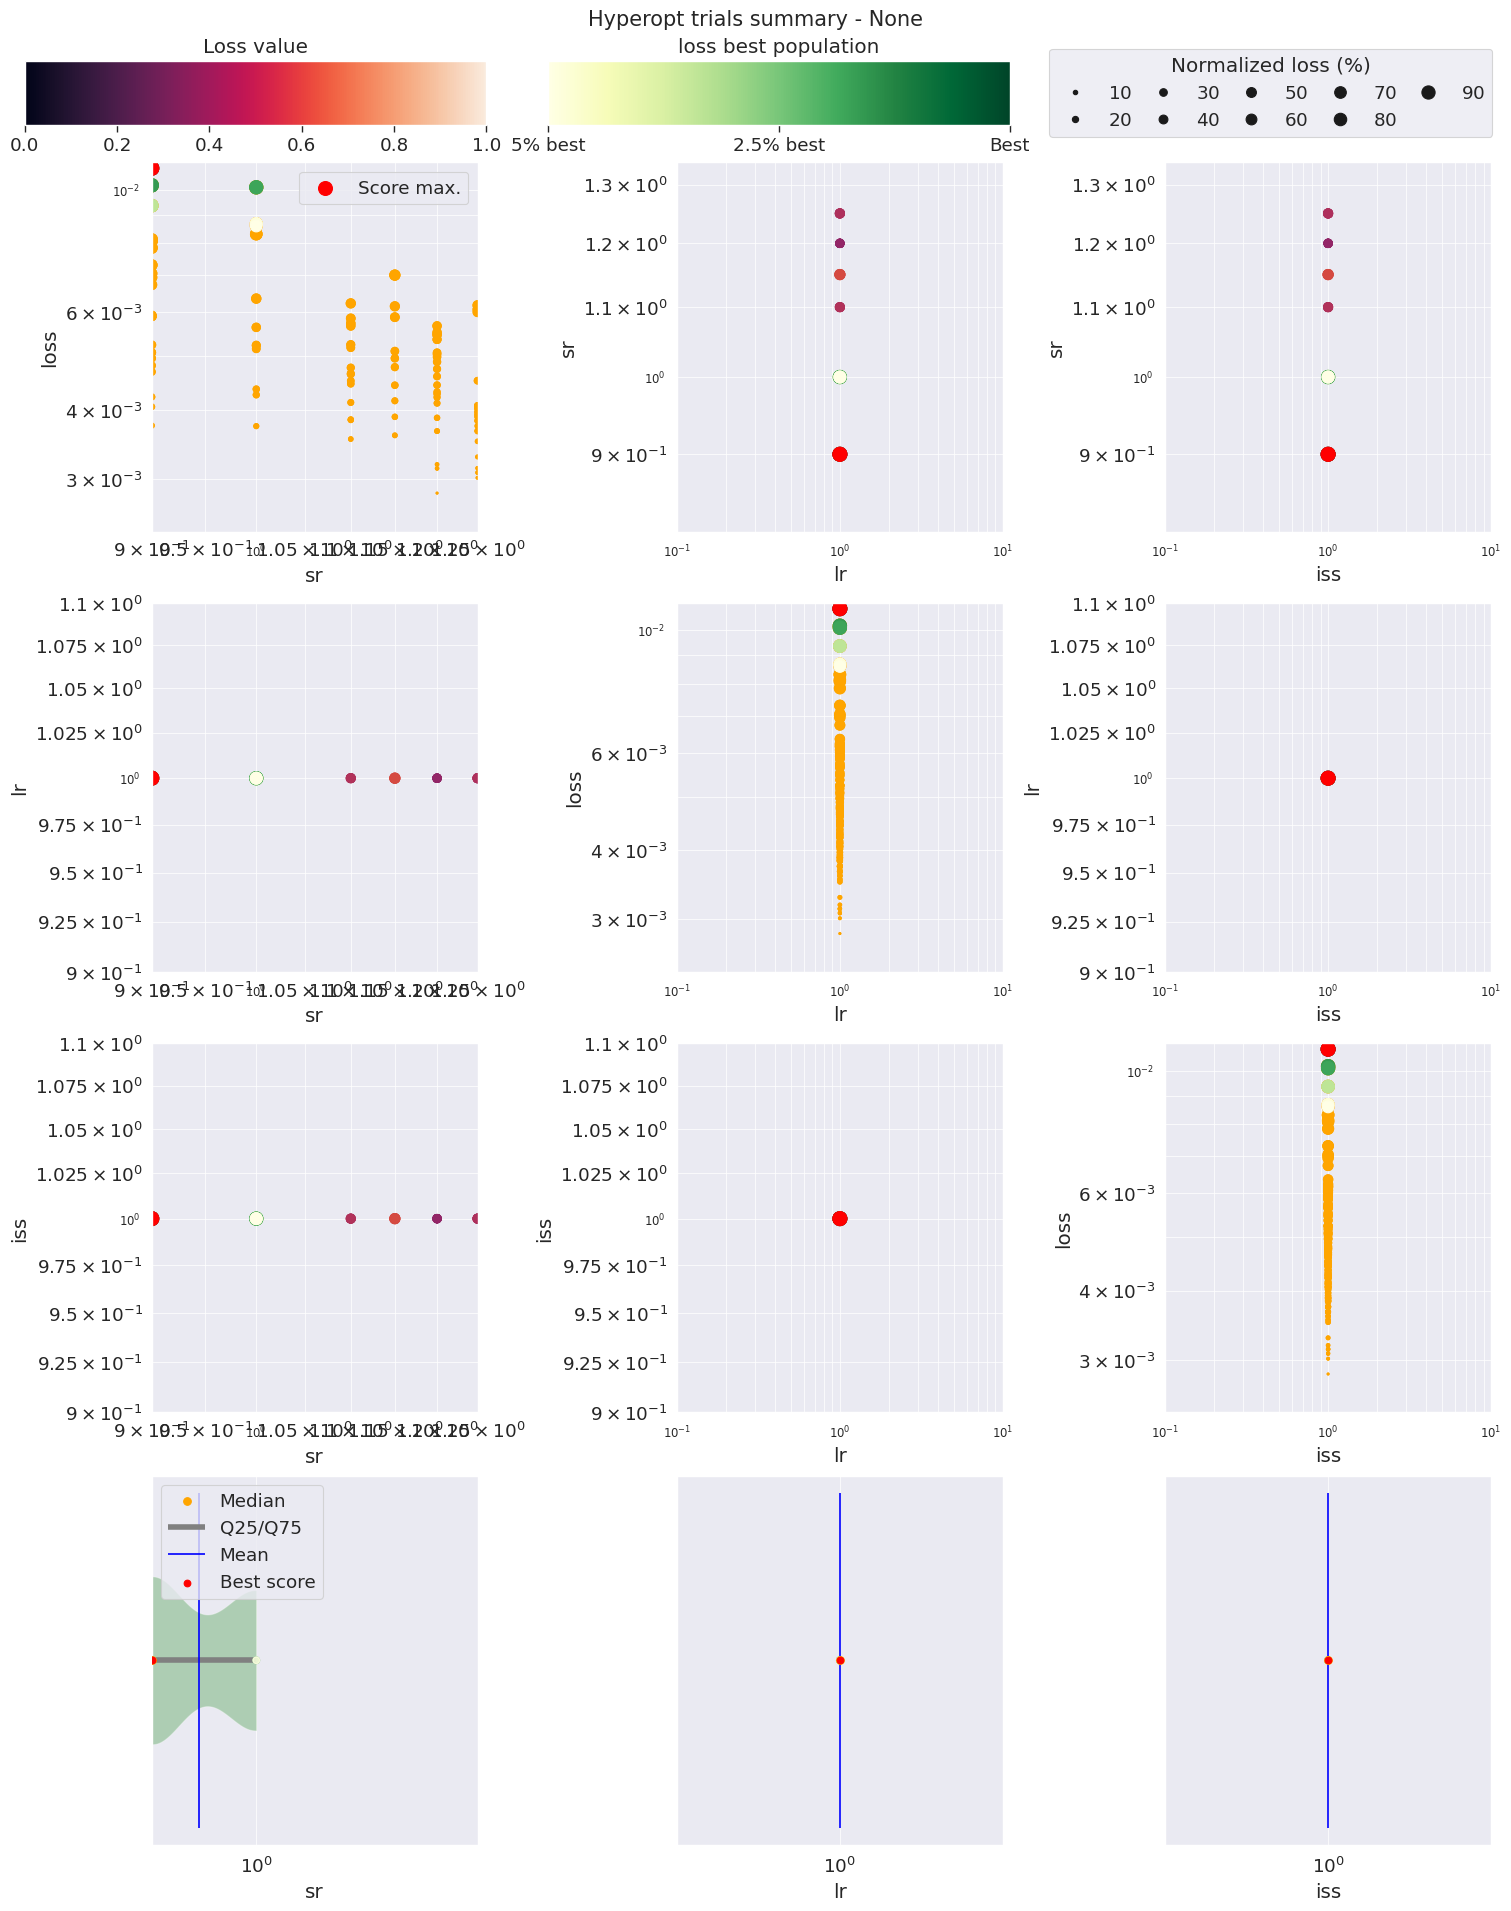

In [38]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("sr","lr","iss"),loss_behaviour='max', metric="loss")

In [39]:
def _get_results(exp):
    report_path = path.join(exp, "results")
    results = []
    for file in os.listdir(report_path):
        if path.isfile(path.join(report_path, file)):
            with open(path.join(report_path, file), "r") as f:
                results.append(json.load(f))
    return results

In [40]:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from os import path
    sns.set(context="paper", style="darkgrid", font_scale=1.5)
    # N = len(params)
    # not_log = not_log or []

    results = _get_results(hyperopt_config["exp"])

    loss = np.array([r["returned_dict"]["loss"] for r in results])

In [41]:
loss

array([0.00388589, 0.00422143, 0.00396558, 0.00592358, 0.00313841,
       0.00383539, 0.00807577, 0.00421551, 0.00459685, 0.00307759,
       0.00451597, 0.00859667, 0.00382356, 0.00545243, 0.00384314,
       0.00374703, 0.00523589, 0.00383539, 0.00443427, 0.00401997,
       0.00590337, 0.00615464, 0.00622956, 0.00813037, 0.00563834,
       0.00673128, 0.00406506, 0.003667  , 0.00573296, 0.00407472,
       0.00831105, 0.00318805, 0.00388569, 0.00507348, 0.00445874,
       0.00474191, 0.00522461, 0.00705534, 0.00545243, 0.0049575 ,
       0.00515785, 0.00401997, 0.00308496, 0.00567179, 0.00585269,
       0.0031353 , 0.00308496, 0.00592358, 0.00600679, 0.00635531,
       0.00476763, 0.00607469, 0.00301522, 0.00374081, 0.00468575,
       0.00388569, 0.00536056, 0.00622956, 0.00354265, 0.00498558,
       0.00382356, 0.00445874, 0.00468575, 0.00548485, 0.00488374,
       0.00474191, 0.00495907, 0.0035088 , 0.00354265, 0.00481004,
       0.00536056, 0.01092948, 0.00700719, 0.00694076, 0.00459

In [42]:
 N = np.array([r["current_params"]["N"] for r in results])

In [43]:
max(loss)

0.010929477276431529

In [44]:
N

array([400, 400, 200, 250, 450, 350, 250, 100, 300, 500, 250, 250, 200,
       400, 350, 250, 250, 350, 200, 350, 450, 200, 150, 300,  50, 200,
       400, 200, 450, 250, 300, 450, 150, 150, 450,  50, 400, 400, 400,
       400, 500, 350, 400, 350, 150, 350, 400, 250,  50, 500, 350,  50,
       450, 150, 500, 150, 400, 150, 500, 350, 200, 450, 500,  50, 350,
        50, 200, 400, 500, 100, 400, 350, 250,  50, 300, 250, 350, 250,
        50, 450, 450, 350,  50, 450, 100, 200, 200, 400,  50, 250, 400,
       100, 150, 150,  50, 350, 350, 450, 500, 400, 450, 400,  50,  50,
        50, 300, 100, 200, 250, 100, 250, 200, 100, 350, 450, 250, 500,
       500,  50, 100, 100, 450, 200, 450, 500, 400, 250, 400, 250, 250,
       200, 200, 450, 400, 500, 150, 400, 450, 350, 250, 100, 500, 500,
       250, 450,  50, 450, 200, 350, 200, 450, 150, 250, 150,  50, 350,
       450, 500, 400,  50, 150, 200, 250,  50, 100, 400, 100, 200, 100,
       450, 150, 450,  50, 400, 400, 350, 150, 500, 350, 150, 10

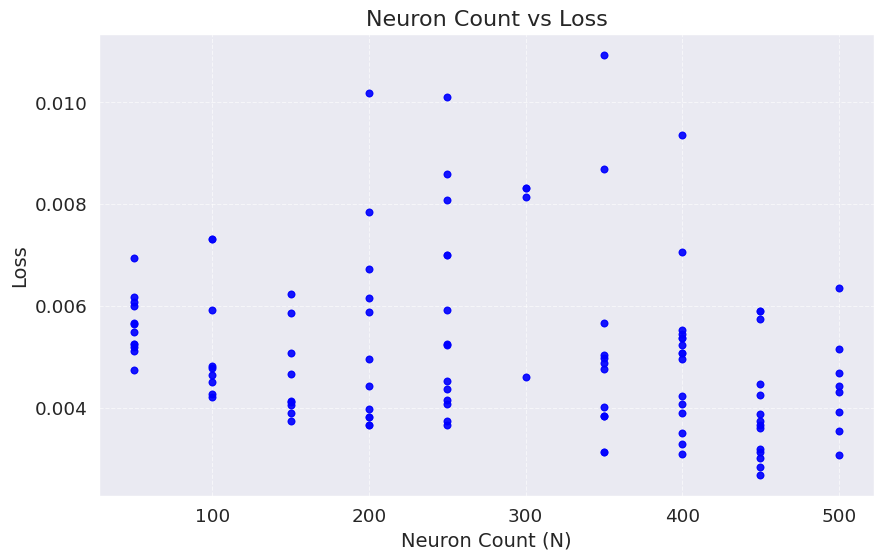

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(N, loss, c='blue', alpha=0.7)
plt.title('Neuron Count vs Loss', fontsize=16)
plt.xlabel('Neuron Count (N)', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [46]:
# connectivity = np.array([r["current_params"]["rc_connectivity"] for r in results])

In [47]:
# connectivity

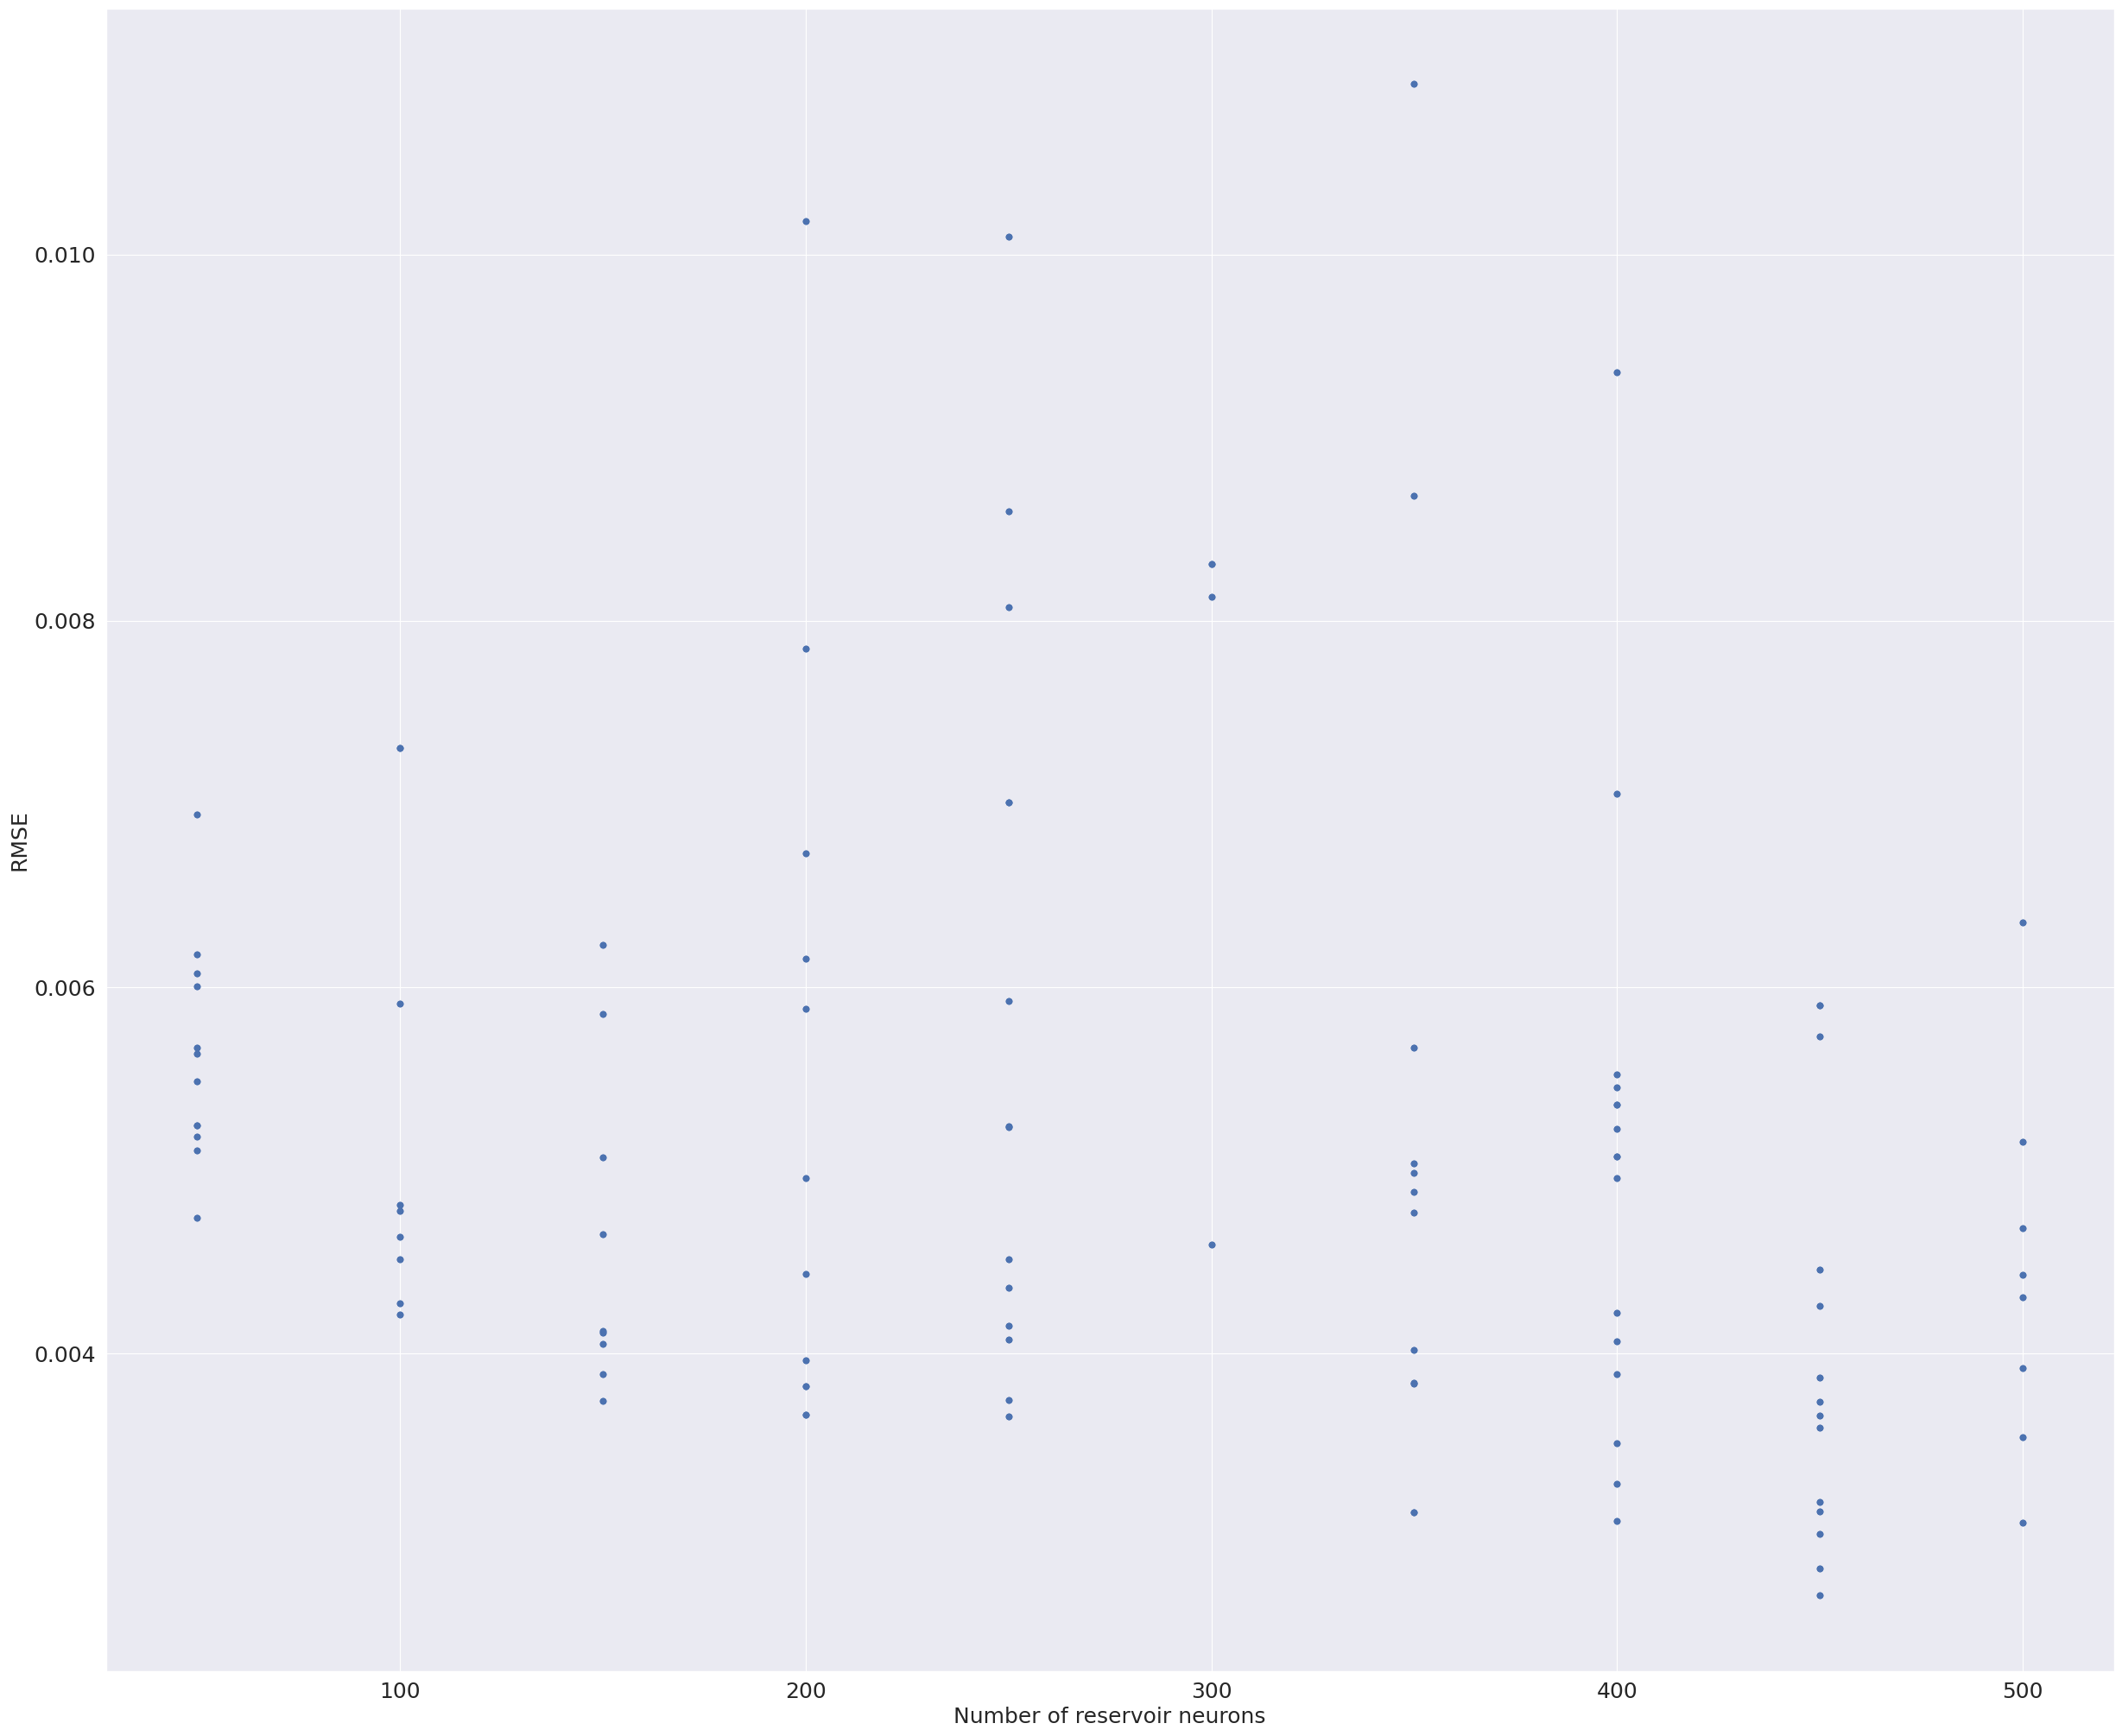

In [48]:
plt.figure(figsize=(30, 25))
plt.scatter(N, loss)

# plt.title("Effect of the No. of neurons on the RMSE")
plt.xlabel("Number of reservoir neurons",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [49]:
loss_int = np.array([r["returned_dict"]["loss_int"] for r in results])

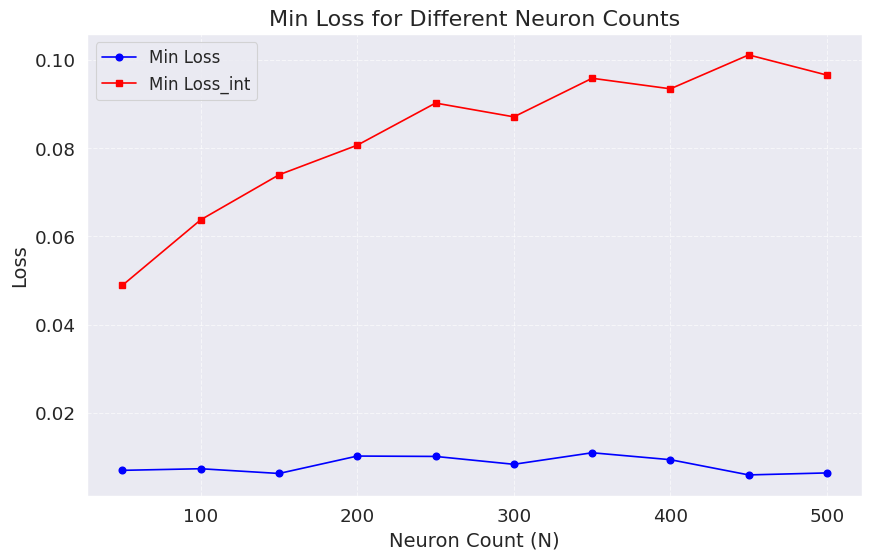

In [50]:
# Get unique N values and minimum loss
unique_N = np.unique(N)
min_loss = [loss[N == n].max() for n in unique_N]
min_loss2 = [loss_int[N == n].min() for n in unique_N]

# Plot
plt.figure(figsize=(10,6))
# plt.yscale("log")
# Plot first dataset
plt.plot(unique_N, np.array(min_loss), label='Min Loss', marker='o', color='blue')

# Plot second dataset
plt.plot(unique_N, np.array(min_loss2), label='Min Loss_int', marker='s', color='red')

# Customizing plot
plt.title('Min Loss for Different Neuron Counts', fontsize=16)
plt.xlabel('Neuron Count (N)', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

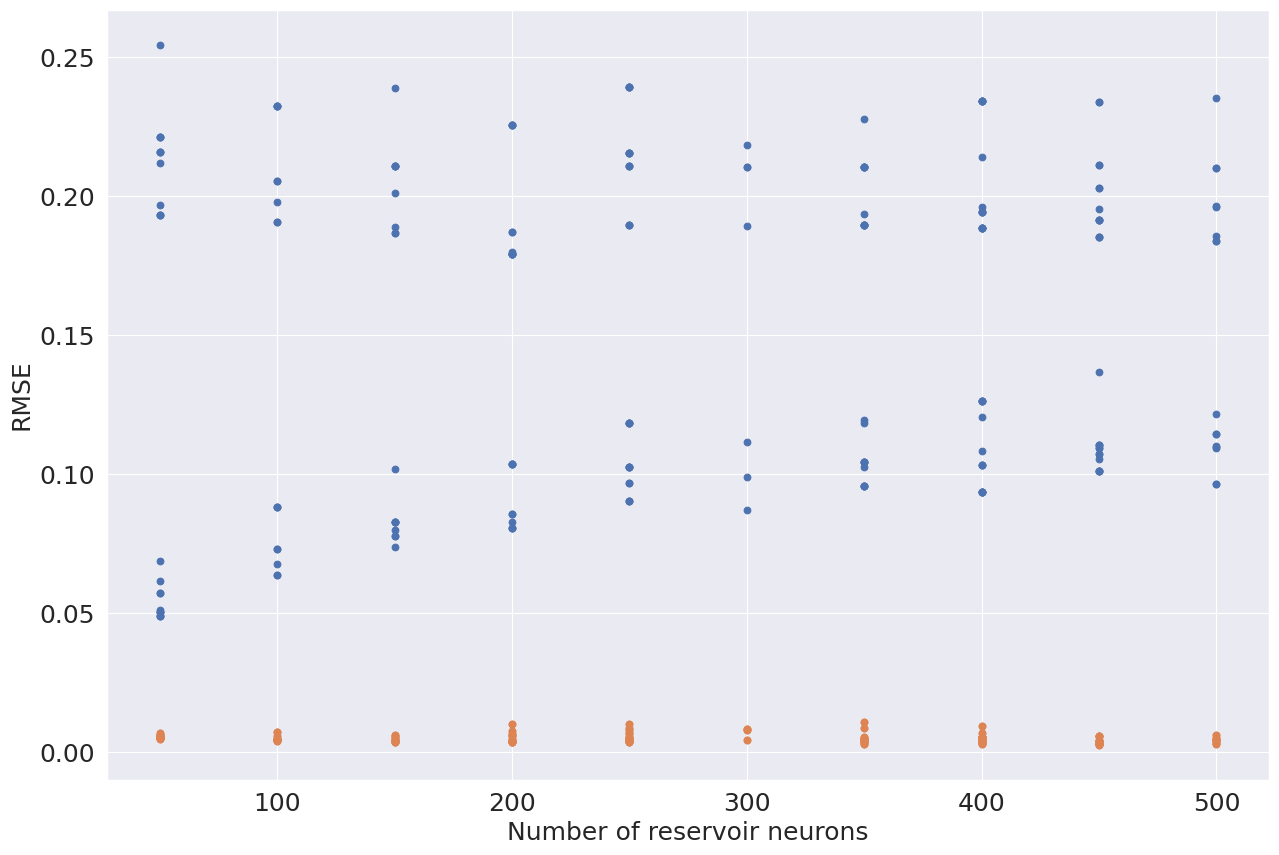

In [51]:
plt.figure(figsize=(15, 10))
plt.scatter(N, loss_int)
plt.scatter(N, loss)
# plt.title("Effect of the No. of neurons on the RMSE")
plt.xlabel("Number of reservoir neurons",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [52]:
unique_N = np.unique(N)
for n in (unique_N):
	print(n)
	print(loss_int[N == n].tolist())

50
[0.061572263745755695, 0.2212751709168774, 0.19317643555798872, 0.19317643555798872, 0.2212751709168774, 0.05049272836919422, 0.06876784188594398, 0.04891397382847818, 0.22127517091687743, 0.05716742317684224, 0.2119907509575177, 0.057167423176842175, 0.25431428389262484, 0.21569828975771435, 0.05049272836919422, 0.05102939668199633, 0.21569828975771435, 0.19672991595435563, 0.050492728369194245, 0.04891397382847817, 0.19317643555798872, 0.04891397382847817, 0.2156982897577143]
100
[0.19081951225540772, 0.23237224031207582, 0.20552820410016218, 0.2323722403120758, 0.0637684009026692, 0.08817220009022979, 0.07315728078438177, 0.23237224031207582, 0.20552820410016223, 0.08817220009022973, 0.1978924201746236, 0.0637684009026692, 0.08817220009022968, 0.2323722403120758, 0.07315728078438179, 0.067654411606853, 0.19081951225540772]
150
[0.21073705817773905, 0.08008717092740637, 0.0778647761707041, 0.0827705907377155, 0.07397477907116559, 0.2012459878541191, 0.08277059073771553, 0.10196840